# Bank Churn Analysis

# 1. Context

### The business
Business Model: banking services through physical agencies and online.

TopBank is an european bank with clients in France, Germany and Spain. The company offers banking services such as banking accounts, investment portfolios and insurances. The main product is the banking account, where clients can make transfers, deposits, withdraws and other movements. This product is free of charge and is valid up to 1 year, after that the client needs to renew their membership for another 12 months. TopBank is available to its costumers online and as a physical business. The company has a database with clients' information regarding their demographic caractheristics and their activities in the bank.

According to the Analytics Team, TopBank profits 15% of a customer's estimated salary if the salary is is equal or less than the average salary of TopBank's clients. When the estimated salary is higher than the average, TopBank profits 20% of the estimated salary.



### The problem
TopBank noticed an increase of clients not renewing their contract or cancelling the contract before the end date, in other words they noticed an increase in the churn rate. The churn rate is also known as attrition rate and in this context it is defined as the rate at which customers stop doing business with an entity. A high churn rate can affect profits and growth. 

Churn can happen for several motives. The number 1 reason why customers leave a bank institution is due to poor service. Service can be influenced by rates, fees, communication and service quality and wait times, location sites, available mix of products and availability of digital tools. 

There are other important reasons to consider such as death, displacement and divorces.

Ref: https://thefinancialbrand.com/55772/banking-customer-attrition-analysis/; https://www.qualtrics.com/blog/customer-churn-banking/

### Business Needs
TopBank needs to understand why the churn rate is increasing and which actions are recommended to reduce this number. They ask your help to create an action plan to reduce customer churn (either avoid a client to cancel the subscription prior the end date and avoid the non contract renovation). In order to complete this task you need to develop a model to predict the probability of customer's churn.

The Analytics Team and the CEO also asked:
- What is TopBank current churn rate? How does it varies monthly?
- What is your model performance in classifying clients in churn?
- What is the expected revenue if TopBank uses your model to avoid client's churn?
- If you offer any type of financial incentive to avoid churn, which should be its value to maximize the company's ROI? You can surpass R$10.000/client in incentives.

### Solution
- Model to predict client's churn probability and answer TopBank questions.


# 2. Imports

## 2.1 Libraries

In [1]:
# utilities
import pickle
import inflection
#from general_utils.GeneralUtils import GeneralUtils
from IPython.display import HTML
from IPython.display import Image
import warnings
#from collections import Counter

# data manipulation
import pandas as pd
import numpy as np
from sklearn.utils import shuffle

# EDA
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from IPython.display import IFrame

# preprocessing
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder

# feature selection
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.decomposition import PCA

# machine learning
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
from sklearn.model_selection import cross_val_score

# algorithms
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier

# metrics
import sklearn.metrics   as m
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score,confusion_matrix, matthews_corrcoef, make_scorer, roc_curve, precision_recall_curve
from sklearn.model_selection import cross_validate, cross_val_predict, RandomizedSearchCV
import scikitplot as skplt


## 2.2 Helper Functions

In [2]:
warnings.filterwarnings('ignore')

# sets seaborn default style
sns.set()

# sets matplolit inline
%matplotlib inline

# sets to display unlimited number of columns
pd.options.display.max_columns = 70

# setting the title and axis labels
def set_plots_features(ax, title, xlabel, ylabel):
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    
# cramér V
def cramer_v(var_x, var_y):
    # builds contigency matrix (or confusion matrix)
    confusion_matrix = pd.crosstab(var_x, var_y).values
    
    # gets the sum of all values in the matrix
    n = confusion_matrix.sum()
    
    # gets the rows, cols
    r, k = confusion_matrix.shape
    
    # gets the chi-squared
    chi2 = chi2_contingency(confusion_matrix)[0]
    
    # makes the bias correction
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    kcorr = k - (k-1) ** 2 / (n-1)
    rcorr = r - (r-1) ** 2 / (n-1)
    
    # returns cramér V
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = 40
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', -1)
    pd.set_option( 'display.expand_frame_repr', False ) 
    pd.options.display.float_format = '{:,.6f}'.format
    sns.set()

jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Model's performance function
def performance(model, x_train, y_train):
    # define scoring metrics
    scoring = {'accuracy': 'accuracy',
               'precision': make_scorer(precision_score),
               'recall': make_scorer(recall_score),
               'f1_score': make_scorer(f1_score),
               'roc_auc_score': make_scorer(roc_auc_score),
               'mcc': make_scorer(matthews_corrcoef)}

    # calculate scores with cross_validate
    scores = cross_validate(model, x_train, y_train, cv=10, scoring=scoring,return_train_score=True)

    # performance data frame
    performance = pd.DataFrame.from_dict(scores).drop(['fit_time', 'score_time'], axis=1)
    performance = pd.DataFrame(performance.mean()).T
    return performance

In [5]:
def ml_scores(model_name, y_true, y_pred):
    
    accuracy = m.balanced_accuracy_score(y_true, y_pred)
    precision = m.precision_score(y_true, y_pred)
    recall = m.recall_score(y_true, y_pred)
    f1 = m.f1_score(y_true, y_pred)
    kappa = m.cohen_kappa_score(y_true, y_pred)
    roc_auc_score = m.roc_auc_score(y_true, y_pred)
    
    return pd.DataFrame({'Balanced Accuracy': np.round(accuracy, 3), 
                         'Precision': np.round(precision, 3), 
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3),
                         'ROC_AUC': np.round(roc_auc_score, 3),
                         'Kappa': np.round(kappa, 3)}, index=[model_name])

In [6]:
def performance_test(model_name, model, x_test, y_test):
    # predcitions
    yhat = model.predict(x_test)
    
    # Performance metrics
    precision = precision_score(y_test, yhat)
    recall = recall_score(y_test, yhat)
    f1 = f1_score(y_test, yhat)
    roc_auc = roc_auc_score(y_test, yhat)
    mcc = matthews_corrcoef(y_test, yhat)

    # Performance dataframe
    performance_df = pd.DataFrame({'precision': precision, 'recall': recall, 'f1_score': f1, 
                               'roc_auc_score': roc_auc, 'mcc': mcc}, index=[model_name])

    # confusion matrix
    cm = confusion_matrix(y_test, yhat)

    # dataframe for heatmap
    cm_df = pd.DataFrame(cm, columns=['predicted_not_churn', 'predicted_churn'], 
                         index=['actual_not_churn', 'actual_churn'])
    
    return performance_df, c

# 3. Data Description

## 3.1 Metadata

The company provided some metadata:

| Variable | Description  | Data Type |
|--|--|--|
| RowNumber | Row number | numerical discrete |
| CustomerID | Unique customer identifier | numerical discrete |
| Surname | Customer's surname | categorical nominal |
| CreditScore | Customer's market credit score | numerical discrete |
| Geography | Customer's local of residence | categorical nominal |
| Gender | Customer's gender | numerical nominal |
| Age | Customer's age | numerical discrete |
| Tenure | Total number of years customer has been an active bank client | numerical discrete |
| Balance | Total customer's bank account balance | numerical continuous |
| NumOfProducts | Total number of products bought by the customer |  numerical discrete |
| HasCrCard | Flag variable - indicates if the customer has a credit card or not | binary |
| IsActiveMember | Flag variable - indicates if the customer made any bank transaction in the last 12 months | binary |
| EstimateSalary | Customer's estimated month salary | numerical continuos |
| Exited | Flag variable - indicates if the customer has churn or not | binary target |

## 3.2 Load Dataset

In [7]:
df = pd.read_csv('../database/churn.csv')
df.head()

# Data source: https://www.kaggle.com/mervetorkan/churndataset

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  Tenure        Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  Exited
0  1          15634602    Hargrave  619          France    Female  42   2      0.000000        1              1          1              101,348.880000    1     
1  2          15647311    Hill      608          Spain     Female  41   1      83,807.860000   1              0          1              112,542.580000    0     
2  3          15619304    Onio      502          France    Female  42   8      159,660.800000  3              1          0              113,931.570000    1     
3  4          15701354    Boni      699          France    Female  39   1      0.000000        2              0          0              93,826.630000     0     
4  5          15737888    Mitchell  850          Spain     Female  43   2      125,510.820000  1              1          1              79,084.100000     0

In [8]:
cols_old = df.columns.to_list()
snakecase = lambda x: inflection.underscore(x)
cols_new = list (map(snakecase,cols_old))
df.columns=cols_new

## 3.3 Data Dimension

In [9]:
print ('Number of rows: {}'.format (df.shape[0]))
print ('Number of columns: {}'.format (df.shape[1]))

Number of rows: 10000
Number of columns: 14


## 3.4 Data Types

In [10]:
df.dtypes

row_number          int64  
customer_id         int64  
surname             object 
credit_score        int64  
geography           object 
gender              object 
age                 int64  
tenure              int64  
balance             float64
num_of_products     int64  
has_cr_card         int64  
is_active_member    int64  
estimated_salary    float64
exited              int64  
dtype: object

## 3.5 NA Values

In [11]:
df.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

## 3.6 Split train and test data

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit

# Apply stratified sampling in order to keep target variable proportion in the train and test sets 
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_valid_index in split.split(df, df['exited']):
    train_set = df.iloc[train_index]
    test_set = df.iloc[test_valid_index]

In [13]:
df['exited'].value_counts()

0    7963
1    2037
Name: exited, dtype: int64

In [14]:
train_set['exited'].value_counts()

0    6370
1    1630
Name: exited, dtype: int64

In [15]:
test_set['exited'].value_counts()

0    1593
1    407 
Name: exited, dtype: int64

## 3.7 Descriptive Statistics

In [16]:
num_attributes_train = train_set.select_dtypes( include = ['int64', 'float64','int32'])
cat_attributes_train = train_set.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]','int32'])

num_attributes_test = test_set.select_dtypes( include = ['int64', 'float64','int32'])
cat_attributes_test = test_set.select_dtypes( exclude = ['int64', 'float64', 'datetime64[ns]','int32'])

### 3.6.1 Numerical Variables

#### 3.6.1.1 Visualizations

In [17]:
d1=num_attributes_train.describe().T

In [18]:
k=pd.DataFrame(num_attributes_train.kurtosis()).T
s=pd.DataFrame(num_attributes_train.skew()).T
d2 = pd.concat([k,s]).T.reset_index()
d2.columns = ['variable','kurtosis', 'skew']

In [19]:
ds_num = d2.join (d1,on='variable')
ds_num

variable  kurtosis      skew        count              mean           std               min               25%               50%               75%               max
0   row_number       -1.209629 0.002629  8,000.000000 4,990.432875      2,896.482331  1.000000          2,461.750000      4,987.500000      7,509.500000      10,000.000000    
1   customer_id      -1.196055 0.006936  8,000.000000 15,690,877.680750 71,936.185838 15,565,701.000000 15,628,691.250000 15,689,954.000000 15,753,269.000000 15,815,690.000000
2   credit_score     -0.418624 -0.079540 8,000.000000 650.752500        96.596432     350.000000        584.000000        652.000000        717.000000        850.000000       
3   age              1.459448  1.035706  8,000.000000 38.946625         10.526876     18.000000         32.000000         37.000000         44.000000         92.000000        
4   tenure           -1.172842 0.013124  8,000.000000 5.016625          2.896791      0.000000          3.000000          5.000000          8.000000          10.000000        
5   balance          -1.492209 -0.141721 8,000.000000 76,381.207499     62,302.053597 0.000000          0.000000          97,055.145000     127,633.195000    238,387.560000   
6   num_of_products  0.636943  0.755984  8,000.000000 1.529500          0.581741      1.000000          1.000000          1.000000          2.000000          4.000000         
7   has_cr_card      -1.155561 -0.919091 8,000.000000 0.708750          0.454367      0.000000          0.000000          1.000000          1.000000          1.000000         
8   is_active_member -1.996955 -0.059538 8,000.000000 0.514875          0.499810      0.000000          0.000000          1.000000          1.000000          1.000000         
9   estimated_salary -1.174789 0.007126  8,000.000000 99,730.811581     57,335.116540 11.580000         50,691.817500     99,446.940000     148,527.730000    199,992.480000   
10  exited           0.164715  1.471283  8,000.000000 0.203750          0.402810      0.000000          0.000000          0.000000          0.000000          1.000000

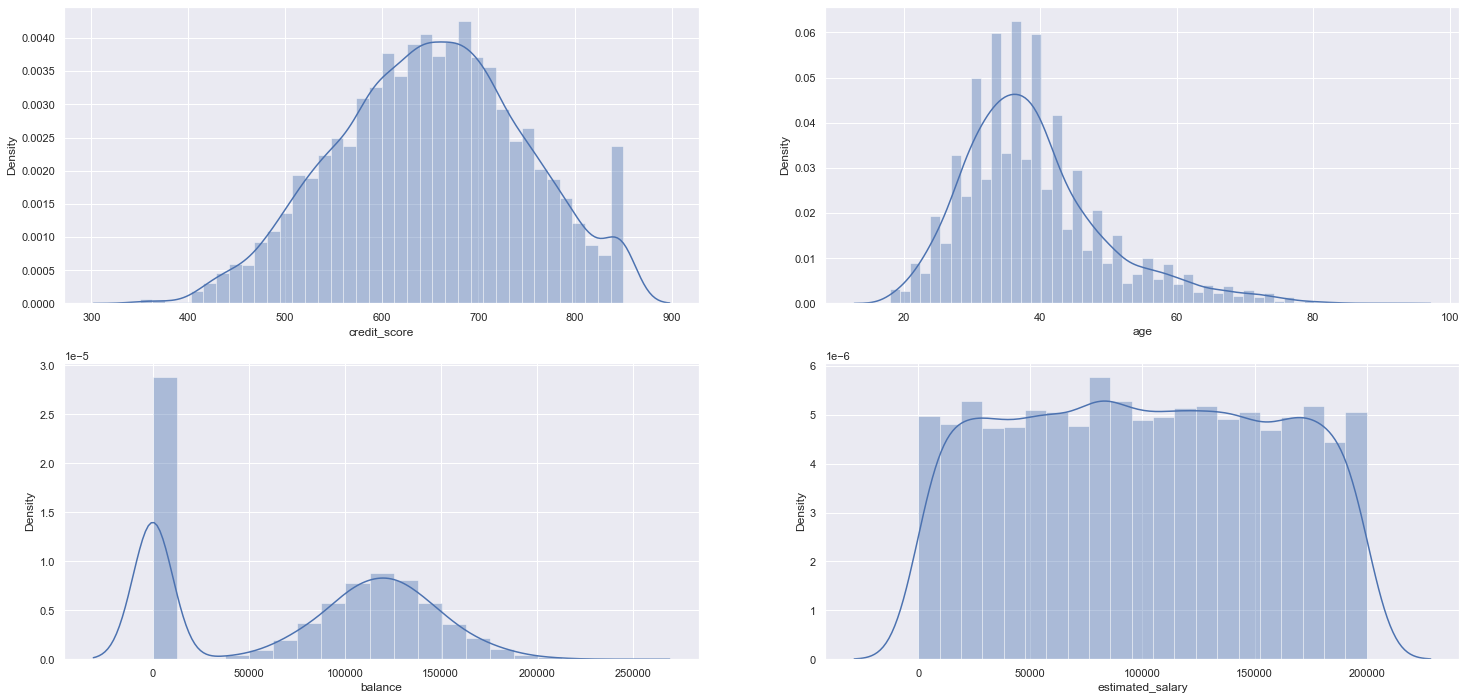

In [20]:
plt.subplot(2, 2, 1)
ax = sns.distplot(train_set['credit_score'])

plt.subplot(2, 2, 2)
ax = sns.distplot(train_set['age'])

plt.subplot(2, 2, 3)
ax = sns.distplot(train_set['balance'])

plt.subplot(2, 2, 4)
ax = sns.distplot(train_set['estimated_salary'])

plt.show()

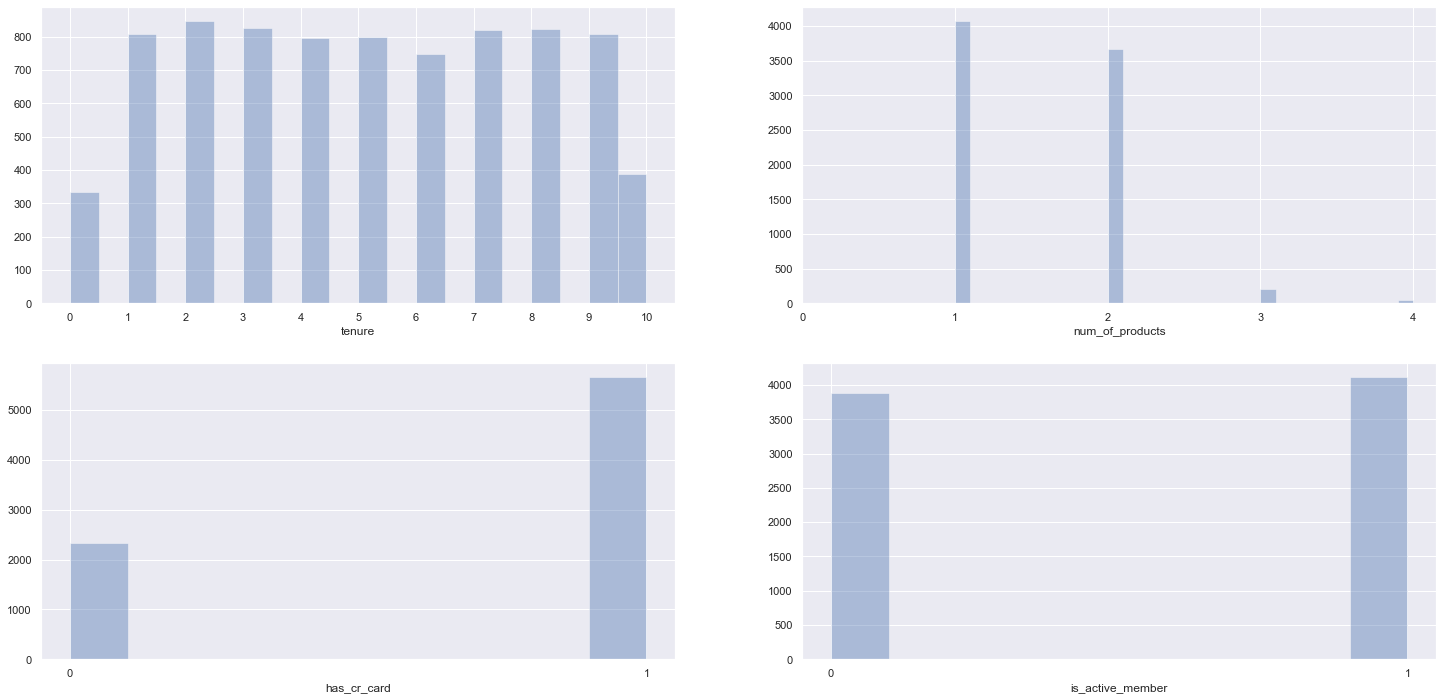

In [21]:
plt.subplot(2, 2, 1)
ax = sns.distplot(train_set['tenure'],kde=False)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

plt.subplot(2, 2, 2)
ax = sns.distplot(train_set['num_of_products'],kde=False)
plt.xticks([0, 1, 2, 3, 4])

plt.subplot(2, 2, 3)
ax = sns.distplot(train_set['has_cr_card'],kde=False)
plt.xticks([0, 1])

plt.subplot(2, 2, 4)
ax = sns.distplot(train_set['is_active_member'],kde=False)
plt.xticks([0, 1]);

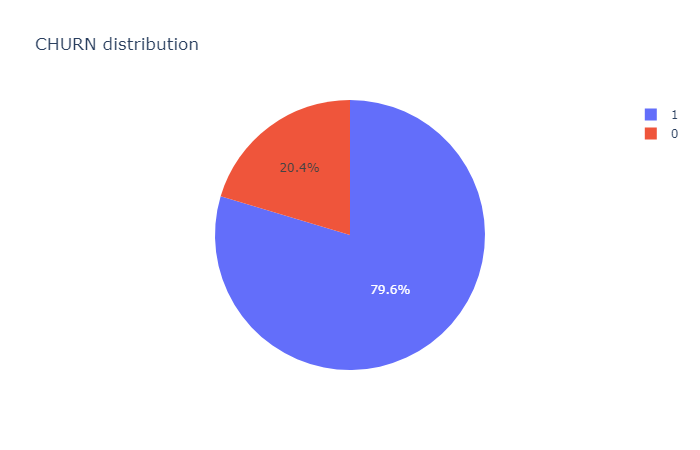

In [22]:
import plotly.graph_objects as go

data_ex = dict(type='pie', 
            labels=train_set['exited'].unique(),
            values=train_set['exited'].value_counts()
           )

layout = dict(title=dict(text='CHURN distribution'))
fig=go.Figure(data=data_ex, layout=layout)
fig.show(renderer='png')


#### 3.6.1.2 Conclusions

**credit_score**: TopBank uses FICO score scale to determine customer's Credit Score. This scale goes from 300 to 850 and defines customers as: <br>
&nbsp; Score &nbsp;&nbsp;| Classification <br>
300-629 | Bad <br>
630-689 | Fair <br>
690-719 | Good <br>
720-850 | Excelent <br>
<br>
All credit scores are in between the FICO range, from 350 to 850. The mean of scores is 650 +- 96 (Bad and Fair). The skew and kurtosis for this variable is very close to 0, so we can consider we have a normal distribution. However by evaluating the histogram, we can see that in the end we have a peak of clients with the highest credit scores. 75% of the clients are Good or below and more than half are Fair or below.

**age**: Client's age range from 18 to 92. It doesn't seem to be any entry errors in this variable. As there is some older clients, we may have to check if they churn due to their death. The average customer's age is 39 +- 10 years. The skew and kurtosis are positivewith a tendency of the tail ranging slight more to the right (older clients). This can be explained by the fact that clients must be 18 or older to have a bank account, therefore the maximum age is "farther" from the mean. It is also interesting to note that 75% of customers have 44 or less years and 50% of clients have between 32 to 44 years.

**tenure**: Up to half of costumers are clients with TopBank for 5 years. Tenure varies from 0 to 10 years and the mean is 5 +- 2.

**balance**: We have at least 25% of clients with balance = 0. We need to further investigate this because it may come from clients that already churn, or it may be some type of entry error, or the balance is indeed zero. Many clients that will close the bank account may withdraw all money in the account before leaving. With the quantity of zero account balances in mind, it makes sense that the kurtosis is negative. However, if we disconsider the zeros, we have a normal distribution. Most client's balance is less than 100,000 and the average balance is 76.485 +- 62.397. Again, the excessive number of zeros in this variable can cause some distortion.

**num_of_Products**: The number of products a client can acquire ranges from 1 to 4. At least half of the clients have only one product acquired, and most costumers have 1 to 2 products in their portfolio.

**has_cr_card**: Around 70% of customers do have a credit car.

**is_active_member**: A little more than half of the clients performed a transaction in the last 12 months.

**estimated_salary**: Client's estimated salary is quite balanced. The mean is 100,090.23 +- 57,510.49. We have to look further to understand the monthly salaries that are very low, as the minimum salary 11.58, that is way below the minimum salary in France, Germany and Spain.

**CLIENTS CURRENT IN CHURN**: 20.4%

Skewness is a measure of symmetry.
A positive skewness means that the mean/median is higher than the mode and it is skewed to the right.
A symmetrical distribution has the same mean, mode and median.
A negative skewness means that the mode is higher than the mean/median and it is skewed to the left.

Kurtosis is related to the distribution of tails.
A positive kurtosis shows a peak in the distriburion (heavy-tailed).
A negative kurtosis shows a flatten curve (light-tailed).

Outliers can affect kurtosis and skewness. A higher value of kurtosis/skewness usually means you have outliers.

### 3.6.2 Categorical Variables

#### 3.6.2.1 Visualizations

In [23]:
cat_attributes_train.describe()

surname geography gender
count   8000    8000      8000 
unique  2620    3         2    
top     Smith   France    Male 
freq    26      3993      4387

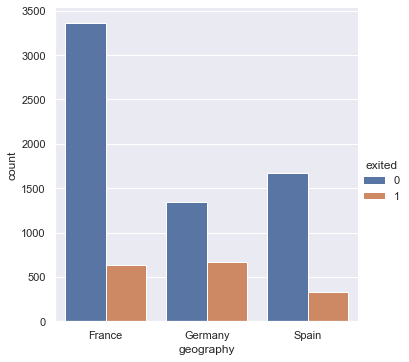

In [24]:
sns.catplot(x="geography", kind="count", hue="exited", data=train_set);

In [25]:
pd.crosstab(train_set['geography'], train_set['exited'],normalize='index').round(4)*100

exited            0         1
geography                    
France    84.100000 15.900000
Germany   66.930000 33.070000
Spain     83.420000 16.580000

In [26]:
pd.crosstab(train_set['exited'], train_set['geography'],normalize='index').round(4)*100

geography    France   Germany     Spain
exited                                 
0         52.720000 21.070000 26.220000
1         38.960000 40.670000 20.370000

In [27]:
cat_attributes_train['geography'].value_counts(normalize=True)*100

France    49.912500
Germany   25.062500
Spain     25.025000
Name: geography, dtype: float64

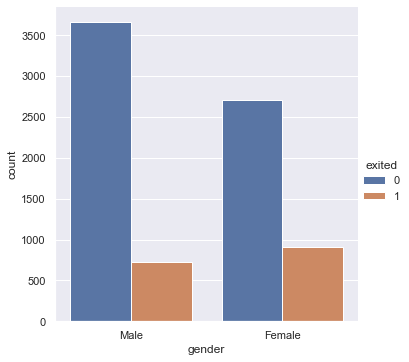

In [28]:
sns.catplot(x="gender", kind="count", hue="exited", data=train_set);

In [29]:
pd.crosstab(train_set['gender'], train_set['exited'],normalize='index').round(4)*100

exited         0         1
gender                    
Female 74.920000 25.080000
Male   83.500000 16.500000

In [30]:
pd.crosstab(train_set['exited'], train_set['gender'],normalize='index').round(4)*100

gender    Female      Male
exited                    
0      42.500000 57.500000
1      55.580000 44.420000

In [31]:
cat_attributes_train['gender'].value_counts(normalize=True)*100

Male     54.837500
Female   45.162500
Name: gender, dtype: float64

#### 3.6.2.2 Conclusions

Most of our clients are from France (nearly 50%). 
Spain and France churn rates are similar (16-17%). 
However, the churn in Germany is higher than 32%, and it is the place where our market is smaller. Only 25% of clients are from Germany and they represent more than 40% of our total clients in churn!

Our clients are mostly males (around 55% of the total), with churn rate of 16,5%. The churn rate for female is 25% and they represent 55% of clients in churn.

The surname variable is not going to be used in the model as it doesn't add any relevant information.

# 4. Feature Engineering

In [32]:
train_set_1=train_set.copy()
test_set_1=test_set.copy()

## 4.1 Hypothesis

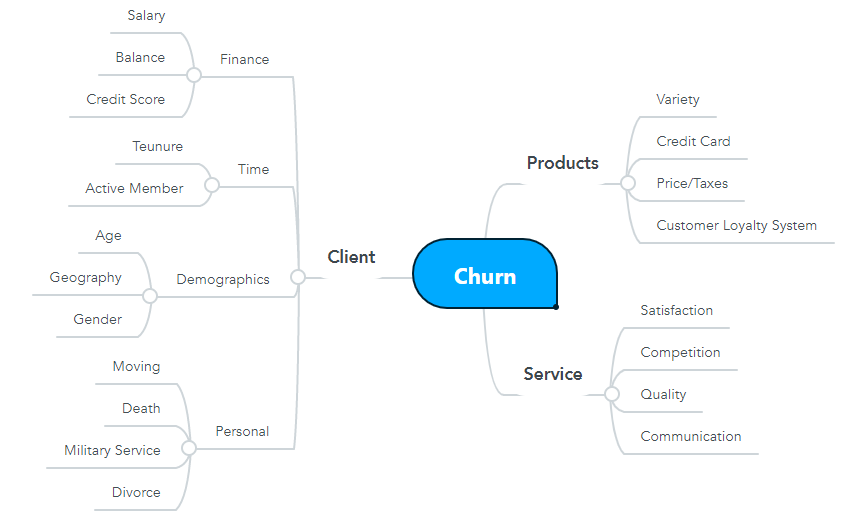

In [33]:
Image(filename='../images/hipoteses_pa003.png')

## 4.2 Feature Engineering

In [34]:
train_set_1['tenure_year'] = train_set['tenure']+1
train_set_1['balance_vs_salary'] = train_set['balance']/train_set['estimated_salary']
train_set_1['tenure_vs_products'] = train_set['tenure']/train_set['num_of_products']
train_set_1['age_class'] = train_set['age'].apply(lambda x: 'Young Adult' if x < 30 else ('Adult' if x>=30 and x<50 else ('Middle Age' if x>=50 and x<75 else 'Old')))
train_set_1['score_class'] = train_set['credit_score'].apply(lambda x: 'Bad' if x < 630 else('Fair' if x>=630 and x<690 else ('Good' if x>=690 and x<720 else 'Excelent')))
train_set_1['credit_vs_tenure']=train_set['credit_score']/train_set_1['tenure_year']
train_set_1['balance_vs_tenure']=train_set['balance']/train_set_1['tenure_year']
train_set_1['has_product_card']=train_set['num_of_products']*train_set['has_cr_card']

test_set_1['tenure_year'] = test_set['tenure']+1
test_set_1['balance_vs_salary'] = test_set['balance']/test_set['estimated_salary']
test_set_1['tenure_vs_products'] = test_set['tenure']/test_set['num_of_products']
test_set_1['age_class'] = test_set['age'].apply(lambda x: 'Young Adult' if x < 30 else ('Adult' if x>=30 and x<50 else ('Middle Age' if x>=50 and x<75 else 'Old')))
test_set_1['score_class'] = test_set['credit_score'].apply(lambda x: 'Bad' if x < 630 else('Fair' if x>=630 and x<690 else ('Good' if x>=690 and x<720 else 'Excelent')))
test_set_1['credit_vs_tenure']=test_set['credit_score']/test_set_1['tenure_year']
test_set_1['balance_vs_tenure']=test_set['balance']/test_set_1['tenure_year']
test_set_1['has_product_card']=test_set['num_of_products']*test_set['has_cr_card']

# 5. Filtering Variables

In [35]:
train_set_2 = train_set_1.copy()
test_set_2 = test_set_1.copy()

pyc_set = train_set_2.copy()

# We are dropping the following columns as they do not add value to the model
drop_columns = ['row_number','customer_id','surname']
train_set_2 =train_set_2.drop(columns=drop_columns,axis=1)
test_set_2 =test_set_2.drop(columns=drop_columns,axis=1)

# 6. Exploratory Data Analysis

In [36]:
train_set_3=train_set_2.copy()
test_set_3=test_set_2.copy()

## 6.1 Target Variable

**We have unbalanced classes.**

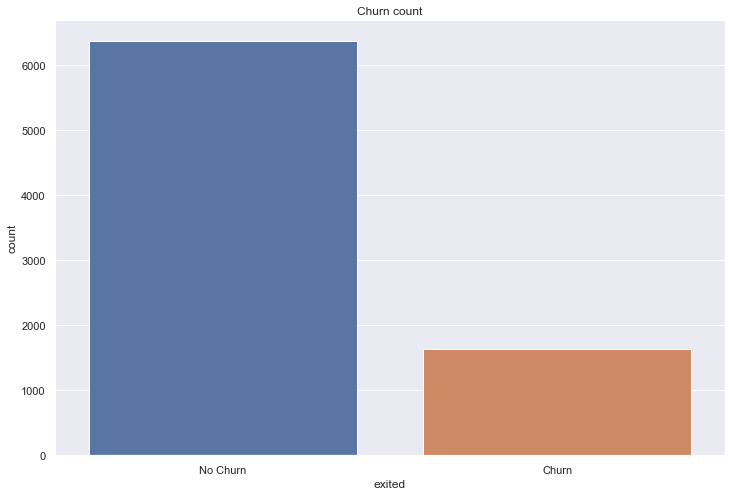

In [37]:
aux1 = train_set_3.groupby('exited').count().reset_index()
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='exited', y='age', data=aux1).set_title('Churn count');
ax.set_ylabel('count')
ax.set_xticklabels(['No Churn','Churn']);

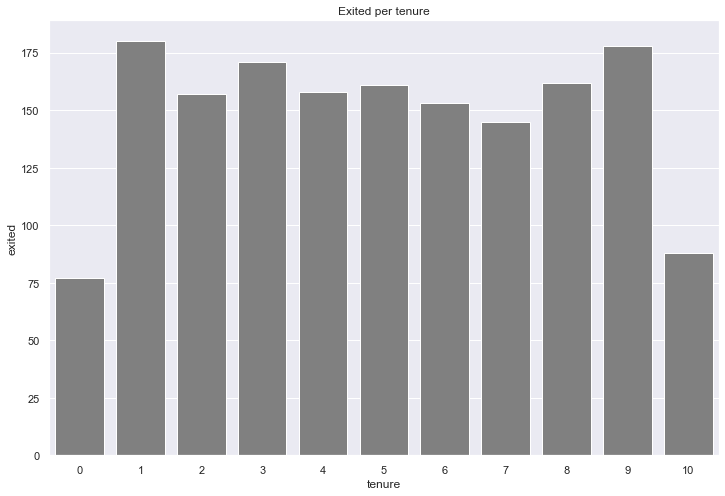

In [38]:
aux1 = train_set_3[['tenure', 'exited']].groupby('tenure').sum().reset_index()
plt.subplots(figsize=(12,8))
sns.barplot(x='tenure', y='exited', data=aux1, color='grey').set_title('Exited per tenure');



In [39]:
total_churn = train_set_3[train_set_3['exited']==1].shape[0]
total_no_churn = train_set_3[train_set_3['exited']==0].shape[0]
total = train_set_3.shape[0]

print(f'Number of Churn: {total_churn} ({round(total_churn/total, 2)*100}% of the total)')
print(f'Number of No Churn: {total_no_churn} ({round(total_no_churn/total, 2)*100}% of the total)')

Number of Churn: 1630 (20.0% of the total)
Number of No Churn: 6370 (80.0% of the total)


Tenure is higher for clients with 1 and 9 years of tenure.

## 6.2 Univariate Analysis

Here we evaluate if the variable itself brings important information to the target variable.<br>
Using Pandas Profiling we see that some created features do not seem very useful and there's correlation between some variables. <br>
Also, we should evaluate the impact of zeros in balance and incoherent values in the estimated salary.

In [40]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train_set_3, title='Profiling Booking' )
profile.to_file( output_file='insights_report_unbal.html' )

## 6.2 Bivariate Analysis - Hypothesis Validation

In [41]:
# create auxiliary dataframes
aux1 = train_set_3[train_set_3['exited']==0]
aux2 = train_set_3[train_set_3['exited']==1]

aux_country_median = train_set_3.groupby("geography").median().reset_index()
aux_country_mean = train_set_3.groupby("geography").mean().reset_index()

aux_ge = train_set_3[train_set_3['geography']=='Germany'].reset_index()
aux_fr = train_set_3[train_set_3['geography']=='France'].reset_index()
aux_sp = train_set_3[train_set_3['geography']=='Spain'].reset_index()

#### H1.1 Clients with higher estimated salary churn less.

FALSE. When the estimated salary is higher than 100,000 there is a tendency to churn more. Indeed, the average salary for clies that churn is higher than no churn

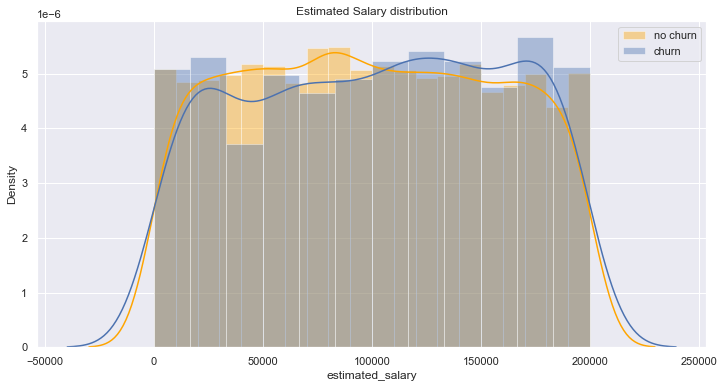

In [42]:
plt.figure(figsize=(12,6))
sns.distplot(aux1['estimated_salary'], color='orange', kde=True, label='no churn')
sns.distplot(aux2['estimated_salary'], kde=True, label='churn')
plt.title('Estimated Salary distribution');
plt.legend();

In [43]:
sal1=(aux1['estimated_salary'].mean())
sal2=(aux2['estimated_salary'].mean())


print(f'No churn estimated salary mean: {round(sal1, 2)}')
print(f'Churn estimated salary mean: {round(sal2, 2)}')

No churn estimated salary mean: 99143.25
Churn estimated salary mean: 102026.98


#### H1.2 Clients from Germany have higher salaries and churn more.

TRUE. As we can see from the normalized histogram, Germany has more clients in the last salary bin and less clients in the first salary bin. When we compare mean and median, the 3 countries show a similar value, with Germany being always the highest one. Churn was analyzed in the Descriptive Statistics

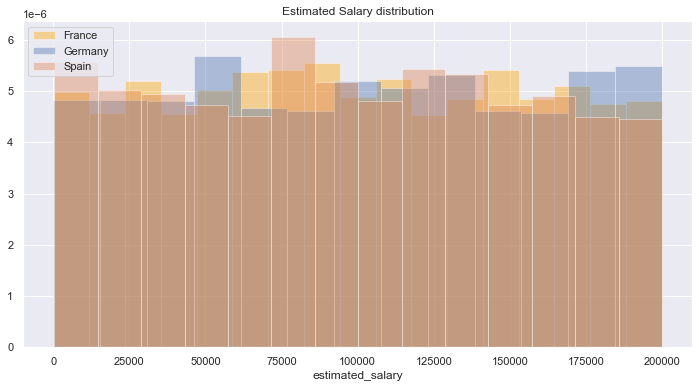

In [44]:
plt.figure(figsize=(12,6))
sns.distplot(aux_fr['estimated_salary'], color='orange', kde=False, label='France',norm_hist=True)
sns.distplot(aux_ge['estimated_salary'], kde=False, label='Germany',norm_hist=True)
sns.distplot(aux_sp['estimated_salary'], kde=False, label='Spain',norm_hist=True)
plt.title('Estimated Salary distribution');
plt.legend();

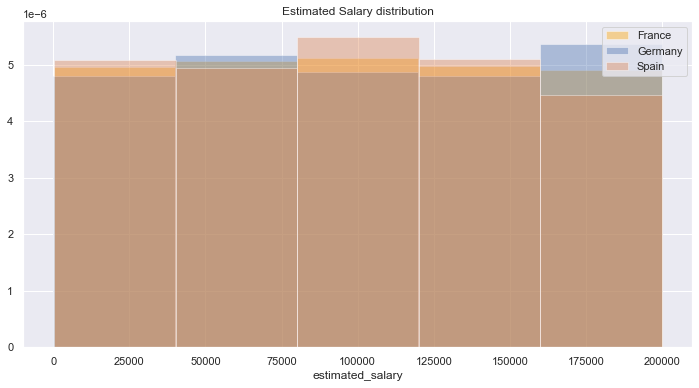

In [45]:
plt.figure(figsize=(12,6))
sns.distplot(aux_fr['estimated_salary'], color='orange', kde=False, label='France',norm_hist=True,bins=5)
sns.distplot(aux_ge['estimated_salary'], kde=False, label='Germany',norm_hist=True,bins=5)
sns.distplot(aux_sp['estimated_salary'], kde=False, label='Spain',norm_hist=True,bins=5)
plt.title('Estimated Salary distribution');
plt.legend();

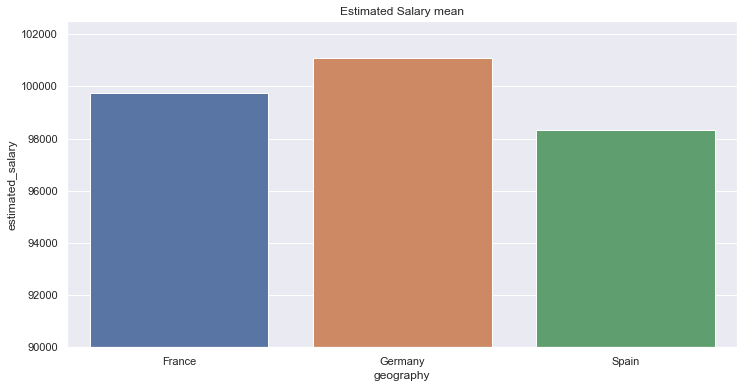

In [46]:
plt.figure(figsize=(12,6))
sns.barplot(x='geography',y='estimated_salary',data=aux_country_mean)
plt.ylim(90000, 102500)
plt.title('Estimated Salary mean');

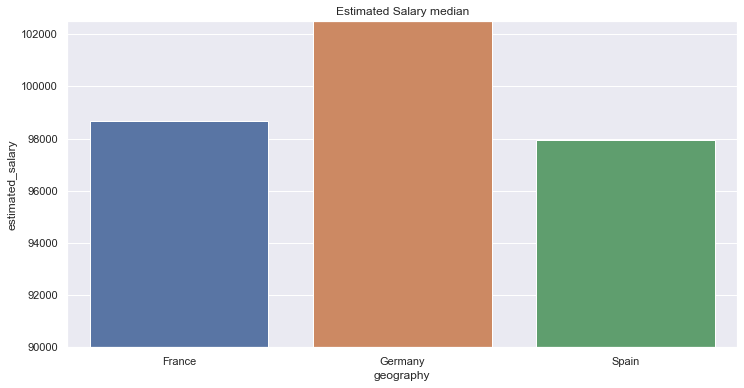

In [47]:
plt.figure(figsize=(12,6))
sns.barplot(x='geography',y='estimated_salary',data=aux_country_median)
plt.ylim(90000, 102500)
plt.title('Estimated Salary median');

#### H1.3 Clients with higher salaries and lower balance churn more.

TRUE. There isn't a clear relationship between high salary and low balance. However, the ratio balance/estimated_salary is usually much lower for no churned clients.

<AxesSubplot:xlabel='estimated_salary', ylabel='balance'>

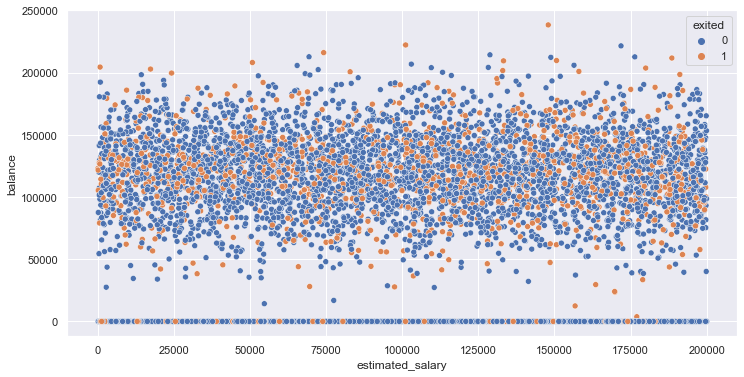

In [48]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='estimated_salary',y='balance',hue='exited',data=train_set_3)

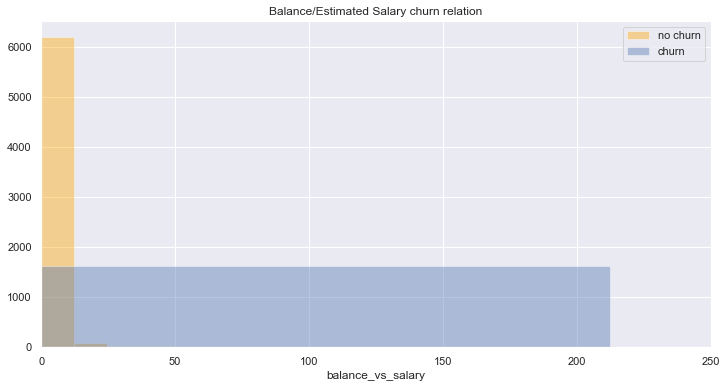

In [49]:
plt.figure(figsize=(12,6))
sns.distplot(aux1['balance_vs_salary'], color='orange', kde=False, label='no churn')
sns.distplot(aux2['balance_vs_salary'], kde=False, label='churn')
plt.title('Balance/Estimated Salary churn relation');
plt.xlim(0,250)
plt.legend();

#### H1.4 Clients with lower credit score churn more.

TRUE. Even if we consider the gross number, the percentage of each class and the normalized histogram, it is possible to notice that clients with lower credit score churn more. It is very important to notice that around 40% of our clients are in the Bad score zone. <br>

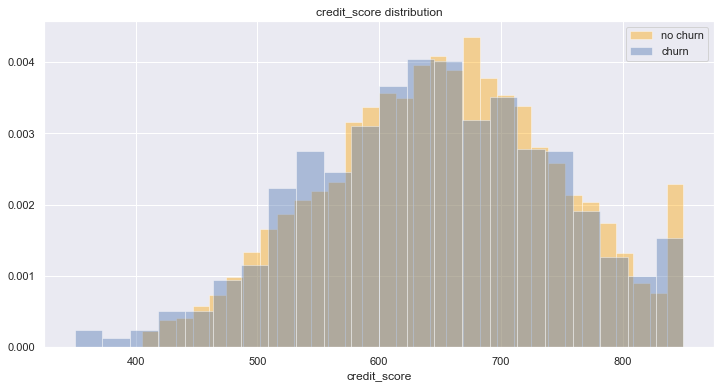

In [50]:
plt.figure(figsize=(12,6))
sns.distplot(aux1['credit_score'], color='orange', kde=False, label='no churn',norm_hist=True)
sns.distplot(aux2['credit_score'], kde=False, label='churn',norm_hist=True)
plt.title('credit_score distribution');
plt.legend();

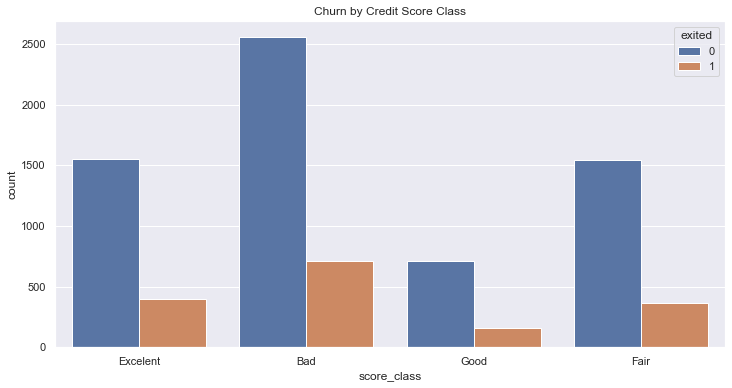

In [51]:
plt.figure(figsize=(12,6))
sns.countplot(x='score_class',hue='exited',data=train_set_3)
plt.title('Churn by Credit Score Class');



In [52]:
pd.crosstab(train_set_3['score_class'], train_set_3['exited']).apply(lambda r: round((r/r.sum()*100),2), axis=1)

exited              0         1
score_class                    
Bad         78.190000 21.810000
Excelent    79.760000 20.240000
Fair        80.870000 19.130000
Good        81.990000 18.010000

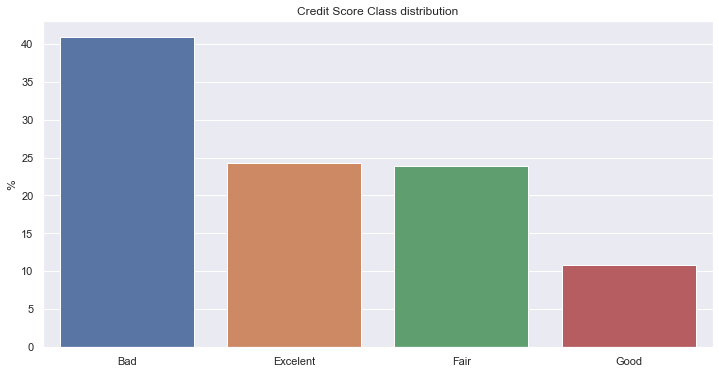

In [53]:
data=train_set_3['score_class'].value_counts(normalize=True)*100
plt.figure(figsize=(12,6))
sns.barplot(x=data.index, y=data);
plt.ylabel('%');
plt.title('Credit Score Class distribution');

#### H1.4 Younger clients have worst median credit score.

FALSE. Middle Age customers have the worst median credit score and the lowest credit scores in the dataset. Until 50 yo clients present a wide range of credit score. From 60 yo, the minimum credit score is around 500; from 75 yo it is around 600.

<AxesSubplot:xlabel='age', ylabel='credit_score'>

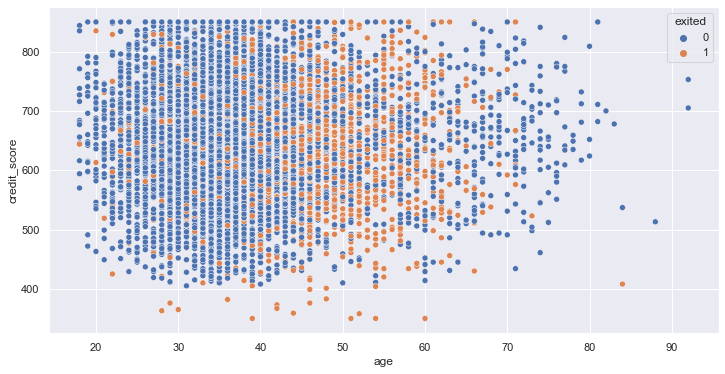

In [54]:
plt.figure(figsize=(12,6))
sns.scatterplot(x='age',y='credit_score',data=train_set_3,hue='exited')

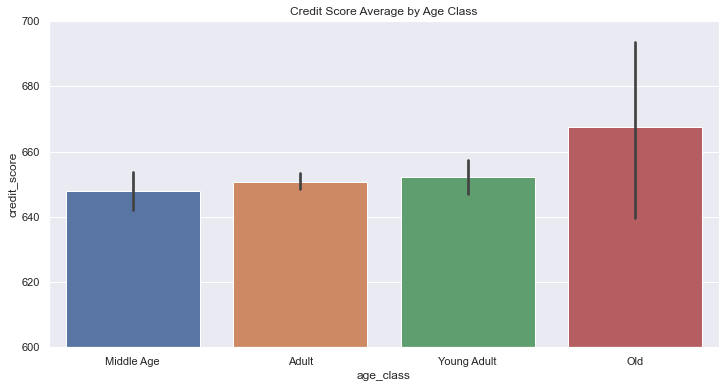

In [55]:
plt.figure(figsize=(12,6))
sns.barplot(y='credit_score',x='age_class',data=train_set_3)
plt.ylim(600, 700)
plt.title('Credit Score Average by Age Class');

#### H1.5 Clients over 75yo churn more.

FALSE. Actually, we do not have any clients churning over 75yo. The group that churns the most is Middle Age, with almost half of people churning. Adults is also an interesting group to analyse, as it represents 70% of all clients and the churn rate is around 18%.

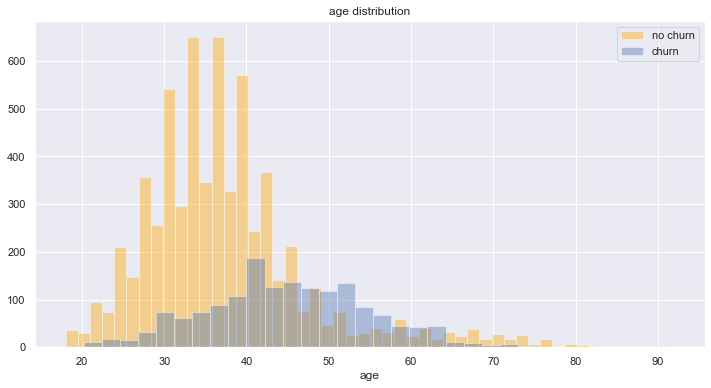

In [56]:
plt.figure(figsize=(12,6))
sns.distplot(aux1['age'], color='orange', kde=False, label='no churn')
sns.distplot(aux2['age'], kde=False, label='churn')
plt.title('age distribution');
plt.legend();

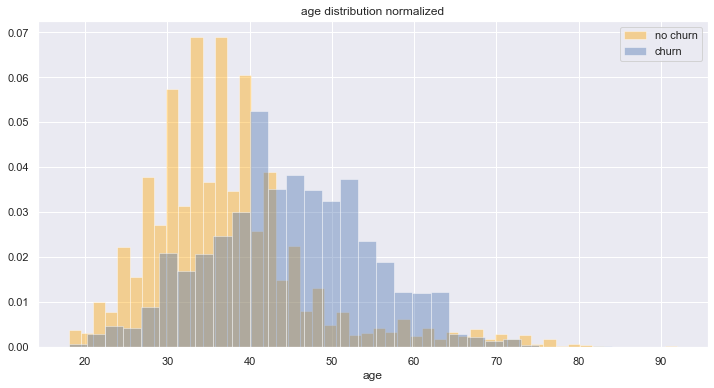

In [57]:
plt.figure(figsize=(12,6))
sns.distplot(aux1['age'], color='orange', kde=False, label='no churn',norm_hist=True)
sns.distplot(aux2['age'], kde=False, label='churn',norm_hist=True)
plt.title('age distribution normalized');
plt.legend();

In [58]:
pd.crosstab(train_set_3['age_class'], train_set_3['exited']).apply(lambda r: round((r/r.sum()*100),2), axis=1)

exited              0         1
age_class                      
Adult       81.740000 18.260000
Middle Age  52.870000 47.130000
Old         97.780000 2.220000 
Young Adult 92.060000 7.940000

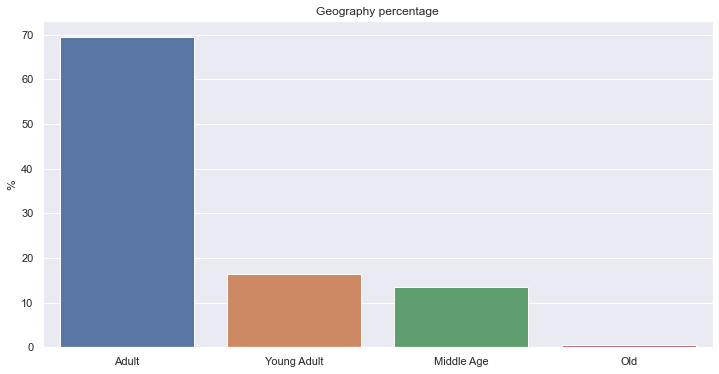

In [59]:
data=train_set_3['age_class'].value_counts(normalize=True)*100
plt.figure(figsize=(12,6))
sns.barplot(x=data.index, y=data);
plt.ylabel('%');
plt.title('Geography percentage');

#### H1.6 Clients with tenure less than 5 years churn 30% more than the rest

FALSE. Clients churn approximatly the same and 10% of them churn after the 1st year with the company.

In [60]:
pd.crosstab(train_set_3['tenure'], train_set_3['exited']).apply(lambda r: round((r/r.sum()*100),2), axis=1)

exited         0         1
tenure                    
0      77.010000 22.990000
1      77.750000 22.250000
2      81.460000 18.540000
3      79.300000 20.700000
4      80.150000 19.850000
5      79.880000 20.120000
6      79.520000 20.480000
7      82.300000 17.700000
8      80.340000 19.660000
9      78.000000 22.000000
10     77.320000 22.680000

In [61]:
aux_tenure_mean = train_set_3.groupby("tenure").mean().reset_index()
aux_tenure_mean['Percentage'] = 100 * aux_tenure_mean['exited']  / aux_tenure_mean['exited'].sum()
aux_tenure_mean['Percentage']

0    10.126622
1    9.802631 
2    8.166480 
3    9.120838 
4    8.745058 
5    8.866548 
6    9.023801 
7    7.800147 
8    8.661767 
9    9.693713 
10   9.992396 
Name: Percentage, dtype: float64

#### H1.6 Tenure varies with credit score

FALSE. The aaverage tenure for all credit scores is 5 years.

<AxesSubplot:xlabel='tenure', ylabel='credit_score'>

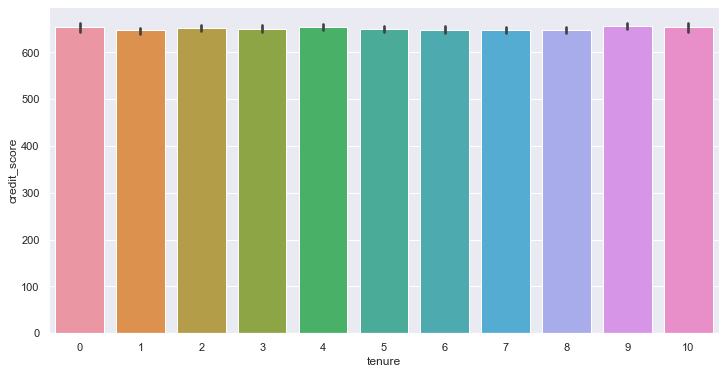

In [62]:
plt.figure(figsize=(12,6))
sns.barplot(y='credit_score',x='tenure',data=train_set_3)

<AxesSubplot:xlabel='score_class', ylabel='tenure'>

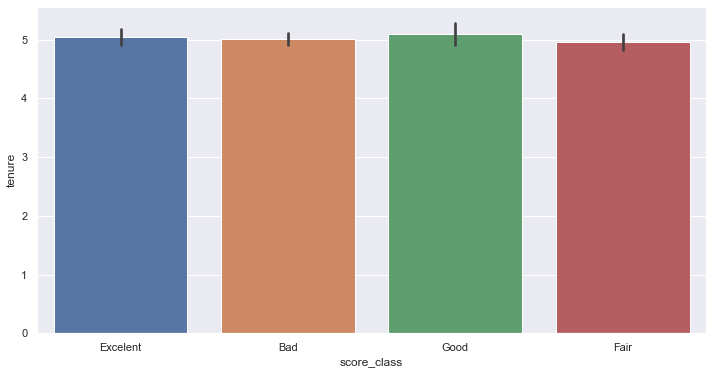

In [63]:
plt.figure(figsize=(12,6))
sns.barplot(y='tenure',x='score_class',data=train_set_3)

#### H1.6 Balance influences churn

TRUE. Clients with balance higher than 100000 churn more, specially between 100000 and 1500000.

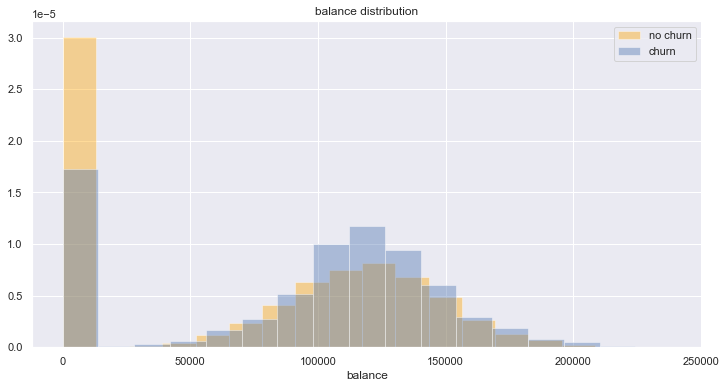

In [64]:
plt.figure(figsize=(12,6))
sns.distplot(aux1['balance'], color='orange', kde=False, label='no churn',norm_hist=True)
sns.distplot(aux2['balance'], kde=False, label='churn',norm_hist=True)
plt.title('balance distribution');
plt.legend();

#### H1.7 Clients with less products churn more and the number of products is affected by client's age, balance and salary.

There is a tendency that clients with more products churn more, however, the sample of customers that acquired 3 and 4 products is small. Regarding age, the average age of clients with 3 and 4 products is higher. The mean balance of clients with 2 products is much lower and clients with 2 products are the ones that churn less. On the other hand, the balance mean of clients with 1 product is the highest and clients with 1 product have a considerable churn. The estimated salary doesn't seem to have much influence in the number of products. However, for both balance and salary, the variance of values for 4 products is higher.

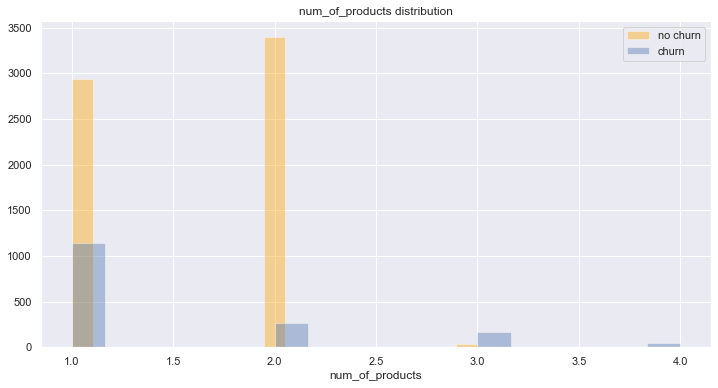

In [65]:
plt.figure(figsize=(12,6))
sns.distplot(aux1['num_of_products'], color='orange', kde=False, label='no churn')
sns.distplot(aux2['num_of_products'], kde=False, label='churn')
plt.title('num_of_products distribution');
plt.legend();

<AxesSubplot:xlabel='num_of_products', ylabel='age'>

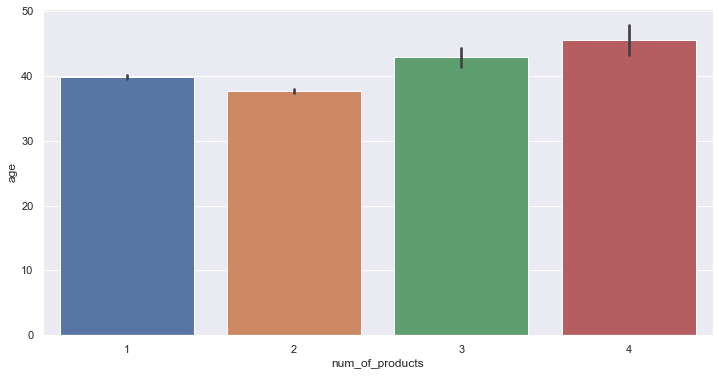

In [66]:
plt.figure(figsize=(12,6))
sns.barplot(y='age',x='num_of_products',data=train_set_3)



<AxesSubplot:xlabel='num_of_products', ylabel='balance'>

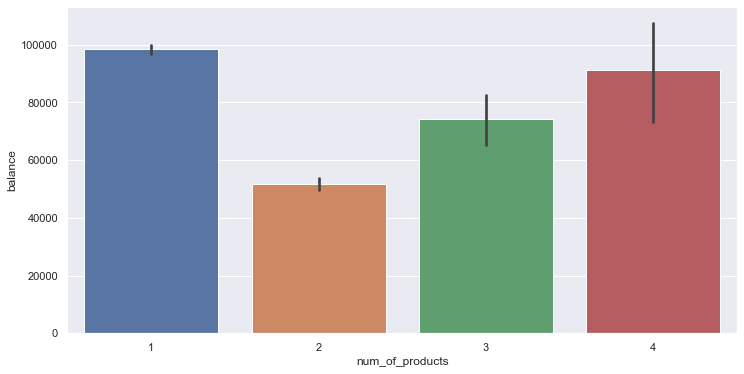

In [67]:
plt.figure(figsize=(12,6))
sns.barplot(y='balance',x='num_of_products',data=train_set_3)

<AxesSubplot:xlabel='num_of_products', ylabel='estimated_salary'>

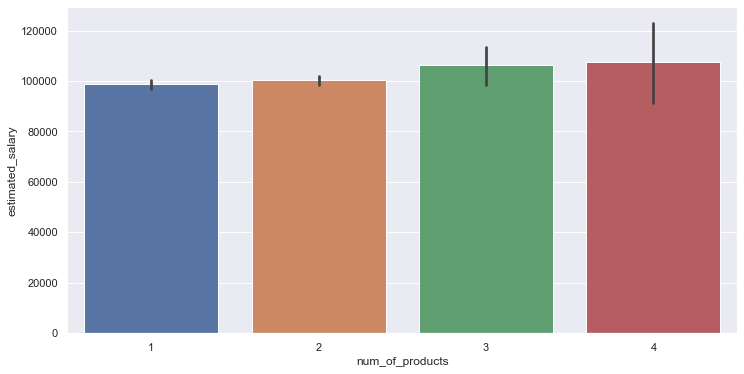

In [68]:
plt.figure(figsize=(12,6))
sns.barplot(y='estimated_salary',x='num_of_products',data=train_set_3)

#### H1.7 Clients with credit card churn 20% more

FALSE. Credit card do not influence much in churn, however, clients without credit card seem to churn a little less.

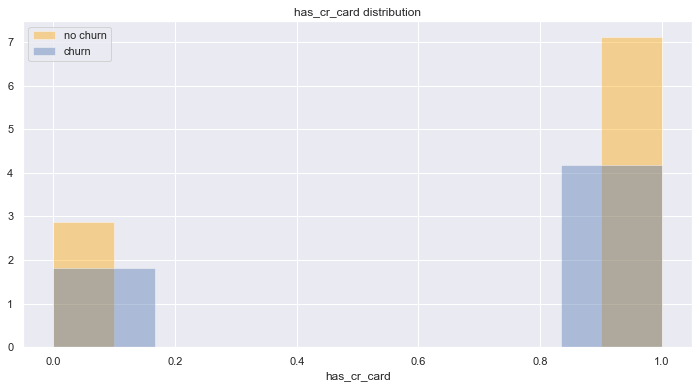

In [69]:
plt.figure(figsize=(12,6))
sns.distplot(aux1['has_cr_card'], color='orange', kde=False, label='no churn',norm_hist=True)
sns.distplot(aux2['has_cr_card'], kde=False, label='churn',norm_hist=True)
plt.title('has_cr_card distribution');
plt.legend();

<AxesSubplot:xlabel='has_cr_card', ylabel='exited'>

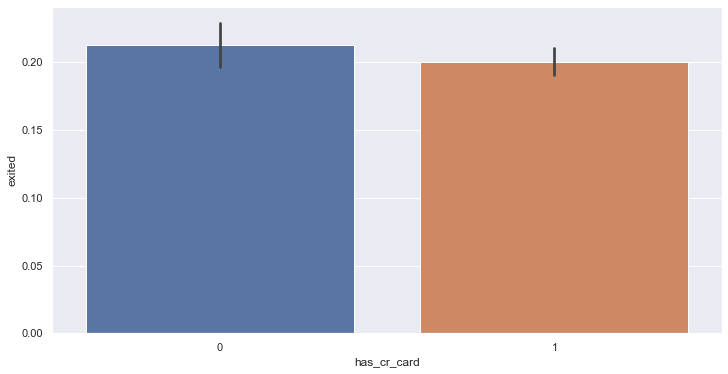

In [70]:
plt.figure(figsize=(12,6))
sns.barplot(y='exited',x='has_cr_card',data=train_set_3)

#### H1.8 Inactive clients approximately churn more than active

TRUE. Actually, inactive clients churn almost the double than active clients

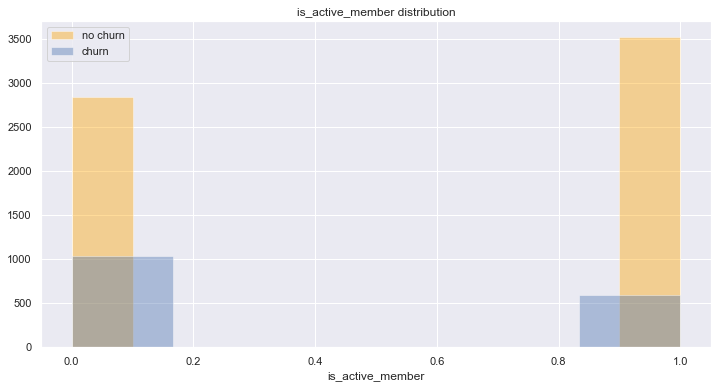

In [71]:
plt.figure(figsize=(12,6))
sns.distplot(aux1['is_active_member'], color='orange', kde=False, label='no churn')
sns.distplot(aux2['is_active_member'], kde=False, label='churn')
plt.title('is_active_member distribution');
plt.legend();

<AxesSubplot:xlabel='is_active_member', ylabel='exited'>

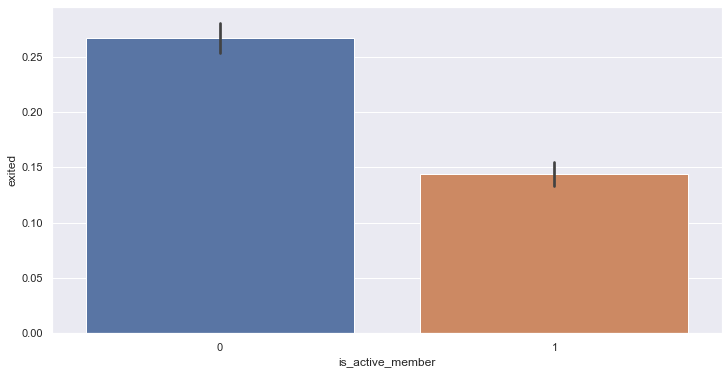

In [72]:
plt.figure(figsize=(12,6))
sns.barplot(y='exited',x='is_active_member',data=train_set_3)




In [73]:
pd.crosstab(train_set_3['is_active_member'], train_set_3['exited']).apply(lambda r: round((r/r.sum()*100),2), axis=1)

exited                   0         1
is_active_member                    
0                73.310000 26.690000
1                85.580000 14.420000

In [74]:
aux_active_mean = train_set_3.groupby("is_active_member").mean().reset_index()
aux_active_mean['Percentage'] = 100 * aux_active_mean['exited'] / aux_active_mean['exited'].sum()
aux_active_mean['Percentage']

0   64.925377
1   35.074623
Name: Percentage, dtype: float64

## 6.2.1 Hypothesis Summary

In [75]:
summary = pd.DataFrame({'Hypothesis':['Clients with higher estimated salary churn less.',
                                      'Clients from Germany have higher salaries and churn more.',
                                      'Clients with higher salaries and lower balance churn more.',
                                      'Clients with lower credit score churn more.',
                                      'Younger clients have worst median credit score.',
                                      'Clients over 75yo churn more.',
                                      'Clients with tenure less than 5 years churn 30% more than the rest',
                                      'Tenure varies with credit score',
                                      'Balance influences churn.',
                                      "Clients with less products churn more and the number of products is affected by client's age, balance and salary.",
                                      'Clients with credit card churn 20% more',
                                      'Inactive clients approximately churn more than active'
                                     ],
                        'True / False':['False', 'True', 'True', 'True', 'False', 'False', 'False', 'False', 'True', 'True',
                                        'False','True'], 
                        'Relevance':['Low', 'High', 'Medium', 'Low', 'Low', 'High', 'Low', 'Low', 'Low', 'High', 
                                     'Low','High']}, 
                        index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
summary

Hypothesis True / False Relevance
1   Clients with higher estimated salary churn less.                                                                   False        Low     
2   Clients from Germany have higher salaries and churn more.                                                          True         High    
3   Clients with higher salaries and lower balance churn more.                                                         True         Medium  
4   Clients with lower credit score churn more.                                                                        True         Low     
5   Younger clients have worst median credit score.                                                                    False        Low     
6   Clients over 75yo churn more.                                                                                      False        High    
7   Clients with tenure less than 5 years churn 30% more than the rest                                                 False        Low     
8   Tenure varies with credit score                                                                                    False        Low     
9   Balance influences churn.                                                                                          True         Low     
10  Clients with less products churn more and the number of products is affected by client's age, balance and salary.  True         High    
11  Clients with credit card churn 20% more                                                                            False        Low     
12  Inactive clients approximately churn more than active                                                              True         High

## 6.3 Multivariate Analysis - Correlation

In [76]:
num_attributes = train_set_3.select_dtypes( include = ['int64', 'float64','int32'])
cat_attributes = train_set_3.select_dtypes( include = 'object')

## 6.3.1 Numerical Variables

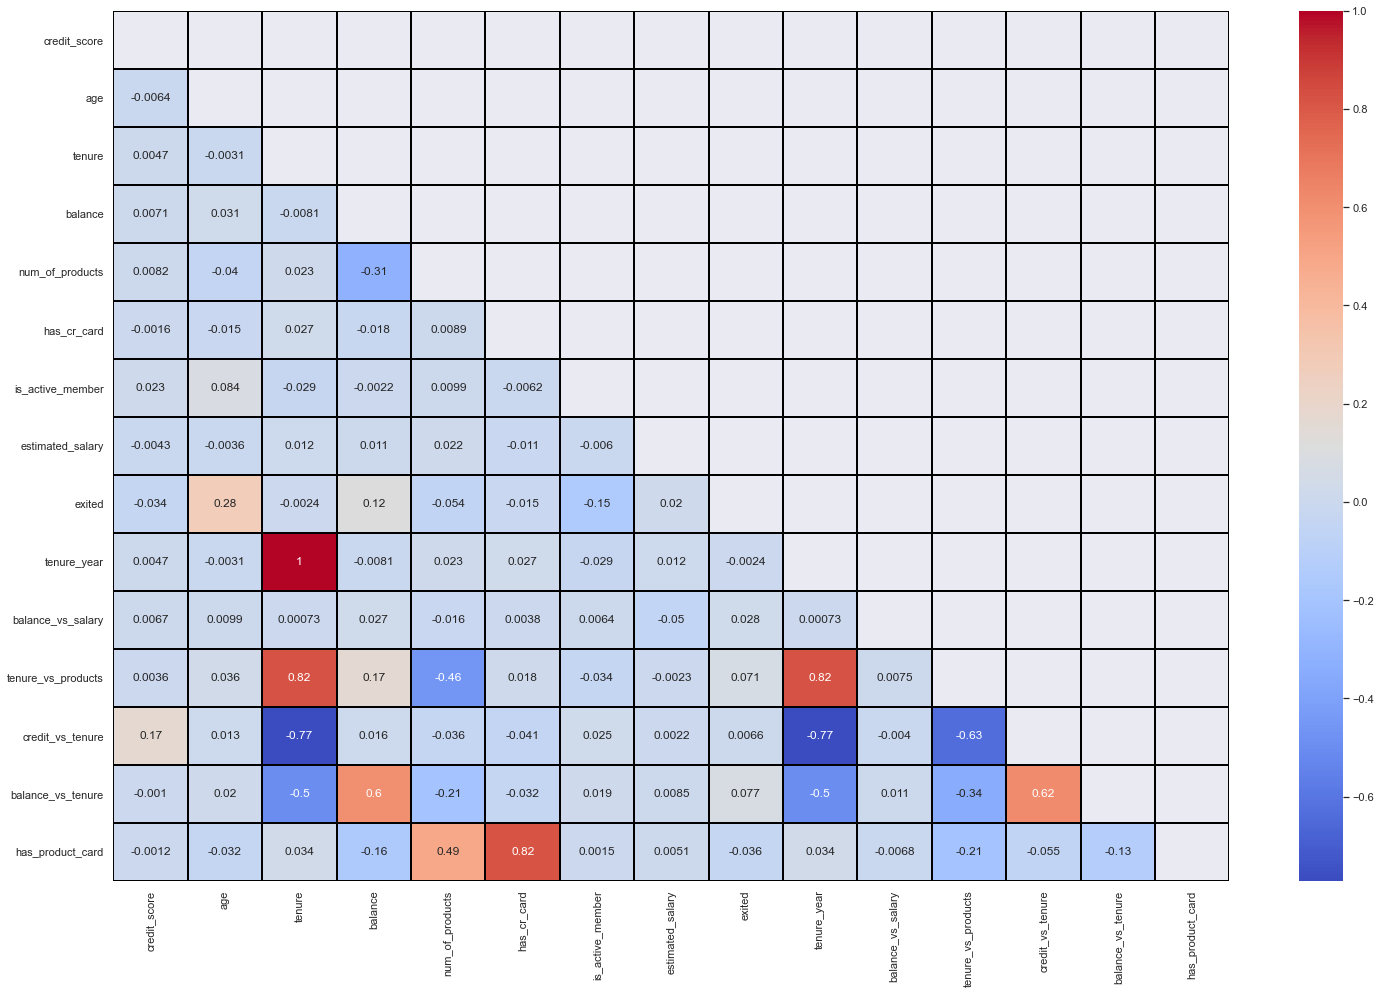

In [77]:
# gets the correlation between the numerical variables
correlation = num_attributes.corr(method='pearson')

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(25, 16)

# plots the heatmap
matrix = np.triu(correlation)

sns.heatmap(correlation, annot=True, cmap='coolwarm',linewidths=1, linecolor='black',mask=matrix)

# displays the plot
plt.show()

## 6.3.2 Categorical Variables

In [78]:
cat_attributes['has_cr_card_cat'] = train_set_3['has_cr_card'].apply(lambda x: 'Yes' if x == 1 else 'No')
cat_attributes['is_active_member_cat'] = train_set_3['is_active_member'].apply(lambda x: 'Yes' if x == 1 else 'No')
cat_attributes

geography  gender   age_class score_class has_cr_card_cat is_active_member_cat
2151  France    Male    Middle Age  Excelent    Yes             No                 
8392  Germany   Male    Adult       Excelent    Yes             No                 
5006  Germany   Female  Adult       Excelent    Yes             Yes                
4117  France    Male    Adult       Bad         Yes             No                 
7182  Germany   Male    Adult       Good        No              Yes                
...       ...    ...      ...        ...        ..              ...                
4555  Spain     Female  Adult       Fair        Yes             No                 
4644  Spain     Male    Middle Age  Good        No              No                 
8942  France    Female  Adult       Fair        Yes             Yes                
2935  Spain     Male    Adult       Fair        Yes             No                 
6206  Spain     Male    Middle Age  Excelent    No              Yes                

[8000 rows x 6 columns]

In [79]:
from scipy.stats import chi2_contingency

a1 = cramer_v(cat_attributes['geography'], cat_attributes['geography'])
a2 = cramer_v(cat_attributes['geography'], cat_attributes['gender'])
a3 = cramer_v(cat_attributes['geography'], cat_attributes['age_class'])
a4 = cramer_v(cat_attributes['geography'], cat_attributes['score_class'])
a5 = cramer_v(cat_attributes['geography'], cat_attributes['has_cr_card_cat'])
a6 = cramer_v(cat_attributes['geography'], cat_attributes['is_active_member_cat'])

a7 = cramer_v(cat_attributes['gender'], cat_attributes['geography'])
a8 = cramer_v(cat_attributes['gender'], cat_attributes['gender'])
a9 = cramer_v(cat_attributes['gender'], cat_attributes['age_class'])
a10 = cramer_v(cat_attributes['gender'], cat_attributes['score_class'])
a11 = cramer_v(cat_attributes['gender'], cat_attributes['has_cr_card_cat'])
a12 = cramer_v(cat_attributes['gender'], cat_attributes['is_active_member_cat'])

a13 = cramer_v(cat_attributes['age_class'], cat_attributes['geography'])
a14 = cramer_v(cat_attributes['age_class'], cat_attributes['gender'])
a15 = cramer_v(cat_attributes['age_class'], cat_attributes['age_class'])
a16 = cramer_v(cat_attributes['age_class'], cat_attributes['score_class'])
a17 = cramer_v(cat_attributes['age_class'], cat_attributes['has_cr_card_cat'])
a18 = cramer_v(cat_attributes['age_class'], cat_attributes['is_active_member_cat'])

a19 = cramer_v(cat_attributes['score_class'], cat_attributes['geography'])
a20 = cramer_v(cat_attributes['score_class'], cat_attributes['gender'])
a21 = cramer_v(cat_attributes['score_class'], cat_attributes['age_class'])
a22 = cramer_v(cat_attributes['score_class'], cat_attributes['score_class'])
a23 = cramer_v(cat_attributes['score_class'], cat_attributes['has_cr_card_cat'])
a24 = cramer_v(cat_attributes['score_class'], cat_attributes['is_active_member_cat'])

a25 = cramer_v(cat_attributes['has_cr_card_cat'], cat_attributes['geography'])
a26 = cramer_v(cat_attributes['has_cr_card_cat'], cat_attributes['gender'])
a27 = cramer_v(cat_attributes['has_cr_card_cat'], cat_attributes['age_class'])
a28 = cramer_v(cat_attributes['has_cr_card_cat'], cat_attributes['score_class'])
a29 = cramer_v(cat_attributes['has_cr_card_cat'], cat_attributes['has_cr_card_cat'])
a30 = cramer_v(cat_attributes['has_cr_card_cat'], cat_attributes['is_active_member_cat'])

a31 = cramer_v(cat_attributes['is_active_member_cat'], cat_attributes['geography'])
a32 = cramer_v(cat_attributes['is_active_member_cat'], cat_attributes['gender'])
a33 = cramer_v(cat_attributes['is_active_member_cat'], cat_attributes['age_class'])
a34 = cramer_v(cat_attributes['is_active_member_cat'], cat_attributes['score_class'])
a35 = cramer_v(cat_attributes['is_active_member_cat'], cat_attributes['has_cr_card_cat'])
a36 = cramer_v(cat_attributes['is_active_member_cat'], cat_attributes['is_active_member_cat'])

# builds the dataset to make the correlations
d = pd.DataFrame({'geography': [a1, a2, a3, a4, a5, a6],
                  'gender': [a7, a8, a9, a10, a11, a12],
                  'age_class': [a13, a14, a15, a16, a17, a18],
                  'score_class': [a19, a20, a21, a22, a23, a24],
                  'has_cr_card_cat': [a25, a26, a27, a28, a29, a30],
                  'is_active_member_cat': [a31, a32, a33, a34, a35, a36]
             })

# sets index equal to columns
d = d.set_index(d.columns)
d


geography   gender  age_class  score_class  has_cr_card_cat  is_active_member_cat
geography            1.000125   0.026415 0.034370   0.021925     0.013952         0.026819             
gender               0.026415   0.999810 0.015463   0.015145     0.002880         0.028017             
age_class            0.034370   0.015463 1.000188   0.017441     0.016970         0.113412             
score_class          0.021925   0.015145 0.017441   1.000188     0.003486         0.017406             
has_cr_card_cat      0.013952   0.002880 0.016970   0.003486     0.999760         0.005967             
is_active_member_cat 0.026819   0.028017 0.113412   0.017406     0.005967         0.999812

## 6.4 Conclusions

Numerical: remove tenure_year, credit_vs_tenure
Categorical: do not remove any feature

In [80]:
df3_drop_columns = ['tenure_year','credit_vs_tenure']
train_set_3 =train_set_3.drop(columns=df3_drop_columns,axis=1)
test_set_3 =test_set_3.drop(columns=df3_drop_columns,axis=1)

# 7. Data Preparation

In [81]:
train_set_4 = train_set_3.copy()
test_set_4 = test_set_3.copy()

In [82]:
test_set_4.sample(19)

credit_score geography  gender  age  tenure        balance  num_of_products  has_cr_card  is_active_member  estimated_salary  exited  balance_vs_salary  tenure_vs_products    age_class score_class  balance_vs_tenure  has_product_card
6373  597           France    Male    67   2      0.000000        2                0            1                108,645.850000     0      0.000000           1.000000             Middle Age   Bad        0.000000            0               
8524  711           France    Female  34   6      0.000000        2                1            1                175,310.380000     0      0.000000           3.000000             Adult        Good       0.000000            2               
6214  458           Germany   Male    35   9      146,780.520000  2                1            1                3,476.380000       0      42.222231          4.500000             Adult        Bad        14,678.052000       2               
9535  850           Spain     Male    41   8      132,838.070000  1                1            1                175,347.280000     0      0.757571           8.000000             Adult        Excelent   14,759.785556       1               
6008  767           Spain     Female  24   5      0.000000        2                1            1                67,445.850000      0      0.000000           2.500000             Young Adult  Excelent   0.000000            2               
709   686           France    Female  34   3      123,971.510000  2                1            0                147,794.630000     0      0.838809           1.500000             Adult        Fair       30,992.877500       2               
9982  655           Germany   Female  46   7      137,145.120000  1                1            0                115,146.400000     1      1.191050           7.000000             Adult        Fair       17,143.140000       1               
5854  481           France    Female  34   5      0.000000        2                1            1                125,253.460000     0      0.000000           2.500000             Adult        Bad        0.000000            2               
7023  524           Germany   Male    29   9      144,287.600000  2                1            0                32,063.300000      0      4.500086           4.500000             Young Adult  Bad        14,428.760000       2               
4349  686           Spain     Male    45   3      74,274.870000   3                1            0                64,907.480000      1      1.144319           1.000000             Adult        Fair       18,568.717500       3               
6864  593           Germany   Female  48   3      133,903.120000  2                1            1                85,902.390000      1      1.558782           1.500000             Adult        Bad        33,475.780000       2               
3802  615           Germany   Female  44   9      126,104.980000  2                0            1                110,718.020000     0      1.138974           4.500000             Adult        Bad        12,610.498000       0               
4192  632           France    Male    60   2      0.000000        2                0            1                2,085.320000       0      0.000000           1.000000             Middle Age   Fair       0.000000            0               
1166  622           Germany   Female  28   1      143,124.630000  2                1            0                81,723.800000      0      1.751321           0.500000             Young Adult  Bad        71,562.315000       2               
958   531           Spain     Male    27   8      132,576.250000  1                0            0                7,222.920000       0      18.354938          8.000000             Young Adult  Bad        14,730.694444       0               
6831  469           Germany   Female  52   8      139,493.250000  3                0            0                150,093.320000     1      0.929377           2.666667

## 7.1 Encoding Variables

In [83]:
# geography
train_set_4 = pd.get_dummies(train_set_4, columns = ['geography'])
test_set_4 = pd.get_dummies(test_set_4, columns = ['geography'])

# gender
train_set_4 = pd.get_dummies(train_set_4, columns = ['gender'],drop_first=True)
test_set_4 = pd.get_dummies(test_set_4, columns = ['gender'],drop_first=True)

# age_class
from sklearn.preprocessing import OrdinalEncoder
orde = OrdinalEncoder(categories=[['Young Adult','Adult','Middle Age','Old']])
train_set_4['age_class_encod'] = orde.fit_transform(train_set_4[['age_class']]).astype('int')
test_set_4['age_class_encod'] = orde.fit_transform(test_set_4[['age_class']]).astype('int')

# score_class
orde2 = OrdinalEncoder(categories=[['Bad','Fair','Good','Excelent']])
train_set_4['score_class_encod'] = orde2.fit_transform(train_set_4[['score_class']]).astype('int')
test_set_4['score_class_encod'] = orde2.fit_transform(test_set_4[['score_class']]).astype('int')

## 7.2 Creating Balanced Dataset

In [84]:
test_set_4_smt = test_set_4.copy()
from imblearn   import combine         as c

df4_drop_columns = ['age_class','score_class']
train_set_4 =train_set_4.drop(columns=df4_drop_columns,axis=1)
test_set_4 =test_set_4.drop(columns=df4_drop_columns,axis=1)
test_set_4_smt =test_set_4_smt.drop(columns=df4_drop_columns,axis=1)


# define sampler
smt = c.SMOTETomek( sampling_strategy='all', random_state=32, n_jobs=-1 )

# apply sampler
X_smt, y_smt = smt.fit_resample( train_set_4, train_set_4['exited'] )

In [85]:
X_smt.dtypes

credit_score          int64  
age                   int64  
tenure                int64  
balance               float64
num_of_products       int64  
has_cr_card           int64  
is_active_member      int64  
estimated_salary      float64
exited                int64  
balance_vs_salary     float64
tenure_vs_products    float64
balance_vs_tenure     float64
has_product_card      int64  
geography_France      uint8  
geography_Germany     uint8  
geography_Spain       uint8  
gender_Male           uint8  
age_class_encod       int32  
score_class_encod     int32  
dtype: object

## 7.3 Scalling Variables

In [86]:
rs = RobustScaler()
mms = MinMaxScaler()
ss =StandardScaler()

### 7.3.1 Balanced Dataset

In [87]:
X_smt['credit_score'] = ss.fit_transform( X_smt[['credit_score']].values )
test_set_4_smt['credit_score'] = ss.transform( test_set_4_smt[['credit_score']].values )

X_smt['num_of_products'] = ss.fit_transform( X_smt[['num_of_products']].values )
test_set_4_smt['num_of_products'] = ss.transform( test_set_4_smt[['num_of_products']].values )

X_smt['age'] = mms.fit_transform( X_smt[['age']].values )
test_set_4_smt['age'] = mms.transform( test_set_4_smt[['age']].values )

X_smt['tenure'] = mms.fit_transform( X_smt[['tenure']].values )
test_set_4_smt['tenure'] = mms.transform( test_set_4_smt[['tenure']].values )

X_smt['balance'] = rs.fit_transform( X_smt[['balance']].values )
test_set_4_smt['balance'] = rs.transform( test_set_4_smt[['balance']].values )

X_smt['estimated_salary'] = rs.fit_transform( X_smt[['estimated_salary']].values )
test_set_4_smt['estimated_salary'] = rs.transform( test_set_4_smt[['estimated_salary']].values )

X_smt['balance_vs_salary'] = rs.fit_transform( X_smt[['balance_vs_salary']].values )
test_set_4_smt['balance_vs_salary'] = rs.transform( test_set_4_smt[['balance_vs_salary']].values )

X_smt['tenure_vs_products'] = rs.fit_transform( X_smt[['tenure_vs_products']].values )
test_set_4_smt['tenure_vs_products'] = rs.transform( test_set_4_smt[['tenure_vs_products']].values )

X_smt['tenure'] = mms.fit_transform( X_smt[['tenure']].values )
test_set_4_smt['tenure'] = mms.transform( test_set_4_smt[['tenure']].values )

X_smt['balance_vs_tenure'] = rs.fit_transform( X_smt[['balance_vs_tenure']].values )
test_set_4_smt['balance_vs_tenure'] = rs.transform( test_set_4_smt[['balance_vs_tenure']].values )


### 7.3.2 Imbalanced Dataset

In [88]:
train_set_4['credit_score'] = ss.fit_transform( train_set_4[['credit_score']].values )
test_set_4['credit_score'] = ss.transform( test_set_4[['credit_score']].values )

train_set_4['num_of_products'] = ss.fit_transform( train_set_4[['num_of_products']].values )
test_set_4['num_of_products'] = ss.transform( test_set_4[['num_of_products']].values )

train_set_4['age'] = mms.fit_transform( train_set_4[['age']].values )
test_set_4['age'] = mms.transform( test_set_4[['age']].values )

train_set_4['tenure'] = mms.fit_transform( train_set_4[['tenure']].values )
test_set_4['tenure'] = mms.transform( test_set_4[['tenure']].values )
train_set_4
train_set_4['balance'] = rs.fit_transform( train_set_4[['balance']].values )
test_set_4['balance'] = rs.transform( test_set_4[['balance']].values )

train_set_4['estimated_salary'] = rs.fit_transform( train_set_4[['estimated_salary']].values )
test_set_4['estimated_salary'] = rs.transform( test_set_4[['estimated_salary']].values )

train_set_4['balance_vs_salary'] = rs.fit_transform( train_set_4[['balance_vs_salary']].values )
test_set_4['balance_vs_salary'] = rs.transform( test_set_4[['balance_vs_salary']].values )

train_set_4['tenure_vs_products'] = rs.fit_transform( train_set_4[['tenure_vs_products']].values )
test_set_4['tenure_vs_products'] = rs.transform( test_set_4[['tenure_vs_products']].values )

train_set_4['tenure'] = mms.fit_transform( train_set_4[['tenure']].values )
test_set_4['tenure'] = mms.transform( test_set_4[['tenure']].values )

train_set_4['balance_vs_tenure'] = rs.fit_transform( train_set_4[['balance_vs_tenure']].values )
test_set_4['balance_vs_tenure'] = rs.transform( test_set_4[['balance_vs_tenure']].values )


## 7.4 Final Datasets

In [89]:
X_smt=X_smt.drop(columns='exited',axis=1)
#y_smt
X_test_smt=test_set_4_smt.drop(columns='exited',axis=1)
y_test_smt=test_set_4_smt['exited']

X_train_imb = train_set_4.drop(columns='exited',axis=1)
y_train_imb = train_set_4['exited']
X_test_imb =test_set_4.drop(columns='exited',axis=1)
y_test_imb =test_set_4['exited']


X_smt.sample(10)

credit_score      age   tenure   balance  num_of_products  has_cr_card  is_active_member  estimated_salary  balance_vs_salary  tenure_vs_products  balance_vs_tenure  has_product_card  geography_France  geography_Germany  geography_Spain  gender_Male  age_class_encod  score_class_encod
184   0.668158      0.256757 0.500000 -0.813078 1.017905          1            0                0.136727          -0.506922          -0.265424           -0.574629           2                 1                 0                  0                0            1                2                
4255  -0.451622     0.283784 0.300000 -0.813078 1.017905          1            0                -0.523278         -0.506922          -0.530848           -0.574629           2                 1                 0                  0                0            1                0                
2467  -0.247047     0.256757 0.400000 0.288410  -0.724355         1            0                -0.675295         1.928816           0.132712            0.553256            1                 0                 1                  0                0            1                0                
8053  0.894268      0.486486 0.400000 -0.111504 -0.724355         1            1                -0.505646         0.551234           -0.132712           0.182728            1                 1                 0                  0                0            2                2                
10645 -0.343951     0.405405 0.500000 0.010547  -0.724355         0            0                -0.030735         0.149138           0.647701            0.052541            0                 0                 0                  0                1            1                0                
7674  0.086734      0.283784 0.100000 0.094251  -0.724355         1            1                -0.544792         0.978167           -0.663560           1.748053            1                 0                 1                  0                0            1                0                
2537  2.143254      0.256757 0.900000 0.056865  -0.724355         1            0                0.143790          0.083387           1.459833            -0.129234           1                 0                 0                  1                0            1                3                
1228  1.346487      0.094595 0.200000 0.235860  -0.724355         1            0                -0.288196         0.614968           -0.398136           1.215497            1                 1                 0                  0                1            0                3                
987   -0.774636     0.081081 0.300000 -0.813078 -0.724355         0            1                -0.238915         -0.506922          -0.132712           -0.574629           0                 1                 0                  0                1            0                0                
10374 1.001939      0.391892 0.600000 0.282541  -0.724355         1            0                -0.083478         0.413638           0.887930            0.129732            1                 0                 0                  0                0            0                2

# 8. Feature Selection

## 8.1 Boruta Feature Selection

### 8.1.1 Imbalanced Dataset

In [90]:
X_boruta_imb = X_train_imb.values
y_boruta_imb = y_train_imb.values.ravel()

In [91]:
rf = RandomForestClassifier()

boruta = BorutaPy(rf, n_estimators='auto')
boruta.fit(X_boruta_imb, y_boruta_imb)
cols_selected_boruta = boruta.support_.tolist()
columns_selected = X_smt.loc[:, cols_selected_boruta].columns.tolist() 

In [92]:
columns_selected #['age', 'balance', 'num_of_products', 'estimated_salary']

['age', 'balance', 'num_of_products', 'estimated_salary']

### 8.1.2 Balanced Dataset

In [93]:
X_boruta_bal = X_smt.values
y_boruta_bal = y_smt.values.ravel()

In [94]:
rf = RandomForestClassifier()

boruta = BorutaPy(rf, n_estimators='auto')
boruta.fit(X_boruta_bal, y_boruta_bal)
cols_selected_boruta = boruta.support_.tolist()
columns_selected = X_train_imb.loc[:, cols_selected_boruta].columns.tolist() 

In [95]:
columns_selected
#['credit_score', 'age', 'balance', 'num_of_products', 'is_active_member', 'estimated_salary', 'balance_vs_salary', 'tenure_vs_products', 'balance_vs_tenure', 'has_product_card', 'geography_France', 'geography_Spain', 'gender_Male']

['credit_score',
 'age',
 'balance',
 'num_of_products',
 'is_active_member',
 'estimated_salary',
 'balance_vs_salary',
 'tenure_vs_products',
 'balance_vs_tenure',
 'has_product_card',
 'geography_France',
 'geography_Spain',
 'gender_Male']

## 8.2 Random Forest Feature Importance

In [100]:
rf = RandomForestClassifier()
rf.fit(X_smt,y_smt)
rf.feature_importances_

rf2 = RandomForestClassifier()
rf2.fit(X_train_imb,y_train_imb)
rf2.feature_importances_

array([0.09605222, 0.17923737, 0.04185377, 0.08443924, 0.08852452,
       0.01096409, 0.04490597, 0.09738125, 0.0690761 , 0.04952502,
       0.07156683, 0.04887978, 0.01096388, 0.0210585 , 0.00996141,
       0.01724945, 0.03405212, 0.02430847])

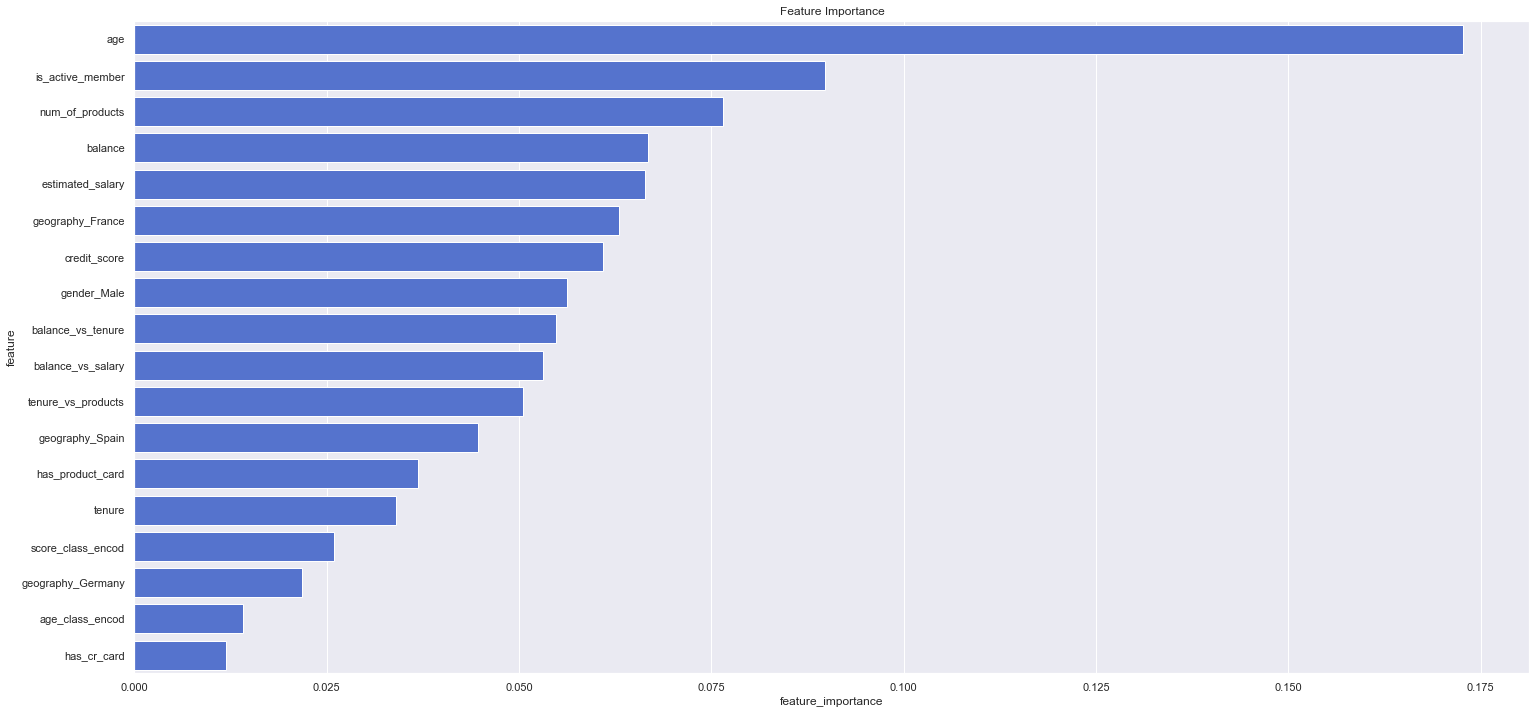

In [101]:
feat_imp = pd.DataFrame({'feature': X_smt.columns,
                        'feature_importance': rf.feature_importances_})\
                        .sort_values('feature_importance', ascending=False)\
                        .reset_index(drop=True)

sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', color='royalblue')\
    .set_title('Feature Importance');

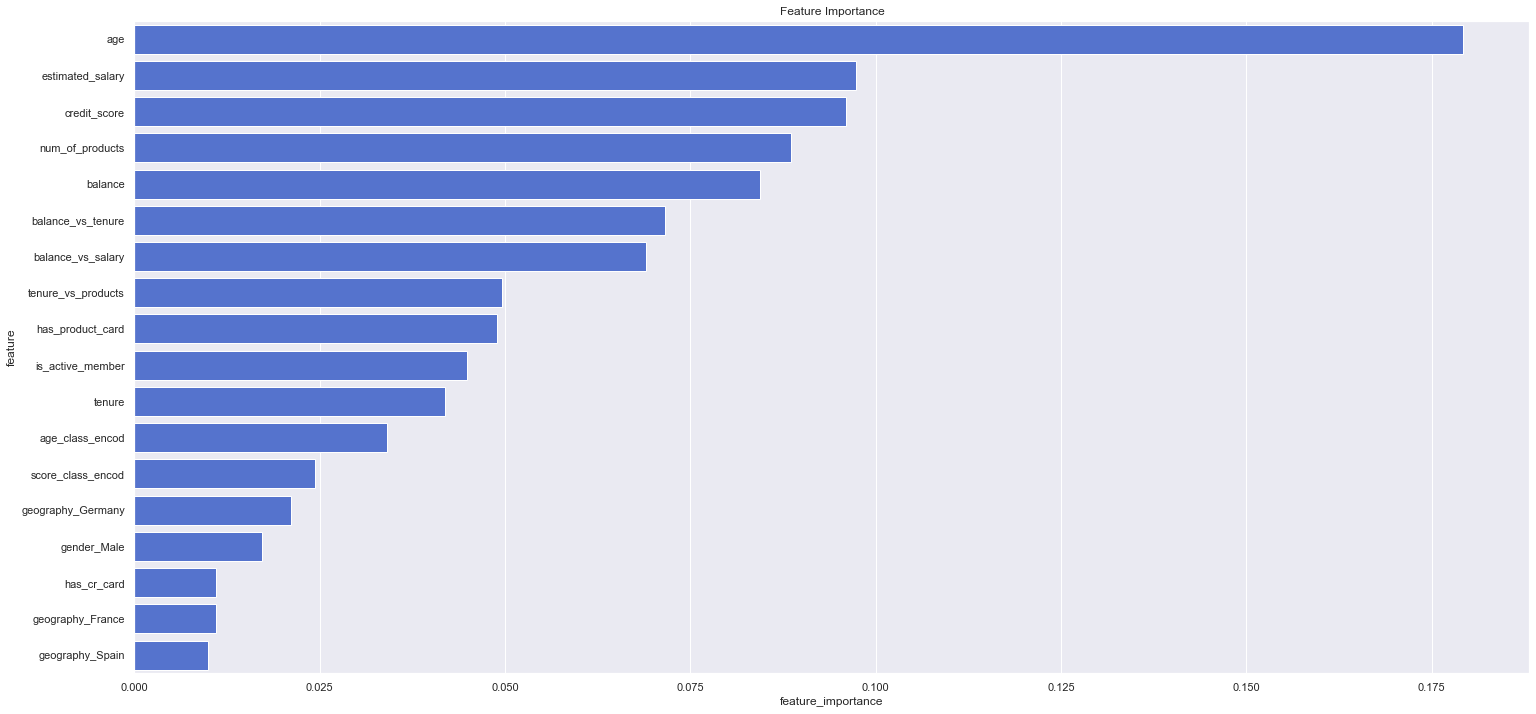

In [102]:
feat_imp = pd.DataFrame({'feature': X_train_imb.columns,
                        'feature_importance': rf2.feature_importances_})\
                        .sort_values('feature_importance', ascending=False)\
                        .reset_index(drop=True)

sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', color='royalblue')\
    .set_title('Feature Importance');

## 8.3 XGBoost

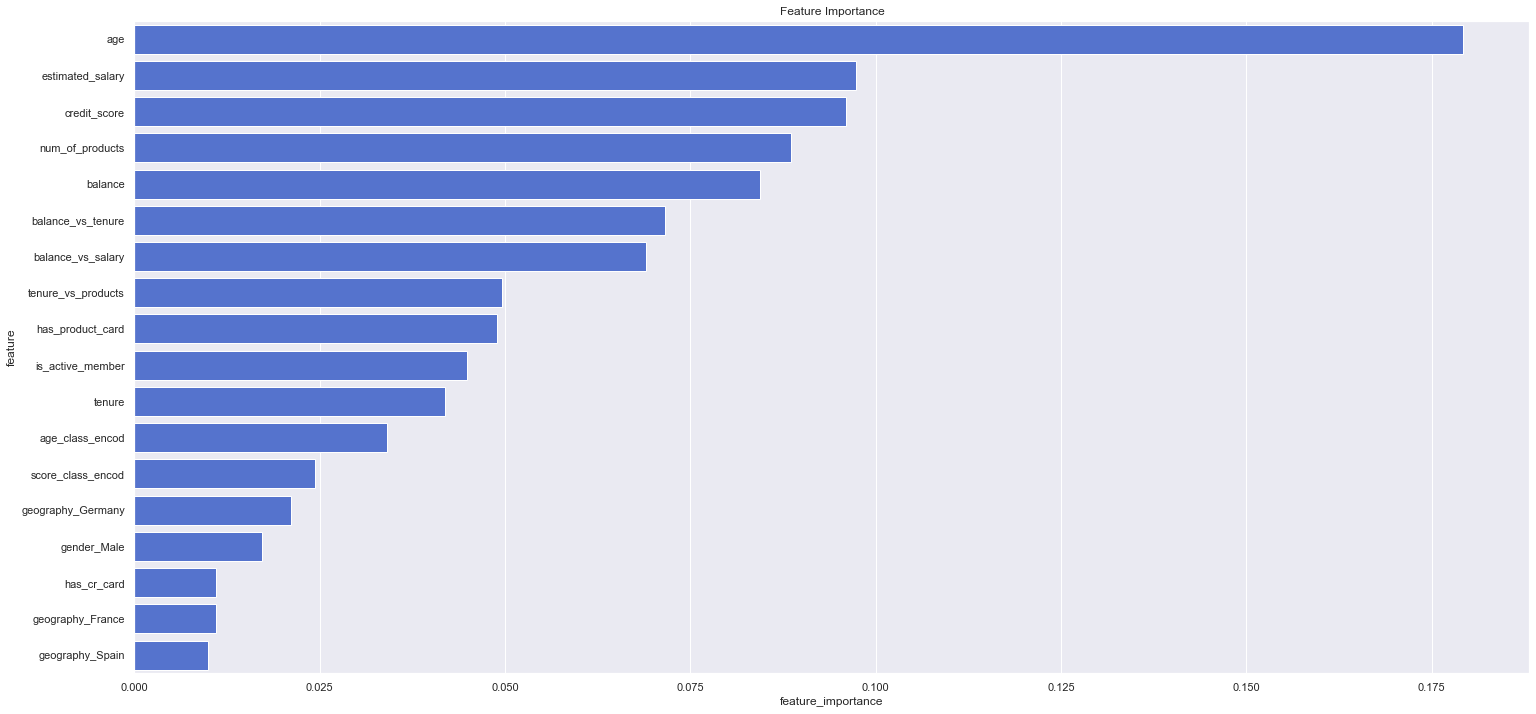

In [505]:
clf = XGBClassifier()
clf.fit(X_smt, y_smt)
features = (clf.feature_importances_)
feat_importances = pd.DataFrame({'feature importance': features, 'feature': X_smt.columns}).sort_values('feature importance',ascending=False).reset_index(drop=True)
sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', color='royalblue')\
    .set_title('Feature Importance');

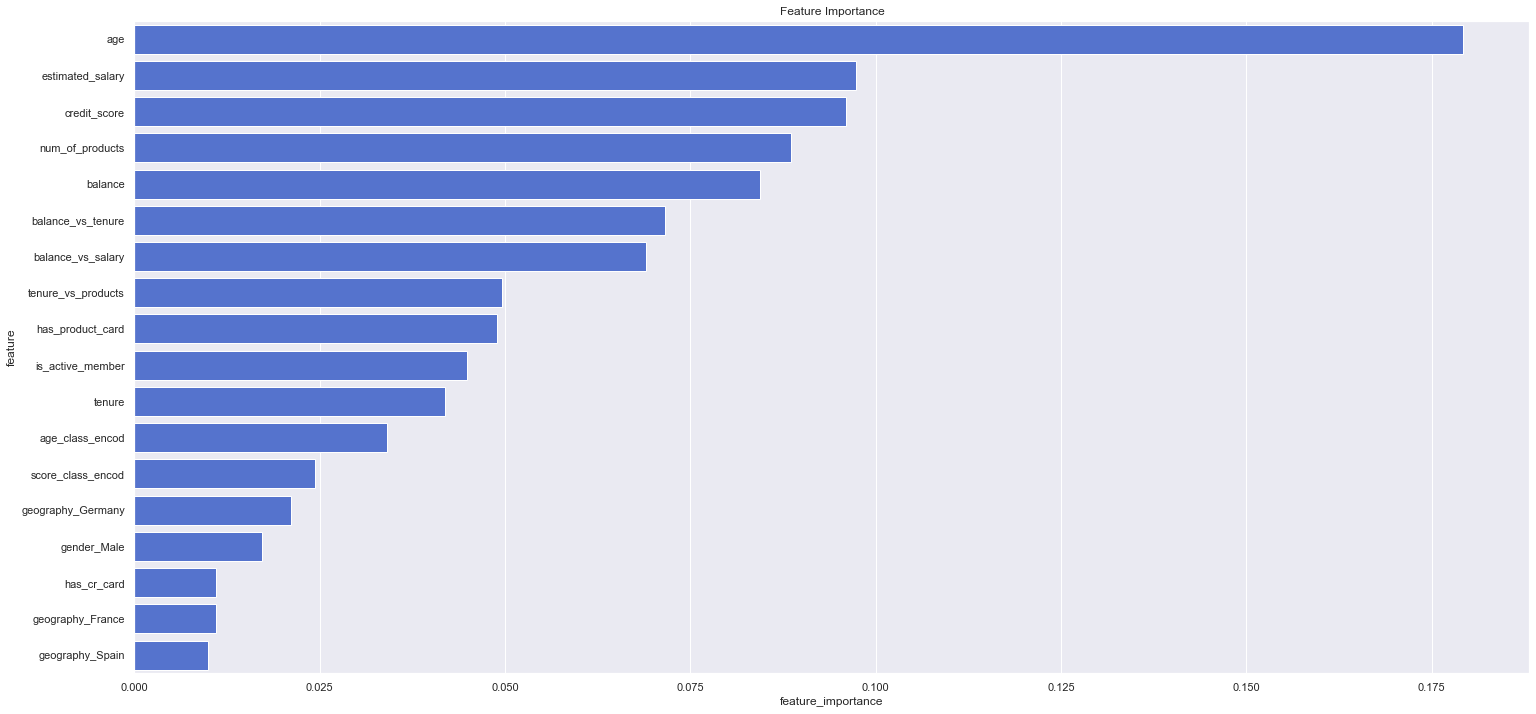

In [512]:
clf = XGBClassifier()
clf.fit(X_train_imb, y_train_imb)
features = (clf.feature_importances_)
feat_importances = pd.DataFrame({'feature importance': features, 'feature': X_train_imb.columns}).sort_values('feature importance',ascending=False).reset_index(drop=True)
sns.barplot(x='feature_importance', y='feature', data=feat_imp, orient='h', color='royalblue')\
    .set_title('Feature Importance');

# 9. Machine Learning Models

Datasets: balanced: X_smt, y_smt
          imbalanced: X_train_imb, y_train_imb

In [376]:
columns_selected = ['credit_score',
 'age',
 'balance',
 'num_of_products',
 'is_active_member',
 'estimated_salary',
 'balance_vs_salary',
 'tenure_vs_products',
 'balance_vs_tenure',
 'has_product_card',
 'geography_France',
 'geography_Spain',
 'gender_Male']


In [513]:
X_train_selected = X_smt[columns_selected]
X_test_selected = X_test_smt[columns_selected]

X_train_selected_2 = X_train_imb[columns_selected]
X_test_selected_2 = X_test_imb[columns_selected]

## 9.1 Baseline Model

In [391]:
bl = DummyClassifier()
bl.fit(X_train_selected, y_smt)
y_pred_bl = bl.predict(X_train_selected)
bl_results = ml_scores('Baseline', y_smt, y_pred_bl)
bl_results

Balanced Accuracy  Precision   Recall       F1  ROC_AUC    Kappa
Baseline 0.501000           0.501000   0.503000 0.502000 0.501000 0.001000

In [392]:
bl_cv_bal = performance(bl,X_train_selected,y_smt)
bl_cv_bal

test_accuracy  train_accuracy  test_precision  train_precision  test_recall  train_recall  test_f1_score  train_f1_score  test_roc_auc_score  train_roc_auc_score  test_mcc  train_mcc
0 0.501764       0.497777        0.501717        0.497772         0.514629     0.496396      0.507933       0.497075        0.501765            0.497777             0.003537  -0.004446

''

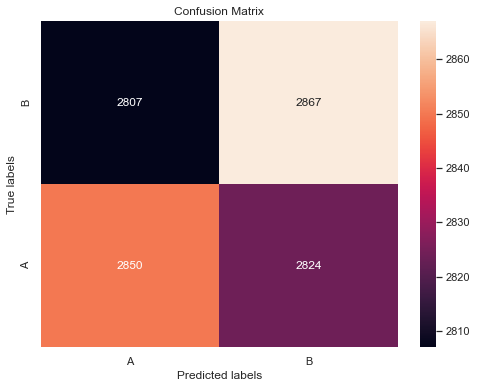

In [393]:
y_pred_bl_cv_bal = cross_val_predict(bl, X_train_selected, y_smt, cv=10)
cm = confusion_matrix(y_smt, y_pred_bl_cv_bal, labels = [0, 1])
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', ax = ax);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['A', 'B'])   
ax.yaxis.set_ticklabels(['B', 'A'])
;

In [394]:
bl2 = DummyClassifier()
bl2.fit(X_train_selected_2, y_train_imb)
y_pred_bl2 = bl2.predict(X_train_selected_2)
bl_results2 = ml_scores('Baseline', y_train_imb, y_pred_bl2)
bl_results2

Balanced Accuracy  Precision   Recall       F1  ROC_AUC    Kappa
Baseline 0.501000           0.206000   0.201000 0.204000 0.501000 0.003000

In [395]:
bl_cv_imb = performance(bl2,X_train_selected_2,y_train_imb)
bl_cv_imb

test_accuracy  train_accuracy  test_precision  train_precision  test_recall  train_recall  test_f1_score  train_f1_score  test_roc_auc_score  train_roc_auc_score  test_mcc  train_mcc
0 0.679000       0.676694        0.201468        0.202210         0.195706     0.199455      0.198450       0.200808        0.499187            0.499134             -0.002081 -0.001806

''

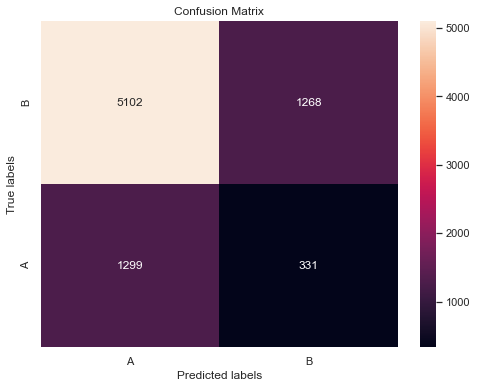

In [396]:
y_pred_bl_cv_imbal = cross_val_predict(bl, X_train_selected_2, y_train_imb, cv=10)
cm = confusion_matrix(y_train_imb, y_pred_bl_cv_imbal, labels = [0, 1])
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', ax = ax);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['A', 'B'])   
ax.yaxis.set_ticklabels(['B', 'A'])
;

## Logistic Regression

In [397]:
lg = LogisticRegression()
lg.fit(X_train_selected, y_smt)
y_pred_lg = lg.predict(X_train_selected)
lg_results = ml_scores('Logistic Regression', y_smt, y_pred_lg)
lg_results

Balanced Accuracy  Precision   Recall       F1  ROC_AUC    Kappa
Logistic Regression 0.805000           0.810000   0.798000 0.804000 0.805000 0.611000

In [398]:
lr_cv_bal = performance(lg,X_train_selected,y_smt)
lr_cv_bal

test_accuracy  train_accuracy  test_precision  train_precision  test_recall  train_recall  test_f1_score  train_f1_score  test_roc_auc_score  train_roc_auc_score  test_mcc  train_mcc
0 0.802882       0.805517        0.803005        0.810069         0.794774     0.798144      0.793960       0.804061        0.802924            0.805517             0.610808  0.611101

''

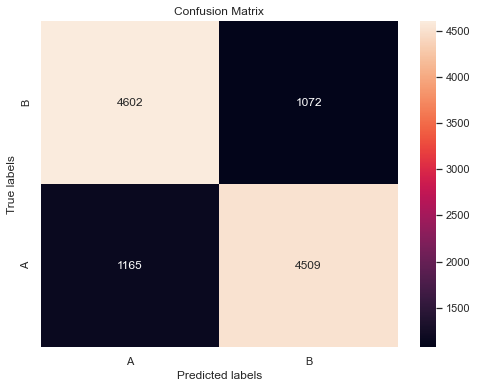

In [399]:
y_pred_lg_cv_bal = cross_val_predict(lg, X_train_selected, y_smt, cv=10)
cm = confusion_matrix(y_smt, y_pred_lg_cv_bal, labels = [0, 1])
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', ax = ax);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['A', 'B'])   
ax.yaxis.set_ticklabels(['B', 'A'])
;

In [400]:
lg2 = LogisticRegression()
lg2.fit(X_train_selected_2, y_train_imb)
y_pred_lg2 = lg2.predict(X_train_selected_2)
lg_results2 = ml_scores('Logistic Regression', y_train_imb, y_pred_lg2)
lg_results2

Balanced Accuracy  Precision   Recall       F1  ROC_AUC    Kappa
Logistic Regression 0.588000           0.615000   0.210000 0.314000 0.588000 0.234000

In [401]:
lr_cv_imb = performance(lg2,X_train_selected_2,y_train_imb)
lr_cv_imb

test_accuracy  train_accuracy  test_precision  train_precision  test_recall  train_recall  test_f1_score  train_f1_score  test_roc_auc_score  train_roc_auc_score  test_mcc  train_mcc
0 0.811750       0.812889        0.612923        0.619048         0.209202     0.212406      0.311394       0.316268        0.587568            0.589475             0.277229  0.282662

''

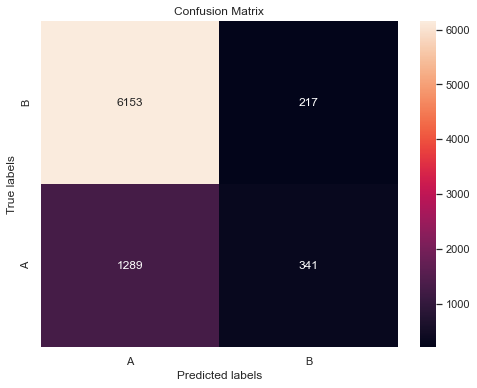

In [402]:
y_pred_lg_cv_imbal = cross_val_predict(lg2, X_train_selected_2, y_train_imb, cv=10)
cm = confusion_matrix(y_train_imb, y_pred_lg_cv_imbal, labels = [0, 1])
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', ax = ax);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['A', 'B'])   
ax.yaxis.set_ticklabels(['B', 'A'])
;

## 9.3 KNN

In [403]:
knn = KNeighborsClassifier()
knn.fit(X_train_selected, y_smt)
y_pred_knn = knn.predict(X_train_selected)
knn_results = ml_scores('K Nearest Neighbors', y_smt, y_pred_knn)
knn_results

Balanced Accuracy  Precision   Recall       F1  ROC_AUC    Kappa
K Nearest Neighbors 0.871000           0.856000   0.892000 0.874000 0.871000 0.742000

In [404]:
knn_cv_bal = performance(knn,X_train_selected,y_smt)
knn_cv_bal

test_accuracy  train_accuracy  test_precision  train_precision  test_recall  train_recall  test_f1_score  train_f1_score  test_roc_auc_score  train_roc_auc_score  test_mcc  train_mcc
0 0.805348       0.868582        0.786032        0.853666         0.834757     0.889653      0.807672       0.871276        0.805378            0.868582             0.615218  0.737845

''

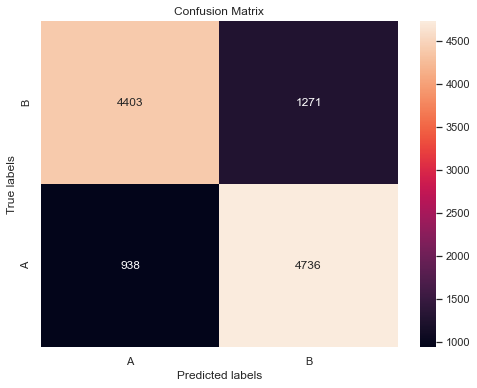

In [405]:
y_pred_knn_cv_bal = cross_val_predict(knn, X_train_selected, y_smt, cv=10)
cm = confusion_matrix(y_smt, y_pred_knn_cv_bal, labels = [0, 1])
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', ax = ax);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['A', 'B'])   
ax.yaxis.set_ticklabels(['B', 'A'])
;

In [406]:
knn2 = KNeighborsClassifier()
knn2.fit(X_train_selected_2, y_train_imb)
y_pred_knn2 = knn2.predict(X_train_selected_2)
knn_results2 = ml_scores('K Nearest Neighbors',y_train_imb, y_pred_knn2)
knn_results2

Balanced Accuracy  Precision   Recall       F1  ROC_AUC    Kappa
K Nearest Neighbors 0.700000           0.732000   0.442000 0.551000 0.700000 0.470000

In [407]:
knn_cv_imb = performance(knn2,X_train_selected_2,y_train_imb)
knn_cv_imb 

test_accuracy  train_accuracy  test_precision  train_precision  test_recall  train_recall  test_f1_score  train_f1_score  test_roc_auc_score  train_roc_auc_score  test_mcc  train_mcc
0 0.804875       0.853819        0.535712        0.734567         0.318405     0.442468      0.398107       0.552251        0.623881            0.700773             0.305566  0.492909

''

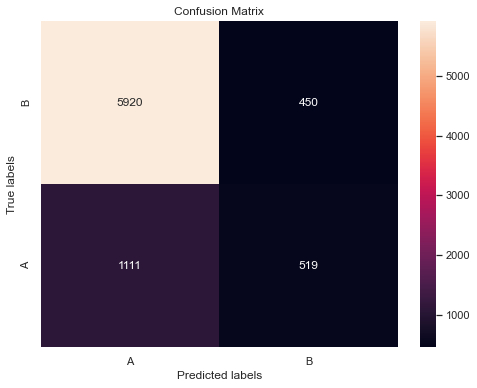

In [408]:
y_pred_knn_cv_imbal = cross_val_predict(knn2, X_train_selected_2, y_train_imb, cv=10)
cm = confusion_matrix(y_train_imb, y_pred_knn_cv_imbal, labels = [0, 1])
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', ax = ax);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['A', 'B'])   
ax.yaxis.set_ticklabels(['B', 'A'])
;

## 9.4 SVM

In [409]:
svm = SVC()
svm.fit(X_train_selected, y_smt)
y_pred_svm = svm.predict(X_train_selected)
svm_results = ml_scores('SVM', y_smt, y_pred_svm)
svm_results

Balanced Accuracy  Precision   Recall       F1  ROC_AUC    Kappa
SVM 0.731000           0.707000   0.789000 0.746000 0.731000 0.463000

In [410]:
svm_cv_bal = performance(svm,X_train_selected,y_smt)
svm_cv_bal

test_accuracy  train_accuracy  test_precision  train_precision  test_recall  train_recall  test_f1_score  train_f1_score  test_roc_auc_score  train_roc_auc_score  test_mcc  train_mcc
0 0.718813       0.726384        0.697861        0.704958         0.768851     0.785434      0.725270       0.742157        0.718857            0.726383             0.446932  0.456937

''

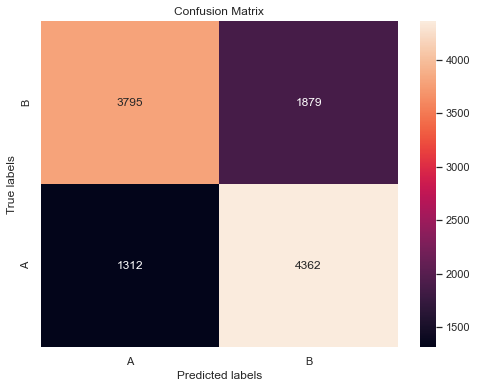

In [411]:
y_pred_svm_cv_bal = cross_val_predict(svm, X_train_selected, y_smt, cv=10)
cm = confusion_matrix(y_smt, y_pred_svm_cv_bal, labels = [0, 1])
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', ax = ax);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['A', 'B'])   
ax.yaxis.set_ticklabels(['B', 'A'])
;

In [412]:
svm2 = SVC()
svm2.fit(X_train_selected_2, y_train_imb)
y_pred_svm2 = svm.predict(X_train_selected_2)
svm_results2 = ml_scores('SVM', y_train_imb, y_pred_svm2)
svm_results2

Balanced Accuracy  Precision   Recall       F1  ROC_AUC    Kappa
SVM 0.637000           0.306000   0.652000 0.417000 0.637000 0.193000

In [413]:
svm_cv_imb = performance(svm2,X_train_selected_2,y_train_imb)
svm_cv_imb

test_accuracy  train_accuracy  test_precision  train_precision  test_recall  train_recall  test_f1_score  train_f1_score  test_roc_auc_score  train_roc_auc_score  test_mcc  train_mcc
0 0.796125       0.796639        0.000000        0.980000         0.000000     0.001977      0.000000       0.003945        0.499922            0.500980             -0.001790 0.038745

''

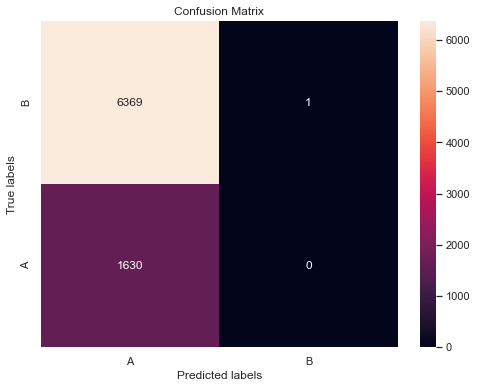

In [414]:
y_pred_svm_cv_imbal = cross_val_predict(svm2, X_train_selected_2, y_train_imb, cv=10)
cm = confusion_matrix(y_train_imb, y_pred_svm_cv_imbal, labels = [0, 1])
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', ax = ax);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['A', 'B'])   
ax.yaxis.set_ticklabels(['B', 'A'])
;

## 9.5 XGBoost

In [415]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_selected, y_smt)
y_pred_xgb = xgb.predict(X_train_selected)
xgb_results = ml_scores('XGB', y_smt, y_pred_xgb)
xgb_results

Balanced Accuracy  Precision   Recall       F1  ROC_AUC    Kappa
XGB 0.975000           0.986000   0.963000 0.974000 0.975000 0.949000

In [416]:
xgb_cv_bal = performance(xgb,X_train_selected,y_smt)

''

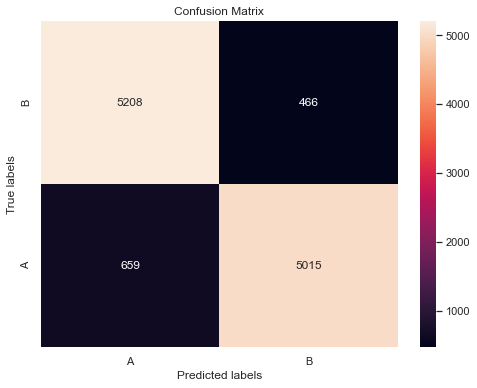

In [417]:
y_pred_xgb_cv_bal = cross_val_predict(xgb, X_train_selected, y_smt, cv=10)
cm = confusion_matrix(y_smt, y_pred_xgb_cv_bal, labels = [0, 1])
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', ax = ax);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['A', 'B'])   
ax.yaxis.set_ticklabels(['B', 'A'])
;

In [418]:
xgb2 = XGBClassifier(random_state=42)
xgb2.fit(X_train_selected_2, y_train_imb)
y_pred_xgb2 = xgb2.predict(X_train_selected_2)
xgb_results2 = ml_scores('XGB', y_train_imb, y_pred_xgb2)
xgb_results2

Balanced Accuracy  Precision   Recall       F1  ROC_AUC    Kappa
XGB 0.924000           0.983000   0.852000 0.913000 0.924000 0.893000

In [419]:
xgb_cv_imb = performance(xgb2,X_train_selected_2,y_train_imb)
xgb_cv_imb

test_accuracy  train_accuracy  test_precision  train_precision  test_recall  train_recall  test_f1_score  train_f1_score  test_roc_auc_score  train_roc_auc_score  test_mcc  train_mcc
0 0.854000       0.969431        0.708691        0.982560         0.481595     0.865303      0.573010       0.920163        0.715444            0.930689             0.502401  0.904173

''

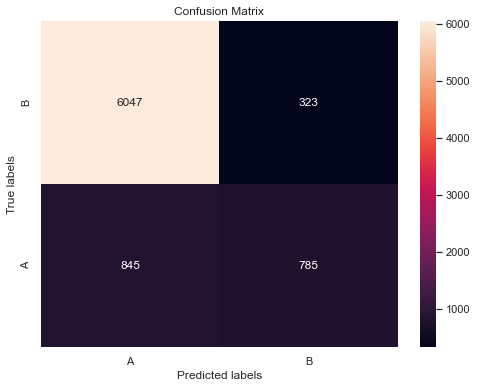

In [420]:
y_pred_xgb_cv_imbal = cross_val_predict(xgb2, X_train_selected_2, y_train_imb, cv=10)
cm = confusion_matrix(y_train_imb, y_pred_xgb_cv_imbal, labels = [0, 1])
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', ax = ax);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['A', 'B'])   
ax.yaxis.set_ticklabels(['B', 'A'])
;

## 9.6 Random Florest

In [421]:
rf = RandomForestClassifier()
rf.fit(X_train_selected, y_smt)
y_pred_rf = rf.predict(X_train_selected)
rf_results = ml_scores('Random Forest', y_smt, y_pred_rf)
rf_results

Balanced Accuracy  Precision   Recall       F1  ROC_AUC    Kappa
Random Forest 1.000000           1.000000   1.000000 1.000000 1.000000 1.000000

In [422]:
rf_cv_bal = performance(rf,X_train_selected,y_smt)
rf_cv_bal

test_accuracy  train_accuracy  test_precision  train_precision  test_recall  train_recall  test_f1_score  train_f1_score  test_roc_auc_score  train_roc_auc_score  test_mcc  train_mcc
0 0.879545       0.999990        0.882464        0.999980         0.873359     1.000000      0.874763       0.999990        0.879580            0.999990             0.763392  0.999980

''

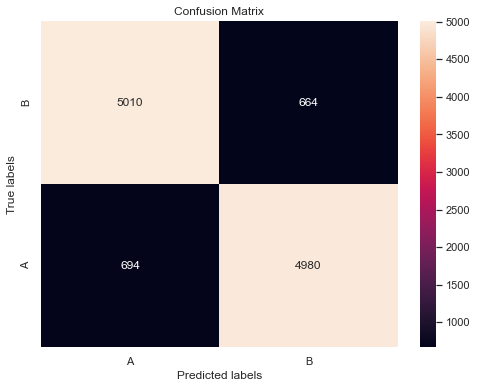

In [423]:
y_pred_rf_cv_bal = cross_val_predict(rf, X_train_selected, y_smt, cv=10)
cm = confusion_matrix(y_smt, y_pred_rf_cv_bal, labels = [0, 1])
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', ax = ax);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['A', 'B'])   
ax.yaxis.set_ticklabels(['B', 'A'])
;

In [424]:
rf2 = RandomForestClassifier()
rf2.fit(X_train_selected_2, y_train_imb)
y_pred_rf2 = rf2.predict(X_train_selected_2)
rf_results2 = ml_scores('Random Forest', y_train_imb, y_pred_rf2)
rf_results2

Balanced Accuracy  Precision   Recall       F1  ROC_AUC    Kappa
Random Forest 1.000000           1.000000   1.000000 1.000000 1.000000 1.000000

In [425]:
rf_cv_imb = performance(rf2,X_train_selected_2,y_train_imb)
rf_cv_imb 

test_accuracy  train_accuracy  test_precision  train_precision  test_recall  train_recall  test_f1_score  train_f1_score  test_roc_auc_score  train_roc_auc_score  test_mcc  train_mcc
0 0.861500       0.999958        0.772506        1.000000         0.453988     0.999796      0.570996       0.999898        0.709882            0.999898             0.520496  0.999872

''

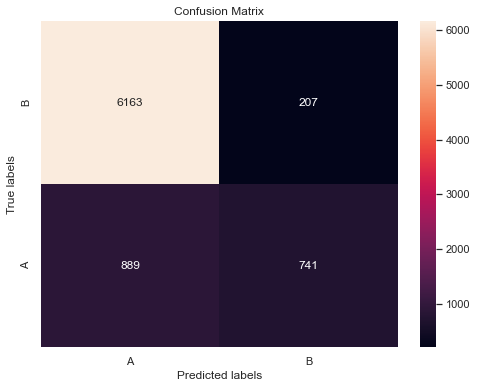

In [426]:
y_pred_rf_cv_imbal = cross_val_predict(rf2, X_train_selected_2, y_train_imb, cv=10)
cm = confusion_matrix(y_train_imb, y_pred_rf_cv_imbal, labels = [0, 1])
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', ax = ax);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['A', 'B'])   
ax.yaxis.set_ticklabels(['B', 'A'])
;

## 9.7 CatBoost

In [427]:
cat = CatBoostClassifier()
cat.fit(X_train_selected, y_smt)
y_pred_cat = cat.predict(X_train_selected)
cat_results = ml_scores('CatBoost', y_smt, y_pred_cat)
cat_results

Learning rate set to 0.029066
0:	learn: 0.6720114	total: 45.7ms	remaining: 45.6s
1:	learn: 0.6530804	total: 88.8ms	remaining: 44.3s
2:	learn: 0.6346091	total: 131ms	remaining: 43.6s
3:	learn: 0.6200089	total: 176ms	remaining: 43.8s
4:	learn: 0.6057951	total: 220ms	remaining: 43.8s
5:	learn: 0.5923043	total: 264ms	remaining: 43.8s
6:	learn: 0.5777701	total: 307ms	remaining: 43.5s
7:	learn: 0.5649212	total: 348ms	remaining: 43.1s
8:	learn: 0.5537239	total: 390ms	remaining: 42.9s
9:	learn: 0.5427581	total: 434ms	remaining: 43s
10:	learn: 0.5318136	total: 477ms	remaining: 42.9s
11:	learn: 0.5233868	total: 517ms	remaining: 42.6s
12:	learn: 0.5152848	total: 561ms	remaining: 42.6s
13:	learn: 0.5074829	total: 603ms	remaining: 42.5s
14:	learn: 0.4996605	total: 648ms	remaining: 42.6s
15:	learn: 0.4924901	total: 693ms	remaining: 42.6s
16:	learn: 0.4852868	total: 738ms	remaining: 42.7s
17:	learn: 0.4790153	total: 780ms	remaining: 42.5s
18:	learn: 0.4736332	total: 823ms	remaining: 42.5s
19:	learn: 

163:	learn: 0.3186520	total: 6.34s	remaining: 32.3s
164:	learn: 0.3184805	total: 6.38s	remaining: 32.3s
165:	learn: 0.3178617	total: 6.42s	remaining: 32.3s
166:	learn: 0.3177013	total: 6.46s	remaining: 32.2s
167:	learn: 0.3175132	total: 6.5s	remaining: 32.2s
168:	learn: 0.3170560	total: 6.54s	remaining: 32.1s
169:	learn: 0.3167869	total: 6.58s	remaining: 32.1s
170:	learn: 0.3164929	total: 6.62s	remaining: 32.1s
171:	learn: 0.3162808	total: 6.66s	remaining: 32.1s
172:	learn: 0.3159592	total: 6.7s	remaining: 32s
173:	learn: 0.3152183	total: 6.74s	remaining: 32s
174:	learn: 0.3149025	total: 6.78s	remaining: 32s
175:	learn: 0.3145616	total: 6.82s	remaining: 31.9s
176:	learn: 0.3137518	total: 6.86s	remaining: 31.9s
177:	learn: 0.3135274	total: 6.89s	remaining: 31.8s
178:	learn: 0.3133421	total: 6.93s	remaining: 31.8s
179:	learn: 0.3129829	total: 6.96s	remaining: 31.7s
180:	learn: 0.3127111	total: 7s	remaining: 31.7s
181:	learn: 0.3123661	total: 7.04s	remaining: 31.6s
182:	learn: 0.3118369	t

325:	learn: 0.2693949	total: 12.6s	remaining: 26.1s
326:	learn: 0.2692357	total: 12.7s	remaining: 26.1s
327:	learn: 0.2691279	total: 12.7s	remaining: 26s
328:	learn: 0.2689010	total: 12.7s	remaining: 26s
329:	learn: 0.2686577	total: 12.8s	remaining: 26s
330:	learn: 0.2684169	total: 12.8s	remaining: 25.9s
331:	learn: 0.2682574	total: 12.9s	remaining: 25.9s
332:	learn: 0.2680425	total: 12.9s	remaining: 25.8s
333:	learn: 0.2676613	total: 12.9s	remaining: 25.8s
334:	learn: 0.2671230	total: 13s	remaining: 25.8s
335:	learn: 0.2668841	total: 13s	remaining: 25.7s
336:	learn: 0.2667020	total: 13.1s	remaining: 25.7s
337:	learn: 0.2664138	total: 13.1s	remaining: 25.7s
338:	learn: 0.2655312	total: 13.1s	remaining: 25.6s
339:	learn: 0.2653670	total: 13.2s	remaining: 25.6s
340:	learn: 0.2651870	total: 13.2s	remaining: 25.5s
341:	learn: 0.2649725	total: 13.2s	remaining: 25.5s
342:	learn: 0.2647559	total: 13.3s	remaining: 25.4s
343:	learn: 0.2644825	total: 13.3s	remaining: 25.4s
344:	learn: 0.2643383	

486:	learn: 0.2329927	total: 18.7s	remaining: 19.7s
487:	learn: 0.2327593	total: 18.8s	remaining: 19.7s
488:	learn: 0.2326505	total: 18.8s	remaining: 19.6s
489:	learn: 0.2325175	total: 18.8s	remaining: 19.6s
490:	learn: 0.2324203	total: 18.9s	remaining: 19.6s
491:	learn: 0.2322789	total: 18.9s	remaining: 19.5s
492:	learn: 0.2320047	total: 19s	remaining: 19.5s
493:	learn: 0.2318997	total: 19s	remaining: 19.5s
494:	learn: 0.2317596	total: 19s	remaining: 19.4s
495:	learn: 0.2316046	total: 19.1s	remaining: 19.4s
496:	learn: 0.2314602	total: 19.1s	remaining: 19.3s
497:	learn: 0.2313255	total: 19.2s	remaining: 19.3s
498:	learn: 0.2311063	total: 19.2s	remaining: 19.3s
499:	learn: 0.2310322	total: 19.2s	remaining: 19.2s
500:	learn: 0.2308736	total: 19.3s	remaining: 19.2s
501:	learn: 0.2307049	total: 19.3s	remaining: 19.1s
502:	learn: 0.2305157	total: 19.3s	remaining: 19.1s
503:	learn: 0.2303072	total: 19.4s	remaining: 19.1s
504:	learn: 0.2301346	total: 19.4s	remaining: 19s
505:	learn: 0.230013

646:	learn: 0.2105080	total: 25s	remaining: 13.6s
647:	learn: 0.2104331	total: 25s	remaining: 13.6s
648:	learn: 0.2102818	total: 25.1s	remaining: 13.6s
649:	learn: 0.2101781	total: 25.1s	remaining: 13.5s
650:	learn: 0.2100611	total: 25.1s	remaining: 13.5s
651:	learn: 0.2099719	total: 25.2s	remaining: 13.4s
652:	learn: 0.2098507	total: 25.2s	remaining: 13.4s
653:	learn: 0.2097400	total: 25.3s	remaining: 13.4s
654:	learn: 0.2096293	total: 25.3s	remaining: 13.3s
655:	learn: 0.2095622	total: 25.3s	remaining: 13.3s
656:	learn: 0.2094483	total: 25.4s	remaining: 13.2s
657:	learn: 0.2093615	total: 25.4s	remaining: 13.2s
658:	learn: 0.2092949	total: 25.4s	remaining: 13.2s
659:	learn: 0.2089791	total: 25.5s	remaining: 13.1s
660:	learn: 0.2089213	total: 25.5s	remaining: 13.1s
661:	learn: 0.2088059	total: 25.6s	remaining: 13s
662:	learn: 0.2087385	total: 25.6s	remaining: 13s
663:	learn: 0.2086633	total: 25.6s	remaining: 13s
664:	learn: 0.2085743	total: 25.7s	remaining: 12.9s
665:	learn: 0.2085219	

809:	learn: 0.1925686	total: 31.1s	remaining: 7.29s
810:	learn: 0.1925142	total: 31.1s	remaining: 7.25s
811:	learn: 0.1924299	total: 31.1s	remaining: 7.21s
812:	learn: 0.1923544	total: 31.2s	remaining: 7.17s
813:	learn: 0.1922709	total: 31.2s	remaining: 7.13s
814:	learn: 0.1922054	total: 31.2s	remaining: 7.09s
815:	learn: 0.1921362	total: 31.3s	remaining: 7.05s
816:	learn: 0.1920274	total: 31.3s	remaining: 7.01s
817:	learn: 0.1919526	total: 31.3s	remaining: 6.97s
818:	learn: 0.1918437	total: 31.4s	remaining: 6.93s
819:	learn: 0.1917546	total: 31.4s	remaining: 6.9s
820:	learn: 0.1916907	total: 31.5s	remaining: 6.86s
821:	learn: 0.1916249	total: 31.5s	remaining: 6.82s
822:	learn: 0.1915037	total: 31.5s	remaining: 6.78s
823:	learn: 0.1914435	total: 31.6s	remaining: 6.74s
824:	learn: 0.1913695	total: 31.6s	remaining: 6.7s
825:	learn: 0.1912676	total: 31.6s	remaining: 6.66s
826:	learn: 0.1911275	total: 31.7s	remaining: 6.62s
827:	learn: 0.1910563	total: 31.7s	remaining: 6.59s
828:	learn: 0.

971:	learn: 0.1782472	total: 37.1s	remaining: 1.07s
972:	learn: 0.1781946	total: 37.2s	remaining: 1.03s
973:	learn: 0.1781303	total: 37.2s	remaining: 993ms
974:	learn: 0.1780370	total: 37.2s	remaining: 955ms
975:	learn: 0.1779291	total: 37.3s	remaining: 917ms
976:	learn: 0.1778802	total: 37.3s	remaining: 878ms
977:	learn: 0.1777663	total: 37.3s	remaining: 840ms
978:	learn: 0.1776742	total: 37.4s	remaining: 802ms
979:	learn: 0.1775967	total: 37.4s	remaining: 764ms
980:	learn: 0.1775458	total: 37.5s	remaining: 726ms
981:	learn: 0.1774724	total: 37.5s	remaining: 687ms
982:	learn: 0.1773583	total: 37.5s	remaining: 649ms
983:	learn: 0.1772661	total: 37.6s	remaining: 611ms
984:	learn: 0.1772278	total: 37.6s	remaining: 573ms
985:	learn: 0.1771528	total: 37.6s	remaining: 535ms
986:	learn: 0.1770467	total: 37.7s	remaining: 496ms
987:	learn: 0.1769696	total: 37.7s	remaining: 458ms
988:	learn: 0.1769169	total: 37.8s	remaining: 420ms
989:	learn: 0.1768328	total: 37.8s	remaining: 382ms
990:	learn: 

Balanced Accuracy  Precision   Recall       F1  ROC_AUC    Kappa
CatBoost 0.941000           0.956000   0.924000 0.940000 0.941000 0.881000

In [428]:
cat_cv_bal = performance(cat,X_train_selected,y_smt)
cat_cv_bal

Learning rate set to 0.027787
0:	learn: 0.6704394	total: 42.1ms	remaining: 42.1s
1:	learn: 0.6494072	total: 82.1ms	remaining: 41s
2:	learn: 0.6302245	total: 124ms	remaining: 41.3s
3:	learn: 0.6132757	total: 163ms	remaining: 40.7s
4:	learn: 0.5983386	total: 206ms	remaining: 41s
5:	learn: 0.5848856	total: 244ms	remaining: 40.4s
6:	learn: 0.5695459	total: 282ms	remaining: 40s
7:	learn: 0.5561267	total: 320ms	remaining: 39.7s
8:	learn: 0.5450032	total: 357ms	remaining: 39.3s
9:	learn: 0.5334760	total: 394ms	remaining: 39s
10:	learn: 0.5243639	total: 432ms	remaining: 38.9s
11:	learn: 0.5147022	total: 469ms	remaining: 38.6s
12:	learn: 0.5059478	total: 507ms	remaining: 38.5s
13:	learn: 0.4978364	total: 543ms	remaining: 38.2s
14:	learn: 0.4894716	total: 579ms	remaining: 38s
15:	learn: 0.4813549	total: 617ms	remaining: 38s
16:	learn: 0.4732882	total: 654ms	remaining: 37.8s
17:	learn: 0.4665778	total: 698ms	remaining: 38.1s
18:	learn: 0.4606184	total: 736ms	remaining: 38s
19:	learn: 0.4566350	to

161:	learn: 0.2963667	total: 6s	remaining: 31s
162:	learn: 0.2954381	total: 6.03s	remaining: 31s
163:	learn: 0.2951390	total: 6.07s	remaining: 30.9s
164:	learn: 0.2948612	total: 6.1s	remaining: 30.9s
165:	learn: 0.2946767	total: 6.14s	remaining: 30.9s
166:	learn: 0.2944302	total: 6.18s	remaining: 30.8s
167:	learn: 0.2941774	total: 6.21s	remaining: 30.8s
168:	learn: 0.2938529	total: 6.25s	remaining: 30.7s
169:	learn: 0.2935227	total: 6.28s	remaining: 30.7s
170:	learn: 0.2930814	total: 6.32s	remaining: 30.6s
171:	learn: 0.2928742	total: 6.36s	remaining: 30.6s
172:	learn: 0.2923296	total: 6.39s	remaining: 30.6s
173:	learn: 0.2921892	total: 6.44s	remaining: 30.6s
174:	learn: 0.2916830	total: 6.49s	remaining: 30.6s
175:	learn: 0.2907735	total: 6.53s	remaining: 30.6s
176:	learn: 0.2905676	total: 6.57s	remaining: 30.5s
177:	learn: 0.2901320	total: 6.61s	remaining: 30.5s
178:	learn: 0.2896796	total: 6.64s	remaining: 30.5s
179:	learn: 0.2893161	total: 6.68s	remaining: 30.4s
180:	learn: 0.289126

321:	learn: 0.2493333	total: 11.9s	remaining: 25s
322:	learn: 0.2492164	total: 11.9s	remaining: 25s
323:	learn: 0.2489135	total: 12s	remaining: 25s
324:	learn: 0.2484383	total: 12s	remaining: 24.9s
325:	learn: 0.2482950	total: 12s	remaining: 24.9s
326:	learn: 0.2481213	total: 12.1s	remaining: 24.9s
327:	learn: 0.2476409	total: 12.1s	remaining: 24.8s
328:	learn: 0.2474835	total: 12.1s	remaining: 24.8s
329:	learn: 0.2467592	total: 12.2s	remaining: 24.7s
330:	learn: 0.2464077	total: 12.2s	remaining: 24.7s
331:	learn: 0.2462126	total: 12.3s	remaining: 24.7s
332:	learn: 0.2459954	total: 12.3s	remaining: 24.6s
333:	learn: 0.2458218	total: 12.3s	remaining: 24.6s
334:	learn: 0.2456635	total: 12.4s	remaining: 24.5s
335:	learn: 0.2448658	total: 12.4s	remaining: 24.5s
336:	learn: 0.2446447	total: 12.4s	remaining: 24.5s
337:	learn: 0.2445243	total: 12.5s	remaining: 24.4s
338:	learn: 0.2443694	total: 12.5s	remaining: 24.4s
339:	learn: 0.2440275	total: 12.5s	remaining: 24.4s
340:	learn: 0.2439169	to

482:	learn: 0.2043361	total: 18.1s	remaining: 19.3s
483:	learn: 0.2042325	total: 18.1s	remaining: 19.3s
484:	learn: 0.2040614	total: 18.1s	remaining: 19.2s
485:	learn: 0.2039505	total: 18.2s	remaining: 19.2s
486:	learn: 0.2037837	total: 18.2s	remaining: 19.2s
487:	learn: 0.2036881	total: 18.2s	remaining: 19.1s
488:	learn: 0.2035367	total: 18.3s	remaining: 19.1s
489:	learn: 0.2034203	total: 18.3s	remaining: 19.1s
490:	learn: 0.2032943	total: 18.3s	remaining: 19s
491:	learn: 0.2031798	total: 18.4s	remaining: 19s
492:	learn: 0.2031099	total: 18.4s	remaining: 18.9s
493:	learn: 0.2030128	total: 18.5s	remaining: 18.9s
494:	learn: 0.2028571	total: 18.5s	remaining: 18.9s
495:	learn: 0.2027453	total: 18.5s	remaining: 18.8s
496:	learn: 0.2025753	total: 18.6s	remaining: 18.8s
497:	learn: 0.2024053	total: 18.6s	remaining: 18.8s
498:	learn: 0.2023081	total: 18.7s	remaining: 18.7s
499:	learn: 0.2021929	total: 18.7s	remaining: 18.7s
500:	learn: 0.2020251	total: 18.7s	remaining: 18.7s
501:	learn: 0.20

643:	learn: 0.1810919	total: 24.2s	remaining: 13.4s
644:	learn: 0.1809826	total: 24.3s	remaining: 13.4s
645:	learn: 0.1808413	total: 24.3s	remaining: 13.3s
646:	learn: 0.1807391	total: 24.3s	remaining: 13.3s
647:	learn: 0.1806123	total: 24.4s	remaining: 13.2s
648:	learn: 0.1804716	total: 24.4s	remaining: 13.2s
649:	learn: 0.1803982	total: 24.5s	remaining: 13.2s
650:	learn: 0.1801586	total: 24.5s	remaining: 13.1s
651:	learn: 0.1800394	total: 24.5s	remaining: 13.1s
652:	learn: 0.1798786	total: 24.6s	remaining: 13.1s
653:	learn: 0.1797454	total: 24.6s	remaining: 13s
654:	learn: 0.1796041	total: 24.7s	remaining: 13s
655:	learn: 0.1795445	total: 24.7s	remaining: 12.9s
656:	learn: 0.1793816	total: 24.7s	remaining: 12.9s
657:	learn: 0.1792511	total: 24.8s	remaining: 12.9s
658:	learn: 0.1791707	total: 24.8s	remaining: 12.8s
659:	learn: 0.1789655	total: 24.9s	remaining: 12.8s
660:	learn: 0.1788649	total: 24.9s	remaining: 12.8s
661:	learn: 0.1787764	total: 24.9s	remaining: 12.7s
662:	learn: 0.17

802:	learn: 0.1623641	total: 30.4s	remaining: 7.45s
803:	learn: 0.1623020	total: 30.4s	remaining: 7.41s
804:	learn: 0.1622064	total: 30.4s	remaining: 7.37s
805:	learn: 0.1621199	total: 30.5s	remaining: 7.33s
806:	learn: 0.1620337	total: 30.5s	remaining: 7.3s
807:	learn: 0.1619323	total: 30.6s	remaining: 7.26s
808:	learn: 0.1618926	total: 30.6s	remaining: 7.22s
809:	learn: 0.1618006	total: 30.6s	remaining: 7.19s
810:	learn: 0.1616968	total: 30.7s	remaining: 7.15s
811:	learn: 0.1614678	total: 30.7s	remaining: 7.11s
812:	learn: 0.1613586	total: 30.8s	remaining: 7.08s
813:	learn: 0.1612825	total: 30.8s	remaining: 7.04s
814:	learn: 0.1611350	total: 30.8s	remaining: 7s
815:	learn: 0.1610391	total: 30.9s	remaining: 6.96s
816:	learn: 0.1609731	total: 30.9s	remaining: 6.93s
817:	learn: 0.1608837	total: 31s	remaining: 6.9s
818:	learn: 0.1607434	total: 31s	remaining: 6.86s
819:	learn: 0.1606253	total: 31.1s	remaining: 6.83s
820:	learn: 0.1605800	total: 31.1s	remaining: 6.79s
821:	learn: 0.1605365

961:	learn: 0.1481954	total: 36.9s	remaining: 1.46s
962:	learn: 0.1478932	total: 36.9s	remaining: 1.42s
963:	learn: 0.1477540	total: 37s	remaining: 1.38s
964:	learn: 0.1476155	total: 37s	remaining: 1.34s
965:	learn: 0.1474763	total: 37.1s	remaining: 1.3s
966:	learn: 0.1473847	total: 37.1s	remaining: 1.26s
967:	learn: 0.1472578	total: 37.1s	remaining: 1.23s
968:	learn: 0.1470465	total: 37.2s	remaining: 1.19s
969:	learn: 0.1469668	total: 37.2s	remaining: 1.15s
970:	learn: 0.1468559	total: 37.3s	remaining: 1.11s
971:	learn: 0.1466485	total: 37.3s	remaining: 1.07s
972:	learn: 0.1465541	total: 37.3s	remaining: 1.03s
973:	learn: 0.1465018	total: 37.4s	remaining: 998ms
974:	learn: 0.1464049	total: 37.4s	remaining: 959ms
975:	learn: 0.1462986	total: 37.4s	remaining: 921ms
976:	learn: 0.1462306	total: 37.5s	remaining: 882ms
977:	learn: 0.1461406	total: 37.5s	remaining: 844ms
978:	learn: 0.1460708	total: 37.6s	remaining: 806ms
979:	learn: 0.1460164	total: 37.6s	remaining: 767ms
980:	learn: 0.145

122:	learn: 0.3128610	total: 5.3s	remaining: 37.8s
123:	learn: 0.3123899	total: 5.37s	remaining: 37.9s
124:	learn: 0.3120673	total: 5.42s	remaining: 37.9s
125:	learn: 0.3117814	total: 5.46s	remaining: 37.9s
126:	learn: 0.3113857	total: 5.5s	remaining: 37.8s
127:	learn: 0.3108555	total: 5.54s	remaining: 37.8s
128:	learn: 0.3105941	total: 5.58s	remaining: 37.7s
129:	learn: 0.3102475	total: 5.62s	remaining: 37.6s
130:	learn: 0.3098661	total: 5.66s	remaining: 37.5s
131:	learn: 0.3094197	total: 5.7s	remaining: 37.5s
132:	learn: 0.3085987	total: 5.74s	remaining: 37.4s
133:	learn: 0.3079360	total: 5.78s	remaining: 37.3s
134:	learn: 0.3076402	total: 5.82s	remaining: 37.3s
135:	learn: 0.3070618	total: 5.86s	remaining: 37.2s
136:	learn: 0.3066287	total: 5.89s	remaining: 37.1s
137:	learn: 0.3061913	total: 5.93s	remaining: 37.1s
138:	learn: 0.3058020	total: 5.97s	remaining: 37s
139:	learn: 0.3054970	total: 6.02s	remaining: 37s
140:	learn: 0.3049978	total: 6.06s	remaining: 36.9s
141:	learn: 0.30443

283:	learn: 0.2560236	total: 11.6s	remaining: 29.2s
284:	learn: 0.2558893	total: 11.6s	remaining: 29.2s
285:	learn: 0.2556254	total: 11.7s	remaining: 29.1s
286:	learn: 0.2554377	total: 11.7s	remaining: 29.1s
287:	learn: 0.2545938	total: 11.7s	remaining: 29s
288:	learn: 0.2541853	total: 11.8s	remaining: 29s
289:	learn: 0.2540038	total: 11.8s	remaining: 28.9s
290:	learn: 0.2538496	total: 11.9s	remaining: 28.9s
291:	learn: 0.2530454	total: 11.9s	remaining: 28.8s
292:	learn: 0.2526242	total: 11.9s	remaining: 28.8s
293:	learn: 0.2520955	total: 12s	remaining: 28.7s
294:	learn: 0.2518964	total: 12s	remaining: 28.7s
295:	learn: 0.2518022	total: 12s	remaining: 28.7s
296:	learn: 0.2516665	total: 12.1s	remaining: 28.6s
297:	learn: 0.2513641	total: 12.1s	remaining: 28.6s
298:	learn: 0.2512775	total: 12.2s	remaining: 28.5s
299:	learn: 0.2511344	total: 12.2s	remaining: 28.5s
300:	learn: 0.2507784	total: 12.2s	remaining: 28.4s
301:	learn: 0.2506341	total: 12.3s	remaining: 28.4s
302:	learn: 0.2504259	

442:	learn: 0.2110899	total: 17.5s	remaining: 22s
443:	learn: 0.2105426	total: 17.5s	remaining: 22s
444:	learn: 0.2102003	total: 17.6s	remaining: 21.9s
445:	learn: 0.2100737	total: 17.6s	remaining: 21.9s
446:	learn: 0.2099390	total: 17.6s	remaining: 21.8s
447:	learn: 0.2095183	total: 17.7s	remaining: 21.8s
448:	learn: 0.2092598	total: 17.7s	remaining: 21.7s
449:	learn: 0.2089878	total: 17.8s	remaining: 21.7s
450:	learn: 0.2088532	total: 17.8s	remaining: 21.6s
451:	learn: 0.2087337	total: 17.8s	remaining: 21.6s
452:	learn: 0.2085890	total: 17.9s	remaining: 21.6s
453:	learn: 0.2084571	total: 17.9s	remaining: 21.5s
454:	learn: 0.2082176	total: 17.9s	remaining: 21.5s
455:	learn: 0.2080163	total: 18s	remaining: 21.4s
456:	learn: 0.2078683	total: 18s	remaining: 21.4s
457:	learn: 0.2077351	total: 18s	remaining: 21.3s
458:	learn: 0.2075791	total: 18.1s	remaining: 21.3s
459:	learn: 0.2074583	total: 18.1s	remaining: 21.2s
460:	learn: 0.2073216	total: 18.1s	remaining: 21.2s
461:	learn: 0.2071198	

601:	learn: 0.1867427	total: 23.2s	remaining: 15.4s
602:	learn: 0.1866316	total: 23.3s	remaining: 15.3s
603:	learn: 0.1865480	total: 23.3s	remaining: 15.3s
604:	learn: 0.1863730	total: 23.3s	remaining: 15.2s
605:	learn: 0.1862969	total: 23.4s	remaining: 15.2s
606:	learn: 0.1861829	total: 23.4s	remaining: 15.2s
607:	learn: 0.1861162	total: 23.4s	remaining: 15.1s
608:	learn: 0.1859567	total: 23.5s	remaining: 15.1s
609:	learn: 0.1859016	total: 23.5s	remaining: 15s
610:	learn: 0.1857853	total: 23.6s	remaining: 15s
611:	learn: 0.1857272	total: 23.6s	remaining: 15s
612:	learn: 0.1852873	total: 23.6s	remaining: 14.9s
613:	learn: 0.1848865	total: 23.7s	remaining: 14.9s
614:	learn: 0.1845179	total: 23.7s	remaining: 14.8s
615:	learn: 0.1844202	total: 23.7s	remaining: 14.8s
616:	learn: 0.1842964	total: 23.8s	remaining: 14.8s
617:	learn: 0.1839610	total: 23.8s	remaining: 14.7s
618:	learn: 0.1838242	total: 23.9s	remaining: 14.7s
619:	learn: 0.1837137	total: 23.9s	remaining: 14.6s
620:	learn: 0.1836

762:	learn: 0.1668339	total: 29s	remaining: 9.02s
763:	learn: 0.1667537	total: 29.1s	remaining: 8.98s
764:	learn: 0.1666440	total: 29.1s	remaining: 8.94s
765:	learn: 0.1663512	total: 29.1s	remaining: 8.9s
766:	learn: 0.1662456	total: 29.2s	remaining: 8.86s
767:	learn: 0.1661699	total: 29.2s	remaining: 8.82s
768:	learn: 0.1660974	total: 29.2s	remaining: 8.79s
769:	learn: 0.1659703	total: 29.3s	remaining: 8.75s
770:	learn: 0.1658448	total: 29.3s	remaining: 8.71s
771:	learn: 0.1656096	total: 29.4s	remaining: 8.67s
772:	learn: 0.1654805	total: 29.4s	remaining: 8.63s
773:	learn: 0.1653312	total: 29.4s	remaining: 8.59s
774:	learn: 0.1652438	total: 29.5s	remaining: 8.55s
775:	learn: 0.1651680	total: 29.5s	remaining: 8.51s
776:	learn: 0.1650667	total: 29.5s	remaining: 8.47s
777:	learn: 0.1649614	total: 29.6s	remaining: 8.43s
778:	learn: 0.1648622	total: 29.6s	remaining: 8.4s
779:	learn: 0.1647692	total: 29.6s	remaining: 8.36s
780:	learn: 0.1646401	total: 29.7s	remaining: 8.32s
781:	learn: 0.16

922:	learn: 0.1515282	total: 35s	remaining: 2.92s
923:	learn: 0.1513776	total: 35.1s	remaining: 2.88s
924:	learn: 0.1512998	total: 35.1s	remaining: 2.85s
925:	learn: 0.1511972	total: 35.1s	remaining: 2.81s
926:	learn: 0.1510276	total: 35.2s	remaining: 2.77s
927:	learn: 0.1509489	total: 35.2s	remaining: 2.73s
928:	learn: 0.1509008	total: 35.2s	remaining: 2.69s
929:	learn: 0.1508262	total: 35.3s	remaining: 2.65s
930:	learn: 0.1507870	total: 35.3s	remaining: 2.62s
931:	learn: 0.1506768	total: 35.3s	remaining: 2.58s
932:	learn: 0.1505824	total: 35.4s	remaining: 2.54s
933:	learn: 0.1505009	total: 35.4s	remaining: 2.5s
934:	learn: 0.1504191	total: 35.4s	remaining: 2.46s
935:	learn: 0.1503494	total: 35.5s	remaining: 2.43s
936:	learn: 0.1502491	total: 35.5s	remaining: 2.39s
937:	learn: 0.1501729	total: 35.5s	remaining: 2.35s
938:	learn: 0.1501186	total: 35.6s	remaining: 2.31s
939:	learn: 0.1499898	total: 35.6s	remaining: 2.27s
940:	learn: 0.1499157	total: 35.7s	remaining: 2.23s
941:	learn: 0.1

86:	learn: 0.3520881	total: 3.19s	remaining: 33.4s
87:	learn: 0.3515150	total: 3.22s	remaining: 33.4s
88:	learn: 0.3507777	total: 3.25s	remaining: 33.3s
89:	learn: 0.3501759	total: 3.29s	remaining: 33.2s
90:	learn: 0.3495938	total: 3.32s	remaining: 33.2s
91:	learn: 0.3487885	total: 3.36s	remaining: 33.1s
92:	learn: 0.3478231	total: 3.39s	remaining: 33.1s
93:	learn: 0.3469264	total: 3.43s	remaining: 33s
94:	learn: 0.3461896	total: 3.46s	remaining: 33s
95:	learn: 0.3457697	total: 3.49s	remaining: 32.9s
96:	learn: 0.3453322	total: 3.53s	remaining: 32.9s
97:	learn: 0.3448244	total: 3.56s	remaining: 32.8s
98:	learn: 0.3443747	total: 3.6s	remaining: 32.8s
99:	learn: 0.3438729	total: 3.63s	remaining: 32.7s
100:	learn: 0.3435097	total: 3.67s	remaining: 32.6s
101:	learn: 0.3430792	total: 3.7s	remaining: 32.6s
102:	learn: 0.3427489	total: 3.73s	remaining: 32.5s
103:	learn: 0.3423779	total: 3.77s	remaining: 32.5s
104:	learn: 0.3418757	total: 3.81s	remaining: 32.4s
105:	learn: 0.3414646	total: 3.8

246:	learn: 0.2884496	total: 8.87s	remaining: 27.1s
247:	learn: 0.2882268	total: 8.91s	remaining: 27s
248:	learn: 0.2880913	total: 8.95s	remaining: 27s
249:	learn: 0.2878656	total: 8.99s	remaining: 27s
250:	learn: 0.2876347	total: 9.03s	remaining: 26.9s
251:	learn: 0.2874815	total: 9.06s	remaining: 26.9s
252:	learn: 0.2871562	total: 9.1s	remaining: 26.9s
253:	learn: 0.2868517	total: 9.14s	remaining: 26.8s
254:	learn: 0.2866503	total: 9.17s	remaining: 26.8s
255:	learn: 0.2864766	total: 9.21s	remaining: 26.8s
256:	learn: 0.2861390	total: 9.25s	remaining: 26.7s
257:	learn: 0.2860450	total: 9.28s	remaining: 26.7s
258:	learn: 0.2859157	total: 9.32s	remaining: 26.7s
259:	learn: 0.2857963	total: 9.36s	remaining: 26.6s
260:	learn: 0.2856139	total: 9.4s	remaining: 26.6s
261:	learn: 0.2852931	total: 9.44s	remaining: 26.6s
262:	learn: 0.2850169	total: 9.48s	remaining: 26.6s
263:	learn: 0.2849118	total: 9.56s	remaining: 26.6s
264:	learn: 0.2846631	total: 9.61s	remaining: 26.7s
265:	learn: 0.284211

410:	learn: 0.2447402	total: 14.7s	remaining: 21.1s
411:	learn: 0.2446036	total: 14.8s	remaining: 21.1s
412:	learn: 0.2444762	total: 14.8s	remaining: 21s
413:	learn: 0.2442707	total: 14.8s	remaining: 21s
414:	learn: 0.2438146	total: 14.9s	remaining: 21s
415:	learn: 0.2437223	total: 14.9s	remaining: 20.9s
416:	learn: 0.2431719	total: 14.9s	remaining: 20.9s
417:	learn: 0.2429591	total: 15s	remaining: 20.8s
418:	learn: 0.2427655	total: 15s	remaining: 20.8s
419:	learn: 0.2423677	total: 15s	remaining: 20.8s
420:	learn: 0.2422247	total: 15.1s	remaining: 20.7s
421:	learn: 0.2420563	total: 15.1s	remaining: 20.7s
422:	learn: 0.2418901	total: 15.1s	remaining: 20.7s
423:	learn: 0.2417294	total: 15.2s	remaining: 20.6s
424:	learn: 0.2414078	total: 15.2s	remaining: 20.6s
425:	learn: 0.2412885	total: 15.3s	remaining: 20.5s
426:	learn: 0.2411360	total: 15.3s	remaining: 20.5s
427:	learn: 0.2406901	total: 15.3s	remaining: 20.5s
428:	learn: 0.2406120	total: 15.4s	remaining: 20.4s
429:	learn: 0.2405019	to

572:	learn: 0.2156650	total: 20.2s	remaining: 15s
573:	learn: 0.2154328	total: 20.2s	remaining: 15s
574:	learn: 0.2152659	total: 20.3s	remaining: 15s
575:	learn: 0.2148342	total: 20.3s	remaining: 14.9s
576:	learn: 0.2146888	total: 20.3s	remaining: 14.9s
577:	learn: 0.2145155	total: 20.4s	remaining: 14.9s
578:	learn: 0.2143675	total: 20.4s	remaining: 14.8s
579:	learn: 0.2142488	total: 20.4s	remaining: 14.8s
580:	learn: 0.2141441	total: 20.5s	remaining: 14.7s
581:	learn: 0.2140536	total: 20.5s	remaining: 14.7s
582:	learn: 0.2139613	total: 20.5s	remaining: 14.7s
583:	learn: 0.2135685	total: 20.5s	remaining: 14.6s
584:	learn: 0.2134097	total: 20.6s	remaining: 14.6s
585:	learn: 0.2133028	total: 20.6s	remaining: 14.6s
586:	learn: 0.2131770	total: 20.6s	remaining: 14.5s
587:	learn: 0.2130762	total: 20.7s	remaining: 14.5s
588:	learn: 0.2129343	total: 20.7s	remaining: 14.5s
589:	learn: 0.2128671	total: 20.7s	remaining: 14.4s
590:	learn: 0.2127955	total: 20.8s	remaining: 14.4s
591:	learn: 0.2127

734:	learn: 0.1943944	total: 25.7s	remaining: 9.27s
735:	learn: 0.1942162	total: 25.7s	remaining: 9.23s
736:	learn: 0.1940121	total: 25.8s	remaining: 9.2s
737:	learn: 0.1938282	total: 25.8s	remaining: 9.16s
738:	learn: 0.1937493	total: 25.8s	remaining: 9.13s
739:	learn: 0.1936889	total: 25.9s	remaining: 9.09s
740:	learn: 0.1935733	total: 25.9s	remaining: 9.05s
741:	learn: 0.1934680	total: 25.9s	remaining: 9.02s
742:	learn: 0.1933494	total: 26s	remaining: 8.98s
743:	learn: 0.1932885	total: 26s	remaining: 8.95s
744:	learn: 0.1931837	total: 26s	remaining: 8.91s
745:	learn: 0.1931398	total: 26.1s	remaining: 8.88s
746:	learn: 0.1930667	total: 26.1s	remaining: 8.84s
747:	learn: 0.1930123	total: 26.1s	remaining: 8.8s
748:	learn: 0.1928962	total: 26.2s	remaining: 8.77s
749:	learn: 0.1927685	total: 26.2s	remaining: 8.73s
750:	learn: 0.1926826	total: 26.2s	remaining: 8.7s
751:	learn: 0.1925740	total: 26.3s	remaining: 8.66s
752:	learn: 0.1924755	total: 26.3s	remaining: 8.63s
753:	learn: 0.1924007

895:	learn: 0.1779177	total: 31s	remaining: 3.6s
896:	learn: 0.1778496	total: 31s	remaining: 3.56s
897:	learn: 0.1777995	total: 31s	remaining: 3.53s
898:	learn: 0.1777318	total: 31.1s	remaining: 3.49s
899:	learn: 0.1776651	total: 31.1s	remaining: 3.46s
900:	learn: 0.1775719	total: 31.2s	remaining: 3.42s
901:	learn: 0.1773934	total: 31.2s	remaining: 3.39s
902:	learn: 0.1773506	total: 31.2s	remaining: 3.35s
903:	learn: 0.1771311	total: 31.3s	remaining: 3.32s
904:	learn: 0.1770201	total: 31.3s	remaining: 3.29s
905:	learn: 0.1769193	total: 31.3s	remaining: 3.25s
906:	learn: 0.1768280	total: 31.4s	remaining: 3.22s
907:	learn: 0.1767375	total: 31.4s	remaining: 3.18s
908:	learn: 0.1766678	total: 31.5s	remaining: 3.15s
909:	learn: 0.1766105	total: 31.5s	remaining: 3.11s
910:	learn: 0.1765312	total: 31.5s	remaining: 3.08s
911:	learn: 0.1764772	total: 31.6s	remaining: 3.04s
912:	learn: 0.1764179	total: 31.6s	remaining: 3.01s
913:	learn: 0.1761852	total: 31.6s	remaining: 2.98s
914:	learn: 0.17612

59:	learn: 0.3849580	total: 2.17s	remaining: 34s
60:	learn: 0.3838707	total: 2.21s	remaining: 34s
61:	learn: 0.3831376	total: 2.25s	remaining: 34s
62:	learn: 0.3821189	total: 2.29s	remaining: 34s
63:	learn: 0.3802690	total: 2.32s	remaining: 34s
64:	learn: 0.3793034	total: 2.36s	remaining: 34s
65:	learn: 0.3784572	total: 2.4s	remaining: 34s
66:	learn: 0.3775571	total: 2.44s	remaining: 33.9s
67:	learn: 0.3770580	total: 2.47s	remaining: 33.9s
68:	learn: 0.3762721	total: 2.51s	remaining: 33.8s
69:	learn: 0.3755303	total: 2.55s	remaining: 33.8s
70:	learn: 0.3744639	total: 2.58s	remaining: 33.8s
71:	learn: 0.3737413	total: 2.62s	remaining: 33.8s
72:	learn: 0.3728050	total: 2.66s	remaining: 33.8s
73:	learn: 0.3719377	total: 2.7s	remaining: 33.8s
74:	learn: 0.3714554	total: 2.74s	remaining: 33.8s
75:	learn: 0.3705980	total: 2.77s	remaining: 33.7s
76:	learn: 0.3698646	total: 2.81s	remaining: 33.7s
77:	learn: 0.3693319	total: 2.84s	remaining: 33.6s
78:	learn: 0.3685576	total: 2.88s	remaining: 33

225:	learn: 0.3112934	total: 8.09s	remaining: 27.7s
226:	learn: 0.3111086	total: 8.12s	remaining: 27.7s
227:	learn: 0.3108491	total: 8.16s	remaining: 27.6s
228:	learn: 0.3106351	total: 8.19s	remaining: 27.6s
229:	learn: 0.3104655	total: 8.22s	remaining: 27.5s
230:	learn: 0.3102723	total: 8.25s	remaining: 27.5s
231:	learn: 0.3100348	total: 8.29s	remaining: 27.4s
232:	learn: 0.3098757	total: 8.32s	remaining: 27.4s
233:	learn: 0.3096477	total: 8.36s	remaining: 27.4s
234:	learn: 0.3092038	total: 8.39s	remaining: 27.3s
235:	learn: 0.3090124	total: 8.43s	remaining: 27.3s
236:	learn: 0.3088988	total: 8.46s	remaining: 27.2s
237:	learn: 0.3082221	total: 8.49s	remaining: 27.2s
238:	learn: 0.3080346	total: 8.53s	remaining: 27.2s
239:	learn: 0.3076113	total: 8.56s	remaining: 27.1s
240:	learn: 0.3074211	total: 8.6s	remaining: 27.1s
241:	learn: 0.3070784	total: 8.63s	remaining: 27s
242:	learn: 0.3068857	total: 8.66s	remaining: 27s
243:	learn: 0.3067492	total: 8.7s	remaining: 26.9s
244:	learn: 0.3066

386:	learn: 0.2720619	total: 13.6s	remaining: 21.5s
387:	learn: 0.2715368	total: 13.6s	remaining: 21.5s
388:	learn: 0.2714054	total: 13.7s	remaining: 21.5s
389:	learn: 0.2713243	total: 13.7s	remaining: 21.4s
390:	learn: 0.2711620	total: 13.7s	remaining: 21.4s
391:	learn: 0.2709695	total: 13.8s	remaining: 21.4s
392:	learn: 0.2705539	total: 13.8s	remaining: 21.3s
393:	learn: 0.2697894	total: 13.8s	remaining: 21.3s
394:	learn: 0.2695388	total: 13.9s	remaining: 21.2s
395:	learn: 0.2693842	total: 13.9s	remaining: 21.2s
396:	learn: 0.2692218	total: 13.9s	remaining: 21.2s
397:	learn: 0.2690577	total: 14s	remaining: 21.1s
398:	learn: 0.2688423	total: 14s	remaining: 21.1s
399:	learn: 0.2686628	total: 14s	remaining: 21s
400:	learn: 0.2680650	total: 14.1s	remaining: 21s
401:	learn: 0.2675203	total: 14.1s	remaining: 21s
402:	learn: 0.2670899	total: 14.1s	remaining: 20.9s
403:	learn: 0.2669285	total: 14.2s	remaining: 20.9s
404:	learn: 0.2664656	total: 14.2s	remaining: 20.9s
405:	learn: 0.2660112	to

545:	learn: 0.2377126	total: 18.9s	remaining: 15.7s
546:	learn: 0.2375415	total: 18.9s	remaining: 15.6s
547:	learn: 0.2372861	total: 18.9s	remaining: 15.6s
548:	learn: 0.2371161	total: 19s	remaining: 15.6s
549:	learn: 0.2366797	total: 19s	remaining: 15.5s
550:	learn: 0.2365706	total: 19s	remaining: 15.5s
551:	learn: 0.2364235	total: 19s	remaining: 15.5s
552:	learn: 0.2363246	total: 19.1s	remaining: 15.4s
553:	learn: 0.2361989	total: 19.1s	remaining: 15.4s
554:	learn: 0.2360947	total: 19.1s	remaining: 15.3s
555:	learn: 0.2359563	total: 19.2s	remaining: 15.3s
556:	learn: 0.2358453	total: 19.2s	remaining: 15.3s
557:	learn: 0.2357822	total: 19.2s	remaining: 15.2s
558:	learn: 0.2356784	total: 19.3s	remaining: 15.2s
559:	learn: 0.2355176	total: 19.3s	remaining: 15.2s
560:	learn: 0.2353737	total: 19.3s	remaining: 15.1s
561:	learn: 0.2352109	total: 19.4s	remaining: 15.1s
562:	learn: 0.2351274	total: 19.4s	remaining: 15.1s
563:	learn: 0.2350024	total: 19.4s	remaining: 15s
564:	learn: 0.2348763	

704:	learn: 0.2167660	total: 24.2s	remaining: 10.1s
705:	learn: 0.2166521	total: 24.2s	remaining: 10.1s
706:	learn: 0.2164973	total: 24.2s	remaining: 10s
707:	learn: 0.2163972	total: 24.3s	remaining: 10s
708:	learn: 0.2162869	total: 24.3s	remaining: 9.97s
709:	learn: 0.2161276	total: 24.3s	remaining: 9.94s
710:	learn: 0.2160060	total: 24.4s	remaining: 9.9s
711:	learn: 0.2158954	total: 24.4s	remaining: 9.87s
712:	learn: 0.2158093	total: 24.4s	remaining: 9.83s
713:	learn: 0.2156875	total: 24.5s	remaining: 9.8s
714:	learn: 0.2155171	total: 24.5s	remaining: 9.76s
715:	learn: 0.2154073	total: 24.5s	remaining: 9.73s
716:	learn: 0.2153414	total: 24.6s	remaining: 9.7s
717:	learn: 0.2152253	total: 24.6s	remaining: 9.66s
718:	learn: 0.2151138	total: 24.6s	remaining: 9.63s
719:	learn: 0.2150237	total: 24.7s	remaining: 9.59s
720:	learn: 0.2148842	total: 24.7s	remaining: 9.56s
721:	learn: 0.2147845	total: 24.7s	remaining: 9.52s
722:	learn: 0.2146604	total: 24.8s	remaining: 9.49s
723:	learn: 0.21453

865:	learn: 0.2001003	total: 29.7s	remaining: 4.6s
866:	learn: 0.1999402	total: 29.7s	remaining: 4.56s
867:	learn: 0.1998440	total: 29.8s	remaining: 4.53s
868:	learn: 0.1997404	total: 29.8s	remaining: 4.49s
869:	learn: 0.1996149	total: 29.8s	remaining: 4.46s
870:	learn: 0.1995493	total: 29.9s	remaining: 4.42s
871:	learn: 0.1994537	total: 29.9s	remaining: 4.39s
872:	learn: 0.1993839	total: 29.9s	remaining: 4.35s
873:	learn: 0.1993315	total: 30s	remaining: 4.32s
874:	learn: 0.1992465	total: 30s	remaining: 4.29s
875:	learn: 0.1991567	total: 30s	remaining: 4.25s
876:	learn: 0.1990698	total: 30.1s	remaining: 4.22s
877:	learn: 0.1989791	total: 30.1s	remaining: 4.18s
878:	learn: 0.1989140	total: 30.1s	remaining: 4.15s
879:	learn: 0.1988305	total: 30.2s	remaining: 4.11s
880:	learn: 0.1986764	total: 30.2s	remaining: 4.08s
881:	learn: 0.1985658	total: 30.2s	remaining: 4.04s
882:	learn: 0.1984664	total: 30.3s	remaining: 4.01s
883:	learn: 0.1983855	total: 30.3s	remaining: 3.97s
884:	learn: 0.19829

28:	learn: 0.4380883	total: 1.12s	remaining: 37.4s
29:	learn: 0.4350172	total: 1.16s	remaining: 37.6s
30:	learn: 0.4318243	total: 1.2s	remaining: 37.5s
31:	learn: 0.4282246	total: 1.24s	remaining: 37.6s
32:	learn: 0.4262569	total: 1.28s	remaining: 37.5s
33:	learn: 0.4240969	total: 1.32s	remaining: 37.5s
34:	learn: 0.4219154	total: 1.36s	remaining: 37.6s
35:	learn: 0.4190300	total: 1.4s	remaining: 37.6s
36:	learn: 0.4164780	total: 1.44s	remaining: 37.5s
37:	learn: 0.4139879	total: 1.48s	remaining: 37.6s
38:	learn: 0.4119253	total: 1.52s	remaining: 37.6s
39:	learn: 0.4103681	total: 1.56s	remaining: 37.5s
40:	learn: 0.4078821	total: 1.6s	remaining: 37.5s
41:	learn: 0.4058709	total: 1.65s	remaining: 37.5s
42:	learn: 0.4035713	total: 1.69s	remaining: 37.5s
43:	learn: 0.4019638	total: 1.72s	remaining: 37.4s
44:	learn: 0.4005509	total: 1.76s	remaining: 37.3s
45:	learn: 0.3990701	total: 1.79s	remaining: 37.2s
46:	learn: 0.3975511	total: 1.83s	remaining: 37.1s
47:	learn: 0.3960173	total: 1.87s	

190:	learn: 0.3185045	total: 6.67s	remaining: 28.3s
191:	learn: 0.3182086	total: 6.71s	remaining: 28.2s
192:	learn: 0.3177211	total: 6.74s	remaining: 28.2s
193:	learn: 0.3175123	total: 6.78s	remaining: 28.2s
194:	learn: 0.3172228	total: 6.82s	remaining: 28.1s
195:	learn: 0.3170525	total: 6.85s	remaining: 28.1s
196:	learn: 0.3167673	total: 6.89s	remaining: 28.1s
197:	learn: 0.3166538	total: 6.92s	remaining: 28s
198:	learn: 0.3161127	total: 6.96s	remaining: 28s
199:	learn: 0.3157417	total: 7s	remaining: 28s
200:	learn: 0.3155813	total: 7.04s	remaining: 28s
201:	learn: 0.3150719	total: 7.08s	remaining: 28s
202:	learn: 0.3148489	total: 7.11s	remaining: 27.9s
203:	learn: 0.3145065	total: 7.15s	remaining: 27.9s
204:	learn: 0.3142878	total: 7.19s	remaining: 27.9s
205:	learn: 0.3140353	total: 7.23s	remaining: 27.9s
206:	learn: 0.3137717	total: 7.26s	remaining: 27.8s
207:	learn: 0.3135429	total: 7.3s	remaining: 27.8s
208:	learn: 0.3134243	total: 7.34s	remaining: 27.8s
209:	learn: 0.3131248	tota

349:	learn: 0.2793775	total: 12.2s	remaining: 22.6s
350:	learn: 0.2792339	total: 12.2s	remaining: 22.6s
351:	learn: 0.2791287	total: 12.3s	remaining: 22.6s
352:	learn: 0.2788285	total: 12.3s	remaining: 22.5s
353:	learn: 0.2784828	total: 12.3s	remaining: 22.5s
354:	learn: 0.2778382	total: 12.3s	remaining: 22.4s
355:	learn: 0.2776502	total: 12.4s	remaining: 22.4s
356:	learn: 0.2774871	total: 12.4s	remaining: 22.4s
357:	learn: 0.2771378	total: 12.4s	remaining: 22.3s
358:	learn: 0.2769810	total: 12.5s	remaining: 22.3s
359:	learn: 0.2767549	total: 12.5s	remaining: 22.2s
360:	learn: 0.2764594	total: 12.5s	remaining: 22.2s
361:	learn: 0.2762488	total: 12.6s	remaining: 22.2s
362:	learn: 0.2760913	total: 12.6s	remaining: 22.1s
363:	learn: 0.2758777	total: 12.6s	remaining: 22.1s
364:	learn: 0.2752755	total: 12.7s	remaining: 22.1s
365:	learn: 0.2751007	total: 12.7s	remaining: 22s
366:	learn: 0.2746262	total: 12.8s	remaining: 22s
367:	learn: 0.2745177	total: 12.8s	remaining: 22s
368:	learn: 0.2739

509:	learn: 0.2422752	total: 17.6s	remaining: 16.9s
510:	learn: 0.2420057	total: 17.6s	remaining: 16.8s
511:	learn: 0.2418323	total: 17.6s	remaining: 16.8s
512:	learn: 0.2416924	total: 17.7s	remaining: 16.8s
513:	learn: 0.2415832	total: 17.7s	remaining: 16.7s
514:	learn: 0.2414771	total: 17.7s	remaining: 16.7s
515:	learn: 0.2413957	total: 17.8s	remaining: 16.7s
516:	learn: 0.2412585	total: 17.8s	remaining: 16.6s
517:	learn: 0.2411734	total: 17.8s	remaining: 16.6s
518:	learn: 0.2408772	total: 17.9s	remaining: 16.6s
519:	learn: 0.2407416	total: 17.9s	remaining: 16.5s
520:	learn: 0.2406024	total: 17.9s	remaining: 16.5s
521:	learn: 0.2404711	total: 18s	remaining: 16.5s
522:	learn: 0.2403447	total: 18s	remaining: 16.4s
523:	learn: 0.2402192	total: 18.1s	remaining: 16.4s
524:	learn: 0.2401243	total: 18.1s	remaining: 16.4s
525:	learn: 0.2399842	total: 18.1s	remaining: 16.3s
526:	learn: 0.2398623	total: 18.2s	remaining: 16.3s
527:	learn: 0.2397321	total: 18.2s	remaining: 16.3s
528:	learn: 0.23

670:	learn: 0.2183536	total: 23.1s	remaining: 11.3s
671:	learn: 0.2182567	total: 23.2s	remaining: 11.3s
672:	learn: 0.2181166	total: 23.2s	remaining: 11.3s
673:	learn: 0.2180092	total: 23.2s	remaining: 11.2s
674:	learn: 0.2178322	total: 23.3s	remaining: 11.2s
675:	learn: 0.2176750	total: 23.3s	remaining: 11.2s
676:	learn: 0.2175610	total: 23.3s	remaining: 11.1s
677:	learn: 0.2174578	total: 23.4s	remaining: 11.1s
678:	learn: 0.2173099	total: 23.4s	remaining: 11.1s
679:	learn: 0.2170931	total: 23.4s	remaining: 11s
680:	learn: 0.2169628	total: 23.5s	remaining: 11s
681:	learn: 0.2168562	total: 23.5s	remaining: 11s
682:	learn: 0.2167934	total: 23.5s	remaining: 10.9s
683:	learn: 0.2167191	total: 23.6s	remaining: 10.9s
684:	learn: 0.2166282	total: 23.6s	remaining: 10.9s
685:	learn: 0.2165353	total: 23.7s	remaining: 10.8s
686:	learn: 0.2163352	total: 23.7s	remaining: 10.8s
687:	learn: 0.2161857	total: 23.7s	remaining: 10.8s
688:	learn: 0.2160758	total: 23.8s	remaining: 10.7s
689:	learn: 0.2159

834:	learn: 0.2001946	total: 28.7s	remaining: 5.68s
835:	learn: 0.2000926	total: 28.8s	remaining: 5.64s
836:	learn: 0.2000343	total: 28.8s	remaining: 5.61s
837:	learn: 0.1999389	total: 28.8s	remaining: 5.57s
838:	learn: 0.1998564	total: 28.9s	remaining: 5.54s
839:	learn: 0.1997855	total: 28.9s	remaining: 5.5s
840:	learn: 0.1996380	total: 28.9s	remaining: 5.47s
841:	learn: 0.1994284	total: 29s	remaining: 5.43s
842:	learn: 0.1993621	total: 29s	remaining: 5.4s
843:	learn: 0.1992579	total: 29s	remaining: 5.37s
844:	learn: 0.1991862	total: 29.1s	remaining: 5.33s
845:	learn: 0.1991086	total: 29.1s	remaining: 5.3s
846:	learn: 0.1990215	total: 29.1s	remaining: 5.26s
847:	learn: 0.1989715	total: 29.2s	remaining: 5.23s
848:	learn: 0.1989010	total: 29.2s	remaining: 5.19s
849:	learn: 0.1988317	total: 29.2s	remaining: 5.16s
850:	learn: 0.1987044	total: 29.3s	remaining: 5.12s
851:	learn: 0.1985663	total: 29.3s	remaining: 5.09s
852:	learn: 0.1984713	total: 29.3s	remaining: 5.05s
853:	learn: 0.1983790

993:	learn: 0.1859490	total: 34.3s	remaining: 207ms
994:	learn: 0.1858815	total: 34.3s	remaining: 173ms
995:	learn: 0.1857742	total: 34.4s	remaining: 138ms
996:	learn: 0.1856647	total: 34.4s	remaining: 104ms
997:	learn: 0.1855780	total: 34.4s	remaining: 69ms
998:	learn: 0.1855172	total: 34.5s	remaining: 34.5ms
999:	learn: 0.1854616	total: 34.5s	remaining: 0us
Learning rate set to 0.027787
0:	learn: 0.6749850	total: 39.7ms	remaining: 39.6s
1:	learn: 0.6577766	total: 75.5ms	remaining: 37.7s
2:	learn: 0.6424760	total: 112ms	remaining: 37.3s
3:	learn: 0.6269630	total: 149ms	remaining: 37.1s
4:	learn: 0.6117247	total: 185ms	remaining: 36.9s
5:	learn: 0.5973047	total: 222ms	remaining: 36.8s
6:	learn: 0.5835567	total: 256ms	remaining: 36.3s
7:	learn: 0.5725259	total: 291ms	remaining: 36.1s
8:	learn: 0.5609797	total: 325ms	remaining: 35.8s
9:	learn: 0.5499043	total: 361ms	remaining: 35.7s
10:	learn: 0.5400533	total: 396ms	remaining: 35.6s
11:	learn: 0.5303231	total: 433ms	remaining: 35.7s
12:	

154:	learn: 0.3314569	total: 5.3s	remaining: 28.9s
155:	learn: 0.3311992	total: 5.34s	remaining: 28.9s
156:	learn: 0.3308605	total: 5.38s	remaining: 28.9s
157:	learn: 0.3304682	total: 5.42s	remaining: 28.9s
158:	learn: 0.3302248	total: 5.46s	remaining: 28.9s
159:	learn: 0.3299124	total: 5.49s	remaining: 28.8s
160:	learn: 0.3296728	total: 5.53s	remaining: 28.8s
161:	learn: 0.3292990	total: 5.57s	remaining: 28.8s
162:	learn: 0.3290917	total: 5.61s	remaining: 28.8s
163:	learn: 0.3288619	total: 5.65s	remaining: 28.8s
164:	learn: 0.3286760	total: 5.69s	remaining: 28.8s
165:	learn: 0.3284218	total: 5.73s	remaining: 28.8s
166:	learn: 0.3280636	total: 5.77s	remaining: 28.8s
167:	learn: 0.3275936	total: 5.81s	remaining: 28.8s
168:	learn: 0.3272731	total: 5.85s	remaining: 28.8s
169:	learn: 0.3270083	total: 5.89s	remaining: 28.8s
170:	learn: 0.3267751	total: 5.93s	remaining: 28.7s
171:	learn: 0.3261484	total: 5.96s	remaining: 28.7s
172:	learn: 0.3259145	total: 6s	remaining: 28.7s
173:	learn: 0.32

314:	learn: 0.2873520	total: 10.9s	remaining: 23.6s
315:	learn: 0.2871902	total: 10.9s	remaining: 23.6s
316:	learn: 0.2869336	total: 10.9s	remaining: 23.5s
317:	learn: 0.2863307	total: 11s	remaining: 23.5s
318:	learn: 0.2862201	total: 11s	remaining: 23.4s
319:	learn: 0.2860576	total: 11s	remaining: 23.4s
320:	learn: 0.2858753	total: 11.1s	remaining: 23.4s
321:	learn: 0.2857100	total: 11.1s	remaining: 23.3s
322:	learn: 0.2856249	total: 11.1s	remaining: 23.3s
323:	learn: 0.2853502	total: 11.2s	remaining: 23.3s
324:	learn: 0.2852043	total: 11.2s	remaining: 23.2s
325:	learn: 0.2850997	total: 11.2s	remaining: 23.2s
326:	learn: 0.2848697	total: 11.3s	remaining: 23.2s
327:	learn: 0.2844808	total: 11.3s	remaining: 23.1s
328:	learn: 0.2840107	total: 11.3s	remaining: 23.1s
329:	learn: 0.2838395	total: 11.3s	remaining: 23s
330:	learn: 0.2836470	total: 11.4s	remaining: 23s
331:	learn: 0.2835330	total: 11.4s	remaining: 23s
332:	learn: 0.2832437	total: 11.4s	remaining: 22.9s
333:	learn: 0.2827638	to

474:	learn: 0.2483121	total: 16.2s	remaining: 17.9s
475:	learn: 0.2481115	total: 16.2s	remaining: 17.9s
476:	learn: 0.2479917	total: 16.2s	remaining: 17.8s
477:	learn: 0.2478507	total: 16.3s	remaining: 17.8s
478:	learn: 0.2477148	total: 16.3s	remaining: 17.7s
479:	learn: 0.2475804	total: 16.3s	remaining: 17.7s
480:	learn: 0.2474485	total: 16.4s	remaining: 17.7s
481:	learn: 0.2473374	total: 16.4s	remaining: 17.6s
482:	learn: 0.2470084	total: 16.4s	remaining: 17.6s
483:	learn: 0.2468742	total: 16.5s	remaining: 17.6s
484:	learn: 0.2466919	total: 16.5s	remaining: 17.5s
485:	learn: 0.2465320	total: 16.5s	remaining: 17.5s
486:	learn: 0.2464248	total: 16.6s	remaining: 17.5s
487:	learn: 0.2463039	total: 16.6s	remaining: 17.4s
488:	learn: 0.2461511	total: 16.6s	remaining: 17.4s
489:	learn: 0.2458509	total: 16.7s	remaining: 17.4s
490:	learn: 0.2456481	total: 16.7s	remaining: 17.3s
491:	learn: 0.2454946	total: 16.7s	remaining: 17.3s
492:	learn: 0.2453633	total: 16.8s	remaining: 17.2s
493:	learn: 

634:	learn: 0.2223282	total: 21.6s	remaining: 12.4s
635:	learn: 0.2222344	total: 21.6s	remaining: 12.4s
636:	learn: 0.2221456	total: 21.6s	remaining: 12.3s
637:	learn: 0.2220220	total: 21.7s	remaining: 12.3s
638:	learn: 0.2219508	total: 21.7s	remaining: 12.3s
639:	learn: 0.2218379	total: 21.8s	remaining: 12.2s
640:	learn: 0.2217407	total: 21.8s	remaining: 12.2s
641:	learn: 0.2216410	total: 21.8s	remaining: 12.2s
642:	learn: 0.2214332	total: 21.9s	remaining: 12.1s
643:	learn: 0.2212965	total: 21.9s	remaining: 12.1s
644:	learn: 0.2211778	total: 21.9s	remaining: 12.1s
645:	learn: 0.2210394	total: 22s	remaining: 12s
646:	learn: 0.2209050	total: 22s	remaining: 12s
647:	learn: 0.2207860	total: 22s	remaining: 12s
648:	learn: 0.2204403	total: 22.1s	remaining: 11.9s
649:	learn: 0.2203117	total: 22.1s	remaining: 11.9s
650:	learn: 0.2199788	total: 22.1s	remaining: 11.9s
651:	learn: 0.2198486	total: 22.2s	remaining: 11.8s
652:	learn: 0.2197550	total: 22.2s	remaining: 11.8s
653:	learn: 0.2196566	to

793:	learn: 0.2041782	total: 27s	remaining: 6.99s
794:	learn: 0.2040821	total: 27s	remaining: 6.96s
795:	learn: 0.2039614	total: 27s	remaining: 6.92s
796:	learn: 0.2038767	total: 27.1s	remaining: 6.89s
797:	learn: 0.2037191	total: 27.1s	remaining: 6.86s
798:	learn: 0.2036110	total: 27.1s	remaining: 6.82s
799:	learn: 0.2035189	total: 27.2s	remaining: 6.79s
800:	learn: 0.2033557	total: 27.2s	remaining: 6.75s
801:	learn: 0.2033072	total: 27.2s	remaining: 6.72s
802:	learn: 0.2032100	total: 27.2s	remaining: 6.68s
803:	learn: 0.2031319	total: 27.3s	remaining: 6.65s
804:	learn: 0.2029874	total: 27.3s	remaining: 6.62s
805:	learn: 0.2029046	total: 27.3s	remaining: 6.58s
806:	learn: 0.2028384	total: 27.4s	remaining: 6.55s
807:	learn: 0.2026872	total: 27.4s	remaining: 6.51s
808:	learn: 0.2026081	total: 27.4s	remaining: 6.48s
809:	learn: 0.2025570	total: 27.5s	remaining: 6.45s
810:	learn: 0.2024568	total: 27.5s	remaining: 6.41s
811:	learn: 0.2023376	total: 27.5s	remaining: 6.38s
812:	learn: 0.2021

953:	learn: 0.1874557	total: 32.3s	remaining: 1.56s
954:	learn: 0.1873736	total: 32.4s	remaining: 1.52s
955:	learn: 0.1873326	total: 32.4s	remaining: 1.49s
956:	learn: 0.1872527	total: 32.4s	remaining: 1.46s
957:	learn: 0.1872197	total: 32.5s	remaining: 1.42s
958:	learn: 0.1871747	total: 32.5s	remaining: 1.39s
959:	learn: 0.1870466	total: 32.5s	remaining: 1.35s
960:	learn: 0.1869543	total: 32.6s	remaining: 1.32s
961:	learn: 0.1869010	total: 32.6s	remaining: 1.29s
962:	learn: 0.1868272	total: 32.6s	remaining: 1.25s
963:	learn: 0.1867475	total: 32.7s	remaining: 1.22s
964:	learn: 0.1866828	total: 32.7s	remaining: 1.19s
965:	learn: 0.1865893	total: 32.7s	remaining: 1.15s
966:	learn: 0.1865062	total: 32.8s	remaining: 1.12s
967:	learn: 0.1864292	total: 32.8s	remaining: 1.08s
968:	learn: 0.1863582	total: 32.8s	remaining: 1.05s
969:	learn: 0.1862882	total: 32.9s	remaining: 1.02s
970:	learn: 0.1861911	total: 32.9s	remaining: 982ms
971:	learn: 0.1860537	total: 32.9s	remaining: 948ms
972:	learn: 

118:	learn: 0.3453229	total: 4.14s	remaining: 30.7s
119:	learn: 0.3449655	total: 4.17s	remaining: 30.6s
120:	learn: 0.3447613	total: 4.2s	remaining: 30.5s
121:	learn: 0.3443717	total: 4.24s	remaining: 30.5s
122:	learn: 0.3440352	total: 4.27s	remaining: 30.5s
123:	learn: 0.3435934	total: 4.3s	remaining: 30.4s
124:	learn: 0.3432780	total: 4.34s	remaining: 30.4s
125:	learn: 0.3429947	total: 4.37s	remaining: 30.3s
126:	learn: 0.3426119	total: 4.41s	remaining: 30.3s
127:	learn: 0.3420229	total: 4.44s	remaining: 30.2s
128:	learn: 0.3416245	total: 4.47s	remaining: 30.2s
129:	learn: 0.3412967	total: 4.51s	remaining: 30.2s
130:	learn: 0.3406211	total: 4.54s	remaining: 30.1s
131:	learn: 0.3403350	total: 4.58s	remaining: 30.1s
132:	learn: 0.3400641	total: 4.61s	remaining: 30.1s
133:	learn: 0.3396211	total: 4.64s	remaining: 30s
134:	learn: 0.3393068	total: 4.68s	remaining: 30s
135:	learn: 0.3390652	total: 4.71s	remaining: 29.9s
136:	learn: 0.3387564	total: 4.75s	remaining: 29.9s
137:	learn: 0.3382

277:	learn: 0.2988863	total: 9.48s	remaining: 24.6s
278:	learn: 0.2987003	total: 9.52s	remaining: 24.6s
279:	learn: 0.2985793	total: 9.55s	remaining: 24.6s
280:	learn: 0.2983578	total: 9.59s	remaining: 24.5s
281:	learn: 0.2981371	total: 9.63s	remaining: 24.5s
282:	learn: 0.2980515	total: 9.67s	remaining: 24.5s
283:	learn: 0.2977354	total: 9.7s	remaining: 24.5s
284:	learn: 0.2975702	total: 9.74s	remaining: 24.4s
285:	learn: 0.2973960	total: 9.78s	remaining: 24.4s
286:	learn: 0.2971778	total: 9.81s	remaining: 24.4s
287:	learn: 0.2969843	total: 9.85s	remaining: 24.4s
288:	learn: 0.2968201	total: 9.89s	remaining: 24.3s
289:	learn: 0.2966375	total: 9.93s	remaining: 24.3s
290:	learn: 0.2962319	total: 9.97s	remaining: 24.3s
291:	learn: 0.2956701	total: 10s	remaining: 24.3s
292:	learn: 0.2953626	total: 10s	remaining: 24.2s
293:	learn: 0.2951989	total: 10.1s	remaining: 24.2s
294:	learn: 0.2944009	total: 10.1s	remaining: 24.2s
295:	learn: 0.2942829	total: 10.1s	remaining: 24.1s
296:	learn: 0.294

439:	learn: 0.2550706	total: 15s	remaining: 19.1s
440:	learn: 0.2549223	total: 15.1s	remaining: 19.1s
441:	learn: 0.2547734	total: 15.1s	remaining: 19s
442:	learn: 0.2544751	total: 15.1s	remaining: 19s
443:	learn: 0.2539154	total: 15.2s	remaining: 19s
444:	learn: 0.2535429	total: 15.2s	remaining: 18.9s
445:	learn: 0.2533367	total: 15.2s	remaining: 18.9s
446:	learn: 0.2531909	total: 15.3s	remaining: 18.9s
447:	learn: 0.2530387	total: 15.3s	remaining: 18.8s
448:	learn: 0.2529293	total: 15.3s	remaining: 18.8s
449:	learn: 0.2527456	total: 15.3s	remaining: 18.8s
450:	learn: 0.2526050	total: 15.4s	remaining: 18.7s
451:	learn: 0.2523105	total: 15.4s	remaining: 18.7s
452:	learn: 0.2521526	total: 15.4s	remaining: 18.7s
453:	learn: 0.2520053	total: 15.5s	remaining: 18.6s
454:	learn: 0.2514965	total: 15.5s	remaining: 18.6s
455:	learn: 0.2513235	total: 15.5s	remaining: 18.5s
456:	learn: 0.2511288	total: 15.6s	remaining: 18.5s
457:	learn: 0.2508447	total: 15.6s	remaining: 18.5s
458:	learn: 0.250717

602:	learn: 0.2286689	total: 20.6s	remaining: 13.6s
603:	learn: 0.2282224	total: 20.7s	remaining: 13.6s
604:	learn: 0.2281364	total: 20.7s	remaining: 13.5s
605:	learn: 0.2280141	total: 20.8s	remaining: 13.5s
606:	learn: 0.2278544	total: 20.8s	remaining: 13.5s
607:	learn: 0.2277128	total: 20.8s	remaining: 13.4s
608:	learn: 0.2276126	total: 20.9s	remaining: 13.4s
609:	learn: 0.2274413	total: 20.9s	remaining: 13.4s
610:	learn: 0.2272834	total: 20.9s	remaining: 13.3s
611:	learn: 0.2271307	total: 21s	remaining: 13.3s
612:	learn: 0.2270053	total: 21s	remaining: 13.3s
613:	learn: 0.2269201	total: 21s	remaining: 13.2s
614:	learn: 0.2267295	total: 21.1s	remaining: 13.2s
615:	learn: 0.2266557	total: 21.1s	remaining: 13.1s
616:	learn: 0.2265600	total: 21.1s	remaining: 13.1s
617:	learn: 0.2264359	total: 21.2s	remaining: 13.1s
618:	learn: 0.2263460	total: 21.2s	remaining: 13s
619:	learn: 0.2259888	total: 21.2s	remaining: 13s
620:	learn: 0.2258285	total: 21.3s	remaining: 13s
621:	learn: 0.2256711	to

766:	learn: 0.2075507	total: 26.2s	remaining: 7.95s
767:	learn: 0.2074750	total: 26.2s	remaining: 7.92s
768:	learn: 0.2073150	total: 26.2s	remaining: 7.88s
769:	learn: 0.2072624	total: 26.3s	remaining: 7.85s
770:	learn: 0.2071714	total: 26.3s	remaining: 7.82s
771:	learn: 0.2071262	total: 26.4s	remaining: 7.78s
772:	learn: 0.2069992	total: 26.4s	remaining: 7.75s
773:	learn: 0.2069176	total: 26.4s	remaining: 7.72s
774:	learn: 0.2067778	total: 26.5s	remaining: 7.68s
775:	learn: 0.2066791	total: 26.5s	remaining: 7.65s
776:	learn: 0.2064527	total: 26.5s	remaining: 7.62s
777:	learn: 0.2063062	total: 26.6s	remaining: 7.58s
778:	learn: 0.2062083	total: 26.6s	remaining: 7.55s
779:	learn: 0.2060936	total: 26.6s	remaining: 7.52s
780:	learn: 0.2059688	total: 26.7s	remaining: 7.48s
781:	learn: 0.2058646	total: 26.7s	remaining: 7.45s
782:	learn: 0.2055995	total: 26.8s	remaining: 7.42s
783:	learn: 0.2055284	total: 26.8s	remaining: 7.38s
784:	learn: 0.2054164	total: 26.8s	remaining: 7.35s
785:	learn: 

929:	learn: 0.1909602	total: 31.9s	remaining: 2.4s
930:	learn: 0.1908900	total: 32s	remaining: 2.37s
931:	learn: 0.1907368	total: 32s	remaining: 2.33s
932:	learn: 0.1906480	total: 32s	remaining: 2.3s
933:	learn: 0.1905593	total: 32.1s	remaining: 2.27s
934:	learn: 0.1904723	total: 32.1s	remaining: 2.23s
935:	learn: 0.1904078	total: 32.1s	remaining: 2.2s
936:	learn: 0.1903300	total: 32.2s	remaining: 2.16s
937:	learn: 0.1902657	total: 32.2s	remaining: 2.13s
938:	learn: 0.1901777	total: 32.2s	remaining: 2.09s
939:	learn: 0.1900992	total: 32.3s	remaining: 2.06s
940:	learn: 0.1900086	total: 32.3s	remaining: 2.02s
941:	learn: 0.1898732	total: 32.3s	remaining: 1.99s
942:	learn: 0.1898121	total: 32.4s	remaining: 1.96s
943:	learn: 0.1897423	total: 32.4s	remaining: 1.92s
944:	learn: 0.1896305	total: 32.4s	remaining: 1.89s
945:	learn: 0.1895263	total: 32.5s	remaining: 1.85s
946:	learn: 0.1894457	total: 32.5s	remaining: 1.82s
947:	learn: 0.1893694	total: 32.5s	remaining: 1.78s
948:	learn: 0.1892667

90:	learn: 0.3602325	total: 3.41s	remaining: 34.1s
91:	learn: 0.3595509	total: 3.45s	remaining: 34s
92:	learn: 0.3590926	total: 3.48s	remaining: 33.9s
93:	learn: 0.3586367	total: 3.51s	remaining: 33.9s
94:	learn: 0.3579024	total: 3.55s	remaining: 33.8s
95:	learn: 0.3574830	total: 3.58s	remaining: 33.7s
96:	learn: 0.3572194	total: 3.62s	remaining: 33.7s
97:	learn: 0.3566925	total: 3.65s	remaining: 33.6s
98:	learn: 0.3562552	total: 3.69s	remaining: 33.6s
99:	learn: 0.3557660	total: 3.73s	remaining: 33.5s
100:	learn: 0.3549608	total: 3.76s	remaining: 33.5s
101:	learn: 0.3545354	total: 3.79s	remaining: 33.4s
102:	learn: 0.3541468	total: 3.83s	remaining: 33.3s
103:	learn: 0.3537642	total: 3.86s	remaining: 33.3s
104:	learn: 0.3532494	total: 3.9s	remaining: 33.2s
105:	learn: 0.3528677	total: 3.93s	remaining: 33.2s
106:	learn: 0.3523977	total: 3.96s	remaining: 33.1s
107:	learn: 0.3520817	total: 4s	remaining: 33s
108:	learn: 0.3515355	total: 4.03s	remaining: 33s
109:	learn: 0.3511814	total: 4.0

249:	learn: 0.3065265	total: 8.79s	remaining: 26.4s
250:	learn: 0.3063409	total: 8.83s	remaining: 26.3s
251:	learn: 0.3056045	total: 8.86s	remaining: 26.3s
252:	learn: 0.3051816	total: 8.89s	remaining: 26.3s
253:	learn: 0.3048577	total: 8.93s	remaining: 26.2s
254:	learn: 0.3046570	total: 8.96s	remaining: 26.2s
255:	learn: 0.3044089	total: 8.99s	remaining: 26.1s
256:	learn: 0.3040499	total: 9.03s	remaining: 26.1s
257:	learn: 0.3039013	total: 9.06s	remaining: 26.1s
258:	learn: 0.3036939	total: 9.1s	remaining: 26s
259:	learn: 0.3034728	total: 9.13s	remaining: 26s
260:	learn: 0.3033278	total: 9.17s	remaining: 26s
261:	learn: 0.3031053	total: 9.2s	remaining: 25.9s
262:	learn: 0.3028823	total: 9.23s	remaining: 25.9s
263:	learn: 0.3027763	total: 9.27s	remaining: 25.8s
264:	learn: 0.3025452	total: 9.3s	remaining: 25.8s
265:	learn: 0.3022239	total: 9.34s	remaining: 25.8s
266:	learn: 0.3019051	total: 9.37s	remaining: 25.7s
267:	learn: 0.3017068	total: 9.41s	remaining: 25.7s
268:	learn: 0.3011500

409:	learn: 0.2626705	total: 14.2s	remaining: 20.4s
410:	learn: 0.2623172	total: 14.2s	remaining: 20.4s
411:	learn: 0.2620657	total: 14.2s	remaining: 20.3s
412:	learn: 0.2617262	total: 14.3s	remaining: 20.3s
413:	learn: 0.2615410	total: 14.3s	remaining: 20.3s
414:	learn: 0.2611692	total: 14.3s	remaining: 20.2s
415:	learn: 0.2609946	total: 14.4s	remaining: 20.2s
416:	learn: 0.2607228	total: 14.4s	remaining: 20.2s
417:	learn: 0.2605714	total: 14.4s	remaining: 20.1s
418:	learn: 0.2603926	total: 14.5s	remaining: 20.1s
419:	learn: 0.2602896	total: 14.5s	remaining: 20s
420:	learn: 0.2601767	total: 14.5s	remaining: 20s
421:	learn: 0.2598969	total: 14.6s	remaining: 20s
422:	learn: 0.2596000	total: 14.6s	remaining: 19.9s
423:	learn: 0.2593989	total: 14.6s	remaining: 19.9s
424:	learn: 0.2588782	total: 14.7s	remaining: 19.9s
425:	learn: 0.2586661	total: 14.7s	remaining: 19.8s
426:	learn: 0.2585288	total: 14.7s	remaining: 19.8s
427:	learn: 0.2583750	total: 14.8s	remaining: 19.8s
428:	learn: 0.2582

569:	learn: 0.2315022	total: 19.9s	remaining: 15s
570:	learn: 0.2313701	total: 19.9s	remaining: 14.9s
571:	learn: 0.2311846	total: 19.9s	remaining: 14.9s
572:	learn: 0.2310631	total: 20s	remaining: 14.9s
573:	learn: 0.2308942	total: 20s	remaining: 14.9s
574:	learn: 0.2307857	total: 20.1s	remaining: 14.8s
575:	learn: 0.2306832	total: 20.1s	remaining: 14.8s
576:	learn: 0.2305857	total: 20.1s	remaining: 14.8s
577:	learn: 0.2303912	total: 20.2s	remaining: 14.7s
578:	learn: 0.2302404	total: 20.2s	remaining: 14.7s
579:	learn: 0.2300812	total: 20.2s	remaining: 14.6s
580:	learn: 0.2299567	total: 20.3s	remaining: 14.6s
581:	learn: 0.2298161	total: 20.3s	remaining: 14.6s
582:	learn: 0.2296977	total: 20.3s	remaining: 14.5s
583:	learn: 0.2295502	total: 20.4s	remaining: 14.5s
584:	learn: 0.2294406	total: 20.4s	remaining: 14.5s
585:	learn: 0.2293515	total: 20.4s	remaining: 14.4s
586:	learn: 0.2292427	total: 20.5s	remaining: 14.4s
587:	learn: 0.2291338	total: 20.5s	remaining: 14.4s
588:	learn: 0.2290

730:	learn: 0.2112594	total: 25.5s	remaining: 9.4s
731:	learn: 0.2111255	total: 25.6s	remaining: 9.36s
732:	learn: 0.2109844	total: 25.6s	remaining: 9.33s
733:	learn: 0.2108845	total: 25.6s	remaining: 9.29s
734:	learn: 0.2107855	total: 25.7s	remaining: 9.26s
735:	learn: 0.2106248	total: 25.7s	remaining: 9.22s
736:	learn: 0.2105006	total: 25.7s	remaining: 9.19s
737:	learn: 0.2103692	total: 25.8s	remaining: 9.15s
738:	learn: 0.2102532	total: 25.8s	remaining: 9.12s
739:	learn: 0.2100698	total: 25.9s	remaining: 9.09s
740:	learn: 0.2099448	total: 25.9s	remaining: 9.05s
741:	learn: 0.2098171	total: 25.9s	remaining: 9.02s
742:	learn: 0.2096012	total: 26s	remaining: 8.98s
743:	learn: 0.2094435	total: 26s	remaining: 8.95s
744:	learn: 0.2093303	total: 26s	remaining: 8.91s
745:	learn: 0.2091857	total: 26.1s	remaining: 8.88s
746:	learn: 0.2091196	total: 26.1s	remaining: 8.84s
747:	learn: 0.2090418	total: 26.1s	remaining: 8.81s
748:	learn: 0.2090033	total: 26.2s	remaining: 8.77s
749:	learn: 0.20892

891:	learn: 0.1937164	total: 31.3s	remaining: 3.79s
892:	learn: 0.1935953	total: 31.3s	remaining: 3.76s
893:	learn: 0.1935293	total: 31.4s	remaining: 3.72s
894:	learn: 0.1934548	total: 31.4s	remaining: 3.69s
895:	learn: 0.1933705	total: 31.5s	remaining: 3.65s
896:	learn: 0.1933021	total: 31.5s	remaining: 3.62s
897:	learn: 0.1932006	total: 31.5s	remaining: 3.58s
898:	learn: 0.1931111	total: 31.6s	remaining: 3.55s
899:	learn: 0.1930221	total: 31.6s	remaining: 3.51s
900:	learn: 0.1929238	total: 31.6s	remaining: 3.48s
901:	learn: 0.1928587	total: 31.7s	remaining: 3.44s
902:	learn: 0.1927872	total: 31.7s	remaining: 3.41s
903:	learn: 0.1926339	total: 31.7s	remaining: 3.37s
904:	learn: 0.1925298	total: 31.8s	remaining: 3.34s
905:	learn: 0.1924537	total: 31.8s	remaining: 3.3s
906:	learn: 0.1923680	total: 31.9s	remaining: 3.27s
907:	learn: 0.1922621	total: 31.9s	remaining: 3.23s
908:	learn: 0.1922046	total: 31.9s	remaining: 3.19s
909:	learn: 0.1920904	total: 32s	remaining: 3.16s
910:	learn: 0.1

53:	learn: 0.3916921	total: 2.11s	remaining: 36.9s
54:	learn: 0.3901862	total: 2.15s	remaining: 36.9s
55:	learn: 0.3888864	total: 2.18s	remaining: 36.8s
56:	learn: 0.3877012	total: 2.22s	remaining: 36.7s
57:	learn: 0.3869520	total: 2.25s	remaining: 36.6s
58:	learn: 0.3858353	total: 2.29s	remaining: 36.6s
59:	learn: 0.3849004	total: 2.33s	remaining: 36.5s
60:	learn: 0.3838703	total: 2.37s	remaining: 36.5s
61:	learn: 0.3830131	total: 2.41s	remaining: 36.4s
62:	learn: 0.3820467	total: 2.44s	remaining: 36.3s
63:	learn: 0.3813178	total: 2.48s	remaining: 36.3s
64:	learn: 0.3803894	total: 2.52s	remaining: 36.2s
65:	learn: 0.3797070	total: 2.55s	remaining: 36.1s
66:	learn: 0.3787038	total: 2.59s	remaining: 36s
67:	learn: 0.3780240	total: 2.62s	remaining: 36s
68:	learn: 0.3773626	total: 2.66s	remaining: 35.9s
69:	learn: 0.3762237	total: 2.69s	remaining: 35.8s
70:	learn: 0.3755675	total: 2.73s	remaining: 35.8s
71:	learn: 0.3749121	total: 2.77s	remaining: 35.7s
72:	learn: 0.3742169	total: 2.8s	re

217:	learn: 0.3144383	total: 8.08s	remaining: 29s
218:	learn: 0.3142222	total: 8.12s	remaining: 28.9s
219:	learn: 0.3140413	total: 8.15s	remaining: 28.9s
220:	learn: 0.3137887	total: 8.19s	remaining: 28.9s
221:	learn: 0.3132067	total: 8.22s	remaining: 28.8s
222:	learn: 0.3129834	total: 8.26s	remaining: 28.8s
223:	learn: 0.3127258	total: 8.29s	remaining: 28.7s
224:	learn: 0.3123740	total: 8.33s	remaining: 28.7s
225:	learn: 0.3120327	total: 8.37s	remaining: 28.6s
226:	learn: 0.3118227	total: 8.4s	remaining: 28.6s
227:	learn: 0.3116334	total: 8.44s	remaining: 28.6s
228:	learn: 0.3114787	total: 8.47s	remaining: 28.5s
229:	learn: 0.3108324	total: 8.51s	remaining: 28.5s
230:	learn: 0.3105346	total: 8.55s	remaining: 28.5s
231:	learn: 0.3103051	total: 8.58s	remaining: 28.4s
232:	learn: 0.3097359	total: 8.62s	remaining: 28.4s
233:	learn: 0.3095426	total: 8.65s	remaining: 28.3s
234:	learn: 0.3090752	total: 8.69s	remaining: 28.3s
235:	learn: 0.3087238	total: 8.72s	remaining: 28.2s
236:	learn: 0.3

381:	learn: 0.2715374	total: 14s	remaining: 22.6s
382:	learn: 0.2713569	total: 14s	remaining: 22.6s
383:	learn: 0.2711563	total: 14s	remaining: 22.5s
384:	learn: 0.2705893	total: 14.1s	remaining: 22.5s
385:	learn: 0.2704662	total: 14.1s	remaining: 22.4s
386:	learn: 0.2703600	total: 14.1s	remaining: 22.4s
387:	learn: 0.2699986	total: 14.2s	remaining: 22.4s
388:	learn: 0.2698759	total: 14.2s	remaining: 22.3s
389:	learn: 0.2696258	total: 14.3s	remaining: 22.3s
390:	learn: 0.2689969	total: 14.3s	remaining: 22.3s
391:	learn: 0.2685327	total: 14.3s	remaining: 22.2s
392:	learn: 0.2682872	total: 14.4s	remaining: 22.2s
393:	learn: 0.2679215	total: 14.4s	remaining: 22.1s
394:	learn: 0.2676124	total: 14.4s	remaining: 22.1s
395:	learn: 0.2673944	total: 14.5s	remaining: 22.1s
396:	learn: 0.2672757	total: 14.5s	remaining: 22s
397:	learn: 0.2671137	total: 14.5s	remaining: 22s
398:	learn: 0.2669314	total: 14.6s	remaining: 22s
399:	learn: 0.2666822	total: 14.6s	remaining: 21.9s
400:	learn: 0.2665315	to

543:	learn: 0.2372535	total: 19.6s	remaining: 16.4s
544:	learn: 0.2371375	total: 19.6s	remaining: 16.4s
545:	learn: 0.2370319	total: 19.7s	remaining: 16.4s
546:	learn: 0.2369087	total: 19.7s	remaining: 16.3s
547:	learn: 0.2367320	total: 19.7s	remaining: 16.3s
548:	learn: 0.2364496	total: 19.8s	remaining: 16.2s
549:	learn: 0.2363631	total: 19.8s	remaining: 16.2s
550:	learn: 0.2361449	total: 19.9s	remaining: 16.2s
551:	learn: 0.2360126	total: 19.9s	remaining: 16.1s
552:	learn: 0.2359031	total: 19.9s	remaining: 16.1s
553:	learn: 0.2356921	total: 20s	remaining: 16.1s
554:	learn: 0.2355583	total: 20s	remaining: 16s
555:	learn: 0.2353766	total: 20s	remaining: 16s
556:	learn: 0.2352404	total: 20.1s	remaining: 16s
557:	learn: 0.2350477	total: 20.1s	remaining: 15.9s
558:	learn: 0.2349378	total: 20.1s	remaining: 15.9s
559:	learn: 0.2348490	total: 20.2s	remaining: 15.8s
560:	learn: 0.2347298	total: 20.2s	remaining: 15.8s
561:	learn: 0.2345064	total: 20.2s	remaining: 15.8s
562:	learn: 0.2343124	to

707:	learn: 0.2138534	total: 25.6s	remaining: 10.5s
708:	learn: 0.2137112	total: 25.6s	remaining: 10.5s
709:	learn: 0.2135781	total: 25.6s	remaining: 10.5s
710:	learn: 0.2134432	total: 25.7s	remaining: 10.4s
711:	learn: 0.2133549	total: 25.7s	remaining: 10.4s
712:	learn: 0.2132404	total: 25.7s	remaining: 10.4s
713:	learn: 0.2129714	total: 25.8s	remaining: 10.3s
714:	learn: 0.2128592	total: 25.8s	remaining: 10.3s
715:	learn: 0.2127119	total: 25.9s	remaining: 10.3s
716:	learn: 0.2126304	total: 25.9s	remaining: 10.2s
717:	learn: 0.2125030	total: 25.9s	remaining: 10.2s
718:	learn: 0.2123327	total: 26s	remaining: 10.1s
719:	learn: 0.2122610	total: 26s	remaining: 10.1s
720:	learn: 0.2121479	total: 26s	remaining: 10.1s
721:	learn: 0.2119713	total: 26.1s	remaining: 10s
722:	learn: 0.2118628	total: 26.1s	remaining: 10s
723:	learn: 0.2117401	total: 26.1s	remaining: 9.96s
724:	learn: 0.2116580	total: 26.2s	remaining: 9.92s
725:	learn: 0.2115265	total: 26.2s	remaining: 9.89s
726:	learn: 0.2114386	

870:	learn: 0.1956814	total: 31.6s	remaining: 4.68s
871:	learn: 0.1955916	total: 31.6s	remaining: 4.64s
872:	learn: 0.1954774	total: 31.6s	remaining: 4.6s
873:	learn: 0.1952292	total: 31.7s	remaining: 4.57s
874:	learn: 0.1951017	total: 31.7s	remaining: 4.53s
875:	learn: 0.1950183	total: 31.7s	remaining: 4.49s
876:	learn: 0.1949342	total: 31.8s	remaining: 4.46s
877:	learn: 0.1948305	total: 31.8s	remaining: 4.42s
878:	learn: 0.1947462	total: 31.9s	remaining: 4.38s
879:	learn: 0.1946114	total: 31.9s	remaining: 4.35s
880:	learn: 0.1944970	total: 31.9s	remaining: 4.31s
881:	learn: 0.1944060	total: 32s	remaining: 4.28s
882:	learn: 0.1942941	total: 32s	remaining: 4.24s
883:	learn: 0.1941873	total: 32s	remaining: 4.2s
884:	learn: 0.1940765	total: 32.1s	remaining: 4.17s
885:	learn: 0.1939762	total: 32.1s	remaining: 4.13s
886:	learn: 0.1938759	total: 32.1s	remaining: 4.09s
887:	learn: 0.1937717	total: 32.2s	remaining: 4.06s
888:	learn: 0.1937068	total: 32.2s	remaining: 4.02s
889:	learn: 0.193613

31:	learn: 0.4290421	total: 1.23s	remaining: 37.1s
32:	learn: 0.4268115	total: 1.26s	remaining: 37s
33:	learn: 0.4242084	total: 1.3s	remaining: 37s
34:	learn: 0.4213728	total: 1.34s	remaining: 36.9s
35:	learn: 0.4192696	total: 1.38s	remaining: 36.9s
36:	learn: 0.4171541	total: 1.41s	remaining: 36.8s
37:	learn: 0.4148287	total: 1.45s	remaining: 36.8s
38:	learn: 0.4124156	total: 1.49s	remaining: 36.8s
39:	learn: 0.4105879	total: 1.53s	remaining: 36.8s
40:	learn: 0.4090785	total: 1.57s	remaining: 36.7s
41:	learn: 0.4071930	total: 1.61s	remaining: 36.7s
42:	learn: 0.4051278	total: 1.65s	remaining: 36.6s
43:	learn: 0.4033361	total: 1.68s	remaining: 36.6s
44:	learn: 0.4016654	total: 1.72s	remaining: 36.5s
45:	learn: 0.4000086	total: 1.76s	remaining: 36.5s
46:	learn: 0.3983169	total: 1.8s	remaining: 36.5s
47:	learn: 0.3965681	total: 1.83s	remaining: 36.4s
48:	learn: 0.3952468	total: 1.87s	remaining: 36.3s
49:	learn: 0.3938050	total: 1.91s	remaining: 36.3s
50:	learn: 0.3926013	total: 1.95s	rem

193:	learn: 0.3178183	total: 7.3s	remaining: 30.3s
194:	learn: 0.3175603	total: 7.34s	remaining: 30.3s
195:	learn: 0.3173318	total: 7.37s	remaining: 30.2s
196:	learn: 0.3171196	total: 7.41s	remaining: 30.2s
197:	learn: 0.3169291	total: 7.44s	remaining: 30.2s
198:	learn: 0.3167645	total: 7.48s	remaining: 30.1s
199:	learn: 0.3164570	total: 7.51s	remaining: 30.1s
200:	learn: 0.3162395	total: 7.55s	remaining: 30s
201:	learn: 0.3161176	total: 7.58s	remaining: 30s
202:	learn: 0.3158998	total: 7.62s	remaining: 29.9s
203:	learn: 0.3156327	total: 7.67s	remaining: 29.9s
204:	learn: 0.3153633	total: 7.7s	remaining: 29.9s
205:	learn: 0.3150731	total: 7.74s	remaining: 29.8s
206:	learn: 0.3148394	total: 7.78s	remaining: 29.8s
207:	learn: 0.3145142	total: 7.82s	remaining: 29.8s
208:	learn: 0.3141153	total: 7.86s	remaining: 29.7s
209:	learn: 0.3137993	total: 7.91s	remaining: 29.8s
210:	learn: 0.3134843	total: 7.96s	remaining: 29.8s
211:	learn: 0.3132461	total: 8s	remaining: 29.8s
212:	learn: 0.3130232

353:	learn: 0.2780000	total: 13.9s	remaining: 25.3s
354:	learn: 0.2778078	total: 13.9s	remaining: 25.2s
355:	learn: 0.2776437	total: 13.9s	remaining: 25.2s
356:	learn: 0.2774911	total: 14s	remaining: 25.1s
357:	learn: 0.2773165	total: 14s	remaining: 25.1s
358:	learn: 0.2771597	total: 14s	remaining: 25s
359:	learn: 0.2768341	total: 14.1s	remaining: 25s
360:	learn: 0.2766768	total: 14.1s	remaining: 25s
361:	learn: 0.2765234	total: 14.1s	remaining: 24.9s
362:	learn: 0.2763958	total: 14.2s	remaining: 24.9s
363:	learn: 0.2762885	total: 14.2s	remaining: 24.8s
364:	learn: 0.2759715	total: 14.2s	remaining: 24.8s
365:	learn: 0.2752573	total: 14.3s	remaining: 24.7s
366:	learn: 0.2748513	total: 14.3s	remaining: 24.7s
367:	learn: 0.2745651	total: 14.4s	remaining: 24.6s
368:	learn: 0.2742672	total: 14.4s	remaining: 24.6s
369:	learn: 0.2736466	total: 14.4s	remaining: 24.6s
370:	learn: 0.2734753	total: 14.5s	remaining: 24.5s
371:	learn: 0.2733336	total: 14.5s	remaining: 24.5s
372:	learn: 0.2728698	to

512:	learn: 0.2419054	total: 19.9s	remaining: 18.9s
513:	learn: 0.2417771	total: 20s	remaining: 18.9s
514:	learn: 0.2416524	total: 20s	remaining: 18.9s
515:	learn: 0.2415780	total: 20.1s	remaining: 18.8s
516:	learn: 0.2413221	total: 20.1s	remaining: 18.8s
517:	learn: 0.2411750	total: 20.2s	remaining: 18.8s
518:	learn: 0.2409837	total: 20.2s	remaining: 18.7s
519:	learn: 0.2408070	total: 20.3s	remaining: 18.7s
520:	learn: 0.2403493	total: 20.3s	remaining: 18.7s
521:	learn: 0.2401656	total: 20.4s	remaining: 18.7s
522:	learn: 0.2397128	total: 20.4s	remaining: 18.6s
523:	learn: 0.2395866	total: 20.5s	remaining: 18.6s
524:	learn: 0.2393850	total: 20.6s	remaining: 18.6s
525:	learn: 0.2391891	total: 20.6s	remaining: 18.6s
526:	learn: 0.2390221	total: 20.7s	remaining: 18.5s
527:	learn: 0.2388755	total: 20.7s	remaining: 18.5s
528:	learn: 0.2387714	total: 20.8s	remaining: 18.5s
529:	learn: 0.2386640	total: 20.8s	remaining: 18.5s
530:	learn: 0.2384651	total: 20.9s	remaining: 18.4s
531:	learn: 0.23

671:	learn: 0.2190800	total: 26.8s	remaining: 13.1s
672:	learn: 0.2189118	total: 26.8s	remaining: 13s
673:	learn: 0.2187842	total: 26.8s	remaining: 13s
674:	learn: 0.2186626	total: 26.9s	remaining: 12.9s
675:	learn: 0.2185633	total: 26.9s	remaining: 12.9s
676:	learn: 0.2184806	total: 27s	remaining: 12.9s
677:	learn: 0.2183802	total: 27s	remaining: 12.8s
678:	learn: 0.2183269	total: 27s	remaining: 12.8s
679:	learn: 0.2181438	total: 27.1s	remaining: 12.7s
680:	learn: 0.2179825	total: 27.1s	remaining: 12.7s
681:	learn: 0.2178079	total: 27.2s	remaining: 12.7s
682:	learn: 0.2177216	total: 27.2s	remaining: 12.6s
683:	learn: 0.2176657	total: 27.3s	remaining: 12.6s
684:	learn: 0.2174899	total: 27.3s	remaining: 12.6s
685:	learn: 0.2173706	total: 27.3s	remaining: 12.5s
686:	learn: 0.2173192	total: 27.4s	remaining: 12.5s
687:	learn: 0.2172380	total: 27.4s	remaining: 12.4s
688:	learn: 0.2171574	total: 27.5s	remaining: 12.4s
689:	learn: 0.2169968	total: 27.5s	remaining: 12.4s
690:	learn: 0.2168794	

831:	learn: 0.2013165	total: 32.8s	remaining: 6.63s
832:	learn: 0.2012062	total: 32.9s	remaining: 6.59s
833:	learn: 0.2011223	total: 32.9s	remaining: 6.55s
834:	learn: 0.2009837	total: 33s	remaining: 6.51s
835:	learn: 0.2008094	total: 33s	remaining: 6.47s
836:	learn: 0.2006888	total: 33s	remaining: 6.43s
837:	learn: 0.2005946	total: 33.1s	remaining: 6.39s
838:	learn: 0.2004466	total: 33.1s	remaining: 6.35s
839:	learn: 0.2003755	total: 33.1s	remaining: 6.31s
840:	learn: 0.2003018	total: 33.2s	remaining: 6.27s
841:	learn: 0.2002176	total: 33.2s	remaining: 6.23s
842:	learn: 0.2001266	total: 33.2s	remaining: 6.19s
843:	learn: 0.2000566	total: 33.3s	remaining: 6.15s
844:	learn: 0.1999677	total: 33.3s	remaining: 6.11s
845:	learn: 0.1997920	total: 33.3s	remaining: 6.07s
846:	learn: 0.1997338	total: 33.4s	remaining: 6.03s
847:	learn: 0.1996809	total: 33.4s	remaining: 5.99s
848:	learn: 0.1996179	total: 33.4s	remaining: 5.95s
849:	learn: 0.1995395	total: 33.5s	remaining: 5.91s
850:	learn: 0.1993

991:	learn: 0.1867747	total: 38.9s	remaining: 314ms
992:	learn: 0.1866609	total: 39s	remaining: 275ms
993:	learn: 0.1865736	total: 39s	remaining: 235ms
994:	learn: 0.1864853	total: 39s	remaining: 196ms
995:	learn: 0.1864235	total: 39.1s	remaining: 157ms
996:	learn: 0.1863715	total: 39.1s	remaining: 118ms
997:	learn: 0.1863134	total: 39.1s	remaining: 78.5ms
998:	learn: 0.1862574	total: 39.2s	remaining: 39.2ms
999:	learn: 0.1861647	total: 39.2s	remaining: 0us


test_accuracy  train_accuracy  test_precision  train_precision  test_recall  train_recall  test_f1_score  train_f1_score  test_roc_auc_score  train_roc_auc_score  test_mcc  train_mcc
0 0.898758       0.941488        0.912424        0.955568         0.879733     0.926018      0.888012       0.940559        0.898806            0.941488             0.806815  0.883400

Learning rate set to 0.027787
0:	learn: 0.6704394	total: 43.3ms	remaining: 43.3s
1:	learn: 0.6494072	total: 82.7ms	remaining: 41.3s
2:	learn: 0.6302245	total: 125ms	remaining: 41.4s
3:	learn: 0.6132757	total: 162ms	remaining: 40.3s
4:	learn: 0.5983386	total: 201ms	remaining: 39.9s
5:	learn: 0.5848856	total: 242ms	remaining: 40.1s
6:	learn: 0.5695459	total: 282ms	remaining: 40s
7:	learn: 0.5561267	total: 321ms	remaining: 39.8s
8:	learn: 0.5450032	total: 361ms	remaining: 39.8s
9:	learn: 0.5334760	total: 400ms	remaining: 39.6s
10:	learn: 0.5243639	total: 439ms	remaining: 39.5s
11:	learn: 0.5147022	total: 477ms	remaining: 39.3s
12:	learn: 0.5059478	total: 514ms	remaining: 39.1s
13:	learn: 0.4978364	total: 552ms	remaining: 38.8s
14:	learn: 0.4894716	total: 591ms	remaining: 38.8s
15:	learn: 0.4813549	total: 628ms	remaining: 38.6s
16:	learn: 0.4732882	total: 666ms	remaining: 38.5s
17:	learn: 0.4665778	total: 708ms	remaining: 38.6s
18:	learn: 0.4606184	total: 746ms	remaining: 38.5s
19:	learn: 

162:	learn: 0.2954381	total: 6s	remaining: 30.8s
163:	learn: 0.2951390	total: 6.04s	remaining: 30.8s
164:	learn: 0.2948612	total: 6.08s	remaining: 30.7s
165:	learn: 0.2946767	total: 6.11s	remaining: 30.7s
166:	learn: 0.2944302	total: 6.14s	remaining: 30.6s
167:	learn: 0.2941774	total: 6.18s	remaining: 30.6s
168:	learn: 0.2938529	total: 6.21s	remaining: 30.6s
169:	learn: 0.2935227	total: 6.25s	remaining: 30.5s
170:	learn: 0.2930814	total: 6.28s	remaining: 30.5s
171:	learn: 0.2928742	total: 6.32s	remaining: 30.4s
172:	learn: 0.2923296	total: 6.35s	remaining: 30.4s
173:	learn: 0.2921892	total: 6.39s	remaining: 30.3s
174:	learn: 0.2916830	total: 6.42s	remaining: 30.3s
175:	learn: 0.2907735	total: 6.46s	remaining: 30.2s
176:	learn: 0.2905676	total: 6.5s	remaining: 30.2s
177:	learn: 0.2901320	total: 6.53s	remaining: 30.2s
178:	learn: 0.2896796	total: 6.57s	remaining: 30.1s
179:	learn: 0.2893161	total: 6.61s	remaining: 30.1s
180:	learn: 0.2891260	total: 6.64s	remaining: 30.1s
181:	learn: 0.28

325:	learn: 0.2482950	total: 12.1s	remaining: 25.1s
326:	learn: 0.2481213	total: 12.2s	remaining: 25s
327:	learn: 0.2476409	total: 12.2s	remaining: 25s
328:	learn: 0.2474835	total: 12.2s	remaining: 24.9s
329:	learn: 0.2467592	total: 12.3s	remaining: 24.9s
330:	learn: 0.2464077	total: 12.3s	remaining: 24.9s
331:	learn: 0.2462126	total: 12.3s	remaining: 24.8s
332:	learn: 0.2459954	total: 12.4s	remaining: 24.8s
333:	learn: 0.2458218	total: 12.4s	remaining: 24.8s
334:	learn: 0.2456635	total: 12.5s	remaining: 24.7s
335:	learn: 0.2448658	total: 12.5s	remaining: 24.7s
336:	learn: 0.2446447	total: 12.5s	remaining: 24.6s
337:	learn: 0.2445243	total: 12.6s	remaining: 24.6s
338:	learn: 0.2443694	total: 12.6s	remaining: 24.6s
339:	learn: 0.2440275	total: 12.6s	remaining: 24.5s
340:	learn: 0.2439169	total: 12.7s	remaining: 24.5s
341:	learn: 0.2435544	total: 12.7s	remaining: 24.4s
342:	learn: 0.2434353	total: 12.7s	remaining: 24.4s
343:	learn: 0.2431237	total: 12.8s	remaining: 24.4s
344:	learn: 0.24

484:	learn: 0.2040614	total: 17.9s	remaining: 19s
485:	learn: 0.2039505	total: 17.9s	remaining: 19s
486:	learn: 0.2037837	total: 18s	remaining: 18.9s
487:	learn: 0.2036881	total: 18s	remaining: 18.9s
488:	learn: 0.2035367	total: 18s	remaining: 18.8s
489:	learn: 0.2034203	total: 18.1s	remaining: 18.8s
490:	learn: 0.2032943	total: 18.1s	remaining: 18.8s
491:	learn: 0.2031798	total: 18.1s	remaining: 18.7s
492:	learn: 0.2031099	total: 18.2s	remaining: 18.7s
493:	learn: 0.2030128	total: 18.2s	remaining: 18.6s
494:	learn: 0.2028571	total: 18.2s	remaining: 18.6s
495:	learn: 0.2027453	total: 18.3s	remaining: 18.6s
496:	learn: 0.2025753	total: 18.3s	remaining: 18.5s
497:	learn: 0.2024053	total: 18.3s	remaining: 18.5s
498:	learn: 0.2023081	total: 18.4s	remaining: 18.4s
499:	learn: 0.2021929	total: 18.4s	remaining: 18.4s
500:	learn: 0.2020251	total: 18.4s	remaining: 18.4s
501:	learn: 0.2019342	total: 18.5s	remaining: 18.3s
502:	learn: 0.2018233	total: 18.5s	remaining: 18.3s
503:	learn: 0.2017356	

647:	learn: 0.1806123	total: 23.6s	remaining: 12.8s
648:	learn: 0.1804716	total: 23.6s	remaining: 12.8s
649:	learn: 0.1803982	total: 23.7s	remaining: 12.7s
650:	learn: 0.1801586	total: 23.7s	remaining: 12.7s
651:	learn: 0.1800394	total: 23.7s	remaining: 12.7s
652:	learn: 0.1798786	total: 23.8s	remaining: 12.6s
653:	learn: 0.1797454	total: 23.8s	remaining: 12.6s
654:	learn: 0.1796041	total: 23.8s	remaining: 12.6s
655:	learn: 0.1795445	total: 23.9s	remaining: 12.5s
656:	learn: 0.1793816	total: 23.9s	remaining: 12.5s
657:	learn: 0.1792511	total: 23.9s	remaining: 12.4s
658:	learn: 0.1791707	total: 24s	remaining: 12.4s
659:	learn: 0.1789655	total: 24s	remaining: 12.4s
660:	learn: 0.1788649	total: 24s	remaining: 12.3s
661:	learn: 0.1787764	total: 24.1s	remaining: 12.3s
662:	learn: 0.1787218	total: 24.1s	remaining: 12.3s
663:	learn: 0.1786399	total: 24.1s	remaining: 12.2s
664:	learn: 0.1785057	total: 24.2s	remaining: 12.2s
665:	learn: 0.1783981	total: 24.2s	remaining: 12.1s
666:	learn: 0.1782

806:	learn: 0.1620337	total: 29.3s	remaining: 7s
807:	learn: 0.1619323	total: 29.3s	remaining: 6.96s
808:	learn: 0.1618926	total: 29.3s	remaining: 6.93s
809:	learn: 0.1618006	total: 29.4s	remaining: 6.89s
810:	learn: 0.1616968	total: 29.4s	remaining: 6.86s
811:	learn: 0.1614678	total: 29.5s	remaining: 6.82s
812:	learn: 0.1613586	total: 29.5s	remaining: 6.79s
813:	learn: 0.1612825	total: 29.6s	remaining: 6.75s
814:	learn: 0.1611350	total: 29.6s	remaining: 6.72s
815:	learn: 0.1610391	total: 29.6s	remaining: 6.68s
816:	learn: 0.1609731	total: 29.7s	remaining: 6.64s
817:	learn: 0.1608837	total: 29.7s	remaining: 6.61s
818:	learn: 0.1607434	total: 29.7s	remaining: 6.57s
819:	learn: 0.1606253	total: 29.8s	remaining: 6.54s
820:	learn: 0.1605800	total: 29.8s	remaining: 6.5s
821:	learn: 0.1605365	total: 29.9s	remaining: 6.46s
822:	learn: 0.1604838	total: 29.9s	remaining: 6.43s
823:	learn: 0.1603742	total: 29.9s	remaining: 6.39s
824:	learn: 0.1603241	total: 30s	remaining: 6.36s
825:	learn: 0.1602

966:	learn: 0.1473847	total: 35s	remaining: 1.2s
967:	learn: 0.1472578	total: 35.1s	remaining: 1.16s
968:	learn: 0.1470465	total: 35.1s	remaining: 1.12s
969:	learn: 0.1469668	total: 35.1s	remaining: 1.09s
970:	learn: 0.1468559	total: 35.2s	remaining: 1.05s
971:	learn: 0.1466485	total: 35.2s	remaining: 1.01s
972:	learn: 0.1465541	total: 35.2s	remaining: 978ms
973:	learn: 0.1465018	total: 35.3s	remaining: 942ms
974:	learn: 0.1464049	total: 35.3s	remaining: 906ms
975:	learn: 0.1462986	total: 35.4s	remaining: 869ms
976:	learn: 0.1462306	total: 35.4s	remaining: 833ms
977:	learn: 0.1461406	total: 35.4s	remaining: 797ms
978:	learn: 0.1460708	total: 35.5s	remaining: 761ms
979:	learn: 0.1460164	total: 35.5s	remaining: 725ms
980:	learn: 0.1459340	total: 35.5s	remaining: 688ms
981:	learn: 0.1458681	total: 35.6s	remaining: 652ms
982:	learn: 0.1458270	total: 35.6s	remaining: 616ms
983:	learn: 0.1457593	total: 35.6s	remaining: 579ms
984:	learn: 0.1456558	total: 35.7s	remaining: 543ms
985:	learn: 0.1

128:	learn: 0.3105941	total: 4.78s	remaining: 32.2s
129:	learn: 0.3102475	total: 4.81s	remaining: 32.2s
130:	learn: 0.3098661	total: 4.85s	remaining: 32.1s
131:	learn: 0.3094197	total: 4.88s	remaining: 32.1s
132:	learn: 0.3085987	total: 4.92s	remaining: 32.1s
133:	learn: 0.3079360	total: 4.96s	remaining: 32s
134:	learn: 0.3076402	total: 4.99s	remaining: 32s
135:	learn: 0.3070618	total: 5.03s	remaining: 31.9s
136:	learn: 0.3066287	total: 5.06s	remaining: 31.9s
137:	learn: 0.3061913	total: 5.1s	remaining: 31.9s
138:	learn: 0.3058020	total: 5.13s	remaining: 31.8s
139:	learn: 0.3054970	total: 5.17s	remaining: 31.8s
140:	learn: 0.3049978	total: 5.21s	remaining: 31.7s
141:	learn: 0.3044337	total: 5.24s	remaining: 31.7s
142:	learn: 0.3041294	total: 5.28s	remaining: 31.6s
143:	learn: 0.3038415	total: 5.31s	remaining: 31.6s
144:	learn: 0.3034408	total: 5.35s	remaining: 31.5s
145:	learn: 0.3031459	total: 5.39s	remaining: 31.5s
146:	learn: 0.3029089	total: 5.42s	remaining: 31.5s
147:	learn: 0.302

288:	learn: 0.2541853	total: 11.3s	remaining: 27.9s
289:	learn: 0.2540038	total: 11.4s	remaining: 27.9s
290:	learn: 0.2538496	total: 11.4s	remaining: 27.9s
291:	learn: 0.2530454	total: 11.5s	remaining: 27.9s
292:	learn: 0.2526242	total: 11.5s	remaining: 27.9s
293:	learn: 0.2520955	total: 11.6s	remaining: 27.9s
294:	learn: 0.2518964	total: 11.7s	remaining: 27.9s
295:	learn: 0.2518022	total: 11.7s	remaining: 27.9s
296:	learn: 0.2516665	total: 11.8s	remaining: 27.9s
297:	learn: 0.2513641	total: 11.8s	remaining: 27.9s
298:	learn: 0.2512775	total: 11.9s	remaining: 27.9s
299:	learn: 0.2511344	total: 11.9s	remaining: 27.8s
300:	learn: 0.2507784	total: 12s	remaining: 27.8s
301:	learn: 0.2506341	total: 12s	remaining: 27.8s
302:	learn: 0.2504259	total: 12.1s	remaining: 27.8s
303:	learn: 0.2502853	total: 12.1s	remaining: 27.8s
304:	learn: 0.2498169	total: 12.2s	remaining: 27.7s
305:	learn: 0.2496679	total: 12.2s	remaining: 27.7s
306:	learn: 0.2492459	total: 12.2s	remaining: 27.7s
307:	learn: 0.24

451:	learn: 0.2087337	total: 18s	remaining: 21.8s
452:	learn: 0.2085890	total: 18s	remaining: 21.8s
453:	learn: 0.2084571	total: 18.1s	remaining: 21.7s
454:	learn: 0.2082176	total: 18.1s	remaining: 21.7s
455:	learn: 0.2080163	total: 18.1s	remaining: 21.6s
456:	learn: 0.2078683	total: 18.2s	remaining: 21.6s
457:	learn: 0.2077351	total: 18.2s	remaining: 21.5s
458:	learn: 0.2075791	total: 18.2s	remaining: 21.5s
459:	learn: 0.2074583	total: 18.3s	remaining: 21.4s
460:	learn: 0.2073216	total: 18.3s	remaining: 21.4s
461:	learn: 0.2071198	total: 18.3s	remaining: 21.4s
462:	learn: 0.2067096	total: 18.4s	remaining: 21.3s
463:	learn: 0.2065862	total: 18.4s	remaining: 21.3s
464:	learn: 0.2064746	total: 18.5s	remaining: 21.2s
465:	learn: 0.2063367	total: 18.5s	remaining: 21.2s
466:	learn: 0.2062066	total: 18.5s	remaining: 21.2s
467:	learn: 0.2061202	total: 18.6s	remaining: 21.1s
468:	learn: 0.2059905	total: 18.6s	remaining: 21.1s
469:	learn: 0.2056657	total: 18.7s	remaining: 21s
470:	learn: 0.2055

612:	learn: 0.1852873	total: 23.9s	remaining: 15.1s
613:	learn: 0.1848865	total: 23.9s	remaining: 15s
614:	learn: 0.1845179	total: 24s	remaining: 15s
615:	learn: 0.1844202	total: 24s	remaining: 15s
616:	learn: 0.1842964	total: 24.1s	remaining: 14.9s
617:	learn: 0.1839610	total: 24.1s	remaining: 14.9s
618:	learn: 0.1838242	total: 24.1s	remaining: 14.9s
619:	learn: 0.1837137	total: 24.2s	remaining: 14.8s
620:	learn: 0.1836066	total: 24.2s	remaining: 14.8s
621:	learn: 0.1833387	total: 24.3s	remaining: 14.7s
622:	learn: 0.1832168	total: 24.3s	remaining: 14.7s
623:	learn: 0.1831274	total: 24.3s	remaining: 14.7s
624:	learn: 0.1829812	total: 24.4s	remaining: 14.6s
625:	learn: 0.1828739	total: 24.4s	remaining: 14.6s
626:	learn: 0.1827681	total: 24.5s	remaining: 14.6s
627:	learn: 0.1826080	total: 24.5s	remaining: 14.5s
628:	learn: 0.1825030	total: 24.6s	remaining: 14.5s
629:	learn: 0.1822053	total: 24.6s	remaining: 14.4s
630:	learn: 0.1821205	total: 24.6s	remaining: 14.4s
631:	learn: 0.1820028	

771:	learn: 0.1656096	total: 29.8s	remaining: 8.81s
772:	learn: 0.1654805	total: 29.9s	remaining: 8.77s
773:	learn: 0.1653312	total: 29.9s	remaining: 8.73s
774:	learn: 0.1652438	total: 29.9s	remaining: 8.69s
775:	learn: 0.1651680	total: 30s	remaining: 8.65s
776:	learn: 0.1650667	total: 30s	remaining: 8.61s
777:	learn: 0.1649614	total: 30s	remaining: 8.57s
778:	learn: 0.1648622	total: 30.1s	remaining: 8.53s
779:	learn: 0.1647692	total: 30.1s	remaining: 8.49s
780:	learn: 0.1646401	total: 30.1s	remaining: 8.45s
781:	learn: 0.1645331	total: 30.2s	remaining: 8.41s
782:	learn: 0.1644890	total: 30.2s	remaining: 8.37s
783:	learn: 0.1644488	total: 30.3s	remaining: 8.33s
784:	learn: 0.1643170	total: 30.3s	remaining: 8.29s
785:	learn: 0.1641799	total: 30.3s	remaining: 8.26s
786:	learn: 0.1640826	total: 30.4s	remaining: 8.22s
787:	learn: 0.1640091	total: 30.4s	remaining: 8.18s
788:	learn: 0.1639103	total: 30.4s	remaining: 8.14s
789:	learn: 0.1637466	total: 30.5s	remaining: 8.1s
790:	learn: 0.16369

933:	learn: 0.1505009	total: 35.7s	remaining: 2.52s
934:	learn: 0.1504191	total: 35.8s	remaining: 2.48s
935:	learn: 0.1503494	total: 35.8s	remaining: 2.45s
936:	learn: 0.1502491	total: 35.8s	remaining: 2.41s
937:	learn: 0.1501729	total: 35.9s	remaining: 2.37s
938:	learn: 0.1501186	total: 35.9s	remaining: 2.33s
939:	learn: 0.1499898	total: 35.9s	remaining: 2.29s
940:	learn: 0.1499157	total: 36s	remaining: 2.25s
941:	learn: 0.1496877	total: 36s	remaining: 2.22s
942:	learn: 0.1496112	total: 36s	remaining: 2.18s
943:	learn: 0.1495244	total: 36.1s	remaining: 2.14s
944:	learn: 0.1494684	total: 36.1s	remaining: 2.1s
945:	learn: 0.1492630	total: 36.1s	remaining: 2.06s
946:	learn: 0.1491307	total: 36.2s	remaining: 2.02s
947:	learn: 0.1489988	total: 36.2s	remaining: 1.99s
948:	learn: 0.1489294	total: 36.3s	remaining: 1.95s
949:	learn: 0.1487987	total: 36.3s	remaining: 1.91s
950:	learn: 0.1487621	total: 36.3s	remaining: 1.87s
951:	learn: 0.1486446	total: 36.4s	remaining: 1.83s
952:	learn: 0.14854

97:	learn: 0.3448244	total: 3.96s	remaining: 36.4s
98:	learn: 0.3443747	total: 3.99s	remaining: 36.3s
99:	learn: 0.3438729	total: 4.03s	remaining: 36.2s
100:	learn: 0.3435097	total: 4.06s	remaining: 36.2s
101:	learn: 0.3430792	total: 4.1s	remaining: 36.1s
102:	learn: 0.3427489	total: 4.14s	remaining: 36s
103:	learn: 0.3423779	total: 4.17s	remaining: 36s
104:	learn: 0.3418757	total: 4.21s	remaining: 35.9s
105:	learn: 0.3414646	total: 4.25s	remaining: 35.8s
106:	learn: 0.3405252	total: 4.29s	remaining: 35.8s
107:	learn: 0.3402304	total: 4.32s	remaining: 35.7s
108:	learn: 0.3392616	total: 4.36s	remaining: 35.6s
109:	learn: 0.3389112	total: 4.4s	remaining: 35.6s
110:	learn: 0.3385024	total: 4.43s	remaining: 35.5s
111:	learn: 0.3380339	total: 4.47s	remaining: 35.4s
112:	learn: 0.3377319	total: 4.5s	remaining: 35.4s
113:	learn: 0.3372617	total: 4.54s	remaining: 35.3s
114:	learn: 0.3370046	total: 4.58s	remaining: 35.2s
115:	learn: 0.3366350	total: 4.61s	remaining: 35.1s
116:	learn: 0.3358368	

258:	learn: 0.2859157	total: 9.87s	remaining: 28.2s
259:	learn: 0.2857963	total: 9.9s	remaining: 28.2s
260:	learn: 0.2856139	total: 9.94s	remaining: 28.1s
261:	learn: 0.2852931	total: 9.98s	remaining: 28.1s
262:	learn: 0.2850169	total: 10s	remaining: 28.1s
263:	learn: 0.2849118	total: 10s	remaining: 28s
264:	learn: 0.2846631	total: 10.1s	remaining: 28s
265:	learn: 0.2842110	total: 10.1s	remaining: 27.9s
266:	learn: 0.2837809	total: 10.2s	remaining: 27.9s
267:	learn: 0.2836132	total: 10.2s	remaining: 27.8s
268:	learn: 0.2831174	total: 10.2s	remaining: 27.8s
269:	learn: 0.2826369	total: 10.3s	remaining: 27.8s
270:	learn: 0.2823762	total: 10.3s	remaining: 27.7s
271:	learn: 0.2821614	total: 10.3s	remaining: 27.7s
272:	learn: 0.2820020	total: 10.4s	remaining: 27.6s
273:	learn: 0.2818428	total: 10.4s	remaining: 27.6s
274:	learn: 0.2816828	total: 10.4s	remaining: 27.5s
275:	learn: 0.2814348	total: 10.5s	remaining: 27.5s
276:	learn: 0.2812190	total: 10.5s	remaining: 27.5s
277:	learn: 0.2809631

418:	learn: 0.2427655	total: 15.8s	remaining: 22s
419:	learn: 0.2423677	total: 15.9s	remaining: 21.9s
420:	learn: 0.2422247	total: 15.9s	remaining: 21.9s
421:	learn: 0.2420563	total: 16s	remaining: 21.9s
422:	learn: 0.2418901	total: 16s	remaining: 21.8s
423:	learn: 0.2417294	total: 16s	remaining: 21.8s
424:	learn: 0.2414078	total: 16.1s	remaining: 21.8s
425:	learn: 0.2412885	total: 16.1s	remaining: 21.7s
426:	learn: 0.2411360	total: 16.2s	remaining: 21.7s
427:	learn: 0.2406901	total: 16.2s	remaining: 21.6s
428:	learn: 0.2406120	total: 16.2s	remaining: 21.6s
429:	learn: 0.2405019	total: 16.3s	remaining: 21.6s
430:	learn: 0.2398413	total: 16.3s	remaining: 21.5s
431:	learn: 0.2396486	total: 16.3s	remaining: 21.5s
432:	learn: 0.2394784	total: 16.4s	remaining: 21.4s
433:	learn: 0.2392601	total: 16.4s	remaining: 21.4s
434:	learn: 0.2391106	total: 16.4s	remaining: 21.4s
435:	learn: 0.2390180	total: 16.5s	remaining: 21.3s
436:	learn: 0.2383825	total: 16.5s	remaining: 21.3s
437:	learn: 0.238224

579:	learn: 0.2142488	total: 21.8s	remaining: 15.8s
580:	learn: 0.2141441	total: 21.8s	remaining: 15.7s
581:	learn: 0.2140536	total: 21.9s	remaining: 15.7s
582:	learn: 0.2139613	total: 21.9s	remaining: 15.7s
583:	learn: 0.2135685	total: 21.9s	remaining: 15.6s
584:	learn: 0.2134097	total: 22s	remaining: 15.6s
585:	learn: 0.2133028	total: 22s	remaining: 15.5s
586:	learn: 0.2131770	total: 22s	remaining: 15.5s
587:	learn: 0.2130762	total: 22.1s	remaining: 15.5s
588:	learn: 0.2129343	total: 22.1s	remaining: 15.4s
589:	learn: 0.2128671	total: 22.1s	remaining: 15.4s
590:	learn: 0.2127955	total: 22.2s	remaining: 15.3s
591:	learn: 0.2127196	total: 22.2s	remaining: 15.3s
592:	learn: 0.2126020	total: 22.2s	remaining: 15.3s
593:	learn: 0.2125103	total: 22.3s	remaining: 15.2s
594:	learn: 0.2124316	total: 22.3s	remaining: 15.2s
595:	learn: 0.2123606	total: 22.3s	remaining: 15.1s
596:	learn: 0.2122471	total: 22.4s	remaining: 15.1s
597:	learn: 0.2120266	total: 22.4s	remaining: 15.1s
598:	learn: 0.2119

739:	learn: 0.1936889	total: 27.4s	remaining: 9.63s
740:	learn: 0.1935733	total: 27.5s	remaining: 9.6s
741:	learn: 0.1934680	total: 27.5s	remaining: 9.56s
742:	learn: 0.1933494	total: 27.5s	remaining: 9.52s
743:	learn: 0.1932885	total: 27.6s	remaining: 9.48s
744:	learn: 0.1931837	total: 27.6s	remaining: 9.44s
745:	learn: 0.1931398	total: 27.6s	remaining: 9.4s
746:	learn: 0.1930667	total: 27.7s	remaining: 9.37s
747:	learn: 0.1930123	total: 27.7s	remaining: 9.33s
748:	learn: 0.1928962	total: 27.7s	remaining: 9.29s
749:	learn: 0.1927685	total: 27.8s	remaining: 9.26s
750:	learn: 0.1926826	total: 27.8s	remaining: 9.22s
751:	learn: 0.1925740	total: 27.8s	remaining: 9.18s
752:	learn: 0.1924755	total: 27.9s	remaining: 9.14s
753:	learn: 0.1924007	total: 27.9s	remaining: 9.11s
754:	learn: 0.1923273	total: 28s	remaining: 9.07s
755:	learn: 0.1921846	total: 28s	remaining: 9.03s
756:	learn: 0.1920939	total: 28s	remaining: 8.99s
757:	learn: 0.1919959	total: 28.1s	remaining: 8.96s
758:	learn: 0.191909

903:	learn: 0.1771311	total: 33.6s	remaining: 3.57s
904:	learn: 0.1770201	total: 33.7s	remaining: 3.53s
905:	learn: 0.1769193	total: 33.7s	remaining: 3.5s
906:	learn: 0.1768280	total: 33.7s	remaining: 3.46s
907:	learn: 0.1767375	total: 33.8s	remaining: 3.42s
908:	learn: 0.1766678	total: 33.8s	remaining: 3.38s
909:	learn: 0.1766105	total: 33.8s	remaining: 3.35s
910:	learn: 0.1765312	total: 33.9s	remaining: 3.31s
911:	learn: 0.1764772	total: 33.9s	remaining: 3.27s
912:	learn: 0.1764179	total: 34s	remaining: 3.24s
913:	learn: 0.1761852	total: 34s	remaining: 3.2s
914:	learn: 0.1761299	total: 34.1s	remaining: 3.17s
915:	learn: 0.1760547	total: 34.1s	remaining: 3.13s
916:	learn: 0.1759858	total: 34.2s	remaining: 3.09s
917:	learn: 0.1759474	total: 34.2s	remaining: 3.06s
918:	learn: 0.1758704	total: 34.3s	remaining: 3.02s
919:	learn: 0.1757909	total: 34.3s	remaining: 2.98s
920:	learn: 0.1757584	total: 34.3s	remaining: 2.95s
921:	learn: 0.1756947	total: 34.4s	remaining: 2.91s
922:	learn: 0.1756

68:	learn: 0.3762721	total: 2.4s	remaining: 32.3s
69:	learn: 0.3755303	total: 2.43s	remaining: 32.3s
70:	learn: 0.3744639	total: 2.46s	remaining: 32.2s
71:	learn: 0.3737413	total: 2.49s	remaining: 32.2s
72:	learn: 0.3728050	total: 2.53s	remaining: 32.1s
73:	learn: 0.3719377	total: 2.56s	remaining: 32s
74:	learn: 0.3714554	total: 2.59s	remaining: 32s
75:	learn: 0.3705980	total: 2.62s	remaining: 31.9s
76:	learn: 0.3698646	total: 2.65s	remaining: 31.8s
77:	learn: 0.3693319	total: 2.69s	remaining: 31.8s
78:	learn: 0.3685576	total: 2.72s	remaining: 31.7s
79:	learn: 0.3679742	total: 2.75s	remaining: 31.6s
80:	learn: 0.3676042	total: 2.79s	remaining: 31.6s
81:	learn: 0.3670541	total: 2.82s	remaining: 31.6s
82:	learn: 0.3665695	total: 2.85s	remaining: 31.5s
83:	learn: 0.3661711	total: 2.89s	remaining: 31.5s
84:	learn: 0.3655734	total: 2.92s	remaining: 31.4s
85:	learn: 0.3649022	total: 2.95s	remaining: 31.4s
86:	learn: 0.3644009	total: 2.98s	remaining: 31.3s
87:	learn: 0.3639237	total: 3.01s	re

232:	learn: 0.3098757	total: 7.92s	remaining: 26.1s
233:	learn: 0.3096477	total: 7.95s	remaining: 26s
234:	learn: 0.3092038	total: 7.98s	remaining: 26s
235:	learn: 0.3090124	total: 8.02s	remaining: 25.9s
236:	learn: 0.3088988	total: 8.05s	remaining: 25.9s
237:	learn: 0.3082221	total: 8.08s	remaining: 25.9s
238:	learn: 0.3080346	total: 8.11s	remaining: 25.8s
239:	learn: 0.3076113	total: 8.14s	remaining: 25.8s
240:	learn: 0.3074211	total: 8.18s	remaining: 25.8s
241:	learn: 0.3070784	total: 8.21s	remaining: 25.7s
242:	learn: 0.3068857	total: 8.25s	remaining: 25.7s
243:	learn: 0.3067492	total: 8.28s	remaining: 25.7s
244:	learn: 0.3066084	total: 8.31s	remaining: 25.6s
245:	learn: 0.3063338	total: 8.35s	remaining: 25.6s
246:	learn: 0.3059524	total: 8.38s	remaining: 25.6s
247:	learn: 0.3055197	total: 8.42s	remaining: 25.5s
248:	learn: 0.3051430	total: 8.45s	remaining: 25.5s
249:	learn: 0.3049243	total: 8.49s	remaining: 25.5s
250:	learn: 0.3047136	total: 8.52s	remaining: 25.4s
251:	learn: 0.30

395:	learn: 0.2693842	total: 13.6s	remaining: 20.7s
396:	learn: 0.2692218	total: 13.6s	remaining: 20.7s
397:	learn: 0.2690577	total: 13.6s	remaining: 20.6s
398:	learn: 0.2688423	total: 13.7s	remaining: 20.6s
399:	learn: 0.2686628	total: 13.7s	remaining: 20.5s
400:	learn: 0.2680650	total: 13.7s	remaining: 20.5s
401:	learn: 0.2675203	total: 13.8s	remaining: 20.5s
402:	learn: 0.2670899	total: 13.8s	remaining: 20.4s
403:	learn: 0.2669285	total: 13.8s	remaining: 20.4s
404:	learn: 0.2664656	total: 13.9s	remaining: 20.4s
405:	learn: 0.2660112	total: 13.9s	remaining: 20.3s
406:	learn: 0.2658420	total: 13.9s	remaining: 20.3s
407:	learn: 0.2655538	total: 14s	remaining: 20.3s
408:	learn: 0.2651972	total: 14s	remaining: 20.2s
409:	learn: 0.2649327	total: 14s	remaining: 20.2s
410:	learn: 0.2648233	total: 14.1s	remaining: 20.1s
411:	learn: 0.2646461	total: 14.1s	remaining: 20.1s
412:	learn: 0.2645086	total: 14.1s	remaining: 20.1s
413:	learn: 0.2643177	total: 14.2s	remaining: 20s
414:	learn: 0.264029

559:	learn: 0.2355176	total: 19s	remaining: 14.9s
560:	learn: 0.2353737	total: 19s	remaining: 14.9s
561:	learn: 0.2352109	total: 19.1s	remaining: 14.9s
562:	learn: 0.2351274	total: 19.1s	remaining: 14.8s
563:	learn: 0.2350024	total: 19.1s	remaining: 14.8s
564:	learn: 0.2348763	total: 19.2s	remaining: 14.8s
565:	learn: 0.2347209	total: 19.2s	remaining: 14.7s
566:	learn: 0.2345750	total: 19.2s	remaining: 14.7s
567:	learn: 0.2344975	total: 19.3s	remaining: 14.7s
568:	learn: 0.2343757	total: 19.3s	remaining: 14.6s
569:	learn: 0.2341749	total: 19.3s	remaining: 14.6s
570:	learn: 0.2340759	total: 19.4s	remaining: 14.6s
571:	learn: 0.2339636	total: 19.4s	remaining: 14.5s
572:	learn: 0.2338626	total: 19.4s	remaining: 14.5s
573:	learn: 0.2337443	total: 19.5s	remaining: 14.5s
574:	learn: 0.2336464	total: 19.5s	remaining: 14.4s
575:	learn: 0.2334728	total: 19.5s	remaining: 14.4s
576:	learn: 0.2333848	total: 19.6s	remaining: 14.3s
577:	learn: 0.2332824	total: 19.6s	remaining: 14.3s
578:	learn: 0.23

722:	learn: 0.2146604	total: 24.5s	remaining: 9.37s
723:	learn: 0.2145350	total: 24.5s	remaining: 9.33s
724:	learn: 0.2143704	total: 24.5s	remaining: 9.3s
725:	learn: 0.2142753	total: 24.6s	remaining: 9.27s
726:	learn: 0.2141795	total: 24.6s	remaining: 9.23s
727:	learn: 0.2140985	total: 24.6s	remaining: 9.2s
728:	learn: 0.2140035	total: 24.7s	remaining: 9.17s
729:	learn: 0.2137064	total: 24.7s	remaining: 9.13s
730:	learn: 0.2135795	total: 24.7s	remaining: 9.1s
731:	learn: 0.2134870	total: 24.8s	remaining: 9.06s
732:	learn: 0.2133582	total: 24.8s	remaining: 9.03s
733:	learn: 0.2132675	total: 24.8s	remaining: 9s
734:	learn: 0.2131362	total: 24.9s	remaining: 8.96s
735:	learn: 0.2130641	total: 24.9s	remaining: 8.93s
736:	learn: 0.2129943	total: 24.9s	remaining: 8.9s
737:	learn: 0.2128947	total: 25s	remaining: 8.87s
738:	learn: 0.2127817	total: 25s	remaining: 8.83s
739:	learn: 0.2126828	total: 25s	remaining: 8.8s
740:	learn: 0.2126024	total: 25.1s	remaining: 8.77s
741:	learn: 0.2125111	tota

884:	learn: 0.1982993	total: 30.7s	remaining: 4s
885:	learn: 0.1982257	total: 30.8s	remaining: 3.96s
886:	learn: 0.1981349	total: 30.8s	remaining: 3.93s
887:	learn: 0.1980600	total: 30.9s	remaining: 3.89s
888:	learn: 0.1979881	total: 30.9s	remaining: 3.86s
889:	learn: 0.1978727	total: 30.9s	remaining: 3.82s
890:	learn: 0.1977754	total: 31s	remaining: 3.79s
891:	learn: 0.1976730	total: 31s	remaining: 3.75s
892:	learn: 0.1976229	total: 31s	remaining: 3.72s
893:	learn: 0.1975702	total: 31.1s	remaining: 3.68s
894:	learn: 0.1975298	total: 31.1s	remaining: 3.65s
895:	learn: 0.1973731	total: 31.1s	remaining: 3.61s
896:	learn: 0.1972861	total: 31.2s	remaining: 3.58s
897:	learn: 0.1971530	total: 31.2s	remaining: 3.54s
898:	learn: 0.1970589	total: 31.2s	remaining: 3.51s
899:	learn: 0.1968871	total: 31.3s	remaining: 3.47s
900:	learn: 0.1967991	total: 31.3s	remaining: 3.44s
901:	learn: 0.1967480	total: 31.3s	remaining: 3.4s
902:	learn: 0.1967063	total: 31.4s	remaining: 3.37s
903:	learn: 0.1966052	

46:	learn: 0.3975511	total: 1.81s	remaining: 36.7s
47:	learn: 0.3960173	total: 1.85s	remaining: 36.7s
48:	learn: 0.3945558	total: 1.89s	remaining: 36.7s
49:	learn: 0.3931155	total: 1.93s	remaining: 36.7s
50:	learn: 0.3915016	total: 1.97s	remaining: 36.7s
51:	learn: 0.3905293	total: 2.01s	remaining: 36.7s
52:	learn: 0.3891634	total: 2.05s	remaining: 36.6s
53:	learn: 0.3880417	total: 2.09s	remaining: 36.6s
54:	learn: 0.3865208	total: 2.13s	remaining: 36.5s
55:	learn: 0.3852609	total: 2.16s	remaining: 36.5s
56:	learn: 0.3845089	total: 2.2s	remaining: 36.4s
57:	learn: 0.3833090	total: 2.24s	remaining: 36.3s
58:	learn: 0.3822279	total: 2.28s	remaining: 36.4s
59:	learn: 0.3811446	total: 2.33s	remaining: 36.5s
60:	learn: 0.3799410	total: 2.37s	remaining: 36.4s
61:	learn: 0.3790523	total: 2.4s	remaining: 36.3s
62:	learn: 0.3780923	total: 2.44s	remaining: 36.3s
63:	learn: 0.3772875	total: 2.48s	remaining: 36.2s
64:	learn: 0.3763664	total: 2.51s	remaining: 36.2s
65:	learn: 0.3756672	total: 2.55s

209:	learn: 0.3131248	total: 7.9s	remaining: 29.7s
210:	learn: 0.3128723	total: 7.94s	remaining: 29.7s
211:	learn: 0.3126424	total: 7.98s	remaining: 29.7s
212:	learn: 0.3123853	total: 8.01s	remaining: 29.6s
213:	learn: 0.3121671	total: 8.05s	remaining: 29.6s
214:	learn: 0.3119804	total: 8.08s	remaining: 29.5s
215:	learn: 0.3118138	total: 8.12s	remaining: 29.5s
216:	learn: 0.3116889	total: 8.16s	remaining: 29.4s
217:	learn: 0.3115333	total: 8.19s	remaining: 29.4s
218:	learn: 0.3113175	total: 8.23s	remaining: 29.3s
219:	learn: 0.3110974	total: 8.26s	remaining: 29.3s
220:	learn: 0.3107887	total: 8.29s	remaining: 29.2s
221:	learn: 0.3105304	total: 8.33s	remaining: 29.2s
222:	learn: 0.3103613	total: 8.36s	remaining: 29.1s
223:	learn: 0.3101240	total: 8.4s	remaining: 29.1s
224:	learn: 0.3097826	total: 8.44s	remaining: 29.1s
225:	learn: 0.3095207	total: 8.47s	remaining: 29s
226:	learn: 0.3092317	total: 8.51s	remaining: 29s
227:	learn: 0.3090547	total: 8.54s	remaining: 28.9s
228:	learn: 0.3088

371:	learn: 0.2725766	total: 13.8s	remaining: 23.3s
372:	learn: 0.2724458	total: 13.8s	remaining: 23.2s
373:	learn: 0.2722740	total: 13.9s	remaining: 23.2s
374:	learn: 0.2721084	total: 13.9s	remaining: 23.2s
375:	learn: 0.2716940	total: 13.9s	remaining: 23.1s
376:	learn: 0.2715687	total: 14s	remaining: 23.1s
377:	learn: 0.2714063	total: 14s	remaining: 23s
378:	learn: 0.2711067	total: 14s	remaining: 23s
379:	learn: 0.2709453	total: 14.1s	remaining: 23s
380:	learn: 0.2708358	total: 14.1s	remaining: 22.9s
381:	learn: 0.2705183	total: 14.1s	remaining: 22.9s
382:	learn: 0.2701307	total: 14.2s	remaining: 22.8s
383:	learn: 0.2699400	total: 14.2s	remaining: 22.8s
384:	learn: 0.2694151	total: 14.3s	remaining: 22.8s
385:	learn: 0.2690686	total: 14.3s	remaining: 22.7s
386:	learn: 0.2689192	total: 14.3s	remaining: 22.7s
387:	learn: 0.2686719	total: 14.4s	remaining: 22.7s
388:	learn: 0.2685201	total: 14.4s	remaining: 22.6s
389:	learn: 0.2683859	total: 14.4s	remaining: 22.6s
390:	learn: 0.2682402	to

530:	learn: 0.2388401	total: 19.4s	remaining: 17.2s
531:	learn: 0.2386721	total: 19.5s	remaining: 17.1s
532:	learn: 0.2384579	total: 19.5s	remaining: 17.1s
533:	learn: 0.2383149	total: 19.5s	remaining: 17s
534:	learn: 0.2381283	total: 19.6s	remaining: 17s
535:	learn: 0.2379657	total: 19.6s	remaining: 17s
536:	learn: 0.2377415	total: 19.6s	remaining: 16.9s
537:	learn: 0.2376409	total: 19.7s	remaining: 16.9s
538:	learn: 0.2375005	total: 19.7s	remaining: 16.9s
539:	learn: 0.2374028	total: 19.7s	remaining: 16.8s
540:	learn: 0.2372749	total: 19.8s	remaining: 16.8s
541:	learn: 0.2370602	total: 19.8s	remaining: 16.7s
542:	learn: 0.2369103	total: 19.8s	remaining: 16.7s
543:	learn: 0.2367649	total: 19.9s	remaining: 16.7s
544:	learn: 0.2366371	total: 19.9s	remaining: 16.6s
545:	learn: 0.2365223	total: 19.9s	remaining: 16.6s
546:	learn: 0.2363340	total: 20s	remaining: 16.5s
547:	learn: 0.2362156	total: 20s	remaining: 16.5s
548:	learn: 0.2360381	total: 20s	remaining: 16.5s
549:	learn: 0.2355986	to

691:	learn: 0.2156324	total: 25.4s	remaining: 11.3s
692:	learn: 0.2155353	total: 25.5s	remaining: 11.3s
693:	learn: 0.2154265	total: 25.5s	remaining: 11.2s
694:	learn: 0.2153338	total: 25.5s	remaining: 11.2s
695:	learn: 0.2152649	total: 25.6s	remaining: 11.2s
696:	learn: 0.2149681	total: 25.6s	remaining: 11.1s
697:	learn: 0.2148764	total: 25.6s	remaining: 11.1s
698:	learn: 0.2147702	total: 25.7s	remaining: 11.1s
699:	learn: 0.2146873	total: 25.7s	remaining: 11s
700:	learn: 0.2146326	total: 25.7s	remaining: 11s
701:	learn: 0.2145656	total: 25.8s	remaining: 10.9s
702:	learn: 0.2144480	total: 25.8s	remaining: 10.9s
703:	learn: 0.2143683	total: 25.9s	remaining: 10.9s
704:	learn: 0.2142629	total: 25.9s	remaining: 10.8s
705:	learn: 0.2142093	total: 25.9s	remaining: 10.8s
706:	learn: 0.2141128	total: 26s	remaining: 10.8s
707:	learn: 0.2140135	total: 26s	remaining: 10.7s
708:	learn: 0.2138842	total: 26s	remaining: 10.7s
709:	learn: 0.2137754	total: 26.1s	remaining: 10.6s
710:	learn: 0.2135834	

854:	learn: 0.1982963	total: 31s	remaining: 5.26s
855:	learn: 0.1981790	total: 31.1s	remaining: 5.22s
856:	learn: 0.1980725	total: 31.1s	remaining: 5.19s
857:	learn: 0.1979891	total: 31.1s	remaining: 5.15s
858:	learn: 0.1979335	total: 31.2s	remaining: 5.12s
859:	learn: 0.1976628	total: 31.2s	remaining: 5.08s
860:	learn: 0.1975619	total: 31.2s	remaining: 5.04s
861:	learn: 0.1974518	total: 31.3s	remaining: 5s
862:	learn: 0.1973588	total: 31.3s	remaining: 4.97s
863:	learn: 0.1972783	total: 31.3s	remaining: 4.93s
864:	learn: 0.1972033	total: 31.4s	remaining: 4.89s
865:	learn: 0.1970671	total: 31.4s	remaining: 4.86s
866:	learn: 0.1969817	total: 31.4s	remaining: 4.82s
867:	learn: 0.1968947	total: 31.5s	remaining: 4.78s
868:	learn: 0.1968194	total: 31.5s	remaining: 4.75s
869:	learn: 0.1967150	total: 31.5s	remaining: 4.71s
870:	learn: 0.1966136	total: 31.6s	remaining: 4.67s
871:	learn: 0.1965438	total: 31.6s	remaining: 4.64s
872:	learn: 0.1964669	total: 31.6s	remaining: 4.6s
873:	learn: 0.1963

16:	learn: 0.4929730	total: 628ms	remaining: 36.3s
17:	learn: 0.4868389	total: 666ms	remaining: 36.3s
18:	learn: 0.4813508	total: 705ms	remaining: 36.4s
19:	learn: 0.4758929	total: 744ms	remaining: 36.4s
20:	learn: 0.4708075	total: 781ms	remaining: 36.4s
21:	learn: 0.4657955	total: 818ms	remaining: 36.4s
22:	learn: 0.4614646	total: 863ms	remaining: 36.7s
23:	learn: 0.4568188	total: 914ms	remaining: 37.2s
24:	learn: 0.4526192	total: 964ms	remaining: 37.6s
25:	learn: 0.4485947	total: 1.02s	remaining: 38.1s
26:	learn: 0.4453709	total: 1.06s	remaining: 38.2s
27:	learn: 0.4414182	total: 1.1s	remaining: 38.1s
28:	learn: 0.4381834	total: 1.14s	remaining: 38.1s
29:	learn: 0.4357183	total: 1.18s	remaining: 38s
30:	learn: 0.4326969	total: 1.21s	remaining: 38s
31:	learn: 0.4295653	total: 1.25s	remaining: 37.9s
32:	learn: 0.4259556	total: 1.29s	remaining: 37.9s
33:	learn: 0.4227272	total: 1.33s	remaining: 37.8s
34:	learn: 0.4201017	total: 1.37s	remaining: 37.7s
35:	learn: 0.4173567	total: 1.4s	rem

177:	learn: 0.3236495	total: 6.48s	remaining: 29.9s
178:	learn: 0.3233180	total: 6.53s	remaining: 30s
179:	learn: 0.3231020	total: 6.59s	remaining: 30s
180:	learn: 0.3228251	total: 6.63s	remaining: 30s
181:	learn: 0.3226094	total: 6.69s	remaining: 30.1s
182:	learn: 0.3224424	total: 6.74s	remaining: 30.1s
183:	learn: 0.3221099	total: 6.78s	remaining: 30.1s
184:	learn: 0.3217956	total: 6.82s	remaining: 30.1s
185:	learn: 0.3216130	total: 6.86s	remaining: 30s
186:	learn: 0.3214648	total: 6.9s	remaining: 30s
187:	learn: 0.3212399	total: 6.94s	remaining: 30s
188:	learn: 0.3209563	total: 6.98s	remaining: 29.9s
189:	learn: 0.3207060	total: 7.01s	remaining: 29.9s
190:	learn: 0.3201123	total: 7.05s	remaining: 29.9s
191:	learn: 0.3198374	total: 7.09s	remaining: 29.8s
192:	learn: 0.3195506	total: 7.12s	remaining: 29.8s
193:	learn: 0.3190197	total: 7.16s	remaining: 29.7s
194:	learn: 0.3187974	total: 7.2s	remaining: 29.7s
195:	learn: 0.3186730	total: 7.24s	remaining: 29.7s
196:	learn: 0.3184224	tota

339:	learn: 0.2813387	total: 12.7s	remaining: 24.6s
340:	learn: 0.2812050	total: 12.7s	remaining: 24.5s
341:	learn: 0.2810691	total: 12.7s	remaining: 24.5s
342:	learn: 0.2806442	total: 12.8s	remaining: 24.5s
343:	learn: 0.2805142	total: 12.8s	remaining: 24.4s
344:	learn: 0.2802069	total: 12.8s	remaining: 24.4s
345:	learn: 0.2800020	total: 12.9s	remaining: 24.3s
346:	learn: 0.2798376	total: 12.9s	remaining: 24.3s
347:	learn: 0.2796457	total: 12.9s	remaining: 24.3s
348:	learn: 0.2794994	total: 13s	remaining: 24.2s
349:	learn: 0.2793294	total: 13s	remaining: 24.2s
350:	learn: 0.2785477	total: 13.1s	remaining: 24.2s
351:	learn: 0.2783048	total: 13.1s	remaining: 24.1s
352:	learn: 0.2781464	total: 13.1s	remaining: 24.1s
353:	learn: 0.2780122	total: 13.2s	remaining: 24.1s
354:	learn: 0.2774973	total: 13.2s	remaining: 24s
355:	learn: 0.2766721	total: 13.3s	remaining: 24s
356:	learn: 0.2764850	total: 13.3s	remaining: 24s
357:	learn: 0.2759722	total: 13.3s	remaining: 23.9s
358:	learn: 0.2755669	

499:	learn: 0.2441875	total: 19.3s	remaining: 19.3s
500:	learn: 0.2440403	total: 19.4s	remaining: 19.3s
501:	learn: 0.2439239	total: 19.4s	remaining: 19.3s
502:	learn: 0.2436138	total: 19.5s	remaining: 19.2s
503:	learn: 0.2432359	total: 19.5s	remaining: 19.2s
504:	learn: 0.2430412	total: 19.5s	remaining: 19.2s
505:	learn: 0.2429418	total: 19.6s	remaining: 19.1s
506:	learn: 0.2427355	total: 19.6s	remaining: 19.1s
507:	learn: 0.2422722	total: 19.7s	remaining: 19s
508:	learn: 0.2421538	total: 19.7s	remaining: 19s
509:	learn: 0.2420487	total: 19.8s	remaining: 19s
510:	learn: 0.2419533	total: 19.8s	remaining: 18.9s
511:	learn: 0.2414564	total: 19.8s	remaining: 18.9s
512:	learn: 0.2411754	total: 19.9s	remaining: 18.9s
513:	learn: 0.2410234	total: 19.9s	remaining: 18.8s
514:	learn: 0.2407030	total: 20s	remaining: 18.8s
515:	learn: 0.2405883	total: 20s	remaining: 18.8s
516:	learn: 0.2404409	total: 20.1s	remaining: 18.7s
517:	learn: 0.2403575	total: 20.1s	remaining: 18.7s
518:	learn: 0.2402234	

663:	learn: 0.2183985	total: 25.4s	remaining: 12.9s
664:	learn: 0.2183059	total: 25.4s	remaining: 12.8s
665:	learn: 0.2181839	total: 25.5s	remaining: 12.8s
666:	learn: 0.2180217	total: 25.5s	remaining: 12.7s
667:	learn: 0.2179222	total: 25.5s	remaining: 12.7s
668:	learn: 0.2177875	total: 25.6s	remaining: 12.7s
669:	learn: 0.2176348	total: 25.6s	remaining: 12.6s
670:	learn: 0.2175085	total: 25.6s	remaining: 12.6s
671:	learn: 0.2173319	total: 25.7s	remaining: 12.5s
672:	learn: 0.2172308	total: 25.7s	remaining: 12.5s
673:	learn: 0.2171485	total: 25.7s	remaining: 12.4s
674:	learn: 0.2170454	total: 25.8s	remaining: 12.4s
675:	learn: 0.2169168	total: 25.8s	remaining: 12.4s
676:	learn: 0.2167811	total: 25.8s	remaining: 12.3s
677:	learn: 0.2166825	total: 25.9s	remaining: 12.3s
678:	learn: 0.2165691	total: 25.9s	remaining: 12.2s
679:	learn: 0.2164169	total: 25.9s	remaining: 12.2s
680:	learn: 0.2163755	total: 26s	remaining: 12.2s
681:	learn: 0.2162689	total: 26s	remaining: 12.1s
682:	learn: 0.21

825:	learn: 0.2006156	total: 30.9s	remaining: 6.51s
826:	learn: 0.2004899	total: 30.9s	remaining: 6.47s
827:	learn: 0.2003473	total: 31s	remaining: 6.43s
828:	learn: 0.2002510	total: 31s	remaining: 6.39s
829:	learn: 0.2001997	total: 31s	remaining: 6.35s
830:	learn: 0.2000718	total: 31.1s	remaining: 6.32s
831:	learn: 0.1999392	total: 31.1s	remaining: 6.28s
832:	learn: 0.1998607	total: 31.1s	remaining: 6.24s
833:	learn: 0.1997480	total: 31.2s	remaining: 6.2s
834:	learn: 0.1995208	total: 31.2s	remaining: 6.17s
835:	learn: 0.1992591	total: 31.2s	remaining: 6.13s
836:	learn: 0.1991696	total: 31.3s	remaining: 6.09s
837:	learn: 0.1990774	total: 31.3s	remaining: 6.06s
838:	learn: 0.1989532	total: 31.4s	remaining: 6.02s
839:	learn: 0.1988646	total: 31.4s	remaining: 5.98s
840:	learn: 0.1986280	total: 31.4s	remaining: 5.94s
841:	learn: 0.1985414	total: 31.5s	remaining: 5.91s
842:	learn: 0.1982700	total: 31.5s	remaining: 5.87s
843:	learn: 0.1980909	total: 31.6s	remaining: 5.83s
844:	learn: 0.19800

987:	learn: 0.1846712	total: 36.4s	remaining: 443ms
988:	learn: 0.1845705	total: 36.5s	remaining: 406ms
989:	learn: 0.1845063	total: 36.5s	remaining: 369ms
990:	learn: 0.1843912	total: 36.5s	remaining: 332ms
991:	learn: 0.1843010	total: 36.6s	remaining: 295ms
992:	learn: 0.1842460	total: 36.6s	remaining: 258ms
993:	learn: 0.1841836	total: 36.6s	remaining: 221ms
994:	learn: 0.1840873	total: 36.7s	remaining: 184ms
995:	learn: 0.1839946	total: 36.7s	remaining: 147ms
996:	learn: 0.1838746	total: 36.7s	remaining: 111ms
997:	learn: 0.1838199	total: 36.8s	remaining: 73.7ms
998:	learn: 0.1837681	total: 36.8s	remaining: 36.8ms
999:	learn: 0.1837158	total: 36.8s	remaining: 0us
Learning rate set to 0.027787
0:	learn: 0.6741796	total: 36.7ms	remaining: 36.6s
1:	learn: 0.6567576	total: 75.2ms	remaining: 37.5s
2:	learn: 0.6389217	total: 111ms	remaining: 36.8s
3:	learn: 0.6233521	total: 150ms	remaining: 37.4s
4:	learn: 0.6092033	total: 188ms	remaining: 37.4s
5:	learn: 0.5961918	total: 226ms	remaining

150:	learn: 0.3339673	total: 5.13s	remaining: 28.8s
151:	learn: 0.3335092	total: 5.16s	remaining: 28.8s
152:	learn: 0.3333824	total: 5.19s	remaining: 28.7s
153:	learn: 0.3331181	total: 5.22s	remaining: 28.7s
154:	learn: 0.3328528	total: 5.25s	remaining: 28.6s
155:	learn: 0.3325431	total: 5.28s	remaining: 28.6s
156:	learn: 0.3321758	total: 5.32s	remaining: 28.6s
157:	learn: 0.3319504	total: 5.35s	remaining: 28.5s
158:	learn: 0.3317735	total: 5.38s	remaining: 28.5s
159:	learn: 0.3314941	total: 5.41s	remaining: 28.4s
160:	learn: 0.3312615	total: 5.45s	remaining: 28.4s
161:	learn: 0.3310425	total: 5.48s	remaining: 28.3s
162:	learn: 0.3306619	total: 5.51s	remaining: 28.3s
163:	learn: 0.3303995	total: 5.54s	remaining: 28.3s
164:	learn: 0.3300057	total: 5.58s	remaining: 28.2s
165:	learn: 0.3296792	total: 5.61s	remaining: 28.2s
166:	learn: 0.3295215	total: 5.64s	remaining: 28.1s
167:	learn: 0.3293492	total: 5.67s	remaining: 28.1s
168:	learn: 0.3291432	total: 5.7s	remaining: 28s
169:	learn: 0.3

309:	learn: 0.2907274	total: 10.8s	remaining: 24s
310:	learn: 0.2905236	total: 10.8s	remaining: 24s
311:	learn: 0.2904101	total: 10.9s	remaining: 24s
312:	learn: 0.2902361	total: 10.9s	remaining: 23.9s
313:	learn: 0.2900898	total: 10.9s	remaining: 23.9s
314:	learn: 0.2897078	total: 11s	remaining: 23.9s
315:	learn: 0.2895231	total: 11s	remaining: 23.8s
316:	learn: 0.2893597	total: 11s	remaining: 23.8s
317:	learn: 0.2889010	total: 11.1s	remaining: 23.8s
318:	learn: 0.2885614	total: 11.1s	remaining: 23.7s
319:	learn: 0.2883095	total: 11.2s	remaining: 23.7s
320:	learn: 0.2880725	total: 11.2s	remaining: 23.7s
321:	learn: 0.2878930	total: 11.2s	remaining: 23.6s
322:	learn: 0.2876178	total: 11.3s	remaining: 23.6s
323:	learn: 0.2872007	total: 11.3s	remaining: 23.6s
324:	learn: 0.2870358	total: 11.3s	remaining: 23.5s
325:	learn: 0.2868873	total: 11.4s	remaining: 23.5s
326:	learn: 0.2867741	total: 11.4s	remaining: 23.5s
327:	learn: 0.2865827	total: 11.4s	remaining: 23.4s
328:	learn: 0.2864391	to

471:	learn: 0.2484941	total: 16.7s	remaining: 18.7s
472:	learn: 0.2483830	total: 16.8s	remaining: 18.7s
473:	learn: 0.2481712	total: 16.8s	remaining: 18.6s
474:	learn: 0.2479536	total: 16.8s	remaining: 18.6s
475:	learn: 0.2478000	total: 16.9s	remaining: 18.6s
476:	learn: 0.2476470	total: 16.9s	remaining: 18.5s
477:	learn: 0.2474791	total: 16.9s	remaining: 18.5s
478:	learn: 0.2473356	total: 17s	remaining: 18.5s
479:	learn: 0.2472400	total: 17s	remaining: 18.4s
480:	learn: 0.2470037	total: 17s	remaining: 18.4s
481:	learn: 0.2467827	total: 17.1s	remaining: 18.3s
482:	learn: 0.2466620	total: 17.1s	remaining: 18.3s
483:	learn: 0.2464686	total: 17.1s	remaining: 18.3s
484:	learn: 0.2462598	total: 17.2s	remaining: 18.2s
485:	learn: 0.2461566	total: 17.2s	remaining: 18.2s
486:	learn: 0.2460580	total: 17.2s	remaining: 18.2s
487:	learn: 0.2459501	total: 17.3s	remaining: 18.1s
488:	learn: 0.2457645	total: 17.3s	remaining: 18.1s
489:	learn: 0.2456325	total: 17.3s	remaining: 18s
490:	learn: 0.245489

631:	learn: 0.2245608	total: 22.4s	remaining: 13s
632:	learn: 0.2243724	total: 22.4s	remaining: 13s
633:	learn: 0.2242773	total: 22.5s	remaining: 13s
634:	learn: 0.2241486	total: 22.5s	remaining: 12.9s
635:	learn: 0.2240728	total: 22.6s	remaining: 12.9s
636:	learn: 0.2238579	total: 22.6s	remaining: 12.9s
637:	learn: 0.2237858	total: 22.6s	remaining: 12.8s
638:	learn: 0.2236145	total: 22.7s	remaining: 12.8s
639:	learn: 0.2235057	total: 22.7s	remaining: 12.8s
640:	learn: 0.2234110	total: 22.8s	remaining: 12.7s
641:	learn: 0.2233404	total: 22.8s	remaining: 12.7s
642:	learn: 0.2232173	total: 22.8s	remaining: 12.7s
643:	learn: 0.2230910	total: 22.9s	remaining: 12.6s
644:	learn: 0.2229513	total: 22.9s	remaining: 12.6s
645:	learn: 0.2227948	total: 22.9s	remaining: 12.6s
646:	learn: 0.2226939	total: 23s	remaining: 12.5s
647:	learn: 0.2225678	total: 23s	remaining: 12.5s
648:	learn: 0.2224429	total: 23.1s	remaining: 12.5s
649:	learn: 0.2223732	total: 23.1s	remaining: 12.4s
650:	learn: 0.2221926	

792:	learn: 0.2045129	total: 28.5s	remaining: 7.43s
793:	learn: 0.2043982	total: 28.5s	remaining: 7.39s
794:	learn: 0.2042596	total: 28.5s	remaining: 7.36s
795:	learn: 0.2041796	total: 28.6s	remaining: 7.32s
796:	learn: 0.2041051	total: 28.6s	remaining: 7.29s
797:	learn: 0.2037975	total: 28.6s	remaining: 7.25s
798:	learn: 0.2037191	total: 28.7s	remaining: 7.21s
799:	learn: 0.2036382	total: 28.7s	remaining: 7.18s
800:	learn: 0.2033935	total: 28.7s	remaining: 7.14s
801:	learn: 0.2032965	total: 28.8s	remaining: 7.11s
802:	learn: 0.2030611	total: 28.8s	remaining: 7.07s
803:	learn: 0.2028608	total: 28.8s	remaining: 7.03s
804:	learn: 0.2027262	total: 28.9s	remaining: 7s
805:	learn: 0.2026566	total: 28.9s	remaining: 6.96s
806:	learn: 0.2025484	total: 28.9s	remaining: 6.92s
807:	learn: 0.2024667	total: 29s	remaining: 6.89s
808:	learn: 0.2023758	total: 29s	remaining: 6.85s
809:	learn: 0.2022876	total: 29s	remaining: 6.81s
810:	learn: 0.2021852	total: 29.1s	remaining: 6.78s
811:	learn: 0.2020967

951:	learn: 0.1889768	total: 34.2s	remaining: 1.72s
952:	learn: 0.1889318	total: 34.2s	remaining: 1.69s
953:	learn: 0.1888794	total: 34.2s	remaining: 1.65s
954:	learn: 0.1888143	total: 34.3s	remaining: 1.61s
955:	learn: 0.1887670	total: 34.3s	remaining: 1.58s
956:	learn: 0.1886204	total: 34.4s	remaining: 1.54s
957:	learn: 0.1885693	total: 34.4s	remaining: 1.51s
958:	learn: 0.1885017	total: 34.4s	remaining: 1.47s
959:	learn: 0.1884277	total: 34.5s	remaining: 1.44s
960:	learn: 0.1883250	total: 34.5s	remaining: 1.4s
961:	learn: 0.1882566	total: 34.5s	remaining: 1.36s
962:	learn: 0.1881643	total: 34.6s	remaining: 1.33s
963:	learn: 0.1881161	total: 34.6s	remaining: 1.29s
964:	learn: 0.1880168	total: 34.6s	remaining: 1.26s
965:	learn: 0.1879418	total: 34.7s	remaining: 1.22s
966:	learn: 0.1878699	total: 34.7s	remaining: 1.18s
967:	learn: 0.1877809	total: 34.7s	remaining: 1.15s
968:	learn: 0.1875360	total: 34.8s	remaining: 1.11s
969:	learn: 0.1874324	total: 34.8s	remaining: 1.08s
970:	learn: 0

112:	learn: 0.3499406	total: 3.72s	remaining: 29.2s
113:	learn: 0.3493339	total: 3.76s	remaining: 29.2s
114:	learn: 0.3489997	total: 3.79s	remaining: 29.1s
115:	learn: 0.3486510	total: 3.82s	remaining: 29.1s
116:	learn: 0.3482235	total: 3.85s	remaining: 29.1s
117:	learn: 0.3477919	total: 3.88s	remaining: 29s
118:	learn: 0.3474322	total: 3.92s	remaining: 29s
119:	learn: 0.3460280	total: 3.95s	remaining: 29s
120:	learn: 0.3457039	total: 3.98s	remaining: 28.9s
121:	learn: 0.3452774	total: 4.01s	remaining: 28.9s
122:	learn: 0.3449945	total: 4.05s	remaining: 28.9s
123:	learn: 0.3447430	total: 4.08s	remaining: 28.8s
124:	learn: 0.3435867	total: 4.11s	remaining: 28.8s
125:	learn: 0.3432374	total: 4.14s	remaining: 28.7s
126:	learn: 0.3427880	total: 4.17s	remaining: 28.7s
127:	learn: 0.3424869	total: 4.21s	remaining: 28.6s
128:	learn: 0.3419193	total: 4.24s	remaining: 28.6s
129:	learn: 0.3415776	total: 4.27s	remaining: 28.6s
130:	learn: 0.3412612	total: 4.3s	remaining: 28.5s
131:	learn: 0.34095

274:	learn: 0.2998082	total: 9.05s	remaining: 23.9s
275:	learn: 0.2995573	total: 9.08s	remaining: 23.8s
276:	learn: 0.2994188	total: 9.12s	remaining: 23.8s
277:	learn: 0.2992926	total: 9.15s	remaining: 23.8s
278:	learn: 0.2991526	total: 9.18s	remaining: 23.7s
279:	learn: 0.2989457	total: 9.22s	remaining: 23.7s
280:	learn: 0.2988067	total: 9.25s	remaining: 23.7s
281:	learn: 0.2982121	total: 9.28s	remaining: 23.6s
282:	learn: 0.2979459	total: 9.31s	remaining: 23.6s
283:	learn: 0.2977115	total: 9.35s	remaining: 23.6s
284:	learn: 0.2975428	total: 9.38s	remaining: 23.5s
285:	learn: 0.2972763	total: 9.41s	remaining: 23.5s
286:	learn: 0.2969879	total: 9.45s	remaining: 23.5s
287:	learn: 0.2968047	total: 9.48s	remaining: 23.4s
288:	learn: 0.2966304	total: 9.51s	remaining: 23.4s
289:	learn: 0.2963647	total: 9.54s	remaining: 23.4s
290:	learn: 0.2961861	total: 9.58s	remaining: 23.3s
291:	learn: 0.2960553	total: 9.61s	remaining: 23.3s
292:	learn: 0.2957655	total: 9.64s	remaining: 23.3s
293:	learn: 

435:	learn: 0.2566892	total: 15.1s	remaining: 19.5s
436:	learn: 0.2563429	total: 15.1s	remaining: 19.5s
437:	learn: 0.2558827	total: 15.2s	remaining: 19.4s
438:	learn: 0.2556022	total: 15.2s	remaining: 19.4s
439:	learn: 0.2553435	total: 15.2s	remaining: 19.4s
440:	learn: 0.2551452	total: 15.3s	remaining: 19.3s
441:	learn: 0.2550231	total: 15.3s	remaining: 19.3s
442:	learn: 0.2548755	total: 15.3s	remaining: 19.3s
443:	learn: 0.2542154	total: 15.4s	remaining: 19.2s
444:	learn: 0.2539217	total: 15.4s	remaining: 19.2s
445:	learn: 0.2536891	total: 15.4s	remaining: 19.2s
446:	learn: 0.2535445	total: 15.5s	remaining: 19.2s
447:	learn: 0.2533655	total: 15.5s	remaining: 19.1s
448:	learn: 0.2531232	total: 15.6s	remaining: 19.1s
449:	learn: 0.2529635	total: 15.6s	remaining: 19.1s
450:	learn: 0.2528117	total: 15.6s	remaining: 19s
451:	learn: 0.2525841	total: 15.7s	remaining: 19s
452:	learn: 0.2524385	total: 15.7s	remaining: 18.9s
453:	learn: 0.2523250	total: 15.7s	remaining: 18.9s
454:	learn: 0.25

596:	learn: 0.2279021	total: 20.6s	remaining: 13.9s
597:	learn: 0.2277917	total: 20.6s	remaining: 13.9s
598:	learn: 0.2275992	total: 20.7s	remaining: 13.8s
599:	learn: 0.2275194	total: 20.7s	remaining: 13.8s
600:	learn: 0.2274260	total: 20.7s	remaining: 13.8s
601:	learn: 0.2272507	total: 20.8s	remaining: 13.7s
602:	learn: 0.2271695	total: 20.8s	remaining: 13.7s
603:	learn: 0.2270254	total: 20.8s	remaining: 13.7s
604:	learn: 0.2269204	total: 20.9s	remaining: 13.6s
605:	learn: 0.2267085	total: 20.9s	remaining: 13.6s
606:	learn: 0.2265769	total: 21s	remaining: 13.6s
607:	learn: 0.2263671	total: 21s	remaining: 13.5s
608:	learn: 0.2262098	total: 21s	remaining: 13.5s
609:	learn: 0.2259843	total: 21.1s	remaining: 13.5s
610:	learn: 0.2258701	total: 21.1s	remaining: 13.4s
611:	learn: 0.2257508	total: 21.1s	remaining: 13.4s
612:	learn: 0.2255876	total: 21.2s	remaining: 13.4s
613:	learn: 0.2254746	total: 21.2s	remaining: 13.3s
614:	learn: 0.2251192	total: 21.2s	remaining: 13.3s
615:	learn: 0.2250

760:	learn: 0.2078963	total: 26.3s	remaining: 8.25s
761:	learn: 0.2077566	total: 26.3s	remaining: 8.21s
762:	learn: 0.2076928	total: 26.3s	remaining: 8.18s
763:	learn: 0.2075606	total: 26.4s	remaining: 8.14s
764:	learn: 0.2074469	total: 26.4s	remaining: 8.11s
765:	learn: 0.2073121	total: 26.4s	remaining: 8.07s
766:	learn: 0.2072379	total: 26.5s	remaining: 8.04s
767:	learn: 0.2071193	total: 26.5s	remaining: 8.01s
768:	learn: 0.2070152	total: 26.5s	remaining: 7.97s
769:	learn: 0.2068682	total: 26.6s	remaining: 7.93s
770:	learn: 0.2067597	total: 26.6s	remaining: 7.9s
771:	learn: 0.2066631	total: 26.6s	remaining: 7.86s
772:	learn: 0.2064238	total: 26.7s	remaining: 7.83s
773:	learn: 0.2063463	total: 26.7s	remaining: 7.79s
774:	learn: 0.2062564	total: 26.7s	remaining: 7.76s
775:	learn: 0.2061324	total: 26.8s	remaining: 7.72s
776:	learn: 0.2060027	total: 26.8s	remaining: 7.69s
777:	learn: 0.2058976	total: 26.8s	remaining: 7.65s
778:	learn: 0.2058088	total: 26.9s	remaining: 7.62s
779:	learn: 0

919:	learn: 0.1911750	total: 31.5s	remaining: 2.74s
920:	learn: 0.1910908	total: 31.5s	remaining: 2.71s
921:	learn: 0.1909781	total: 31.6s	remaining: 2.67s
922:	learn: 0.1908757	total: 31.6s	remaining: 2.64s
923:	learn: 0.1907967	total: 31.6s	remaining: 2.6s
924:	learn: 0.1907157	total: 31.7s	remaining: 2.57s
925:	learn: 0.1906214	total: 31.7s	remaining: 2.53s
926:	learn: 0.1905499	total: 31.7s	remaining: 2.5s
927:	learn: 0.1904392	total: 31.8s	remaining: 2.46s
928:	learn: 0.1903745	total: 31.8s	remaining: 2.43s
929:	learn: 0.1902700	total: 31.8s	remaining: 2.4s
930:	learn: 0.1902019	total: 31.9s	remaining: 2.36s
931:	learn: 0.1901108	total: 31.9s	remaining: 2.33s
932:	learn: 0.1900234	total: 31.9s	remaining: 2.29s
933:	learn: 0.1899137	total: 32s	remaining: 2.26s
934:	learn: 0.1898363	total: 32s	remaining: 2.22s
935:	learn: 0.1897442	total: 32s	remaining: 2.19s
936:	learn: 0.1896661	total: 32.1s	remaining: 2.15s
937:	learn: 0.1895746	total: 32.1s	remaining: 2.12s
938:	learn: 0.1895102

81:	learn: 0.3695011	total: 2.74s	remaining: 30.7s
82:	learn: 0.3681213	total: 2.77s	remaining: 30.6s
83:	learn: 0.3674266	total: 2.81s	remaining: 30.6s
84:	learn: 0.3668796	total: 2.84s	remaining: 30.6s
85:	learn: 0.3664332	total: 2.87s	remaining: 30.5s
86:	learn: 0.3657894	total: 2.9s	remaining: 30.5s
87:	learn: 0.3650782	total: 2.93s	remaining: 30.4s
88:	learn: 0.3644212	total: 2.96s	remaining: 30.4s
89:	learn: 0.3638132	total: 3s	remaining: 30.3s
90:	learn: 0.3631272	total: 3.03s	remaining: 30.3s
91:	learn: 0.3623297	total: 3.06s	remaining: 30.2s
92:	learn: 0.3618503	total: 3.09s	remaining: 30.2s
93:	learn: 0.3613824	total: 3.12s	remaining: 30.1s
94:	learn: 0.3605951	total: 3.15s	remaining: 30.1s
95:	learn: 0.3601458	total: 3.19s	remaining: 30s
96:	learn: 0.3598289	total: 3.22s	remaining: 30s
97:	learn: 0.3592542	total: 3.25s	remaining: 29.9s
98:	learn: 0.3587901	total: 3.28s	remaining: 29.9s
99:	learn: 0.3583458	total: 3.31s	remaining: 29.8s
100:	learn: 0.3579634	total: 3.35s	rema

240:	learn: 0.3077255	total: 8.12s	remaining: 25.6s
241:	learn: 0.3075243	total: 8.16s	remaining: 25.5s
242:	learn: 0.3073933	total: 8.2s	remaining: 25.5s
243:	learn: 0.3072379	total: 8.24s	remaining: 25.5s
244:	learn: 0.3070165	total: 8.27s	remaining: 25.5s
245:	learn: 0.3065946	total: 8.3s	remaining: 25.5s
246:	learn: 0.3060806	total: 8.34s	remaining: 25.4s
247:	learn: 0.3059205	total: 8.38s	remaining: 25.4s
248:	learn: 0.3057142	total: 8.41s	remaining: 25.4s
249:	learn: 0.3055708	total: 8.45s	remaining: 25.4s
250:	learn: 0.3054321	total: 8.49s	remaining: 25.3s
251:	learn: 0.3052725	total: 8.52s	remaining: 25.3s
252:	learn: 0.3050852	total: 8.55s	remaining: 25.3s
253:	learn: 0.3048968	total: 8.59s	remaining: 25.2s
254:	learn: 0.3046960	total: 8.63s	remaining: 25.2s
255:	learn: 0.3045317	total: 8.66s	remaining: 25.2s
256:	learn: 0.3044380	total: 8.69s	remaining: 25.1s
257:	learn: 0.3042857	total: 8.73s	remaining: 25.1s
258:	learn: 0.3038036	total: 8.76s	remaining: 25.1s
259:	learn: 0.

402:	learn: 0.2660943	total: 13.8s	remaining: 20.4s
403:	learn: 0.2659428	total: 13.8s	remaining: 20.4s
404:	learn: 0.2658239	total: 13.8s	remaining: 20.3s
405:	learn: 0.2656804	total: 13.9s	remaining: 20.3s
406:	learn: 0.2652221	total: 13.9s	remaining: 20.2s
407:	learn: 0.2648580	total: 13.9s	remaining: 20.2s
408:	learn: 0.2647175	total: 14s	remaining: 20.2s
409:	learn: 0.2645579	total: 14s	remaining: 20.1s
410:	learn: 0.2643983	total: 14s	remaining: 20.1s
411:	learn: 0.2637478	total: 14.1s	remaining: 20.1s
412:	learn: 0.2634094	total: 14.1s	remaining: 20s
413:	learn: 0.2632346	total: 14.1s	remaining: 20s
414:	learn: 0.2628840	total: 14.2s	remaining: 20s
415:	learn: 0.2627869	total: 14.2s	remaining: 19.9s
416:	learn: 0.2626844	total: 14.2s	remaining: 19.9s
417:	learn: 0.2621350	total: 14.3s	remaining: 19.9s
418:	learn: 0.2620076	total: 14.3s	remaining: 19.8s
419:	learn: 0.2618632	total: 14.3s	remaining: 19.8s
420:	learn: 0.2617422	total: 14.4s	remaining: 19.8s
421:	learn: 0.2612234	to

565:	learn: 0.2338987	total: 19s	remaining: 14.6s
566:	learn: 0.2335464	total: 19.1s	remaining: 14.6s
567:	learn: 0.2333603	total: 19.1s	remaining: 14.5s
568:	learn: 0.2331963	total: 19.1s	remaining: 14.5s
569:	learn: 0.2330716	total: 19.2s	remaining: 14.4s
570:	learn: 0.2329735	total: 19.2s	remaining: 14.4s
571:	learn: 0.2328791	total: 19.2s	remaining: 14.4s
572:	learn: 0.2327793	total: 19.3s	remaining: 14.3s
573:	learn: 0.2326221	total: 19.3s	remaining: 14.3s
574:	learn: 0.2325278	total: 19.3s	remaining: 14.3s
575:	learn: 0.2324193	total: 19.4s	remaining: 14.2s
576:	learn: 0.2323113	total: 19.4s	remaining: 14.2s
577:	learn: 0.2322084	total: 19.4s	remaining: 14.2s
578:	learn: 0.2320650	total: 19.5s	remaining: 14.1s
579:	learn: 0.2318704	total: 19.5s	remaining: 14.1s
580:	learn: 0.2317432	total: 19.5s	remaining: 14.1s
581:	learn: 0.2316736	total: 19.6s	remaining: 14s
582:	learn: 0.2314362	total: 19.6s	remaining: 14s
583:	learn: 0.2313197	total: 19.6s	remaining: 14s
584:	learn: 0.231202

728:	learn: 0.2112468	total: 24.7s	remaining: 9.19s
729:	learn: 0.2111782	total: 24.8s	remaining: 9.15s
730:	learn: 0.2110899	total: 24.8s	remaining: 9.12s
731:	learn: 0.2109766	total: 24.8s	remaining: 9.08s
732:	learn: 0.2108581	total: 24.8s	remaining: 9.05s
733:	learn: 0.2107770	total: 24.9s	remaining: 9.01s
734:	learn: 0.2107032	total: 24.9s	remaining: 8.98s
735:	learn: 0.2105681	total: 24.9s	remaining: 8.95s
736:	learn: 0.2104148	total: 25s	remaining: 8.91s
737:	learn: 0.2103127	total: 25s	remaining: 8.88s
738:	learn: 0.2101787	total: 25s	remaining: 8.84s
739:	learn: 0.2100120	total: 25.1s	remaining: 8.81s
740:	learn: 0.2099277	total: 25.1s	remaining: 8.77s
741:	learn: 0.2098240	total: 25.1s	remaining: 8.74s
742:	learn: 0.2096581	total: 25.2s	remaining: 8.7s
743:	learn: 0.2095229	total: 25.2s	remaining: 8.67s
744:	learn: 0.2093564	total: 25.2s	remaining: 8.63s
745:	learn: 0.2092428	total: 25.2s	remaining: 8.6s
746:	learn: 0.2090999	total: 25.3s	remaining: 8.56s
747:	learn: 0.208963

891:	learn: 0.1934496	total: 30s	remaining: 3.63s
892:	learn: 0.1933904	total: 30s	remaining: 3.6s
893:	learn: 0.1933392	total: 30s	remaining: 3.56s
894:	learn: 0.1932660	total: 30.1s	remaining: 3.53s
895:	learn: 0.1931726	total: 30.1s	remaining: 3.49s
896:	learn: 0.1930923	total: 30.1s	remaining: 3.46s
897:	learn: 0.1930096	total: 30.2s	remaining: 3.43s
898:	learn: 0.1929106	total: 30.2s	remaining: 3.39s
899:	learn: 0.1926722	total: 30.2s	remaining: 3.36s
900:	learn: 0.1926016	total: 30.3s	remaining: 3.33s
901:	learn: 0.1924704	total: 30.3s	remaining: 3.29s
902:	learn: 0.1923742	total: 30.3s	remaining: 3.26s
903:	learn: 0.1923032	total: 30.4s	remaining: 3.23s
904:	learn: 0.1922240	total: 30.4s	remaining: 3.19s
905:	learn: 0.1921696	total: 30.4s	remaining: 3.16s
906:	learn: 0.1920952	total: 30.5s	remaining: 3.12s
907:	learn: 0.1920248	total: 30.5s	remaining: 3.09s
908:	learn: 0.1919339	total: 30.5s	remaining: 3.06s
909:	learn: 0.1918282	total: 30.6s	remaining: 3.02s
910:	learn: 0.19176

51:	learn: 0.3914888	total: 1.93s	remaining: 35.3s
52:	learn: 0.3899630	total: 1.97s	remaining: 35.2s
53:	learn: 0.3889255	total: 2.01s	remaining: 35.2s
54:	learn: 0.3875285	total: 2.04s	remaining: 35.1s
55:	learn: 0.3865629	total: 2.08s	remaining: 35.1s
56:	learn: 0.3853412	total: 2.12s	remaining: 35s
57:	learn: 0.3842144	total: 2.15s	remaining: 34.9s
58:	learn: 0.3829809	total: 2.19s	remaining: 34.9s
59:	learn: 0.3822114	total: 2.22s	remaining: 34.8s
60:	learn: 0.3811730	total: 2.26s	remaining: 34.8s
61:	learn: 0.3802244	total: 2.3s	remaining: 34.8s
62:	learn: 0.3796827	total: 2.33s	remaining: 34.7s
63:	learn: 0.3784483	total: 2.37s	remaining: 34.7s
64:	learn: 0.3775384	total: 2.41s	remaining: 34.7s
65:	learn: 0.3765877	total: 2.45s	remaining: 34.6s
66:	learn: 0.3759047	total: 2.48s	remaining: 34.6s
67:	learn: 0.3750024	total: 2.52s	remaining: 34.6s
68:	learn: 0.3739476	total: 2.56s	remaining: 34.6s
69:	learn: 0.3734500	total: 2.6s	remaining: 34.6s
70:	learn: 0.3726442	total: 2.64s	r

212:	learn: 0.3130232	total: 7.62s	remaining: 28.1s
213:	learn: 0.3129148	total: 7.65s	remaining: 28.1s
214:	learn: 0.3126571	total: 7.69s	remaining: 28.1s
215:	learn: 0.3125367	total: 7.72s	remaining: 28s
216:	learn: 0.3123945	total: 7.76s	remaining: 28s
217:	learn: 0.3119916	total: 7.79s	remaining: 27.9s
218:	learn: 0.3115199	total: 7.83s	remaining: 27.9s
219:	learn: 0.3113088	total: 7.86s	remaining: 27.9s
220:	learn: 0.3109825	total: 7.89s	remaining: 27.8s
221:	learn: 0.3108495	total: 7.93s	remaining: 27.8s
222:	learn: 0.3104235	total: 7.96s	remaining: 27.7s
223:	learn: 0.3102052	total: 8s	remaining: 27.7s
224:	learn: 0.3100447	total: 8.03s	remaining: 27.7s
225:	learn: 0.3098496	total: 8.07s	remaining: 27.6s
226:	learn: 0.3093892	total: 8.1s	remaining: 27.6s
227:	learn: 0.3092364	total: 8.13s	remaining: 27.5s
228:	learn: 0.3089709	total: 8.17s	remaining: 27.5s
229:	learn: 0.3087327	total: 8.2s	remaining: 27.5s
230:	learn: 0.3084684	total: 8.24s	remaining: 27.4s
231:	learn: 0.3082135

371:	learn: 0.2733336	total: 13s	remaining: 22s
372:	learn: 0.2728698	total: 13.1s	remaining: 22s
373:	learn: 0.2727391	total: 13.1s	remaining: 21.9s
374:	learn: 0.2725471	total: 13.1s	remaining: 21.9s
375:	learn: 0.2723894	total: 13.2s	remaining: 21.8s
376:	learn: 0.2721935	total: 13.2s	remaining: 21.8s
377:	learn: 0.2717406	total: 13.2s	remaining: 21.8s
378:	learn: 0.2713299	total: 13.3s	remaining: 21.7s
379:	learn: 0.2704488	total: 13.3s	remaining: 21.7s
380:	learn: 0.2700910	total: 13.3s	remaining: 21.7s
381:	learn: 0.2695806	total: 13.4s	remaining: 21.6s
382:	learn: 0.2693867	total: 13.4s	remaining: 21.6s
383:	learn: 0.2690843	total: 13.4s	remaining: 21.5s
384:	learn: 0.2689287	total: 13.5s	remaining: 21.5s
385:	learn: 0.2687723	total: 13.5s	remaining: 21.5s
386:	learn: 0.2683987	total: 13.5s	remaining: 21.4s
387:	learn: 0.2680458	total: 13.6s	remaining: 21.4s
388:	learn: 0.2676965	total: 13.6s	remaining: 21.3s
389:	learn: 0.2674234	total: 13.6s	remaining: 21.3s
390:	learn: 0.2667

532:	learn: 0.2382412	total: 18.3s	remaining: 16s
533:	learn: 0.2379762	total: 18.3s	remaining: 16s
534:	learn: 0.2377819	total: 18.3s	remaining: 15.9s
535:	learn: 0.2376105	total: 18.4s	remaining: 15.9s
536:	learn: 0.2374758	total: 18.4s	remaining: 15.9s
537:	learn: 0.2373471	total: 18.4s	remaining: 15.8s
538:	learn: 0.2372190	total: 18.5s	remaining: 15.8s
539:	learn: 0.2368088	total: 18.5s	remaining: 15.8s
540:	learn: 0.2366643	total: 18.5s	remaining: 15.7s
541:	learn: 0.2364857	total: 18.6s	remaining: 15.7s
542:	learn: 0.2363482	total: 18.6s	remaining: 15.7s
543:	learn: 0.2361888	total: 18.7s	remaining: 15.6s
544:	learn: 0.2359426	total: 18.7s	remaining: 15.6s
545:	learn: 0.2358396	total: 18.7s	remaining: 15.6s
546:	learn: 0.2357248	total: 18.8s	remaining: 15.5s
547:	learn: 0.2355711	total: 18.8s	remaining: 15.5s
548:	learn: 0.2354321	total: 18.8s	remaining: 15.5s
549:	learn: 0.2352913	total: 18.9s	remaining: 15.4s
550:	learn: 0.2351208	total: 18.9s	remaining: 15.4s
551:	learn: 0.23

693:	learn: 0.2165379	total: 23.6s	remaining: 10.4s
694:	learn: 0.2164111	total: 23.6s	remaining: 10.4s
695:	learn: 0.2162711	total: 23.6s	remaining: 10.3s
696:	learn: 0.2161392	total: 23.7s	remaining: 10.3s
697:	learn: 0.2159564	total: 23.7s	remaining: 10.3s
698:	learn: 0.2157455	total: 23.7s	remaining: 10.2s
699:	learn: 0.2156501	total: 23.8s	remaining: 10.2s
700:	learn: 0.2155625	total: 23.8s	remaining: 10.1s
701:	learn: 0.2154223	total: 23.8s	remaining: 10.1s
702:	learn: 0.2152944	total: 23.9s	remaining: 10.1s
703:	learn: 0.2152127	total: 23.9s	remaining: 10s
704:	learn: 0.2151341	total: 23.9s	remaining: 10s
705:	learn: 0.2150454	total: 23.9s	remaining: 9.97s
706:	learn: 0.2149762	total: 24s	remaining: 9.94s
707:	learn: 0.2148882	total: 24s	remaining: 9.9s
708:	learn: 0.2146433	total: 24s	remaining: 9.87s
709:	learn: 0.2144978	total: 24.1s	remaining: 9.83s
710:	learn: 0.2144246	total: 24.1s	remaining: 9.8s
711:	learn: 0.2142910	total: 24.1s	remaining: 9.77s
712:	learn: 0.2142084	to

852:	learn: 0.1991400	total: 29s	remaining: 5s
853:	learn: 0.1990821	total: 29s	remaining: 4.96s
854:	learn: 0.1990048	total: 29.1s	remaining: 4.93s
855:	learn: 0.1989366	total: 29.1s	remaining: 4.9s
856:	learn: 0.1988431	total: 29.2s	remaining: 4.87s
857:	learn: 0.1987562	total: 29.2s	remaining: 4.83s
858:	learn: 0.1986796	total: 29.2s	remaining: 4.8s
859:	learn: 0.1985750	total: 29.3s	remaining: 4.76s
860:	learn: 0.1984350	total: 29.3s	remaining: 4.73s
861:	learn: 0.1983549	total: 29.4s	remaining: 4.7s
862:	learn: 0.1982277	total: 29.4s	remaining: 4.67s
863:	learn: 0.1980894	total: 29.4s	remaining: 4.63s
864:	learn: 0.1980270	total: 29.5s	remaining: 4.6s
865:	learn: 0.1979575	total: 29.5s	remaining: 4.57s
866:	learn: 0.1978086	total: 29.6s	remaining: 4.53s
867:	learn: 0.1976858	total: 29.6s	remaining: 4.5s
868:	learn: 0.1976211	total: 29.6s	remaining: 4.47s
869:	learn: 0.1975634	total: 29.7s	remaining: 4.43s
870:	learn: 0.1974225	total: 29.7s	remaining: 4.4s
871:	learn: 0.1973617	tot

''

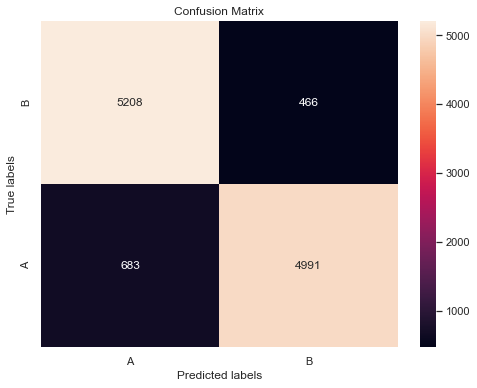

In [429]:
y_pred_cat_cv_bal = cross_val_predict(cat, X_train_selected, y_smt, cv=10)
cm = confusion_matrix(y_smt, y_pred_cat_cv_bal, labels = [0, 1])
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', ax = ax);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['A', 'B'])   
ax.yaxis.set_ticklabels(['B', 'A'])
;

In [430]:
cat2 = CatBoostClassifier()
cat2.fit(X_train_selected_2, y_train_imb)
y_pred_cat2 = cat.predict(X_train_selected_2)
cat_results2 = ml_scores('cat', y_train_imb, y_pred_cat2)
cat_results2

Learning rate set to 0.025035
0:	learn: 0.6719827	total: 7.96ms	remaining: 7.95s
1:	learn: 0.6537343	total: 16.1ms	remaining: 8.04s
2:	learn: 0.6370140	total: 24.5ms	remaining: 8.16s
3:	learn: 0.6214493	total: 34.9ms	remaining: 8.68s
4:	learn: 0.6053783	total: 42.8ms	remaining: 8.51s
5:	learn: 0.5917095	total: 50.7ms	remaining: 8.41s
6:	learn: 0.5763806	total: 58.6ms	remaining: 8.31s
7:	learn: 0.5629707	total: 66.4ms	remaining: 8.24s
8:	learn: 0.5524685	total: 74.6ms	remaining: 8.21s
9:	learn: 0.5408862	total: 82.2ms	remaining: 8.14s
10:	learn: 0.5292147	total: 89.6ms	remaining: 8.05s
11:	learn: 0.5186986	total: 97.2ms	remaining: 8.01s
12:	learn: 0.5094582	total: 105ms	remaining: 7.96s
13:	learn: 0.5003242	total: 112ms	remaining: 7.92s
14:	learn: 0.4928295	total: 120ms	remaining: 7.89s
15:	learn: 0.4848182	total: 128ms	remaining: 7.86s
16:	learn: 0.4776939	total: 136ms	remaining: 7.84s
17:	learn: 0.4720418	total: 143ms	remaining: 7.82s
18:	learn: 0.4659866	total: 151ms	remaining: 7.8s


163:	learn: 0.3217244	total: 1.26s	remaining: 6.44s
164:	learn: 0.3213805	total: 1.27s	remaining: 6.43s
165:	learn: 0.3211597	total: 1.28s	remaining: 6.42s
166:	learn: 0.3210378	total: 1.28s	remaining: 6.41s
167:	learn: 0.3207946	total: 1.29s	remaining: 6.4s
168:	learn: 0.3204970	total: 1.3s	remaining: 6.39s
169:	learn: 0.3203301	total: 1.31s	remaining: 6.38s
170:	learn: 0.3201775	total: 1.31s	remaining: 6.37s
171:	learn: 0.3200822	total: 1.32s	remaining: 6.36s
172:	learn: 0.3199252	total: 1.33s	remaining: 6.34s
173:	learn: 0.3197680	total: 1.33s	remaining: 6.33s
174:	learn: 0.3196295	total: 1.34s	remaining: 6.32s
175:	learn: 0.3194932	total: 1.35s	remaining: 6.31s
176:	learn: 0.3192541	total: 1.35s	remaining: 6.3s
177:	learn: 0.3190967	total: 1.36s	remaining: 6.29s
178:	learn: 0.3189751	total: 1.37s	remaining: 6.28s
179:	learn: 0.3188099	total: 1.38s	remaining: 6.27s
180:	learn: 0.3185763	total: 1.38s	remaining: 6.26s
181:	learn: 0.3184583	total: 1.39s	remaining: 6.25s
182:	learn: 0.3

338:	learn: 0.2961050	total: 2.51s	remaining: 4.9s
339:	learn: 0.2960500	total: 2.52s	remaining: 4.89s
340:	learn: 0.2958503	total: 2.53s	remaining: 4.89s
341:	learn: 0.2956935	total: 2.54s	remaining: 4.88s
342:	learn: 0.2955195	total: 2.54s	remaining: 4.87s
343:	learn: 0.2953266	total: 2.55s	remaining: 4.87s
344:	learn: 0.2952380	total: 2.56s	remaining: 4.86s
345:	learn: 0.2951253	total: 2.56s	remaining: 4.85s
346:	learn: 0.2949970	total: 2.57s	remaining: 4.84s
347:	learn: 0.2949042	total: 2.58s	remaining: 4.83s
348:	learn: 0.2948109	total: 2.59s	remaining: 4.83s
349:	learn: 0.2947118	total: 2.59s	remaining: 4.82s
350:	learn: 0.2945325	total: 2.6s	remaining: 4.81s
351:	learn: 0.2944726	total: 2.61s	remaining: 4.8s
352:	learn: 0.2943676	total: 2.62s	remaining: 4.79s
353:	learn: 0.2941823	total: 2.62s	remaining: 4.79s
354:	learn: 0.2940084	total: 2.63s	remaining: 4.78s
355:	learn: 0.2938634	total: 2.64s	remaining: 4.77s
356:	learn: 0.2937751	total: 2.64s	remaining: 4.76s
357:	learn: 0.2

513:	learn: 0.2737685	total: 3.77s	remaining: 3.57s
514:	learn: 0.2736679	total: 3.78s	remaining: 3.56s
515:	learn: 0.2735789	total: 3.79s	remaining: 3.55s
516:	learn: 0.2734232	total: 3.8s	remaining: 3.55s
517:	learn: 0.2733424	total: 3.8s	remaining: 3.54s
518:	learn: 0.2732151	total: 3.81s	remaining: 3.53s
519:	learn: 0.2730191	total: 3.82s	remaining: 3.52s
520:	learn: 0.2728467	total: 3.83s	remaining: 3.52s
521:	learn: 0.2727306	total: 3.83s	remaining: 3.51s
522:	learn: 0.2726226	total: 3.84s	remaining: 3.5s
523:	learn: 0.2725085	total: 3.85s	remaining: 3.5s
524:	learn: 0.2724108	total: 3.85s	remaining: 3.49s
525:	learn: 0.2722234	total: 3.86s	remaining: 3.48s
526:	learn: 0.2720917	total: 3.87s	remaining: 3.47s
527:	learn: 0.2719911	total: 3.88s	remaining: 3.46s
528:	learn: 0.2718860	total: 3.88s	remaining: 3.46s
529:	learn: 0.2717511	total: 3.89s	remaining: 3.45s
530:	learn: 0.2716677	total: 3.9s	remaining: 3.44s
531:	learn: 0.2715201	total: 3.91s	remaining: 3.44s
532:	learn: 0.271

682:	learn: 0.2548660	total: 5.04s	remaining: 2.34s
683:	learn: 0.2547042	total: 5.05s	remaining: 2.33s
684:	learn: 0.2545922	total: 5.06s	remaining: 2.33s
685:	learn: 0.2545046	total: 5.06s	remaining: 2.32s
686:	learn: 0.2544285	total: 5.07s	remaining: 2.31s
687:	learn: 0.2542675	total: 5.08s	remaining: 2.3s
688:	learn: 0.2541354	total: 5.08s	remaining: 2.29s
689:	learn: 0.2540086	total: 5.09s	remaining: 2.29s
690:	learn: 0.2539002	total: 5.1s	remaining: 2.28s
691:	learn: 0.2538333	total: 5.11s	remaining: 2.27s
692:	learn: 0.2537640	total: 5.11s	remaining: 2.27s
693:	learn: 0.2537195	total: 5.12s	remaining: 2.26s
694:	learn: 0.2536171	total: 5.13s	remaining: 2.25s
695:	learn: 0.2535402	total: 5.13s	remaining: 2.24s
696:	learn: 0.2534003	total: 5.14s	remaining: 2.23s
697:	learn: 0.2533249	total: 5.15s	remaining: 2.23s
698:	learn: 0.2532573	total: 5.16s	remaining: 2.22s
699:	learn: 0.2531446	total: 5.16s	remaining: 2.21s
700:	learn: 0.2529913	total: 5.17s	remaining: 2.21s
701:	learn: 0.

854:	learn: 0.2393036	total: 6.3s	remaining: 1.07s
855:	learn: 0.2392376	total: 6.31s	remaining: 1.06s
856:	learn: 0.2391098	total: 6.32s	remaining: 1.05s
857:	learn: 0.2390143	total: 6.33s	remaining: 1.05s
858:	learn: 0.2389367	total: 6.33s	remaining: 1.04s
859:	learn: 0.2388495	total: 6.34s	remaining: 1.03s
860:	learn: 0.2387903	total: 6.35s	remaining: 1.02s
861:	learn: 0.2386831	total: 6.36s	remaining: 1.02s
862:	learn: 0.2386305	total: 6.36s	remaining: 1.01s
863:	learn: 0.2385580	total: 6.37s	remaining: 1s
864:	learn: 0.2384749	total: 6.38s	remaining: 995ms
865:	learn: 0.2383655	total: 6.38s	remaining: 988ms
866:	learn: 0.2382758	total: 6.39s	remaining: 981ms
867:	learn: 0.2382066	total: 6.4s	remaining: 973ms
868:	learn: 0.2381696	total: 6.41s	remaining: 966ms
869:	learn: 0.2380765	total: 6.41s	remaining: 958ms
870:	learn: 0.2380031	total: 6.42s	remaining: 951ms
871:	learn: 0.2379409	total: 6.43s	remaining: 944ms
872:	learn: 0.2378657	total: 6.43s	remaining: 936ms
873:	learn: 0.237

Balanced Accuracy  Precision   Recall       F1  ROC_AUC    Kappa
cat 0.769000           0.396000   0.885000 0.547000 0.769000 0.369000

In [431]:
cat_cv_imb = performance(cat2,X_train_selected_2,y_train_imb)
cat_cv_imb 

Learning rate set to 0.023934
0:	learn: 0.6766442	total: 7.65ms	remaining: 7.64s
1:	learn: 0.6589324	total: 14.9ms	remaining: 7.43s
2:	learn: 0.6420092	total: 22ms	remaining: 7.31s
3:	learn: 0.6263848	total: 29.9ms	remaining: 7.44s
4:	learn: 0.6105764	total: 36.6ms	remaining: 7.29s
5:	learn: 0.5969846	total: 43.2ms	remaining: 7.16s
6:	learn: 0.5819050	total: 50.2ms	remaining: 7.12s
7:	learn: 0.5685720	total: 57.2ms	remaining: 7.1s
8:	learn: 0.5582830	total: 63.9ms	remaining: 7.04s
9:	learn: 0.5466053	total: 70.5ms	remaining: 6.98s
10:	learn: 0.5364989	total: 77.2ms	remaining: 6.94s
11:	learn: 0.5261774	total: 83.9ms	remaining: 6.91s
12:	learn: 0.5168157	total: 90.6ms	remaining: 6.88s
13:	learn: 0.5081002	total: 97.2ms	remaining: 6.85s
14:	learn: 0.5004419	total: 104ms	remaining: 6.82s
15:	learn: 0.4922608	total: 110ms	remaining: 6.79s
16:	learn: 0.4858716	total: 117ms	remaining: 6.78s
17:	learn: 0.4789743	total: 124ms	remaining: 6.76s
18:	learn: 0.4730059	total: 131ms	remaining: 6.74s


181:	learn: 0.3170322	total: 1.27s	remaining: 5.69s
182:	learn: 0.3167289	total: 1.27s	remaining: 5.68s
183:	learn: 0.3166213	total: 1.28s	remaining: 5.68s
184:	learn: 0.3164564	total: 1.29s	remaining: 5.67s
185:	learn: 0.3162200	total: 1.29s	remaining: 5.66s
186:	learn: 0.3160740	total: 1.3s	remaining: 5.66s
187:	learn: 0.3158937	total: 1.31s	remaining: 5.65s
188:	learn: 0.3156579	total: 1.31s	remaining: 5.64s
189:	learn: 0.3154740	total: 1.32s	remaining: 5.63s
190:	learn: 0.3152931	total: 1.33s	remaining: 5.62s
191:	learn: 0.3151016	total: 1.33s	remaining: 5.62s
192:	learn: 0.3148715	total: 1.34s	remaining: 5.61s
193:	learn: 0.3146436	total: 1.35s	remaining: 5.6s
194:	learn: 0.3144865	total: 1.35s	remaining: 5.59s
195:	learn: 0.3143339	total: 1.36s	remaining: 5.58s
196:	learn: 0.3139329	total: 1.37s	remaining: 5.58s
197:	learn: 0.3138004	total: 1.37s	remaining: 5.57s
198:	learn: 0.3137489	total: 1.38s	remaining: 5.56s
199:	learn: 0.3135067	total: 1.39s	remaining: 5.55s
200:	learn: 0.

365:	learn: 0.2905557	total: 2.52s	remaining: 4.37s
366:	learn: 0.2904586	total: 2.53s	remaining: 4.36s
367:	learn: 0.2903575	total: 2.54s	remaining: 4.35s
368:	learn: 0.2902630	total: 2.54s	remaining: 4.35s
369:	learn: 0.2901592	total: 2.55s	remaining: 4.34s
370:	learn: 0.2900019	total: 2.56s	remaining: 4.33s
371:	learn: 0.2898168	total: 2.56s	remaining: 4.33s
372:	learn: 0.2897342	total: 2.57s	remaining: 4.32s
373:	learn: 0.2896659	total: 2.58s	remaining: 4.31s
374:	learn: 0.2895750	total: 2.58s	remaining: 4.3s
375:	learn: 0.2894747	total: 2.59s	remaining: 4.3s
376:	learn: 0.2892812	total: 2.6s	remaining: 4.29s
377:	learn: 0.2891057	total: 2.6s	remaining: 4.29s
378:	learn: 0.2890134	total: 2.61s	remaining: 4.28s
379:	learn: 0.2887867	total: 2.62s	remaining: 4.27s
380:	learn: 0.2886632	total: 2.62s	remaining: 4.26s
381:	learn: 0.2884773	total: 2.63s	remaining: 4.26s
382:	learn: 0.2883161	total: 2.64s	remaining: 4.25s
383:	learn: 0.2881633	total: 2.64s	remaining: 4.24s
384:	learn: 0.28

525:	learn: 0.2701017	total: 3.6s	remaining: 3.24s
526:	learn: 0.2699997	total: 3.6s	remaining: 3.23s
527:	learn: 0.2698903	total: 3.61s	remaining: 3.23s
528:	learn: 0.2697604	total: 3.62s	remaining: 3.22s
529:	learn: 0.2696759	total: 3.62s	remaining: 3.21s
530:	learn: 0.2695494	total: 3.63s	remaining: 3.21s
531:	learn: 0.2694113	total: 3.64s	remaining: 3.2s
532:	learn: 0.2692217	total: 3.64s	remaining: 3.19s
533:	learn: 0.2691227	total: 3.65s	remaining: 3.19s
534:	learn: 0.2690127	total: 3.66s	remaining: 3.18s
535:	learn: 0.2688985	total: 3.66s	remaining: 3.17s
536:	learn: 0.2687820	total: 3.67s	remaining: 3.17s
537:	learn: 0.2686230	total: 3.68s	remaining: 3.16s
538:	learn: 0.2685098	total: 3.69s	remaining: 3.15s
539:	learn: 0.2683836	total: 3.69s	remaining: 3.15s
540:	learn: 0.2682550	total: 3.7s	remaining: 3.14s
541:	learn: 0.2680934	total: 3.71s	remaining: 3.13s
542:	learn: 0.2679578	total: 3.71s	remaining: 3.12s
543:	learn: 0.2677714	total: 3.72s	remaining: 3.12s
544:	learn: 0.26

685:	learn: 0.2516609	total: 4.68s	remaining: 2.14s
686:	learn: 0.2515334	total: 4.69s	remaining: 2.14s
687:	learn: 0.2514375	total: 4.7s	remaining: 2.13s
688:	learn: 0.2513411	total: 4.7s	remaining: 2.12s
689:	learn: 0.2511638	total: 4.71s	remaining: 2.12s
690:	learn: 0.2510085	total: 4.72s	remaining: 2.11s
691:	learn: 0.2509431	total: 4.72s	remaining: 2.1s
692:	learn: 0.2508124	total: 4.73s	remaining: 2.1s
693:	learn: 0.2507172	total: 4.74s	remaining: 2.09s
694:	learn: 0.2505962	total: 4.75s	remaining: 2.08s
695:	learn: 0.2504584	total: 4.75s	remaining: 2.08s
696:	learn: 0.2504299	total: 4.76s	remaining: 2.07s
697:	learn: 0.2502847	total: 4.77s	remaining: 2.06s
698:	learn: 0.2501255	total: 4.77s	remaining: 2.06s
699:	learn: 0.2500543	total: 4.78s	remaining: 2.05s
700:	learn: 0.2499755	total: 4.79s	remaining: 2.04s
701:	learn: 0.2498355	total: 4.79s	remaining: 2.03s
702:	learn: 0.2497535	total: 4.8s	remaining: 2.03s
703:	learn: 0.2496242	total: 4.81s	remaining: 2.02s
704:	learn: 0.249

870:	learn: 0.2341632	total: 5.94s	remaining: 879ms
871:	learn: 0.2340947	total: 5.94s	remaining: 872ms
872:	learn: 0.2340431	total: 5.95s	remaining: 866ms
873:	learn: 0.2339331	total: 5.96s	remaining: 859ms
874:	learn: 0.2337830	total: 5.96s	remaining: 852ms
875:	learn: 0.2336781	total: 5.97s	remaining: 845ms
876:	learn: 0.2335804	total: 5.98s	remaining: 838ms
877:	learn: 0.2334511	total: 5.98s	remaining: 832ms
878:	learn: 0.2332913	total: 5.99s	remaining: 825ms
879:	learn: 0.2332013	total: 6s	remaining: 818ms
880:	learn: 0.2331525	total: 6s	remaining: 811ms
881:	learn: 0.2330475	total: 6.01s	remaining: 804ms
882:	learn: 0.2329785	total: 6.02s	remaining: 798ms
883:	learn: 0.2328702	total: 6.03s	remaining: 791ms
884:	learn: 0.2328329	total: 6.03s	remaining: 784ms
885:	learn: 0.2326684	total: 6.04s	remaining: 777ms
886:	learn: 0.2325649	total: 6.05s	remaining: 770ms
887:	learn: 0.2324780	total: 6.05s	remaining: 764ms
888:	learn: 0.2324050	total: 6.06s	remaining: 757ms
889:	learn: 0.2323

53:	learn: 0.3724545	total: 362ms	remaining: 6.34s
54:	learn: 0.3707566	total: 371ms	remaining: 6.37s
55:	learn: 0.3693136	total: 379ms	remaining: 6.38s
56:	learn: 0.3679103	total: 389ms	remaining: 6.44s
57:	learn: 0.3662677	total: 396ms	remaining: 6.43s
58:	learn: 0.3653789	total: 403ms	remaining: 6.43s
59:	learn: 0.3645587	total: 410ms	remaining: 6.43s
60:	learn: 0.3632530	total: 418ms	remaining: 6.44s
61:	learn: 0.3618851	total: 426ms	remaining: 6.44s
62:	learn: 0.3610226	total: 433ms	remaining: 6.44s
63:	learn: 0.3604313	total: 440ms	remaining: 6.43s
64:	learn: 0.3595754	total: 447ms	remaining: 6.43s
65:	learn: 0.3590088	total: 454ms	remaining: 6.43s
66:	learn: 0.3583944	total: 461ms	remaining: 6.42s
67:	learn: 0.3575512	total: 468ms	remaining: 6.42s
68:	learn: 0.3567634	total: 476ms	remaining: 6.42s
69:	learn: 0.3559148	total: 485ms	remaining: 6.44s
70:	learn: 0.3549622	total: 492ms	remaining: 6.44s
71:	learn: 0.3542038	total: 499ms	remaining: 6.43s
72:	learn: 0.3532349	total: 506

215:	learn: 0.3133838	total: 1.61s	remaining: 5.85s
216:	learn: 0.3131738	total: 1.62s	remaining: 5.84s
217:	learn: 0.3130599	total: 1.63s	remaining: 5.83s
218:	learn: 0.3129212	total: 1.63s	remaining: 5.83s
219:	learn: 0.3127540	total: 1.64s	remaining: 5.82s
220:	learn: 0.3126571	total: 1.65s	remaining: 5.81s
221:	learn: 0.3124279	total: 1.65s	remaining: 5.8s
222:	learn: 0.3122599	total: 1.66s	remaining: 5.79s
223:	learn: 0.3121589	total: 1.67s	remaining: 5.78s
224:	learn: 0.3120220	total: 1.67s	remaining: 5.77s
225:	learn: 0.3119012	total: 1.68s	remaining: 5.76s
226:	learn: 0.3117618	total: 1.69s	remaining: 5.75s
227:	learn: 0.3116221	total: 1.7s	remaining: 5.74s
228:	learn: 0.3114475	total: 1.7s	remaining: 5.73s
229:	learn: 0.3112353	total: 1.71s	remaining: 5.72s
230:	learn: 0.3110572	total: 1.72s	remaining: 5.71s
231:	learn: 0.3109145	total: 1.72s	remaining: 5.7s
232:	learn: 0.3107157	total: 1.73s	remaining: 5.69s
233:	learn: 0.3105761	total: 1.74s	remaining: 5.68s
234:	learn: 0.31

374:	learn: 0.2916986	total: 2.69s	remaining: 4.48s
375:	learn: 0.2915982	total: 2.69s	remaining: 4.47s
376:	learn: 0.2914346	total: 2.7s	remaining: 4.47s
377:	learn: 0.2913451	total: 2.71s	remaining: 4.46s
378:	learn: 0.2912825	total: 2.72s	remaining: 4.45s
379:	learn: 0.2911291	total: 2.72s	remaining: 4.44s
380:	learn: 0.2909204	total: 2.73s	remaining: 4.43s
381:	learn: 0.2908304	total: 2.74s	remaining: 4.43s
382:	learn: 0.2906738	total: 2.74s	remaining: 4.42s
383:	learn: 0.2905493	total: 2.75s	remaining: 4.41s
384:	learn: 0.2904549	total: 2.76s	remaining: 4.4s
385:	learn: 0.2903521	total: 2.76s	remaining: 4.4s
386:	learn: 0.2902329	total: 2.77s	remaining: 4.39s
387:	learn: 0.2900669	total: 2.78s	remaining: 4.38s
388:	learn: 0.2899676	total: 2.78s	remaining: 4.37s
389:	learn: 0.2898401	total: 2.79s	remaining: 4.37s
390:	learn: 0.2897413	total: 2.8s	remaining: 4.36s
391:	learn: 0.2896171	total: 2.8s	remaining: 4.35s
392:	learn: 0.2894826	total: 2.81s	remaining: 4.34s
393:	learn: 0.289

534:	learn: 0.2705319	total: 3.77s	remaining: 3.28s
535:	learn: 0.2704227	total: 3.78s	remaining: 3.27s
536:	learn: 0.2702685	total: 3.78s	remaining: 3.26s
537:	learn: 0.2701515	total: 3.79s	remaining: 3.25s
538:	learn: 0.2700359	total: 3.8s	remaining: 3.25s
539:	learn: 0.2699309	total: 3.8s	remaining: 3.24s
540:	learn: 0.2697974	total: 3.81s	remaining: 3.23s
541:	learn: 0.2696955	total: 3.82s	remaining: 3.23s
542:	learn: 0.2695570	total: 3.82s	remaining: 3.22s
543:	learn: 0.2694154	total: 3.83s	remaining: 3.21s
544:	learn: 0.2692914	total: 3.84s	remaining: 3.2s
545:	learn: 0.2692024	total: 3.84s	remaining: 3.19s
546:	learn: 0.2690170	total: 3.85s	remaining: 3.19s
547:	learn: 0.2689012	total: 3.86s	remaining: 3.18s
548:	learn: 0.2687213	total: 3.86s	remaining: 3.17s
549:	learn: 0.2685695	total: 3.87s	remaining: 3.17s
550:	learn: 0.2684683	total: 3.88s	remaining: 3.16s
551:	learn: 0.2683932	total: 3.88s	remaining: 3.15s
552:	learn: 0.2682942	total: 3.89s	remaining: 3.14s
553:	learn: 0.2

693:	learn: 0.2524146	total: 4.86s	remaining: 2.14s
694:	learn: 0.2523473	total: 4.86s	remaining: 2.13s
695:	learn: 0.2521924	total: 4.87s	remaining: 2.13s
696:	learn: 0.2521069	total: 4.88s	remaining: 2.12s
697:	learn: 0.2520263	total: 4.88s	remaining: 2.11s
698:	learn: 0.2519499	total: 4.89s	remaining: 2.11s
699:	learn: 0.2518225	total: 4.9s	remaining: 2.1s
700:	learn: 0.2517143	total: 4.9s	remaining: 2.09s
701:	learn: 0.2516430	total: 4.91s	remaining: 2.08s
702:	learn: 0.2515290	total: 4.92s	remaining: 2.08s
703:	learn: 0.2514055	total: 4.92s	remaining: 2.07s
704:	learn: 0.2513172	total: 4.93s	remaining: 2.06s
705:	learn: 0.2512162	total: 4.94s	remaining: 2.06s
706:	learn: 0.2510855	total: 4.95s	remaining: 2.05s
707:	learn: 0.2509596	total: 4.95s	remaining: 2.04s
708:	learn: 0.2508194	total: 4.96s	remaining: 2.04s
709:	learn: 0.2506996	total: 4.96s	remaining: 2.03s
710:	learn: 0.2505968	total: 4.97s	remaining: 2.02s
711:	learn: 0.2505018	total: 4.98s	remaining: 2.01s
712:	learn: 0.2

855:	learn: 0.2372340	total: 5.95s	remaining: 1s
856:	learn: 0.2371686	total: 5.96s	remaining: 994ms
857:	learn: 0.2370873	total: 5.96s	remaining: 987ms
858:	learn: 0.2370245	total: 5.97s	remaining: 980ms
859:	learn: 0.2369337	total: 5.98s	remaining: 973ms
860:	learn: 0.2368427	total: 5.99s	remaining: 966ms
861:	learn: 0.2367325	total: 5.99s	remaining: 959ms
862:	learn: 0.2366504	total: 6s	remaining: 952ms
863:	learn: 0.2365777	total: 6.01s	remaining: 945ms
864:	learn: 0.2365050	total: 6.01s	remaining: 938ms
865:	learn: 0.2364187	total: 6.02s	remaining: 931ms
866:	learn: 0.2363268	total: 6.03s	remaining: 925ms
867:	learn: 0.2362208	total: 6.03s	remaining: 918ms
868:	learn: 0.2361582	total: 6.04s	remaining: 911ms
869:	learn: 0.2360779	total: 6.05s	remaining: 904ms
870:	learn: 0.2359965	total: 6.05s	remaining: 897ms
871:	learn: 0.2359146	total: 6.06s	remaining: 890ms
872:	learn: 0.2358403	total: 6.07s	remaining: 883ms
873:	learn: 0.2357535	total: 6.07s	remaining: 876ms
874:	learn: 0.2356

35:	learn: 0.4041925	total: 244ms	remaining: 6.54s
36:	learn: 0.4015409	total: 252ms	remaining: 6.55s
37:	learn: 0.3984017	total: 259ms	remaining: 6.55s
38:	learn: 0.3959283	total: 266ms	remaining: 6.55s
39:	learn: 0.3936463	total: 273ms	remaining: 6.55s
40:	learn: 0.3911918	total: 280ms	remaining: 6.55s
41:	learn: 0.3891623	total: 287ms	remaining: 6.54s
42:	learn: 0.3872868	total: 294ms	remaining: 6.54s
43:	learn: 0.3851715	total: 301ms	remaining: 6.53s
44:	learn: 0.3833586	total: 307ms	remaining: 6.53s
45:	learn: 0.3819292	total: 314ms	remaining: 6.52s
46:	learn: 0.3801603	total: 321ms	remaining: 6.51s
47:	learn: 0.3784337	total: 328ms	remaining: 6.5s
48:	learn: 0.3769492	total: 335ms	remaining: 6.49s
49:	learn: 0.3757890	total: 342ms	remaining: 6.49s
50:	learn: 0.3743050	total: 349ms	remaining: 6.49s
51:	learn: 0.3728934	total: 356ms	remaining: 6.49s
52:	learn: 0.3713074	total: 363ms	remaining: 6.48s
53:	learn: 0.3700090	total: 370ms	remaining: 6.48s
54:	learn: 0.3686804	total: 377m

220:	learn: 0.3101047	total: 1.52s	remaining: 5.35s
221:	learn: 0.3099904	total: 1.52s	remaining: 5.34s
222:	learn: 0.3098841	total: 1.53s	remaining: 5.33s
223:	learn: 0.3096925	total: 1.54s	remaining: 5.33s
224:	learn: 0.3094995	total: 1.54s	remaining: 5.32s
225:	learn: 0.3092663	total: 1.55s	remaining: 5.32s
226:	learn: 0.3091079	total: 1.56s	remaining: 5.31s
227:	learn: 0.3089047	total: 1.56s	remaining: 5.3s
228:	learn: 0.3087963	total: 1.57s	remaining: 5.29s
229:	learn: 0.3086171	total: 1.58s	remaining: 5.29s
230:	learn: 0.3084221	total: 1.58s	remaining: 5.28s
231:	learn: 0.3081748	total: 1.59s	remaining: 5.27s
232:	learn: 0.3080114	total: 1.6s	remaining: 5.26s
233:	learn: 0.3079482	total: 1.6s	remaining: 5.25s
234:	learn: 0.3078144	total: 1.61s	remaining: 5.25s
235:	learn: 0.3077058	total: 1.62s	remaining: 5.24s
236:	learn: 0.3074827	total: 1.62s	remaining: 5.23s
237:	learn: 0.3073375	total: 1.63s	remaining: 5.22s
238:	learn: 0.3071840	total: 1.64s	remaining: 5.21s
239:	learn: 0.3

379:	learn: 0.2881573	total: 2.59s	remaining: 4.23s
380:	learn: 0.2880022	total: 2.6s	remaining: 4.22s
381:	learn: 0.2879359	total: 2.61s	remaining: 4.22s
382:	learn: 0.2878005	total: 2.61s	remaining: 4.21s
383:	learn: 0.2876444	total: 2.62s	remaining: 4.2s
384:	learn: 0.2875162	total: 2.63s	remaining: 4.2s
385:	learn: 0.2873924	total: 2.63s	remaining: 4.19s
386:	learn: 0.2872914	total: 2.64s	remaining: 4.18s
387:	learn: 0.2871825	total: 2.65s	remaining: 4.17s
388:	learn: 0.2869869	total: 2.65s	remaining: 4.17s
389:	learn: 0.2868209	total: 2.66s	remaining: 4.16s
390:	learn: 0.2866847	total: 2.67s	remaining: 4.15s
391:	learn: 0.2865758	total: 2.67s	remaining: 4.14s
392:	learn: 0.2864279	total: 2.68s	remaining: 4.14s
393:	learn: 0.2862041	total: 2.69s	remaining: 4.13s
394:	learn: 0.2860934	total: 2.69s	remaining: 4.13s
395:	learn: 0.2859225	total: 2.7s	remaining: 4.12s
396:	learn: 0.2858046	total: 2.71s	remaining: 4.11s
397:	learn: 0.2856758	total: 2.71s	remaining: 4.1s
398:	learn: 0.285

540:	learn: 0.2676260	total: 3.68s	remaining: 3.13s
541:	learn: 0.2675307	total: 3.69s	remaining: 3.12s
542:	learn: 0.2673963	total: 3.7s	remaining: 3.11s
543:	learn: 0.2673195	total: 3.71s	remaining: 3.1s
544:	learn: 0.2671959	total: 3.71s	remaining: 3.1s
545:	learn: 0.2669895	total: 3.72s	remaining: 3.09s
546:	learn: 0.2668922	total: 3.73s	remaining: 3.08s
547:	learn: 0.2667971	total: 3.73s	remaining: 3.08s
548:	learn: 0.2666897	total: 3.74s	remaining: 3.07s
549:	learn: 0.2666026	total: 3.75s	remaining: 3.06s
550:	learn: 0.2665126	total: 3.75s	remaining: 3.06s
551:	learn: 0.2663776	total: 3.76s	remaining: 3.05s
552:	learn: 0.2662106	total: 3.77s	remaining: 3.04s
553:	learn: 0.2660937	total: 3.77s	remaining: 3.04s
554:	learn: 0.2660090	total: 3.78s	remaining: 3.03s
555:	learn: 0.2658918	total: 3.79s	remaining: 3.02s
556:	learn: 0.2657843	total: 3.79s	remaining: 3.02s
557:	learn: 0.2656622	total: 3.8s	remaining: 3.01s
558:	learn: 0.2654968	total: 3.81s	remaining: 3s
559:	learn: 0.26535

702:	learn: 0.2495610	total: 4.77s	remaining: 2.02s
703:	learn: 0.2494850	total: 4.78s	remaining: 2.01s
704:	learn: 0.2494109	total: 4.79s	remaining: 2s
705:	learn: 0.2493246	total: 4.79s	remaining: 2s
706:	learn: 0.2492558	total: 4.8s	remaining: 1.99s
707:	learn: 0.2491192	total: 4.8s	remaining: 1.98s
708:	learn: 0.2490340	total: 4.81s	remaining: 1.98s
709:	learn: 0.2489825	total: 4.82s	remaining: 1.97s
710:	learn: 0.2489124	total: 4.83s	remaining: 1.96s
711:	learn: 0.2488080	total: 4.83s	remaining: 1.95s
712:	learn: 0.2487115	total: 4.84s	remaining: 1.95s
713:	learn: 0.2486171	total: 4.85s	remaining: 1.94s
714:	learn: 0.2484827	total: 4.85s	remaining: 1.93s
715:	learn: 0.2484207	total: 4.86s	remaining: 1.93s
716:	learn: 0.2483256	total: 4.87s	remaining: 1.92s
717:	learn: 0.2481826	total: 4.87s	remaining: 1.91s
718:	learn: 0.2480817	total: 4.88s	remaining: 1.91s
719:	learn: 0.2480082	total: 4.89s	remaining: 1.9s
720:	learn: 0.2478645	total: 4.89s	remaining: 1.89s
721:	learn: 0.2477796

862:	learn: 0.2344234	total: 5.85s	remaining: 928ms
863:	learn: 0.2343417	total: 5.85s	remaining: 921ms
864:	learn: 0.2342471	total: 5.86s	remaining: 915ms
865:	learn: 0.2341841	total: 5.87s	remaining: 908ms
866:	learn: 0.2340961	total: 5.87s	remaining: 901ms
867:	learn: 0.2340290	total: 5.88s	remaining: 894ms
868:	learn: 0.2339382	total: 5.89s	remaining: 887ms
869:	learn: 0.2338416	total: 5.89s	remaining: 881ms
870:	learn: 0.2337797	total: 5.9s	remaining: 874ms
871:	learn: 0.2336744	total: 5.91s	remaining: 867ms
872:	learn: 0.2336006	total: 5.91s	remaining: 860ms
873:	learn: 0.2335232	total: 5.92s	remaining: 853ms
874:	learn: 0.2334629	total: 5.93s	remaining: 847ms
875:	learn: 0.2333544	total: 5.93s	remaining: 840ms
876:	learn: 0.2332381	total: 5.94s	remaining: 833ms
877:	learn: 0.2331586	total: 5.95s	remaining: 826ms
878:	learn: 0.2330198	total: 5.95s	remaining: 819ms
879:	learn: 0.2328969	total: 5.96s	remaining: 813ms
880:	learn: 0.2328292	total: 5.97s	remaining: 806ms
881:	learn: 0

35:	learn: 0.4051790	total: 239ms	remaining: 6.39s
36:	learn: 0.4022284	total: 245ms	remaining: 6.38s
37:	learn: 0.3993973	total: 252ms	remaining: 6.37s
38:	learn: 0.3976210	total: 259ms	remaining: 6.37s
39:	learn: 0.3953570	total: 265ms	remaining: 6.37s
40:	learn: 0.3928171	total: 272ms	remaining: 6.37s
41:	learn: 0.3907017	total: 279ms	remaining: 6.37s
42:	learn: 0.3887653	total: 286ms	remaining: 6.37s
43:	learn: 0.3869257	total: 293ms	remaining: 6.37s
44:	learn: 0.3857355	total: 300ms	remaining: 6.37s
45:	learn: 0.3840737	total: 307ms	remaining: 6.37s
46:	learn: 0.3827740	total: 314ms	remaining: 6.36s
47:	learn: 0.3813743	total: 321ms	remaining: 6.36s
48:	learn: 0.3800215	total: 328ms	remaining: 6.36s
49:	learn: 0.3785471	total: 335ms	remaining: 6.36s
50:	learn: 0.3766803	total: 341ms	remaining: 6.35s
51:	learn: 0.3756530	total: 348ms	remaining: 6.34s
52:	learn: 0.3744104	total: 355ms	remaining: 6.34s
53:	learn: 0.3726792	total: 361ms	remaining: 6.33s
54:	learn: 0.3713853	total: 368

219:	learn: 0.3139240	total: 1.5s	remaining: 5.3s
220:	learn: 0.3137977	total: 1.5s	remaining: 5.3s
221:	learn: 0.3136112	total: 1.51s	remaining: 5.29s
222:	learn: 0.3135073	total: 1.52s	remaining: 5.29s
223:	learn: 0.3133596	total: 1.52s	remaining: 5.28s
224:	learn: 0.3132316	total: 1.53s	remaining: 5.27s
225:	learn: 0.3130889	total: 1.54s	remaining: 5.26s
226:	learn: 0.3129118	total: 1.54s	remaining: 5.26s
227:	learn: 0.3127700	total: 1.55s	remaining: 5.25s
228:	learn: 0.3126367	total: 1.56s	remaining: 5.24s
229:	learn: 0.3125056	total: 1.56s	remaining: 5.24s
230:	learn: 0.3124843	total: 1.57s	remaining: 5.22s
231:	learn: 0.3123132	total: 1.58s	remaining: 5.22s
232:	learn: 0.3121671	total: 1.58s	remaining: 5.21s
233:	learn: 0.3120653	total: 1.59s	remaining: 5.21s
234:	learn: 0.3119307	total: 1.6s	remaining: 5.2s
235:	learn: 0.3116928	total: 1.6s	remaining: 5.19s
236:	learn: 0.3115475	total: 1.61s	remaining: 5.18s
237:	learn: 0.3115178	total: 1.62s	remaining: 5.18s
238:	learn: 0.31142

387:	learn: 0.2912774	total: 2.74s	remaining: 4.33s
388:	learn: 0.2911466	total: 2.75s	remaining: 4.32s
389:	learn: 0.2909695	total: 2.76s	remaining: 4.31s
390:	learn: 0.2907341	total: 2.76s	remaining: 4.3s
391:	learn: 0.2905846	total: 2.77s	remaining: 4.3s
392:	learn: 0.2904953	total: 2.78s	remaining: 4.29s
393:	learn: 0.2902983	total: 2.78s	remaining: 4.28s
394:	learn: 0.2901503	total: 2.79s	remaining: 4.28s
395:	learn: 0.2900356	total: 2.8s	remaining: 4.27s
396:	learn: 0.2899606	total: 2.8s	remaining: 4.26s
397:	learn: 0.2898582	total: 2.81s	remaining: 4.25s
398:	learn: 0.2897063	total: 2.82s	remaining: 4.24s
399:	learn: 0.2895370	total: 2.82s	remaining: 4.24s
400:	learn: 0.2893690	total: 2.83s	remaining: 4.23s
401:	learn: 0.2890979	total: 2.84s	remaining: 4.22s
402:	learn: 0.2889715	total: 2.84s	remaining: 4.21s
403:	learn: 0.2889072	total: 2.85s	remaining: 4.21s
404:	learn: 0.2887048	total: 2.86s	remaining: 4.2s
405:	learn: 0.2884870	total: 2.87s	remaining: 4.19s
406:	learn: 0.288

573:	learn: 0.2678239	total: 4s	remaining: 2.97s
574:	learn: 0.2677315	total: 4.01s	remaining: 2.97s
575:	learn: 0.2676643	total: 4.02s	remaining: 2.96s
576:	learn: 0.2675556	total: 4.03s	remaining: 2.95s
577:	learn: 0.2674043	total: 4.04s	remaining: 2.95s
578:	learn: 0.2672809	total: 4.04s	remaining: 2.94s
579:	learn: 0.2672012	total: 4.05s	remaining: 2.93s
580:	learn: 0.2670477	total: 4.05s	remaining: 2.92s
581:	learn: 0.2669282	total: 4.06s	remaining: 2.92s
582:	learn: 0.2667963	total: 4.07s	remaining: 2.91s
583:	learn: 0.2666816	total: 4.08s	remaining: 2.9s
584:	learn: 0.2665644	total: 4.08s	remaining: 2.9s
585:	learn: 0.2664853	total: 4.09s	remaining: 2.89s
586:	learn: 0.2663935	total: 4.1s	remaining: 2.88s
587:	learn: 0.2662800	total: 4.1s	remaining: 2.88s
588:	learn: 0.2662031	total: 4.11s	remaining: 2.87s
589:	learn: 0.2660640	total: 4.12s	remaining: 2.86s
590:	learn: 0.2659620	total: 4.12s	remaining: 2.85s
591:	learn: 0.2658616	total: 4.13s	remaining: 2.85s
592:	learn: 0.26577

732:	learn: 0.2502771	total: 5.11s	remaining: 1.86s
733:	learn: 0.2501671	total: 5.11s	remaining: 1.85s
734:	learn: 0.2500750	total: 5.12s	remaining: 1.85s
735:	learn: 0.2499789	total: 5.13s	remaining: 1.84s
736:	learn: 0.2498942	total: 5.13s	remaining: 1.83s
737:	learn: 0.2498036	total: 5.14s	remaining: 1.82s
738:	learn: 0.2497122	total: 5.15s	remaining: 1.82s
739:	learn: 0.2496201	total: 5.16s	remaining: 1.81s
740:	learn: 0.2495226	total: 5.16s	remaining: 1.8s
741:	learn: 0.2494126	total: 5.17s	remaining: 1.8s
742:	learn: 0.2492996	total: 5.18s	remaining: 1.79s
743:	learn: 0.2491981	total: 5.18s	remaining: 1.78s
744:	learn: 0.2490927	total: 5.19s	remaining: 1.78s
745:	learn: 0.2489955	total: 5.2s	remaining: 1.77s
746:	learn: 0.2489337	total: 5.2s	remaining: 1.76s
747:	learn: 0.2488511	total: 5.21s	remaining: 1.76s
748:	learn: 0.2487793	total: 5.22s	remaining: 1.75s
749:	learn: 0.2487205	total: 5.23s	remaining: 1.74s
750:	learn: 0.2486082	total: 5.23s	remaining: 1.74s
751:	learn: 0.24

916:	learn: 0.2333614	total: 6.37s	remaining: 577ms
917:	learn: 0.2332826	total: 6.38s	remaining: 570ms
918:	learn: 0.2332113	total: 6.38s	remaining: 563ms
919:	learn: 0.2331355	total: 6.39s	remaining: 556ms
920:	learn: 0.2330522	total: 6.4s	remaining: 549ms
921:	learn: 0.2330010	total: 6.41s	remaining: 542ms
922:	learn: 0.2329229	total: 6.41s	remaining: 535ms
923:	learn: 0.2328482	total: 6.42s	remaining: 528ms
924:	learn: 0.2327695	total: 6.42s	remaining: 521ms
925:	learn: 0.2326577	total: 6.43s	remaining: 514ms
926:	learn: 0.2326145	total: 6.44s	remaining: 507ms
927:	learn: 0.2325679	total: 6.45s	remaining: 500ms
928:	learn: 0.2325104	total: 6.45s	remaining: 493ms
929:	learn: 0.2324209	total: 6.46s	remaining: 486ms
930:	learn: 0.2323352	total: 6.46s	remaining: 479ms
931:	learn: 0.2322408	total: 6.47s	remaining: 472ms
932:	learn: 0.2321567	total: 6.48s	remaining: 465ms
933:	learn: 0.2320630	total: 6.48s	remaining: 458ms
934:	learn: 0.2319783	total: 6.49s	remaining: 451ms
935:	learn: 0

86:	learn: 0.3378410	total: 588ms	remaining: 6.17s
87:	learn: 0.3374191	total: 596ms	remaining: 6.18s
88:	learn: 0.3370070	total: 604ms	remaining: 6.18s
89:	learn: 0.3364152	total: 613ms	remaining: 6.2s
90:	learn: 0.3360430	total: 620ms	remaining: 6.19s
91:	learn: 0.3355655	total: 627ms	remaining: 6.19s
92:	learn: 0.3350399	total: 634ms	remaining: 6.19s
93:	learn: 0.3347019	total: 641ms	remaining: 6.18s
94:	learn: 0.3342041	total: 649ms	remaining: 6.18s
95:	learn: 0.3335504	total: 657ms	remaining: 6.18s
96:	learn: 0.3332149	total: 664ms	remaining: 6.18s
97:	learn: 0.3326714	total: 672ms	remaining: 6.19s
98:	learn: 0.3323785	total: 680ms	remaining: 6.19s
99:	learn: 0.3319654	total: 688ms	remaining: 6.19s
100:	learn: 0.3316318	total: 696ms	remaining: 6.19s
101:	learn: 0.3312958	total: 703ms	remaining: 6.19s
102:	learn: 0.3307067	total: 711ms	remaining: 6.19s
103:	learn: 0.3304606	total: 718ms	remaining: 6.19s
104:	learn: 0.3300498	total: 726ms	remaining: 6.19s
105:	learn: 0.3298004	total

265:	learn: 0.2980359	total: 2.01s	remaining: 5.55s
266:	learn: 0.2978728	total: 2.02s	remaining: 5.54s
267:	learn: 0.2977330	total: 2.03s	remaining: 5.54s
268:	learn: 0.2976602	total: 2.04s	remaining: 5.53s
269:	learn: 0.2975543	total: 2.04s	remaining: 5.52s
270:	learn: 0.2974305	total: 2.05s	remaining: 5.52s
271:	learn: 0.2972816	total: 2.06s	remaining: 5.51s
272:	learn: 0.2971853	total: 2.07s	remaining: 5.5s
273:	learn: 0.2970746	total: 2.07s	remaining: 5.5s
274:	learn: 0.2969771	total: 2.08s	remaining: 5.49s
275:	learn: 0.2967831	total: 2.09s	remaining: 5.48s
276:	learn: 0.2966910	total: 2.1s	remaining: 5.48s
277:	learn: 0.2965251	total: 2.11s	remaining: 5.47s
278:	learn: 0.2962930	total: 2.12s	remaining: 5.47s
279:	learn: 0.2961196	total: 2.12s	remaining: 5.46s
280:	learn: 0.2959651	total: 2.13s	remaining: 5.46s
281:	learn: 0.2958111	total: 2.14s	remaining: 5.45s
282:	learn: 0.2956454	total: 2.15s	remaining: 5.44s
283:	learn: 0.2955421	total: 2.16s	remaining: 5.44s
284:	learn: 0.2

424:	learn: 0.2775506	total: 3.25s	remaining: 4.39s
425:	learn: 0.2774285	total: 3.25s	remaining: 4.38s
426:	learn: 0.2772817	total: 3.26s	remaining: 4.38s
427:	learn: 0.2771675	total: 3.27s	remaining: 4.37s
428:	learn: 0.2770649	total: 3.27s	remaining: 4.36s
429:	learn: 0.2769364	total: 3.28s	remaining: 4.35s
430:	learn: 0.2768550	total: 3.29s	remaining: 4.34s
431:	learn: 0.2767502	total: 3.3s	remaining: 4.33s
432:	learn: 0.2766208	total: 3.3s	remaining: 4.33s
433:	learn: 0.2765228	total: 3.31s	remaining: 4.32s
434:	learn: 0.2764264	total: 3.32s	remaining: 4.31s
435:	learn: 0.2762815	total: 3.32s	remaining: 4.3s
436:	learn: 0.2761607	total: 3.33s	remaining: 4.29s
437:	learn: 0.2760642	total: 3.34s	remaining: 4.28s
438:	learn: 0.2759329	total: 3.35s	remaining: 4.28s
439:	learn: 0.2758209	total: 3.35s	remaining: 4.27s
440:	learn: 0.2756603	total: 3.36s	remaining: 4.26s
441:	learn: 0.2755414	total: 3.37s	remaining: 4.25s
442:	learn: 0.2754045	total: 3.37s	remaining: 4.24s
443:	learn: 0.2

599:	learn: 0.2569224	total: 4.49s	remaining: 3s
600:	learn: 0.2567751	total: 4.5s	remaining: 2.99s
601:	learn: 0.2566555	total: 4.51s	remaining: 2.98s
602:	learn: 0.2565685	total: 4.52s	remaining: 2.97s
603:	learn: 0.2564870	total: 4.53s	remaining: 2.97s
604:	learn: 0.2564270	total: 4.53s	remaining: 2.96s
605:	learn: 0.2563161	total: 4.54s	remaining: 2.95s
606:	learn: 0.2562369	total: 4.55s	remaining: 2.94s
607:	learn: 0.2560893	total: 4.55s	remaining: 2.94s
608:	learn: 0.2560192	total: 4.56s	remaining: 2.93s
609:	learn: 0.2559325	total: 4.57s	remaining: 2.92s
610:	learn: 0.2557791	total: 4.57s	remaining: 2.91s
611:	learn: 0.2556851	total: 4.58s	remaining: 2.9s
612:	learn: 0.2555937	total: 4.59s	remaining: 2.9s
613:	learn: 0.2554756	total: 4.59s	remaining: 2.89s
614:	learn: 0.2554033	total: 4.6s	remaining: 2.88s
615:	learn: 0.2553000	total: 4.61s	remaining: 2.87s
616:	learn: 0.2552103	total: 4.62s	remaining: 2.87s
617:	learn: 0.2551131	total: 4.62s	remaining: 2.86s
618:	learn: 0.25496

780:	learn: 0.2382521	total: 5.74s	remaining: 1.61s
781:	learn: 0.2381594	total: 5.75s	remaining: 1.6s
782:	learn: 0.2380857	total: 5.75s	remaining: 1.59s
783:	learn: 0.2380039	total: 5.76s	remaining: 1.59s
784:	learn: 0.2378821	total: 5.77s	remaining: 1.58s
785:	learn: 0.2377789	total: 5.77s	remaining: 1.57s
786:	learn: 0.2376909	total: 5.78s	remaining: 1.56s
787:	learn: 0.2376056	total: 5.79s	remaining: 1.56s
788:	learn: 0.2375138	total: 5.79s	remaining: 1.55s
789:	learn: 0.2374516	total: 5.8s	remaining: 1.54s
790:	learn: 0.2372913	total: 5.81s	remaining: 1.53s
791:	learn: 0.2371765	total: 5.82s	remaining: 1.53s
792:	learn: 0.2370429	total: 5.82s	remaining: 1.52s
793:	learn: 0.2369340	total: 5.83s	remaining: 1.51s
794:	learn: 0.2368402	total: 5.84s	remaining: 1.5s
795:	learn: 0.2367211	total: 5.84s	remaining: 1.5s
796:	learn: 0.2365792	total: 5.85s	remaining: 1.49s
797:	learn: 0.2365035	total: 5.86s	remaining: 1.48s
798:	learn: 0.2363900	total: 5.86s	remaining: 1.47s
799:	learn: 0.23

939:	learn: 0.2246743	total: 6.81s	remaining: 435ms
940:	learn: 0.2245732	total: 6.82s	remaining: 428ms
941:	learn: 0.2244165	total: 6.83s	remaining: 420ms
942:	learn: 0.2243296	total: 6.83s	remaining: 413ms
943:	learn: 0.2242624	total: 6.84s	remaining: 406ms
944:	learn: 0.2242208	total: 6.85s	remaining: 399ms
945:	learn: 0.2241059	total: 6.85s	remaining: 391ms
946:	learn: 0.2240369	total: 6.86s	remaining: 384ms
947:	learn: 0.2239491	total: 6.87s	remaining: 377ms
948:	learn: 0.2238744	total: 6.87s	remaining: 369ms
949:	learn: 0.2237669	total: 6.88s	remaining: 362ms
950:	learn: 0.2236868	total: 6.89s	remaining: 355ms
951:	learn: 0.2236030	total: 6.89s	remaining: 348ms
952:	learn: 0.2235127	total: 6.9s	remaining: 340ms
953:	learn: 0.2234528	total: 6.91s	remaining: 333ms
954:	learn: 0.2234071	total: 6.91s	remaining: 326ms
955:	learn: 0.2233448	total: 6.92s	remaining: 319ms
956:	learn: 0.2233033	total: 6.93s	remaining: 311ms
957:	learn: 0.2232231	total: 6.93s	remaining: 304ms
958:	learn: 0

110:	learn: 0.3340090	total: 744ms	remaining: 5.96s
111:	learn: 0.3338044	total: 751ms	remaining: 5.96s
112:	learn: 0.3335599	total: 758ms	remaining: 5.95s
113:	learn: 0.3333556	total: 765ms	remaining: 5.94s
114:	learn: 0.3330757	total: 771ms	remaining: 5.94s
115:	learn: 0.3328300	total: 778ms	remaining: 5.93s
116:	learn: 0.3325460	total: 784ms	remaining: 5.92s
117:	learn: 0.3323238	total: 791ms	remaining: 5.91s
118:	learn: 0.3318255	total: 798ms	remaining: 5.9s
119:	learn: 0.3316905	total: 804ms	remaining: 5.89s
120:	learn: 0.3312191	total: 810ms	remaining: 5.88s
121:	learn: 0.3308369	total: 817ms	remaining: 5.88s
122:	learn: 0.3304911	total: 823ms	remaining: 5.87s
123:	learn: 0.3302764	total: 830ms	remaining: 5.86s
124:	learn: 0.3300468	total: 836ms	remaining: 5.85s
125:	learn: 0.3296721	total: 843ms	remaining: 5.85s
126:	learn: 0.3294581	total: 850ms	remaining: 5.84s
127:	learn: 0.3290560	total: 857ms	remaining: 5.84s
128:	learn: 0.3288795	total: 864ms	remaining: 5.83s
129:	learn: 0

294:	learn: 0.3011400	total: 2s	remaining: 4.78s
295:	learn: 0.3009826	total: 2.01s	remaining: 4.77s
296:	learn: 0.3008659	total: 2.01s	remaining: 4.77s
297:	learn: 0.3007310	total: 2.02s	remaining: 4.76s
298:	learn: 0.3006391	total: 2.03s	remaining: 4.75s
299:	learn: 0.3005720	total: 2.03s	remaining: 4.75s
300:	learn: 0.3004211	total: 2.04s	remaining: 4.74s
301:	learn: 0.3003536	total: 2.05s	remaining: 4.73s
302:	learn: 0.3002618	total: 2.05s	remaining: 4.73s
303:	learn: 0.3001618	total: 2.06s	remaining: 4.72s
304:	learn: 0.3000746	total: 2.07s	remaining: 4.71s
305:	learn: 0.2999510	total: 2.07s	remaining: 4.7s
306:	learn: 0.2998262	total: 2.08s	remaining: 4.7s
307:	learn: 0.2996316	total: 2.09s	remaining: 4.69s
308:	learn: 0.2995014	total: 2.09s	remaining: 4.68s
309:	learn: 0.2993311	total: 2.1s	remaining: 4.67s
310:	learn: 0.2990882	total: 2.11s	remaining: 4.67s
311:	learn: 0.2989086	total: 2.11s	remaining: 4.66s
312:	learn: 0.2988271	total: 2.12s	remaining: 4.65s
313:	learn: 0.2986

465:	learn: 0.2799105	total: 3.26s	remaining: 3.73s
466:	learn: 0.2797989	total: 3.26s	remaining: 3.73s
467:	learn: 0.2796712	total: 3.27s	remaining: 3.72s
468:	learn: 0.2795284	total: 3.28s	remaining: 3.71s
469:	learn: 0.2794176	total: 3.29s	remaining: 3.7s
470:	learn: 0.2793175	total: 3.29s	remaining: 3.7s
471:	learn: 0.2792228	total: 3.3s	remaining: 3.69s
472:	learn: 0.2791277	total: 3.31s	remaining: 3.68s
473:	learn: 0.2790194	total: 3.31s	remaining: 3.68s
474:	learn: 0.2789006	total: 3.32s	remaining: 3.67s
475:	learn: 0.2787853	total: 3.33s	remaining: 3.66s
476:	learn: 0.2786799	total: 3.33s	remaining: 3.65s
477:	learn: 0.2785823	total: 3.34s	remaining: 3.65s
478:	learn: 0.2784763	total: 3.35s	remaining: 3.64s
479:	learn: 0.2783617	total: 3.35s	remaining: 3.63s
480:	learn: 0.2782071	total: 3.36s	remaining: 3.63s
481:	learn: 0.2780773	total: 3.37s	remaining: 3.62s
482:	learn: 0.2779489	total: 3.38s	remaining: 3.61s
483:	learn: 0.2778407	total: 3.38s	remaining: 3.6s
484:	learn: 0.27

648:	learn: 0.2589045	total: 4.51s	remaining: 2.44s
649:	learn: 0.2587858	total: 4.52s	remaining: 2.44s
650:	learn: 0.2587005	total: 4.53s	remaining: 2.43s
651:	learn: 0.2585993	total: 4.54s	remaining: 2.42s
652:	learn: 0.2585021	total: 4.54s	remaining: 2.41s
653:	learn: 0.2583727	total: 4.55s	remaining: 2.41s
654:	learn: 0.2582945	total: 4.56s	remaining: 2.4s
655:	learn: 0.2582184	total: 4.56s	remaining: 2.39s
656:	learn: 0.2581631	total: 4.57s	remaining: 2.39s
657:	learn: 0.2580738	total: 4.58s	remaining: 2.38s
658:	learn: 0.2579779	total: 4.58s	remaining: 2.37s
659:	learn: 0.2578923	total: 4.59s	remaining: 2.37s
660:	learn: 0.2577591	total: 4.6s	remaining: 2.36s
661:	learn: 0.2576678	total: 4.61s	remaining: 2.35s
662:	learn: 0.2576040	total: 4.61s	remaining: 2.34s
663:	learn: 0.2575115	total: 4.62s	remaining: 2.34s
664:	learn: 0.2574300	total: 4.63s	remaining: 2.33s
665:	learn: 0.2572457	total: 4.63s	remaining: 2.32s
666:	learn: 0.2571393	total: 4.64s	remaining: 2.32s
667:	learn: 0.

832:	learn: 0.2415622	total: 5.78s	remaining: 1.16s
833:	learn: 0.2414539	total: 5.78s	remaining: 1.15s
834:	learn: 0.2412913	total: 5.79s	remaining: 1.14s
835:	learn: 0.2412185	total: 5.8s	remaining: 1.14s
836:	learn: 0.2411030	total: 5.8s	remaining: 1.13s
837:	learn: 0.2410109	total: 5.81s	remaining: 1.12s
838:	learn: 0.2409208	total: 5.82s	remaining: 1.12s
839:	learn: 0.2408396	total: 5.82s	remaining: 1.11s
840:	learn: 0.2407652	total: 5.83s	remaining: 1.1s
841:	learn: 0.2406813	total: 5.83s	remaining: 1.09s
842:	learn: 0.2405961	total: 5.84s	remaining: 1.09s
843:	learn: 0.2405051	total: 5.85s	remaining: 1.08s
844:	learn: 0.2404496	total: 5.86s	remaining: 1.07s
845:	learn: 0.2403375	total: 5.86s	remaining: 1.07s
846:	learn: 0.2402776	total: 5.87s	remaining: 1.06s
847:	learn: 0.2401986	total: 5.88s	remaining: 1.05s
848:	learn: 0.2401493	total: 5.88s	remaining: 1.05s
849:	learn: 0.2400939	total: 5.89s	remaining: 1.04s
850:	learn: 0.2400075	total: 5.9s	remaining: 1.03s
851:	learn: 0.23

991:	learn: 0.2274280	total: 6.84s	remaining: 55.2ms
992:	learn: 0.2273064	total: 6.85s	remaining: 48.3ms
993:	learn: 0.2272651	total: 6.85s	remaining: 41.4ms
994:	learn: 0.2271473	total: 6.86s	remaining: 34.5ms
995:	learn: 0.2270501	total: 6.87s	remaining: 27.6ms
996:	learn: 0.2270051	total: 6.88s	remaining: 20.7ms
997:	learn: 0.2269296	total: 6.88s	remaining: 13.8ms
998:	learn: 0.2268180	total: 6.89s	remaining: 6.89ms
999:	learn: 0.2267122	total: 6.9s	remaining: 0us
Learning rate set to 0.023934
0:	learn: 0.6773543	total: 10.1ms	remaining: 10.1s
1:	learn: 0.6597116	total: 19.4ms	remaining: 9.67s
2:	learn: 0.6436742	total: 26.5ms	remaining: 8.8s
3:	learn: 0.6282526	total: 33.2ms	remaining: 8.26s
4:	learn: 0.6126160	total: 40.5ms	remaining: 8.06s
5:	learn: 0.5993559	total: 46.7ms	remaining: 7.73s
6:	learn: 0.5843732	total: 52.8ms	remaining: 7.5s
7:	learn: 0.5721235	total: 59ms	remaining: 7.31s
8:	learn: 0.5618669	total: 65.4ms	remaining: 7.2s
9:	learn: 0.5503395	total: 71.6ms	remaining

161:	learn: 0.3244767	total: 1.1s	remaining: 5.71s
162:	learn: 0.3243534	total: 1.11s	remaining: 5.71s
163:	learn: 0.3241114	total: 1.12s	remaining: 5.71s
164:	learn: 0.3238261	total: 1.13s	remaining: 5.71s
165:	learn: 0.3235504	total: 1.14s	remaining: 5.71s
166:	learn: 0.3233874	total: 1.14s	remaining: 5.7s
167:	learn: 0.3232219	total: 1.15s	remaining: 5.7s
168:	learn: 0.3230456	total: 1.16s	remaining: 5.69s
169:	learn: 0.3228320	total: 1.16s	remaining: 5.68s
170:	learn: 0.3226225	total: 1.17s	remaining: 5.68s
171:	learn: 0.3223451	total: 1.18s	remaining: 5.67s
172:	learn: 0.3221223	total: 1.19s	remaining: 5.67s
173:	learn: 0.3218858	total: 1.19s	remaining: 5.66s
174:	learn: 0.3215792	total: 1.2s	remaining: 5.65s
175:	learn: 0.3214693	total: 1.21s	remaining: 5.65s
176:	learn: 0.3213150	total: 1.21s	remaining: 5.64s
177:	learn: 0.3210448	total: 1.22s	remaining: 5.64s
178:	learn: 0.3208841	total: 1.23s	remaining: 5.63s
179:	learn: 0.3207210	total: 1.23s	remaining: 5.63s
180:	learn: 0.32

344:	learn: 0.2960302	total: 2.37s	remaining: 4.49s
345:	learn: 0.2958795	total: 2.37s	remaining: 4.48s
346:	learn: 0.2957765	total: 2.38s	remaining: 4.48s
347:	learn: 0.2956490	total: 2.38s	remaining: 4.47s
348:	learn: 0.2955467	total: 2.39s	remaining: 4.46s
349:	learn: 0.2953729	total: 2.4s	remaining: 4.46s
350:	learn: 0.2952063	total: 2.4s	remaining: 4.45s
351:	learn: 0.2950617	total: 2.41s	remaining: 4.44s
352:	learn: 0.2949568	total: 2.42s	remaining: 4.43s
353:	learn: 0.2948578	total: 2.43s	remaining: 4.43s
354:	learn: 0.2947254	total: 2.43s	remaining: 4.42s
355:	learn: 0.2945793	total: 2.44s	remaining: 4.41s
356:	learn: 0.2944677	total: 2.45s	remaining: 4.41s
357:	learn: 0.2943260	total: 2.45s	remaining: 4.4s
358:	learn: 0.2942560	total: 2.46s	remaining: 4.39s
359:	learn: 0.2941757	total: 2.47s	remaining: 4.39s
360:	learn: 0.2940547	total: 2.47s	remaining: 4.38s
361:	learn: 0.2938668	total: 2.48s	remaining: 4.37s
362:	learn: 0.2937282	total: 2.49s	remaining: 4.37s
363:	learn: 0.2

527:	learn: 0.2732710	total: 3.61s	remaining: 3.23s
528:	learn: 0.2731241	total: 3.62s	remaining: 3.23s
529:	learn: 0.2730438	total: 3.63s	remaining: 3.22s
530:	learn: 0.2729178	total: 3.64s	remaining: 3.21s
531:	learn: 0.2727983	total: 3.64s	remaining: 3.21s
532:	learn: 0.2726781	total: 3.65s	remaining: 3.2s
533:	learn: 0.2725746	total: 3.66s	remaining: 3.19s
534:	learn: 0.2725064	total: 3.66s	remaining: 3.19s
535:	learn: 0.2724083	total: 3.67s	remaining: 3.18s
536:	learn: 0.2723178	total: 3.68s	remaining: 3.17s
537:	learn: 0.2722148	total: 3.69s	remaining: 3.16s
538:	learn: 0.2720763	total: 3.69s	remaining: 3.16s
539:	learn: 0.2719602	total: 3.7s	remaining: 3.15s
540:	learn: 0.2718660	total: 3.71s	remaining: 3.14s
541:	learn: 0.2717140	total: 3.71s	remaining: 3.14s
542:	learn: 0.2715686	total: 3.72s	remaining: 3.13s
543:	learn: 0.2714585	total: 3.73s	remaining: 3.12s
544:	learn: 0.2713052	total: 3.73s	remaining: 3.12s
545:	learn: 0.2711547	total: 3.74s	remaining: 3.11s
546:	learn: 0.

712:	learn: 0.2521492	total: 4.87s	remaining: 1.96s
713:	learn: 0.2520246	total: 4.88s	remaining: 1.95s
714:	learn: 0.2519050	total: 4.89s	remaining: 1.95s
715:	learn: 0.2518364	total: 4.89s	remaining: 1.94s
716:	learn: 0.2517289	total: 4.9s	remaining: 1.93s
717:	learn: 0.2516355	total: 4.91s	remaining: 1.93s
718:	learn: 0.2515655	total: 4.91s	remaining: 1.92s
719:	learn: 0.2514888	total: 4.92s	remaining: 1.91s
720:	learn: 0.2514240	total: 4.93s	remaining: 1.91s
721:	learn: 0.2513332	total: 4.93s	remaining: 1.9s
722:	learn: 0.2512402	total: 4.94s	remaining: 1.89s
723:	learn: 0.2511032	total: 4.95s	remaining: 1.89s
724:	learn: 0.2509793	total: 4.96s	remaining: 1.88s
725:	learn: 0.2508766	total: 4.96s	remaining: 1.87s
726:	learn: 0.2507598	total: 4.97s	remaining: 1.86s
727:	learn: 0.2506474	total: 4.97s	remaining: 1.86s
728:	learn: 0.2505604	total: 4.98s	remaining: 1.85s
729:	learn: 0.2504594	total: 4.99s	remaining: 1.84s
730:	learn: 0.2503051	total: 5s	remaining: 1.84s
731:	learn: 0.250

871:	learn: 0.2372955	total: 5.96s	remaining: 875ms
872:	learn: 0.2371653	total: 5.97s	remaining: 868ms
873:	learn: 0.2370436	total: 5.97s	remaining: 861ms
874:	learn: 0.2369411	total: 5.98s	remaining: 855ms
875:	learn: 0.2368351	total: 5.99s	remaining: 848ms
876:	learn: 0.2367641	total: 6s	remaining: 841ms
877:	learn: 0.2366782	total: 6s	remaining: 834ms
878:	learn: 0.2366259	total: 6.01s	remaining: 827ms
879:	learn: 0.2365668	total: 6.02s	remaining: 821ms
880:	learn: 0.2364869	total: 6.02s	remaining: 814ms
881:	learn: 0.2364078	total: 6.03s	remaining: 807ms
882:	learn: 0.2362982	total: 6.04s	remaining: 800ms
883:	learn: 0.2362223	total: 6.04s	remaining: 793ms
884:	learn: 0.2361587	total: 6.05s	remaining: 786ms
885:	learn: 0.2361031	total: 6.06s	remaining: 779ms
886:	learn: 0.2360331	total: 6.06s	remaining: 773ms
887:	learn: 0.2359387	total: 6.07s	remaining: 766ms
888:	learn: 0.2358578	total: 6.08s	remaining: 759ms
889:	learn: 0.2358061	total: 6.08s	remaining: 752ms
890:	learn: 0.2356

53:	learn: 0.3691915	total: 359ms	remaining: 6.28s
54:	learn: 0.3675343	total: 366ms	remaining: 6.29s
55:	learn: 0.3661657	total: 373ms	remaining: 6.28s
56:	learn: 0.3649630	total: 379ms	remaining: 6.27s
57:	learn: 0.3643246	total: 386ms	remaining: 6.26s
58:	learn: 0.3632278	total: 392ms	remaining: 6.25s
59:	learn: 0.3622799	total: 399ms	remaining: 6.24s
60:	learn: 0.3614664	total: 406ms	remaining: 6.24s
61:	learn: 0.3607075	total: 412ms	remaining: 6.23s
62:	learn: 0.3592786	total: 419ms	remaining: 6.22s
63:	learn: 0.3585645	total: 425ms	remaining: 6.21s
64:	learn: 0.3577596	total: 431ms	remaining: 6.2s
65:	learn: 0.3569741	total: 438ms	remaining: 6.19s
66:	learn: 0.3561554	total: 444ms	remaining: 6.19s
67:	learn: 0.3555113	total: 451ms	remaining: 6.18s
68:	learn: 0.3547066	total: 458ms	remaining: 6.18s
69:	learn: 0.3540542	total: 464ms	remaining: 6.16s
70:	learn: 0.3533183	total: 470ms	remaining: 6.15s
71:	learn: 0.3527412	total: 477ms	remaining: 6.15s
72:	learn: 0.3521907	total: 483m

236:	learn: 0.3074446	total: 1.61s	remaining: 5.18s
237:	learn: 0.3072522	total: 1.62s	remaining: 5.18s
238:	learn: 0.3071465	total: 1.62s	remaining: 5.17s
239:	learn: 0.3069943	total: 1.63s	remaining: 5.17s
240:	learn: 0.3068729	total: 1.64s	remaining: 5.16s
241:	learn: 0.3067112	total: 1.65s	remaining: 5.16s
242:	learn: 0.3065372	total: 1.65s	remaining: 5.15s
243:	learn: 0.3064450	total: 1.66s	remaining: 5.14s
244:	learn: 0.3063370	total: 1.67s	remaining: 5.14s
245:	learn: 0.3061807	total: 1.67s	remaining: 5.13s
246:	learn: 0.3060651	total: 1.68s	remaining: 5.12s
247:	learn: 0.3058793	total: 1.69s	remaining: 5.12s
248:	learn: 0.3058034	total: 1.69s	remaining: 5.11s
249:	learn: 0.3056977	total: 1.7s	remaining: 5.1s
250:	learn: 0.3055864	total: 1.71s	remaining: 5.09s
251:	learn: 0.3053700	total: 1.71s	remaining: 5.09s
252:	learn: 0.3052606	total: 1.72s	remaining: 5.08s
253:	learn: 0.3051062	total: 1.73s	remaining: 5.07s
254:	learn: 0.3049399	total: 1.73s	remaining: 5.06s
255:	learn: 0.

398:	learn: 0.2864071	total: 2.7s	remaining: 4.07s
399:	learn: 0.2863363	total: 2.71s	remaining: 4.07s
400:	learn: 0.2862315	total: 2.72s	remaining: 4.06s
401:	learn: 0.2860616	total: 2.73s	remaining: 4.05s
402:	learn: 0.2858790	total: 2.73s	remaining: 4.05s
403:	learn: 0.2858030	total: 2.74s	remaining: 4.04s
404:	learn: 0.2856898	total: 2.75s	remaining: 4.03s
405:	learn: 0.2855245	total: 2.75s	remaining: 4.03s
406:	learn: 0.2853875	total: 2.76s	remaining: 4.02s
407:	learn: 0.2852589	total: 2.77s	remaining: 4.01s
408:	learn: 0.2850730	total: 2.77s	remaining: 4.01s
409:	learn: 0.2848951	total: 2.78s	remaining: 4s
410:	learn: 0.2847425	total: 2.79s	remaining: 3.99s
411:	learn: 0.2845485	total: 2.79s	remaining: 3.99s
412:	learn: 0.2844648	total: 2.8s	remaining: 3.98s
413:	learn: 0.2842917	total: 2.81s	remaining: 3.97s
414:	learn: 0.2841512	total: 2.81s	remaining: 3.96s
415:	learn: 0.2840068	total: 2.82s	remaining: 3.96s
416:	learn: 0.2838446	total: 2.83s	remaining: 3.95s
417:	learn: 0.283

559:	learn: 0.2663009	total: 3.77s	remaining: 2.96s
560:	learn: 0.2661748	total: 3.78s	remaining: 2.96s
561:	learn: 0.2660608	total: 3.79s	remaining: 2.95s
562:	learn: 0.2659700	total: 3.79s	remaining: 2.94s
563:	learn: 0.2658512	total: 3.8s	remaining: 2.94s
564:	learn: 0.2657481	total: 3.81s	remaining: 2.93s
565:	learn: 0.2656178	total: 3.81s	remaining: 2.92s
566:	learn: 0.2654835	total: 3.82s	remaining: 2.92s
567:	learn: 0.2654025	total: 3.83s	remaining: 2.91s
568:	learn: 0.2652779	total: 3.83s	remaining: 2.9s
569:	learn: 0.2651318	total: 3.84s	remaining: 2.9s
570:	learn: 0.2650005	total: 3.85s	remaining: 2.89s
571:	learn: 0.2648602	total: 3.86s	remaining: 2.88s
572:	learn: 0.2647598	total: 3.86s	remaining: 2.88s
573:	learn: 0.2646528	total: 3.87s	remaining: 2.87s
574:	learn: 0.2645541	total: 3.88s	remaining: 2.87s
575:	learn: 0.2644692	total: 3.89s	remaining: 2.86s
576:	learn: 0.2643344	total: 3.9s	remaining: 2.85s
577:	learn: 0.2642326	total: 3.9s	remaining: 2.85s
578:	learn: 0.264

729:	learn: 0.2475450	total: 5.04s	remaining: 1.86s
730:	learn: 0.2474039	total: 5.05s	remaining: 1.86s
731:	learn: 0.2473311	total: 5.06s	remaining: 1.85s
732:	learn: 0.2472099	total: 5.06s	remaining: 1.84s
733:	learn: 0.2470900	total: 5.07s	remaining: 1.84s
734:	learn: 0.2470112	total: 5.08s	remaining: 1.83s
735:	learn: 0.2469055	total: 5.08s	remaining: 1.82s
736:	learn: 0.2468363	total: 5.09s	remaining: 1.82s
737:	learn: 0.2467359	total: 5.1s	remaining: 1.81s
738:	learn: 0.2466171	total: 5.1s	remaining: 1.8s
739:	learn: 0.2465398	total: 5.11s	remaining: 1.79s
740:	learn: 0.2464704	total: 5.12s	remaining: 1.79s
741:	learn: 0.2463363	total: 5.12s	remaining: 1.78s
742:	learn: 0.2462092	total: 5.13s	remaining: 1.77s
743:	learn: 0.2461396	total: 5.14s	remaining: 1.77s
744:	learn: 0.2460204	total: 5.14s	remaining: 1.76s
745:	learn: 0.2459190	total: 5.15s	remaining: 1.75s
746:	learn: 0.2458083	total: 5.16s	remaining: 1.75s
747:	learn: 0.2456820	total: 5.17s	remaining: 1.74s
748:	learn: 0.2

913:	learn: 0.2302266	total: 6.3s	remaining: 593ms
914:	learn: 0.2301051	total: 6.31s	remaining: 586ms
915:	learn: 0.2300510	total: 6.32s	remaining: 579ms
916:	learn: 0.2299799	total: 6.32s	remaining: 572ms
917:	learn: 0.2298807	total: 6.33s	remaining: 565ms
918:	learn: 0.2298046	total: 6.34s	remaining: 559ms
919:	learn: 0.2296796	total: 6.34s	remaining: 552ms
920:	learn: 0.2296167	total: 6.35s	remaining: 545ms
921:	learn: 0.2295124	total: 6.36s	remaining: 538ms
922:	learn: 0.2294374	total: 6.37s	remaining: 531ms
923:	learn: 0.2293098	total: 6.37s	remaining: 524ms
924:	learn: 0.2292419	total: 6.38s	remaining: 517ms
925:	learn: 0.2291869	total: 6.39s	remaining: 510ms
926:	learn: 0.2291239	total: 6.39s	remaining: 503ms
927:	learn: 0.2290604	total: 6.4s	remaining: 497ms
928:	learn: 0.2289190	total: 6.41s	remaining: 490ms
929:	learn: 0.2288375	total: 6.41s	remaining: 483ms
930:	learn: 0.2287223	total: 6.42s	remaining: 476ms
931:	learn: 0.2286658	total: 6.43s	remaining: 469ms
932:	learn: 0.

81:	learn: 0.3484631	total: 547ms	remaining: 6.12s
82:	learn: 0.3479458	total: 554ms	remaining: 6.13s
83:	learn: 0.3472496	total: 561ms	remaining: 6.12s
84:	learn: 0.3466172	total: 568ms	remaining: 6.12s
85:	learn: 0.3462520	total: 575ms	remaining: 6.11s
86:	learn: 0.3458351	total: 583ms	remaining: 6.12s
87:	learn: 0.3454998	total: 590ms	remaining: 6.11s
88:	learn: 0.3448608	total: 597ms	remaining: 6.11s
89:	learn: 0.3444358	total: 603ms	remaining: 6.1s
90:	learn: 0.3440252	total: 610ms	remaining: 6.09s
91:	learn: 0.3433511	total: 617ms	remaining: 6.09s
92:	learn: 0.3429176	total: 624ms	remaining: 6.08s
93:	learn: 0.3422192	total: 630ms	remaining: 6.07s
94:	learn: 0.3416620	total: 637ms	remaining: 6.07s
95:	learn: 0.3409992	total: 644ms	remaining: 6.06s
96:	learn: 0.3404614	total: 651ms	remaining: 6.06s
97:	learn: 0.3400520	total: 658ms	remaining: 6.05s
98:	learn: 0.3397456	total: 664ms	remaining: 6.05s
99:	learn: 0.3392413	total: 671ms	remaining: 6.04s
100:	learn: 0.3390307	total: 678

265:	learn: 0.3058189	total: 1.81s	remaining: 5.01s
266:	learn: 0.3057061	total: 1.82s	remaining: 5s
267:	learn: 0.3054798	total: 1.83s	remaining: 5s
268:	learn: 0.3054186	total: 1.84s	remaining: 4.99s
269:	learn: 0.3053246	total: 1.84s	remaining: 4.99s
270:	learn: 0.3052169	total: 1.85s	remaining: 4.98s
271:	learn: 0.3051338	total: 1.86s	remaining: 4.97s
272:	learn: 0.3049129	total: 1.86s	remaining: 4.97s
273:	learn: 0.3047439	total: 1.87s	remaining: 4.96s
274:	learn: 0.3045914	total: 1.88s	remaining: 4.95s
275:	learn: 0.3044318	total: 1.89s	remaining: 4.95s
276:	learn: 0.3042806	total: 1.89s	remaining: 4.94s
277:	learn: 0.3041233	total: 1.9s	remaining: 4.93s
278:	learn: 0.3040253	total: 1.91s	remaining: 4.93s
279:	learn: 0.3038007	total: 1.91s	remaining: 4.92s
280:	learn: 0.3036107	total: 1.92s	remaining: 4.91s
281:	learn: 0.3035512	total: 1.93s	remaining: 4.91s
282:	learn: 0.3034951	total: 1.93s	remaining: 4.9s
283:	learn: 0.3034535	total: 1.94s	remaining: 4.89s
284:	learn: 0.303286

424:	learn: 0.2850028	total: 2.89s	remaining: 3.91s
425:	learn: 0.2849355	total: 2.9s	remaining: 3.9s
426:	learn: 0.2848519	total: 2.9s	remaining: 3.9s
427:	learn: 0.2847645	total: 2.91s	remaining: 3.89s
428:	learn: 0.2846057	total: 2.92s	remaining: 3.88s
429:	learn: 0.2845142	total: 2.92s	remaining: 3.88s
430:	learn: 0.2843527	total: 2.93s	remaining: 3.87s
431:	learn: 0.2842388	total: 2.94s	remaining: 3.86s
432:	learn: 0.2841351	total: 2.94s	remaining: 3.85s
433:	learn: 0.2840313	total: 2.95s	remaining: 3.85s
434:	learn: 0.2839588	total: 2.96s	remaining: 3.84s
435:	learn: 0.2837819	total: 2.96s	remaining: 3.83s
436:	learn: 0.2836905	total: 2.97s	remaining: 3.83s
437:	learn: 0.2835161	total: 2.98s	remaining: 3.82s
438:	learn: 0.2834058	total: 2.98s	remaining: 3.81s
439:	learn: 0.2833179	total: 2.99s	remaining: 3.81s
440:	learn: 0.2831666	total: 3s	remaining: 3.8s
441:	learn: 0.2830380	total: 3s	remaining: 3.79s
442:	learn: 0.2829495	total: 3.01s	remaining: 3.79s
443:	learn: 0.2828594	t

609:	learn: 0.2614891	total: 4.14s	remaining: 2.65s
610:	learn: 0.2614107	total: 4.15s	remaining: 2.64s
611:	learn: 0.2613176	total: 4.16s	remaining: 2.64s
612:	learn: 0.2611679	total: 4.17s	remaining: 2.63s
613:	learn: 0.2610995	total: 4.17s	remaining: 2.62s
614:	learn: 0.2609204	total: 4.18s	remaining: 2.62s
615:	learn: 0.2607817	total: 4.19s	remaining: 2.61s
616:	learn: 0.2606577	total: 4.2s	remaining: 2.6s
617:	learn: 0.2604987	total: 4.2s	remaining: 2.6s
618:	learn: 0.2604440	total: 4.21s	remaining: 2.59s
619:	learn: 0.2603819	total: 4.22s	remaining: 2.58s
620:	learn: 0.2602496	total: 4.22s	remaining: 2.58s
621:	learn: 0.2601374	total: 4.23s	remaining: 2.57s
622:	learn: 0.2600284	total: 4.24s	remaining: 2.56s
623:	learn: 0.2598771	total: 4.24s	remaining: 2.56s
624:	learn: 0.2597247	total: 4.25s	remaining: 2.55s
625:	learn: 0.2595337	total: 4.26s	remaining: 2.54s
626:	learn: 0.2594668	total: 4.26s	remaining: 2.54s
627:	learn: 0.2593421	total: 4.27s	remaining: 2.53s
628:	learn: 0.25

793:	learn: 0.2425494	total: 5.41s	remaining: 1.4s
794:	learn: 0.2425100	total: 5.42s	remaining: 1.4s
795:	learn: 0.2423949	total: 5.42s	remaining: 1.39s
796:	learn: 0.2423207	total: 5.43s	remaining: 1.38s
797:	learn: 0.2422421	total: 5.44s	remaining: 1.38s
798:	learn: 0.2421650	total: 5.45s	remaining: 1.37s
799:	learn: 0.2420841	total: 5.45s	remaining: 1.36s
800:	learn: 0.2419955	total: 5.46s	remaining: 1.36s
801:	learn: 0.2419096	total: 5.47s	remaining: 1.35s
802:	learn: 0.2417907	total: 5.47s	remaining: 1.34s
803:	learn: 0.2417078	total: 5.48s	remaining: 1.34s
804:	learn: 0.2416137	total: 5.49s	remaining: 1.33s
805:	learn: 0.2415416	total: 5.49s	remaining: 1.32s
806:	learn: 0.2414596	total: 5.5s	remaining: 1.31s
807:	learn: 0.2414283	total: 5.51s	remaining: 1.31s
808:	learn: 0.2413209	total: 5.51s	remaining: 1.3s
809:	learn: 0.2412181	total: 5.52s	remaining: 1.29s
810:	learn: 0.2411280	total: 5.53s	remaining: 1.29s
811:	learn: 0.2410134	total: 5.53s	remaining: 1.28s
812:	learn: 0.24

976:	learn: 0.2269630	total: 6.67s	remaining: 157ms
977:	learn: 0.2269102	total: 6.68s	remaining: 150ms
978:	learn: 0.2267955	total: 6.68s	remaining: 143ms
979:	learn: 0.2267309	total: 6.69s	remaining: 137ms
980:	learn: 0.2266669	total: 6.7s	remaining: 130ms
981:	learn: 0.2265397	total: 6.7s	remaining: 123ms
982:	learn: 0.2264744	total: 6.71s	remaining: 116ms
983:	learn: 0.2263867	total: 6.72s	remaining: 109ms
984:	learn: 0.2263587	total: 6.72s	remaining: 102ms
985:	learn: 0.2262652	total: 6.73s	remaining: 95.6ms
986:	learn: 0.2262097	total: 6.74s	remaining: 88.7ms
987:	learn: 0.2261893	total: 6.74s	remaining: 81.9ms
988:	learn: 0.2261238	total: 6.75s	remaining: 75.1ms
989:	learn: 0.2260499	total: 6.76s	remaining: 68.3ms
990:	learn: 0.2259653	total: 6.76s	remaining: 61.4ms
991:	learn: 0.2259049	total: 6.77s	remaining: 54.6ms
992:	learn: 0.2257448	total: 6.78s	remaining: 47.8ms
993:	learn: 0.2257040	total: 6.78s	remaining: 41ms
994:	learn: 0.2256488	total: 6.79s	remaining: 34.1ms
995:	l

160:	learn: 0.3248592	total: 1.09s	remaining: 5.68s
161:	learn: 0.3246991	total: 1.1s	remaining: 5.67s
162:	learn: 0.3245388	total: 1.1s	remaining: 5.67s
163:	learn: 0.3242284	total: 1.11s	remaining: 5.66s
164:	learn: 0.3240651	total: 1.12s	remaining: 5.66s
165:	learn: 0.3238479	total: 1.13s	remaining: 5.65s
166:	learn: 0.3236288	total: 1.13s	remaining: 5.65s
167:	learn: 0.3235108	total: 1.14s	remaining: 5.64s
168:	learn: 0.3233595	total: 1.15s	remaining: 5.63s
169:	learn: 0.3231497	total: 1.15s	remaining: 5.63s
170:	learn: 0.3229631	total: 1.16s	remaining: 5.62s
171:	learn: 0.3229064	total: 1.17s	remaining: 5.61s
172:	learn: 0.3227276	total: 1.17s	remaining: 5.61s
173:	learn: 0.3225749	total: 1.18s	remaining: 5.6s
174:	learn: 0.3224569	total: 1.19s	remaining: 5.59s
175:	learn: 0.3222556	total: 1.19s	remaining: 5.58s
176:	learn: 0.3219712	total: 1.2s	remaining: 5.58s
177:	learn: 0.3218079	total: 1.21s	remaining: 5.57s
178:	learn: 0.3217221	total: 1.21s	remaining: 5.56s
179:	learn: 0.32

342:	learn: 0.2973485	total: 2.35s	remaining: 4.51s
343:	learn: 0.2972148	total: 2.36s	remaining: 4.5s
344:	learn: 0.2971262	total: 2.37s	remaining: 4.49s
345:	learn: 0.2970554	total: 2.37s	remaining: 4.49s
346:	learn: 0.2969005	total: 2.38s	remaining: 4.48s
347:	learn: 0.2967170	total: 2.39s	remaining: 4.47s
348:	learn: 0.2965286	total: 2.39s	remaining: 4.47s
349:	learn: 0.2964128	total: 2.4s	remaining: 4.46s
350:	learn: 0.2963300	total: 2.41s	remaining: 4.45s
351:	learn: 0.2962225	total: 2.42s	remaining: 4.45s
352:	learn: 0.2961391	total: 2.42s	remaining: 4.44s
353:	learn: 0.2960647	total: 2.43s	remaining: 4.43s
354:	learn: 0.2959380	total: 2.44s	remaining: 4.43s
355:	learn: 0.2958619	total: 2.45s	remaining: 4.42s
356:	learn: 0.2957341	total: 2.45s	remaining: 4.42s
357:	learn: 0.2956016	total: 2.46s	remaining: 4.41s
358:	learn: 0.2954638	total: 2.47s	remaining: 4.4s
359:	learn: 0.2953145	total: 2.47s	remaining: 4.4s
360:	learn: 0.2952313	total: 2.48s	remaining: 4.39s
361:	learn: 0.29

526:	learn: 0.2746124	total: 3.61s	remaining: 3.24s
527:	learn: 0.2745121	total: 3.62s	remaining: 3.23s
528:	learn: 0.2743986	total: 3.63s	remaining: 3.23s
529:	learn: 0.2742895	total: 3.63s	remaining: 3.22s
530:	learn: 0.2741796	total: 3.64s	remaining: 3.22s
531:	learn: 0.2740607	total: 3.65s	remaining: 3.21s
532:	learn: 0.2739405	total: 3.65s	remaining: 3.2s
533:	learn: 0.2738102	total: 3.66s	remaining: 3.19s
534:	learn: 0.2736994	total: 3.67s	remaining: 3.19s
535:	learn: 0.2735430	total: 3.67s	remaining: 3.18s
536:	learn: 0.2734461	total: 3.68s	remaining: 3.17s
537:	learn: 0.2733438	total: 3.69s	remaining: 3.17s
538:	learn: 0.2731874	total: 3.69s	remaining: 3.16s
539:	learn: 0.2731112	total: 3.7s	remaining: 3.15s
540:	learn: 0.2729961	total: 3.71s	remaining: 3.15s
541:	learn: 0.2729086	total: 3.71s	remaining: 3.14s
542:	learn: 0.2727572	total: 3.72s	remaining: 3.13s
543:	learn: 0.2726283	total: 3.73s	remaining: 3.12s
544:	learn: 0.2725369	total: 3.73s	remaining: 3.12s
545:	learn: 0.

686:	learn: 0.2569966	total: 4.69s	remaining: 2.14s
687:	learn: 0.2568924	total: 4.7s	remaining: 2.13s
688:	learn: 0.2568021	total: 4.71s	remaining: 2.13s
689:	learn: 0.2567046	total: 4.71s	remaining: 2.12s
690:	learn: 0.2565906	total: 4.72s	remaining: 2.11s
691:	learn: 0.2564482	total: 4.73s	remaining: 2.1s
692:	learn: 0.2563831	total: 4.74s	remaining: 2.1s
693:	learn: 0.2562718	total: 4.74s	remaining: 2.09s
694:	learn: 0.2562046	total: 4.75s	remaining: 2.08s
695:	learn: 0.2561234	total: 4.76s	remaining: 2.08s
696:	learn: 0.2560164	total: 4.76s	remaining: 2.07s
697:	learn: 0.2559088	total: 4.77s	remaining: 2.06s
698:	learn: 0.2557943	total: 4.78s	remaining: 2.06s
699:	learn: 0.2556890	total: 4.78s	remaining: 2.05s
700:	learn: 0.2556005	total: 4.79s	remaining: 2.04s
701:	learn: 0.2555199	total: 4.8s	remaining: 2.04s
702:	learn: 0.2554030	total: 4.8s	remaining: 2.03s
703:	learn: 0.2553436	total: 4.81s	remaining: 2.02s
704:	learn: 0.2552629	total: 4.82s	remaining: 2.02s
705:	learn: 0.255

866:	learn: 0.2407114	total: 6.11s	remaining: 938ms
867:	learn: 0.2406310	total: 6.12s	remaining: 931ms
868:	learn: 0.2406043	total: 6.13s	remaining: 924ms
869:	learn: 0.2405362	total: 6.14s	remaining: 917ms
870:	learn: 0.2404745	total: 6.15s	remaining: 910ms
871:	learn: 0.2403778	total: 6.15s	remaining: 903ms
872:	learn: 0.2402746	total: 6.16s	remaining: 896ms
873:	learn: 0.2401869	total: 6.17s	remaining: 889ms
874:	learn: 0.2401057	total: 6.18s	remaining: 882ms
875:	learn: 0.2400627	total: 6.18s	remaining: 875ms
876:	learn: 0.2400064	total: 6.19s	remaining: 868ms
877:	learn: 0.2399347	total: 6.2s	remaining: 861ms
878:	learn: 0.2398593	total: 6.21s	remaining: 854ms
879:	learn: 0.2397709	total: 6.21s	remaining: 847ms
880:	learn: 0.2397324	total: 6.22s	remaining: 840ms
881:	learn: 0.2397095	total: 6.23s	remaining: 833ms
882:	learn: 0.2396233	total: 6.23s	remaining: 826ms
883:	learn: 0.2395378	total: 6.24s	remaining: 819ms
884:	learn: 0.2394348	total: 6.25s	remaining: 812ms
885:	learn: 0

test_accuracy  train_accuracy  test_precision  train_precision  test_recall  train_recall  test_f1_score  train_f1_score  test_roc_auc_score  train_roc_auc_score  test_mcc  train_mcc
0 0.863500       0.913931        0.758698        0.917099         0.484049     0.634969      0.589926       0.750359        0.722323            0.810141             0.532233  0.717730

Learning rate set to 0.023934
0:	learn: 0.6766442	total: 7.69ms	remaining: 7.68s
1:	learn: 0.6589324	total: 15.1ms	remaining: 7.55s
2:	learn: 0.6420092	total: 23ms	remaining: 7.64s
3:	learn: 0.6263848	total: 30.2ms	remaining: 7.52s
4:	learn: 0.6105764	total: 37.4ms	remaining: 7.45s
5:	learn: 0.5969846	total: 44.9ms	remaining: 7.44s
6:	learn: 0.5819050	total: 52.4ms	remaining: 7.43s
7:	learn: 0.5685720	total: 59.1ms	remaining: 7.33s
8:	learn: 0.5582830	total: 66.2ms	remaining: 7.29s
9:	learn: 0.5466053	total: 74ms	remaining: 7.32s
10:	learn: 0.5364989	total: 82.1ms	remaining: 7.38s
11:	learn: 0.5261774	total: 89.3ms	remaining: 7.35s
12:	learn: 0.5168157	total: 98ms	remaining: 7.44s
13:	learn: 0.5081002	total: 105ms	remaining: 7.41s
14:	learn: 0.5004419	total: 112ms	remaining: 7.36s
15:	learn: 0.4922608	total: 119ms	remaining: 7.32s
16:	learn: 0.4858716	total: 126ms	remaining: 7.27s
17:	learn: 0.4789743	total: 133ms	remaining: 7.24s
18:	learn: 0.4730059	total: 139ms	remaining: 7.19s
19:	

167:	learn: 0.3195325	total: 1.24s	remaining: 6.14s
168:	learn: 0.3192981	total: 1.25s	remaining: 6.13s
169:	learn: 0.3191590	total: 1.26s	remaining: 6.13s
170:	learn: 0.3190032	total: 1.26s	remaining: 6.13s
171:	learn: 0.3187897	total: 1.27s	remaining: 6.13s
172:	learn: 0.3185956	total: 1.28s	remaining: 6.13s
173:	learn: 0.3183472	total: 1.29s	remaining: 6.12s
174:	learn: 0.3182411	total: 1.3s	remaining: 6.11s
175:	learn: 0.3180353	total: 1.3s	remaining: 6.1s
176:	learn: 0.3178052	total: 1.31s	remaining: 6.09s
177:	learn: 0.3175657	total: 1.32s	remaining: 6.08s
178:	learn: 0.3172898	total: 1.32s	remaining: 6.07s
179:	learn: 0.3172859	total: 1.33s	remaining: 6.05s
180:	learn: 0.3171362	total: 1.33s	remaining: 6.04s
181:	learn: 0.3170322	total: 1.34s	remaining: 6.04s
182:	learn: 0.3167289	total: 1.35s	remaining: 6.03s
183:	learn: 0.3166213	total: 1.36s	remaining: 6.01s
184:	learn: 0.3164564	total: 1.36s	remaining: 6s
185:	learn: 0.3162200	total: 1.37s	remaining: 5.99s
186:	learn: 0.3160

348:	learn: 0.2925153	total: 2.51s	remaining: 4.68s
349:	learn: 0.2924308	total: 2.52s	remaining: 4.67s
350:	learn: 0.2923433	total: 2.52s	remaining: 4.67s
351:	learn: 0.2921932	total: 2.53s	remaining: 4.66s
352:	learn: 0.2921361	total: 2.54s	remaining: 4.65s
353:	learn: 0.2920471	total: 2.54s	remaining: 4.64s
354:	learn: 0.2919182	total: 2.55s	remaining: 4.63s
355:	learn: 0.2917919	total: 2.56s	remaining: 4.63s
356:	learn: 0.2916468	total: 2.56s	remaining: 4.62s
357:	learn: 0.2915788	total: 2.57s	remaining: 4.61s
358:	learn: 0.2914707	total: 2.58s	remaining: 4.6s
359:	learn: 0.2913645	total: 2.58s	remaining: 4.59s
360:	learn: 0.2911461	total: 2.59s	remaining: 4.59s
361:	learn: 0.2910293	total: 2.6s	remaining: 4.58s
362:	learn: 0.2909665	total: 2.6s	remaining: 4.57s
363:	learn: 0.2908111	total: 2.61s	remaining: 4.56s
364:	learn: 0.2906283	total: 2.62s	remaining: 4.56s
365:	learn: 0.2905557	total: 2.63s	remaining: 4.55s
366:	learn: 0.2904586	total: 2.63s	remaining: 4.54s
367:	learn: 0.2

508:	learn: 0.2723427	total: 3.59s	remaining: 3.46s
509:	learn: 0.2721693	total: 3.59s	remaining: 3.45s
510:	learn: 0.2720132	total: 3.6s	remaining: 3.45s
511:	learn: 0.2719160	total: 3.61s	remaining: 3.44s
512:	learn: 0.2718001	total: 3.62s	remaining: 3.43s
513:	learn: 0.2716259	total: 3.62s	remaining: 3.42s
514:	learn: 0.2715128	total: 3.63s	remaining: 3.42s
515:	learn: 0.2714105	total: 3.63s	remaining: 3.41s
516:	learn: 0.2712591	total: 3.64s	remaining: 3.4s
517:	learn: 0.2711562	total: 3.65s	remaining: 3.4s
518:	learn: 0.2710614	total: 3.65s	remaining: 3.39s
519:	learn: 0.2709121	total: 3.66s	remaining: 3.38s
520:	learn: 0.2708065	total: 3.67s	remaining: 3.37s
521:	learn: 0.2706964	total: 3.67s	remaining: 3.37s
522:	learn: 0.2705602	total: 3.68s	remaining: 3.36s
523:	learn: 0.2704450	total: 3.69s	remaining: 3.35s
524:	learn: 0.2703290	total: 3.7s	remaining: 3.34s
525:	learn: 0.2701017	total: 3.7s	remaining: 3.34s
526:	learn: 0.2699997	total: 3.71s	remaining: 3.33s
527:	learn: 0.269

693:	learn: 0.2507172	total: 4.84s	remaining: 2.14s
694:	learn: 0.2505962	total: 4.85s	remaining: 2.13s
695:	learn: 0.2504584	total: 4.86s	remaining: 2.12s
696:	learn: 0.2504299	total: 4.87s	remaining: 2.12s
697:	learn: 0.2502847	total: 4.87s	remaining: 2.11s
698:	learn: 0.2501255	total: 4.88s	remaining: 2.1s
699:	learn: 0.2500543	total: 4.89s	remaining: 2.09s
700:	learn: 0.2499755	total: 4.89s	remaining: 2.09s
701:	learn: 0.2498355	total: 4.9s	remaining: 2.08s
702:	learn: 0.2497535	total: 4.91s	remaining: 2.07s
703:	learn: 0.2496242	total: 4.91s	remaining: 2.06s
704:	learn: 0.2495213	total: 4.92s	remaining: 2.06s
705:	learn: 0.2494232	total: 4.93s	remaining: 2.05s
706:	learn: 0.2493236	total: 4.93s	remaining: 2.04s
707:	learn: 0.2492577	total: 4.94s	remaining: 2.04s
708:	learn: 0.2491516	total: 4.95s	remaining: 2.03s
709:	learn: 0.2490514	total: 4.95s	remaining: 2.02s
710:	learn: 0.2489721	total: 4.96s	remaining: 2.02s
711:	learn: 0.2488876	total: 4.97s	remaining: 2.01s
712:	learn: 0.

854:	learn: 0.2356663	total: 5.93s	remaining: 1.01s
855:	learn: 0.2355578	total: 5.94s	remaining: 1000ms
856:	learn: 0.2354520	total: 5.95s	remaining: 993ms
857:	learn: 0.2353985	total: 5.96s	remaining: 986ms
858:	learn: 0.2353086	total: 5.96s	remaining: 979ms
859:	learn: 0.2352013	total: 5.97s	remaining: 972ms
860:	learn: 0.2351429	total: 5.98s	remaining: 965ms
861:	learn: 0.2350585	total: 5.98s	remaining: 958ms
862:	learn: 0.2349753	total: 5.99s	remaining: 951ms
863:	learn: 0.2349131	total: 6s	remaining: 944ms
864:	learn: 0.2347976	total: 6s	remaining: 937ms
865:	learn: 0.2346854	total: 6.01s	remaining: 930ms
866:	learn: 0.2345987	total: 6.02s	remaining: 923ms
867:	learn: 0.2345131	total: 6.02s	remaining: 916ms
868:	learn: 0.2344424	total: 6.03s	remaining: 909ms
869:	learn: 0.2343113	total: 6.04s	remaining: 902ms
870:	learn: 0.2341632	total: 6.04s	remaining: 895ms
871:	learn: 0.2340947	total: 6.05s	remaining: 888ms
872:	learn: 0.2340431	total: 6.06s	remaining: 881ms
873:	learn: 0.233

28:	learn: 0.4272148	total: 196ms	remaining: 6.56s
29:	learn: 0.4239153	total: 202ms	remaining: 6.55s
30:	learn: 0.4208174	total: 209ms	remaining: 6.53s
31:	learn: 0.4181121	total: 216ms	remaining: 6.53s
32:	learn: 0.4147104	total: 223ms	remaining: 6.53s
33:	learn: 0.4113887	total: 230ms	remaining: 6.53s
34:	learn: 0.4082837	total: 237ms	remaining: 6.53s
35:	learn: 0.4055237	total: 244ms	remaining: 6.52s
36:	learn: 0.4033746	total: 250ms	remaining: 6.52s
37:	learn: 0.4009684	total: 257ms	remaining: 6.51s
38:	learn: 0.3984824	total: 264ms	remaining: 6.51s
39:	learn: 0.3958741	total: 271ms	remaining: 6.5s
40:	learn: 0.3936479	total: 278ms	remaining: 6.5s
41:	learn: 0.3910782	total: 285ms	remaining: 6.5s
42:	learn: 0.3891056	total: 293ms	remaining: 6.51s
43:	learn: 0.3872598	total: 299ms	remaining: 6.5s
44:	learn: 0.3854364	total: 306ms	remaining: 6.49s
45:	learn: 0.3842826	total: 312ms	remaining: 6.48s
46:	learn: 0.3819219	total: 319ms	remaining: 6.47s
47:	learn: 0.3806395	total: 326ms	r

212:	learn: 0.3138696	total: 1.45s	remaining: 5.37s
213:	learn: 0.3136738	total: 1.46s	remaining: 5.37s
214:	learn: 0.3134670	total: 1.47s	remaining: 5.36s
215:	learn: 0.3133838	total: 1.48s	remaining: 5.36s
216:	learn: 0.3131738	total: 1.48s	remaining: 5.35s
217:	learn: 0.3130599	total: 1.49s	remaining: 5.34s
218:	learn: 0.3129212	total: 1.5s	remaining: 5.34s
219:	learn: 0.3127540	total: 1.5s	remaining: 5.33s
220:	learn: 0.3126571	total: 1.51s	remaining: 5.32s
221:	learn: 0.3124279	total: 1.52s	remaining: 5.32s
222:	learn: 0.3122599	total: 1.52s	remaining: 5.31s
223:	learn: 0.3121589	total: 1.53s	remaining: 5.3s
224:	learn: 0.3120220	total: 1.54s	remaining: 5.29s
225:	learn: 0.3119012	total: 1.54s	remaining: 5.29s
226:	learn: 0.3117618	total: 1.55s	remaining: 5.28s
227:	learn: 0.3116221	total: 1.56s	remaining: 5.27s
228:	learn: 0.3114475	total: 1.56s	remaining: 5.26s
229:	learn: 0.3112353	total: 1.57s	remaining: 5.26s
230:	learn: 0.3110572	total: 1.58s	remaining: 5.25s
231:	learn: 0.3

395:	learn: 0.2890860	total: 2.7s	remaining: 4.12s
396:	learn: 0.2889428	total: 2.71s	remaining: 4.12s
397:	learn: 0.2887854	total: 2.72s	remaining: 4.11s
398:	learn: 0.2886584	total: 2.72s	remaining: 4.1s
399:	learn: 0.2885281	total: 2.73s	remaining: 4.09s
400:	learn: 0.2884416	total: 2.74s	remaining: 4.09s
401:	learn: 0.2882373	total: 2.74s	remaining: 4.08s
402:	learn: 0.2881311	total: 2.75s	remaining: 4.07s
403:	learn: 0.2879886	total: 2.76s	remaining: 4.07s
404:	learn: 0.2878540	total: 2.76s	remaining: 4.06s
405:	learn: 0.2877198	total: 2.77s	remaining: 4.05s
406:	learn: 0.2875650	total: 2.78s	remaining: 4.04s
407:	learn: 0.2874365	total: 2.78s	remaining: 4.04s
408:	learn: 0.2872787	total: 2.79s	remaining: 4.03s
409:	learn: 0.2871404	total: 2.8s	remaining: 4.03s
410:	learn: 0.2870147	total: 2.8s	remaining: 4.02s
411:	learn: 0.2869374	total: 2.81s	remaining: 4.01s
412:	learn: 0.2868220	total: 2.82s	remaining: 4s
413:	learn: 0.2867354	total: 2.82s	remaining: 4s
414:	learn: 0.2865792	

557:	learn: 0.2675798	total: 3.8s	remaining: 3.01s
558:	learn: 0.2674375	total: 3.81s	remaining: 3s
559:	learn: 0.2673356	total: 3.81s	remaining: 3s
560:	learn: 0.2672047	total: 3.82s	remaining: 2.99s
561:	learn: 0.2670979	total: 3.83s	remaining: 2.98s
562:	learn: 0.2669749	total: 3.83s	remaining: 2.98s
563:	learn: 0.2668641	total: 3.84s	remaining: 2.97s
564:	learn: 0.2667144	total: 3.85s	remaining: 2.96s
565:	learn: 0.2666045	total: 3.85s	remaining: 2.96s
566:	learn: 0.2664970	total: 3.86s	remaining: 2.95s
567:	learn: 0.2664148	total: 3.87s	remaining: 2.94s
568:	learn: 0.2663258	total: 3.87s	remaining: 2.93s
569:	learn: 0.2662414	total: 3.88s	remaining: 2.93s
570:	learn: 0.2661066	total: 3.89s	remaining: 2.92s
571:	learn: 0.2659430	total: 3.89s	remaining: 2.91s
572:	learn: 0.2658408	total: 3.9s	remaining: 2.91s
573:	learn: 0.2657132	total: 3.91s	remaining: 2.9s
574:	learn: 0.2655640	total: 3.91s	remaining: 2.89s
575:	learn: 0.2654279	total: 3.92s	remaining: 2.88s
576:	learn: 0.2653402

716:	learn: 0.2499765	total: 4.87s	remaining: 1.92s
717:	learn: 0.2498197	total: 4.88s	remaining: 1.92s
718:	learn: 0.2497111	total: 4.88s	remaining: 1.91s
719:	learn: 0.2496248	total: 4.89s	remaining: 1.9s
720:	learn: 0.2495183	total: 4.9s	remaining: 1.9s
721:	learn: 0.2494254	total: 4.9s	remaining: 1.89s
722:	learn: 0.2493525	total: 4.91s	remaining: 1.88s
723:	learn: 0.2492330	total: 4.92s	remaining: 1.87s
724:	learn: 0.2491305	total: 4.92s	remaining: 1.87s
725:	learn: 0.2490040	total: 4.93s	remaining: 1.86s
726:	learn: 0.2488888	total: 4.94s	remaining: 1.85s
727:	learn: 0.2487693	total: 4.94s	remaining: 1.85s
728:	learn: 0.2486655	total: 4.95s	remaining: 1.84s
729:	learn: 0.2486060	total: 4.96s	remaining: 1.83s
730:	learn: 0.2485392	total: 4.96s	remaining: 1.83s
731:	learn: 0.2484384	total: 4.97s	remaining: 1.82s
732:	learn: 0.2483476	total: 4.98s	remaining: 1.81s
733:	learn: 0.2482470	total: 4.98s	remaining: 1.81s
734:	learn: 0.2481297	total: 4.99s	remaining: 1.8s
735:	learn: 0.248

876:	learn: 0.2354998	total: 5.95s	remaining: 835ms
877:	learn: 0.2354273	total: 5.96s	remaining: 828ms
878:	learn: 0.2353034	total: 5.96s	remaining: 821ms
879:	learn: 0.2352150	total: 5.97s	remaining: 814ms
880:	learn: 0.2351284	total: 5.98s	remaining: 808ms
881:	learn: 0.2350767	total: 5.99s	remaining: 801ms
882:	learn: 0.2349263	total: 5.99s	remaining: 794ms
883:	learn: 0.2348834	total: 6s	remaining: 787ms
884:	learn: 0.2348113	total: 6s	remaining: 780ms
885:	learn: 0.2347963	total: 6.01s	remaining: 774ms
886:	learn: 0.2347252	total: 6.02s	remaining: 767ms
887:	learn: 0.2346052	total: 6.03s	remaining: 760ms
888:	learn: 0.2345468	total: 6.03s	remaining: 753ms
889:	learn: 0.2344647	total: 6.04s	remaining: 746ms
890:	learn: 0.2343590	total: 6.04s	remaining: 740ms
891:	learn: 0.2342462	total: 6.05s	remaining: 733ms
892:	learn: 0.2341884	total: 6.06s	remaining: 726ms
893:	learn: 0.2340888	total: 6.07s	remaining: 719ms
894:	learn: 0.2339555	total: 6.07s	remaining: 712ms
895:	learn: 0.2339

55:	learn: 0.3674080	total: 420ms	remaining: 7.07s
56:	learn: 0.3662809	total: 427ms	remaining: 7.06s
57:	learn: 0.3649830	total: 434ms	remaining: 7.04s
58:	learn: 0.3639571	total: 441ms	remaining: 7.03s
59:	learn: 0.3630746	total: 448ms	remaining: 7.02s
60:	learn: 0.3622815	total: 455ms	remaining: 7s
61:	learn: 0.3615622	total: 462ms	remaining: 6.99s
62:	learn: 0.3600942	total: 469ms	remaining: 6.97s
63:	learn: 0.3593369	total: 476ms	remaining: 6.96s
64:	learn: 0.3585745	total: 483ms	remaining: 6.94s
65:	learn: 0.3578745	total: 489ms	remaining: 6.92s
66:	learn: 0.3570219	total: 496ms	remaining: 6.91s
67:	learn: 0.3562562	total: 503ms	remaining: 6.89s
68:	learn: 0.3551672	total: 510ms	remaining: 6.88s
69:	learn: 0.3542630	total: 517ms	remaining: 6.87s
70:	learn: 0.3533722	total: 524ms	remaining: 6.85s
71:	learn: 0.3528664	total: 531ms	remaining: 6.84s
72:	learn: 0.3520739	total: 538ms	remaining: 6.83s
73:	learn: 0.3515167	total: 545ms	remaining: 6.82s
74:	learn: 0.3510601	total: 552ms	

237:	learn: 0.3073375	total: 1.69s	remaining: 5.41s
238:	learn: 0.3071840	total: 1.7s	remaining: 5.4s
239:	learn: 0.3069792	total: 1.7s	remaining: 5.39s
240:	learn: 0.3068599	total: 1.71s	remaining: 5.39s
241:	learn: 0.3067542	total: 1.72s	remaining: 5.38s
242:	learn: 0.3066023	total: 1.72s	remaining: 5.37s
243:	learn: 0.3065215	total: 1.73s	remaining: 5.37s
244:	learn: 0.3063015	total: 1.74s	remaining: 5.36s
245:	learn: 0.3061406	total: 1.75s	remaining: 5.35s
246:	learn: 0.3059462	total: 1.75s	remaining: 5.34s
247:	learn: 0.3059036	total: 1.76s	remaining: 5.34s
248:	learn: 0.3057726	total: 1.77s	remaining: 5.33s
249:	learn: 0.3055622	total: 1.77s	remaining: 5.32s
250:	learn: 0.3053152	total: 1.78s	remaining: 5.32s
251:	learn: 0.3052181	total: 1.79s	remaining: 5.31s
252:	learn: 0.3050743	total: 1.79s	remaining: 5.3s
253:	learn: 0.3048414	total: 1.8s	remaining: 5.29s
254:	learn: 0.3046718	total: 1.81s	remaining: 5.29s
255:	learn: 0.3045400	total: 1.82s	remaining: 5.28s
256:	learn: 0.304

421:	learn: 0.2827542	total: 2.96s	remaining: 4.05s
422:	learn: 0.2826329	total: 2.96s	remaining: 4.04s
423:	learn: 0.2824888	total: 2.97s	remaining: 4.03s
424:	learn: 0.2823471	total: 2.98s	remaining: 4.03s
425:	learn: 0.2822162	total: 2.98s	remaining: 4.02s
426:	learn: 0.2820806	total: 2.99s	remaining: 4.01s
427:	learn: 0.2819827	total: 3s	remaining: 4s
428:	learn: 0.2818459	total: 3s	remaining: 4s
429:	learn: 0.2817285	total: 3.01s	remaining: 3.99s
430:	learn: 0.2816116	total: 3.02s	remaining: 3.98s
431:	learn: 0.2814718	total: 3.02s	remaining: 3.98s
432:	learn: 0.2813474	total: 3.03s	remaining: 3.97s
433:	learn: 0.2812151	total: 3.04s	remaining: 3.96s
434:	learn: 0.2810847	total: 3.04s	remaining: 3.95s
435:	learn: 0.2809091	total: 3.05s	remaining: 3.94s
436:	learn: 0.2807011	total: 3.06s	remaining: 3.94s
437:	learn: 0.2805968	total: 3.06s	remaining: 3.93s
438:	learn: 0.2804971	total: 3.07s	remaining: 3.92s
439:	learn: 0.2803809	total: 3.08s	remaining: 3.92s
440:	learn: 0.2802782	to

580:	learn: 0.2628654	total: 4.04s	remaining: 2.91s
581:	learn: 0.2626952	total: 4.04s	remaining: 2.9s
582:	learn: 0.2625809	total: 4.05s	remaining: 2.9s
583:	learn: 0.2624873	total: 4.06s	remaining: 2.89s
584:	learn: 0.2623703	total: 4.07s	remaining: 2.88s
585:	learn: 0.2622411	total: 4.07s	remaining: 2.88s
586:	learn: 0.2621663	total: 4.08s	remaining: 2.87s
587:	learn: 0.2620779	total: 4.08s	remaining: 2.86s
588:	learn: 0.2619365	total: 4.09s	remaining: 2.85s
589:	learn: 0.2618268	total: 4.1s	remaining: 2.85s
590:	learn: 0.2617370	total: 4.11s	remaining: 2.84s
591:	learn: 0.2616154	total: 4.11s	remaining: 2.83s
592:	learn: 0.2614886	total: 4.12s	remaining: 2.83s
593:	learn: 0.2613708	total: 4.13s	remaining: 2.82s
594:	learn: 0.2612614	total: 4.13s	remaining: 2.81s
595:	learn: 0.2611302	total: 4.14s	remaining: 2.81s
596:	learn: 0.2610267	total: 4.15s	remaining: 2.8s
597:	learn: 0.2609298	total: 4.15s	remaining: 2.79s
598:	learn: 0.2608646	total: 4.16s	remaining: 2.78s
599:	learn: 0.26

762:	learn: 0.2439368	total: 5.28s	remaining: 1.64s
763:	learn: 0.2438649	total: 5.29s	remaining: 1.63s
764:	learn: 0.2437441	total: 5.3s	remaining: 1.63s
765:	learn: 0.2436240	total: 5.3s	remaining: 1.62s
766:	learn: 0.2434764	total: 5.31s	remaining: 1.61s
767:	learn: 0.2433659	total: 5.32s	remaining: 1.61s
768:	learn: 0.2432737	total: 5.33s	remaining: 1.6s
769:	learn: 0.2431681	total: 5.33s	remaining: 1.59s
770:	learn: 0.2430778	total: 5.34s	remaining: 1.58s
771:	learn: 0.2429827	total: 5.34s	remaining: 1.58s
772:	learn: 0.2429198	total: 5.35s	remaining: 1.57s
773:	learn: 0.2427874	total: 5.36s	remaining: 1.56s
774:	learn: 0.2426875	total: 5.36s	remaining: 1.56s
775:	learn: 0.2426081	total: 5.37s	remaining: 1.55s
776:	learn: 0.2425179	total: 5.38s	remaining: 1.54s
777:	learn: 0.2424353	total: 5.38s	remaining: 1.54s
778:	learn: 0.2423420	total: 5.39s	remaining: 1.53s
779:	learn: 0.2422091	total: 5.4s	remaining: 1.52s
780:	learn: 0.2420936	total: 5.41s	remaining: 1.51s
781:	learn: 0.24

921:	learn: 0.2293562	total: 6.35s	remaining: 537ms
922:	learn: 0.2292737	total: 6.35s	remaining: 530ms
923:	learn: 0.2291941	total: 6.36s	remaining: 523ms
924:	learn: 0.2291252	total: 6.37s	remaining: 516ms
925:	learn: 0.2290089	total: 6.37s	remaining: 509ms
926:	learn: 0.2289249	total: 6.38s	remaining: 502ms
927:	learn: 0.2288713	total: 6.39s	remaining: 496ms
928:	learn: 0.2288032	total: 6.39s	remaining: 489ms
929:	learn: 0.2286933	total: 6.4s	remaining: 482ms
930:	learn: 0.2286158	total: 6.41s	remaining: 475ms
931:	learn: 0.2285168	total: 6.41s	remaining: 468ms
932:	learn: 0.2283993	total: 6.42s	remaining: 461ms
933:	learn: 0.2283023	total: 6.43s	remaining: 454ms
934:	learn: 0.2282266	total: 6.43s	remaining: 447ms
935:	learn: 0.2281383	total: 6.44s	remaining: 440ms
936:	learn: 0.2280201	total: 6.45s	remaining: 433ms
937:	learn: 0.2279344	total: 6.45s	remaining: 427ms
938:	learn: 0.2278741	total: 6.46s	remaining: 420ms
939:	learn: 0.2278155	total: 6.47s	remaining: 413ms
940:	learn: 0

83:	learn: 0.3472467	total: 636ms	remaining: 6.93s
84:	learn: 0.3467132	total: 643ms	remaining: 6.93s
85:	learn: 0.3461894	total: 652ms	remaining: 6.93s
86:	learn: 0.3458510	total: 660ms	remaining: 6.93s
87:	learn: 0.3455081	total: 669ms	remaining: 6.93s
88:	learn: 0.3450240	total: 677ms	remaining: 6.93s
89:	learn: 0.3447943	total: 685ms	remaining: 6.93s
90:	learn: 0.3443861	total: 694ms	remaining: 6.93s
91:	learn: 0.3440205	total: 703ms	remaining: 6.93s
92:	learn: 0.3437661	total: 711ms	remaining: 6.93s
93:	learn: 0.3433412	total: 719ms	remaining: 6.93s
94:	learn: 0.3430008	total: 727ms	remaining: 6.93s
95:	learn: 0.3425476	total: 735ms	remaining: 6.92s
96:	learn: 0.3421923	total: 742ms	remaining: 6.9s
97:	learn: 0.3418529	total: 749ms	remaining: 6.89s
98:	learn: 0.3414530	total: 756ms	remaining: 6.88s
99:	learn: 0.3409427	total: 763ms	remaining: 6.87s
100:	learn: 0.3406671	total: 771ms	remaining: 6.86s
101:	learn: 0.3403515	total: 778ms	remaining: 6.85s
102:	learn: 0.3398830	total: 7

248:	learn: 0.3099997	total: 1.88s	remaining: 5.66s
249:	learn: 0.3097829	total: 1.89s	remaining: 5.66s
250:	learn: 0.3095805	total: 1.89s	remaining: 5.65s
251:	learn: 0.3094781	total: 1.9s	remaining: 5.64s
252:	learn: 0.3094218	total: 1.91s	remaining: 5.63s
253:	learn: 0.3092599	total: 1.92s	remaining: 5.62s
254:	learn: 0.3092070	total: 1.92s	remaining: 5.62s
255:	learn: 0.3090608	total: 1.93s	remaining: 5.61s
256:	learn: 0.3089492	total: 1.94s	remaining: 5.6s
257:	learn: 0.3088074	total: 1.94s	remaining: 5.59s
258:	learn: 0.3087041	total: 1.95s	remaining: 5.58s
259:	learn: 0.3085716	total: 1.96s	remaining: 5.57s
260:	learn: 0.3084833	total: 1.97s	remaining: 5.57s
261:	learn: 0.3083784	total: 1.97s	remaining: 5.56s
262:	learn: 0.3082538	total: 1.98s	remaining: 5.55s
263:	learn: 0.3080797	total: 1.99s	remaining: 5.54s
264:	learn: 0.3079707	total: 2s	remaining: 5.53s
265:	learn: 0.3078455	total: 2s	remaining: 5.53s
266:	learn: 0.3077308	total: 2.01s	remaining: 5.52s
267:	learn: 0.307575

418:	learn: 0.2869691	total: 3.12s	remaining: 4.33s
419:	learn: 0.2868247	total: 3.13s	remaining: 4.32s
420:	learn: 0.2867221	total: 3.14s	remaining: 4.31s
421:	learn: 0.2866098	total: 3.14s	remaining: 4.31s
422:	learn: 0.2864825	total: 3.15s	remaining: 4.3s
423:	learn: 0.2863540	total: 3.16s	remaining: 4.29s
424:	learn: 0.2862101	total: 3.17s	remaining: 4.28s
425:	learn: 0.2860893	total: 3.17s	remaining: 4.28s
426:	learn: 0.2859996	total: 3.18s	remaining: 4.27s
427:	learn: 0.2859121	total: 3.19s	remaining: 4.26s
428:	learn: 0.2858088	total: 3.19s	remaining: 4.25s
429:	learn: 0.2856018	total: 3.2s	remaining: 4.25s
430:	learn: 0.2854881	total: 3.21s	remaining: 4.24s
431:	learn: 0.2854010	total: 3.22s	remaining: 4.23s
432:	learn: 0.2852597	total: 3.22s	remaining: 4.22s
433:	learn: 0.2851388	total: 3.23s	remaining: 4.21s
434:	learn: 0.2850238	total: 3.24s	remaining: 4.21s
435:	learn: 0.2849225	total: 3.25s	remaining: 4.2s
436:	learn: 0.2847631	total: 3.25s	remaining: 4.19s
437:	learn: 0.2

592:	learn: 0.2657791	total: 4.37s	remaining: 3s
593:	learn: 0.2656891	total: 4.38s	remaining: 2.99s
594:	learn: 0.2655565	total: 4.38s	remaining: 2.98s
595:	learn: 0.2654608	total: 4.39s	remaining: 2.98s
596:	learn: 0.2653792	total: 4.4s	remaining: 2.97s
597:	learn: 0.2652543	total: 4.4s	remaining: 2.96s
598:	learn: 0.2651296	total: 4.41s	remaining: 2.95s
599:	learn: 0.2649689	total: 4.42s	remaining: 2.94s
600:	learn: 0.2648662	total: 4.42s	remaining: 2.94s
601:	learn: 0.2647526	total: 4.43s	remaining: 2.93s
602:	learn: 0.2646784	total: 4.44s	remaining: 2.92s
603:	learn: 0.2645184	total: 4.45s	remaining: 2.91s
604:	learn: 0.2643921	total: 4.45s	remaining: 2.91s
605:	learn: 0.2642824	total: 4.46s	remaining: 2.9s
606:	learn: 0.2641721	total: 4.46s	remaining: 2.89s
607:	learn: 0.2640406	total: 4.47s	remaining: 2.88s
608:	learn: 0.2639304	total: 4.48s	remaining: 2.88s
609:	learn: 0.2637931	total: 4.48s	remaining: 2.87s
610:	learn: 0.2636771	total: 4.49s	remaining: 2.86s
611:	learn: 0.2635

752:	learn: 0.2484623	total: 5.46s	remaining: 1.79s
753:	learn: 0.2483698	total: 5.47s	remaining: 1.78s
754:	learn: 0.2482952	total: 5.47s	remaining: 1.78s
755:	learn: 0.2482057	total: 5.48s	remaining: 1.77s
756:	learn: 0.2481097	total: 5.49s	remaining: 1.76s
757:	learn: 0.2480126	total: 5.5s	remaining: 1.75s
758:	learn: 0.2479245	total: 5.5s	remaining: 1.75s
759:	learn: 0.2477913	total: 5.51s	remaining: 1.74s
760:	learn: 0.2477065	total: 5.52s	remaining: 1.73s
761:	learn: 0.2476608	total: 5.52s	remaining: 1.73s
762:	learn: 0.2475606	total: 5.53s	remaining: 1.72s
763:	learn: 0.2474751	total: 5.54s	remaining: 1.71s
764:	learn: 0.2472794	total: 5.54s	remaining: 1.7s
765:	learn: 0.2471920	total: 5.55s	remaining: 1.7s
766:	learn: 0.2470939	total: 5.56s	remaining: 1.69s
767:	learn: 0.2469110	total: 5.56s	remaining: 1.68s
768:	learn: 0.2468246	total: 5.57s	remaining: 1.67s
769:	learn: 0.2466998	total: 5.58s	remaining: 1.67s
770:	learn: 0.2465904	total: 5.58s	remaining: 1.66s
771:	learn: 0.24

911:	learn: 0.2338671	total: 6.54s	remaining: 632ms
912:	learn: 0.2337914	total: 6.55s	remaining: 624ms
913:	learn: 0.2336892	total: 6.56s	remaining: 617ms
914:	learn: 0.2335790	total: 6.57s	remaining: 610ms
915:	learn: 0.2334895	total: 6.57s	remaining: 603ms
916:	learn: 0.2333614	total: 6.58s	remaining: 596ms
917:	learn: 0.2332826	total: 6.59s	remaining: 588ms
918:	learn: 0.2332113	total: 6.59s	remaining: 581ms
919:	learn: 0.2331355	total: 6.6s	remaining: 574ms
920:	learn: 0.2330522	total: 6.61s	remaining: 567ms
921:	learn: 0.2330010	total: 6.61s	remaining: 560ms
922:	learn: 0.2329229	total: 6.62s	remaining: 552ms
923:	learn: 0.2328482	total: 6.63s	remaining: 545ms
924:	learn: 0.2327695	total: 6.63s	remaining: 538ms
925:	learn: 0.2326577	total: 6.64s	remaining: 531ms
926:	learn: 0.2326145	total: 6.65s	remaining: 524ms
927:	learn: 0.2325679	total: 6.65s	remaining: 516ms
928:	learn: 0.2325104	total: 6.66s	remaining: 509ms
929:	learn: 0.2324209	total: 6.67s	remaining: 502ms
930:	learn: 0

81:	learn: 0.3412791	total: 578ms	remaining: 6.47s
82:	learn: 0.3407107	total: 585ms	remaining: 6.47s
83:	learn: 0.3401771	total: 594ms	remaining: 6.48s
84:	learn: 0.3395245	total: 602ms	remaining: 6.48s
85:	learn: 0.3386643	total: 609ms	remaining: 6.47s
86:	learn: 0.3378410	total: 617ms	remaining: 6.47s
87:	learn: 0.3374191	total: 624ms	remaining: 6.47s
88:	learn: 0.3370070	total: 631ms	remaining: 6.46s
89:	learn: 0.3364152	total: 639ms	remaining: 6.46s
90:	learn: 0.3360430	total: 647ms	remaining: 6.46s
91:	learn: 0.3355655	total: 654ms	remaining: 6.46s
92:	learn: 0.3350399	total: 662ms	remaining: 6.46s
93:	learn: 0.3347019	total: 670ms	remaining: 6.46s
94:	learn: 0.3342041	total: 679ms	remaining: 6.47s
95:	learn: 0.3335504	total: 686ms	remaining: 6.46s
96:	learn: 0.3332149	total: 695ms	remaining: 6.47s
97:	learn: 0.3326714	total: 703ms	remaining: 6.47s
98:	learn: 0.3323785	total: 711ms	remaining: 6.47s
99:	learn: 0.3319654	total: 719ms	remaining: 6.47s
100:	learn: 0.3316318	total: 72

251:	learn: 0.2997314	total: 1.84s	remaining: 5.47s
252:	learn: 0.2995161	total: 1.85s	remaining: 5.46s
253:	learn: 0.2994298	total: 1.86s	remaining: 5.46s
254:	learn: 0.2993298	total: 1.86s	remaining: 5.45s
255:	learn: 0.2992660	total: 1.87s	remaining: 5.44s
256:	learn: 0.2991449	total: 1.88s	remaining: 5.43s
257:	learn: 0.2989984	total: 1.89s	remaining: 5.42s
258:	learn: 0.2988819	total: 1.89s	remaining: 5.41s
259:	learn: 0.2987909	total: 1.9s	remaining: 5.4s
260:	learn: 0.2986571	total: 1.9s	remaining: 5.39s
261:	learn: 0.2985248	total: 1.91s	remaining: 5.38s
262:	learn: 0.2984500	total: 1.92s	remaining: 5.37s
263:	learn: 0.2982914	total: 1.92s	remaining: 5.36s
264:	learn: 0.2981340	total: 1.93s	remaining: 5.36s
265:	learn: 0.2980359	total: 1.94s	remaining: 5.35s
266:	learn: 0.2978728	total: 1.94s	remaining: 5.34s
267:	learn: 0.2977330	total: 1.95s	remaining: 5.33s
268:	learn: 0.2976602	total: 1.96s	remaining: 5.32s
269:	learn: 0.2975543	total: 1.96s	remaining: 5.31s
270:	learn: 0.2

410:	learn: 0.2791537	total: 2.92s	remaining: 4.18s
411:	learn: 0.2790565	total: 2.92s	remaining: 4.17s
412:	learn: 0.2789553	total: 2.93s	remaining: 4.17s
413:	learn: 0.2788520	total: 2.94s	remaining: 4.16s
414:	learn: 0.2787252	total: 2.95s	remaining: 4.15s
415:	learn: 0.2786255	total: 2.95s	remaining: 4.15s
416:	learn: 0.2785313	total: 2.96s	remaining: 4.14s
417:	learn: 0.2784439	total: 2.97s	remaining: 4.13s
418:	learn: 0.2782789	total: 2.97s	remaining: 4.12s
419:	learn: 0.2781424	total: 2.98s	remaining: 4.12s
420:	learn: 0.2780282	total: 2.99s	remaining: 4.11s
421:	learn: 0.2778926	total: 2.99s	remaining: 4.1s
422:	learn: 0.2777962	total: 3s	remaining: 4.09s
423:	learn: 0.2776466	total: 3.01s	remaining: 4.09s
424:	learn: 0.2775506	total: 3.01s	remaining: 4.08s
425:	learn: 0.2774285	total: 3.02s	remaining: 4.07s
426:	learn: 0.2772817	total: 3.03s	remaining: 4.06s
427:	learn: 0.2771675	total: 3.04s	remaining: 4.06s
428:	learn: 0.2770649	total: 3.04s	remaining: 4.05s
429:	learn: 0.27

570:	learn: 0.2603659	total: 4s	remaining: 3.01s
571:	learn: 0.2602431	total: 4.01s	remaining: 3s
572:	learn: 0.2600827	total: 4.02s	remaining: 2.99s
573:	learn: 0.2599584	total: 4.02s	remaining: 2.98s
574:	learn: 0.2598470	total: 4.03s	remaining: 2.98s
575:	learn: 0.2597428	total: 4.04s	remaining: 2.97s
576:	learn: 0.2596198	total: 4.04s	remaining: 2.96s
577:	learn: 0.2594787	total: 4.05s	remaining: 2.96s
578:	learn: 0.2593901	total: 4.06s	remaining: 2.95s
579:	learn: 0.2592379	total: 4.06s	remaining: 2.94s
580:	learn: 0.2591463	total: 4.07s	remaining: 2.94s
581:	learn: 0.2590376	total: 4.08s	remaining: 2.93s
582:	learn: 0.2589205	total: 4.08s	remaining: 2.92s
583:	learn: 0.2588130	total: 4.09s	remaining: 2.91s
584:	learn: 0.2586585	total: 4.1s	remaining: 2.91s
585:	learn: 0.2585216	total: 4.1s	remaining: 2.9s
586:	learn: 0.2583957	total: 4.11s	remaining: 2.89s
587:	learn: 0.2582946	total: 4.12s	remaining: 2.88s
588:	learn: 0.2582105	total: 4.12s	remaining: 2.88s
589:	learn: 0.2580687

729:	learn: 0.2431648	total: 5.08s	remaining: 1.88s
730:	learn: 0.2430739	total: 5.09s	remaining: 1.87s
731:	learn: 0.2429811	total: 5.1s	remaining: 1.86s
732:	learn: 0.2428940	total: 5.1s	remaining: 1.86s
733:	learn: 0.2427828	total: 5.11s	remaining: 1.85s
734:	learn: 0.2427071	total: 5.12s	remaining: 1.84s
735:	learn: 0.2426040	total: 5.12s	remaining: 1.84s
736:	learn: 0.2425625	total: 5.13s	remaining: 1.83s
737:	learn: 0.2424190	total: 5.14s	remaining: 1.82s
738:	learn: 0.2423007	total: 5.14s	remaining: 1.82s
739:	learn: 0.2421782	total: 5.15s	remaining: 1.81s
740:	learn: 0.2421078	total: 5.16s	remaining: 1.8s
741:	learn: 0.2420169	total: 5.16s	remaining: 1.79s
742:	learn: 0.2419416	total: 5.17s	remaining: 1.79s
743:	learn: 0.2418433	total: 5.18s	remaining: 1.78s
744:	learn: 0.2417563	total: 5.18s	remaining: 1.77s
745:	learn: 0.2416597	total: 5.19s	remaining: 1.77s
746:	learn: 0.2415520	total: 5.2s	remaining: 1.76s
747:	learn: 0.2414720	total: 5.21s	remaining: 1.75s
748:	learn: 0.24

913:	learn: 0.2267017	total: 6.33s	remaining: 595ms
914:	learn: 0.2266174	total: 6.33s	remaining: 589ms
915:	learn: 0.2265606	total: 6.34s	remaining: 582ms
916:	learn: 0.2264485	total: 6.35s	remaining: 575ms
917:	learn: 0.2263564	total: 6.36s	remaining: 568ms
918:	learn: 0.2262506	total: 6.36s	remaining: 561ms
919:	learn: 0.2262179	total: 6.37s	remaining: 554ms
920:	learn: 0.2261436	total: 6.37s	remaining: 547ms
921:	learn: 0.2260109	total: 6.38s	remaining: 540ms
922:	learn: 0.2259121	total: 6.39s	remaining: 533ms
923:	learn: 0.2258521	total: 6.39s	remaining: 526ms
924:	learn: 0.2257487	total: 6.4s	remaining: 519ms
925:	learn: 0.2256662	total: 6.41s	remaining: 512ms
926:	learn: 0.2256013	total: 6.41s	remaining: 505ms
927:	learn: 0.2255390	total: 6.42s	remaining: 498ms
928:	learn: 0.2254766	total: 6.43s	remaining: 491ms
929:	learn: 0.2254221	total: 6.43s	remaining: 484ms
930:	learn: 0.2253630	total: 6.44s	remaining: 477ms
931:	learn: 0.2252634	total: 6.45s	remaining: 470ms
932:	learn: 0

91:	learn: 0.3420635	total: 621ms	remaining: 6.13s
92:	learn: 0.3416498	total: 628ms	remaining: 6.13s
93:	learn: 0.3410221	total: 635ms	remaining: 6.12s
94:	learn: 0.3405691	total: 642ms	remaining: 6.12s
95:	learn: 0.3401349	total: 649ms	remaining: 6.11s
96:	learn: 0.3395086	total: 656ms	remaining: 6.11s
97:	learn: 0.3391427	total: 663ms	remaining: 6.1s
98:	learn: 0.3385931	total: 670ms	remaining: 6.1s
99:	learn: 0.3380302	total: 677ms	remaining: 6.09s
100:	learn: 0.3373292	total: 684ms	remaining: 6.08s
101:	learn: 0.3369783	total: 691ms	remaining: 6.08s
102:	learn: 0.3366590	total: 697ms	remaining: 6.07s
103:	learn: 0.3363318	total: 704ms	remaining: 6.07s
104:	learn: 0.3359614	total: 711ms	remaining: 6.06s
105:	learn: 0.3353756	total: 718ms	remaining: 6.05s
106:	learn: 0.3351021	total: 725ms	remaining: 6.05s
107:	learn: 0.3348660	total: 732ms	remaining: 6.04s
108:	learn: 0.3345579	total: 738ms	remaining: 6.04s
109:	learn: 0.3342705	total: 745ms	remaining: 6.03s
110:	learn: 0.3340090	t

273:	learn: 0.3039121	total: 1.89s	remaining: 5s
274:	learn: 0.3037085	total: 1.89s	remaining: 4.99s
275:	learn: 0.3035521	total: 1.9s	remaining: 4.99s
276:	learn: 0.3034301	total: 1.91s	remaining: 4.98s
277:	learn: 0.3032657	total: 1.92s	remaining: 4.97s
278:	learn: 0.3031829	total: 1.92s	remaining: 4.97s
279:	learn: 0.3030915	total: 1.93s	remaining: 4.96s
280:	learn: 0.3029887	total: 1.94s	remaining: 4.96s
281:	learn: 0.3028713	total: 1.94s	remaining: 4.95s
282:	learn: 0.3028205	total: 1.95s	remaining: 4.94s
283:	learn: 0.3027511	total: 1.96s	remaining: 4.94s
284:	learn: 0.3025769	total: 1.97s	remaining: 4.93s
285:	learn: 0.3024131	total: 1.97s	remaining: 4.92s
286:	learn: 0.3023011	total: 1.98s	remaining: 4.92s
287:	learn: 0.3021223	total: 1.99s	remaining: 4.91s
288:	learn: 0.3019488	total: 1.99s	remaining: 4.9s
289:	learn: 0.3017489	total: 2s	remaining: 4.9s
290:	learn: 0.3016495	total: 2.01s	remaining: 4.89s
291:	learn: 0.3015684	total: 2.01s	remaining: 4.88s
292:	learn: 0.3014251

455:	learn: 0.2811426	total: 3.15s	remaining: 3.75s
456:	learn: 0.2810405	total: 3.15s	remaining: 3.75s
457:	learn: 0.2808985	total: 3.16s	remaining: 3.74s
458:	learn: 0.2807504	total: 3.17s	remaining: 3.73s
459:	learn: 0.2806163	total: 3.17s	remaining: 3.73s
460:	learn: 0.2804778	total: 3.18s	remaining: 3.72s
461:	learn: 0.2803488	total: 3.19s	remaining: 3.71s
462:	learn: 0.2802653	total: 3.19s	remaining: 3.7s
463:	learn: 0.2801511	total: 3.2s	remaining: 3.7s
464:	learn: 0.2800118	total: 3.21s	remaining: 3.69s
465:	learn: 0.2799105	total: 3.21s	remaining: 3.68s
466:	learn: 0.2797989	total: 3.22s	remaining: 3.68s
467:	learn: 0.2796712	total: 3.23s	remaining: 3.67s
468:	learn: 0.2795284	total: 3.23s	remaining: 3.66s
469:	learn: 0.2794176	total: 3.24s	remaining: 3.65s
470:	learn: 0.2793175	total: 3.25s	remaining: 3.65s
471:	learn: 0.2792228	total: 3.25s	remaining: 3.64s
472:	learn: 0.2791277	total: 3.26s	remaining: 3.63s
473:	learn: 0.2790194	total: 3.27s	remaining: 3.63s
474:	learn: 0.2

638:	learn: 0.2599674	total: 4.4s	remaining: 2.48s
639:	learn: 0.2598769	total: 4.41s	remaining: 2.48s
640:	learn: 0.2597900	total: 4.41s	remaining: 2.47s
641:	learn: 0.2596792	total: 4.42s	remaining: 2.46s
642:	learn: 0.2595796	total: 4.43s	remaining: 2.46s
643:	learn: 0.2595049	total: 4.43s	remaining: 2.45s
644:	learn: 0.2594349	total: 4.44s	remaining: 2.44s
645:	learn: 0.2593395	total: 4.45s	remaining: 2.44s
646:	learn: 0.2592179	total: 4.45s	remaining: 2.43s
647:	learn: 0.2590482	total: 4.46s	remaining: 2.42s
648:	learn: 0.2589045	total: 4.47s	remaining: 2.42s
649:	learn: 0.2587858	total: 4.47s	remaining: 2.41s
650:	learn: 0.2587005	total: 4.48s	remaining: 2.4s
651:	learn: 0.2585993	total: 4.49s	remaining: 2.4s
652:	learn: 0.2585021	total: 4.49s	remaining: 2.39s
653:	learn: 0.2583727	total: 4.5s	remaining: 2.38s
654:	learn: 0.2582945	total: 4.51s	remaining: 2.38s
655:	learn: 0.2582184	total: 4.52s	remaining: 2.37s
656:	learn: 0.2581631	total: 4.52s	remaining: 2.36s
657:	learn: 0.25

822:	learn: 0.2424132	total: 5.66s	remaining: 1.22s
823:	learn: 0.2423266	total: 5.67s	remaining: 1.21s
824:	learn: 0.2422506	total: 5.67s	remaining: 1.2s
825:	learn: 0.2421638	total: 5.68s	remaining: 1.2s
826:	learn: 0.2421060	total: 5.69s	remaining: 1.19s
827:	learn: 0.2420079	total: 5.69s	remaining: 1.18s
828:	learn: 0.2418915	total: 5.7s	remaining: 1.18s
829:	learn: 0.2418174	total: 5.71s	remaining: 1.17s
830:	learn: 0.2417322	total: 5.71s	remaining: 1.16s
831:	learn: 0.2416425	total: 5.72s	remaining: 1.16s
832:	learn: 0.2415622	total: 5.73s	remaining: 1.15s
833:	learn: 0.2414539	total: 5.73s	remaining: 1.14s
834:	learn: 0.2412913	total: 5.74s	remaining: 1.13s
835:	learn: 0.2412185	total: 5.75s	remaining: 1.13s
836:	learn: 0.2411030	total: 5.75s	remaining: 1.12s
837:	learn: 0.2410109	total: 5.76s	remaining: 1.11s
838:	learn: 0.2409208	total: 5.77s	remaining: 1.11s
839:	learn: 0.2408396	total: 5.77s	remaining: 1.1s
840:	learn: 0.2407652	total: 5.78s	remaining: 1.09s
841:	learn: 0.24

Learning rate set to 0.023934
0:	learn: 0.6773543	total: 6.99ms	remaining: 6.98s
1:	learn: 0.6597116	total: 14ms	remaining: 7s
2:	learn: 0.6436742	total: 21.5ms	remaining: 7.15s
3:	learn: 0.6282526	total: 28.1ms	remaining: 6.99s
4:	learn: 0.6126160	total: 34.6ms	remaining: 6.89s
5:	learn: 0.5993559	total: 41ms	remaining: 6.8s
6:	learn: 0.5843732	total: 47.4ms	remaining: 6.73s
7:	learn: 0.5721235	total: 53.9ms	remaining: 6.68s
8:	learn: 0.5618669	total: 60.3ms	remaining: 6.64s
9:	learn: 0.5503395	total: 66.8ms	remaining: 6.61s
10:	learn: 0.5385120	total: 73.5ms	remaining: 6.6s
11:	learn: 0.5279116	total: 80.2ms	remaining: 6.6s
12:	learn: 0.5187070	total: 86.9ms	remaining: 6.59s
13:	learn: 0.5101932	total: 93.5ms	remaining: 6.59s
14:	learn: 0.5043385	total: 99.4ms	remaining: 6.53s
15:	learn: 0.4963590	total: 106ms	remaining: 6.52s
16:	learn: 0.4884909	total: 113ms	remaining: 6.52s
17:	learn: 0.4829512	total: 119ms	remaining: 6.48s
18:	learn: 0.4766470	total: 125ms	remaining: 6.48s
19:	le

179:	learn: 0.3207210	total: 1.25s	remaining: 5.71s
180:	learn: 0.3205819	total: 1.26s	remaining: 5.71s
181:	learn: 0.3204333	total: 1.27s	remaining: 5.71s
182:	learn: 0.3202804	total: 1.28s	remaining: 5.7s
183:	learn: 0.3201519	total: 1.28s	remaining: 5.7s
184:	learn: 0.3200030	total: 1.29s	remaining: 5.69s
185:	learn: 0.3198650	total: 1.3s	remaining: 5.68s
186:	learn: 0.3196082	total: 1.3s	remaining: 5.68s
187:	learn: 0.3193061	total: 1.31s	remaining: 5.67s
188:	learn: 0.3190915	total: 1.32s	remaining: 5.66s
189:	learn: 0.3189563	total: 1.33s	remaining: 5.66s
190:	learn: 0.3187296	total: 1.33s	remaining: 5.65s
191:	learn: 0.3185045	total: 1.34s	remaining: 5.64s
192:	learn: 0.3183038	total: 1.35s	remaining: 5.64s
193:	learn: 0.3181332	total: 1.35s	remaining: 5.63s
194:	learn: 0.3179479	total: 1.36s	remaining: 5.62s
195:	learn: 0.3177275	total: 1.37s	remaining: 5.62s
196:	learn: 0.3175313	total: 1.38s	remaining: 5.61s
197:	learn: 0.3173092	total: 1.38s	remaining: 5.6s
198:	learn: 0.317

350:	learn: 0.2952063	total: 2.53s	remaining: 4.68s
351:	learn: 0.2950617	total: 2.54s	remaining: 4.67s
352:	learn: 0.2949568	total: 2.55s	remaining: 4.67s
353:	learn: 0.2948578	total: 2.55s	remaining: 4.66s
354:	learn: 0.2947254	total: 2.56s	remaining: 4.65s
355:	learn: 0.2945793	total: 2.57s	remaining: 4.65s
356:	learn: 0.2944677	total: 2.58s	remaining: 4.64s
357:	learn: 0.2943260	total: 2.58s	remaining: 4.63s
358:	learn: 0.2942560	total: 2.59s	remaining: 4.63s
359:	learn: 0.2941757	total: 2.6s	remaining: 4.62s
360:	learn: 0.2940547	total: 2.61s	remaining: 4.61s
361:	learn: 0.2938668	total: 2.61s	remaining: 4.61s
362:	learn: 0.2937282	total: 2.62s	remaining: 4.6s
363:	learn: 0.2936606	total: 2.63s	remaining: 4.59s
364:	learn: 0.2935290	total: 2.63s	remaining: 4.58s
365:	learn: 0.2934500	total: 2.64s	remaining: 4.58s
366:	learn: 0.2932414	total: 2.65s	remaining: 4.57s
367:	learn: 0.2930808	total: 2.66s	remaining: 4.56s
368:	learn: 0.2929742	total: 2.66s	remaining: 4.56s
369:	learn: 0.

532:	learn: 0.2726781	total: 3.79s	remaining: 3.32s
533:	learn: 0.2725746	total: 3.8s	remaining: 3.31s
534:	learn: 0.2725064	total: 3.81s	remaining: 3.31s
535:	learn: 0.2724083	total: 3.81s	remaining: 3.3s
536:	learn: 0.2723178	total: 3.82s	remaining: 3.29s
537:	learn: 0.2722148	total: 3.83s	remaining: 3.29s
538:	learn: 0.2720763	total: 3.83s	remaining: 3.28s
539:	learn: 0.2719602	total: 3.84s	remaining: 3.27s
540:	learn: 0.2718660	total: 3.85s	remaining: 3.26s
541:	learn: 0.2717140	total: 3.85s	remaining: 3.26s
542:	learn: 0.2715686	total: 3.86s	remaining: 3.25s
543:	learn: 0.2714585	total: 3.87s	remaining: 3.24s
544:	learn: 0.2713052	total: 3.87s	remaining: 3.23s
545:	learn: 0.2711547	total: 3.88s	remaining: 3.23s
546:	learn: 0.2710474	total: 3.89s	remaining: 3.22s
547:	learn: 0.2708100	total: 3.89s	remaining: 3.21s
548:	learn: 0.2707045	total: 3.9s	remaining: 3.2s
549:	learn: 0.2706040	total: 3.91s	remaining: 3.2s
550:	learn: 0.2704575	total: 3.91s	remaining: 3.19s
551:	learn: 0.270

694:	learn: 0.2539372	total: 4.9s	remaining: 2.15s
695:	learn: 0.2538559	total: 4.9s	remaining: 2.14s
696:	learn: 0.2537733	total: 4.91s	remaining: 2.13s
697:	learn: 0.2536989	total: 4.92s	remaining: 2.13s
698:	learn: 0.2536156	total: 4.92s	remaining: 2.12s
699:	learn: 0.2535019	total: 4.93s	remaining: 2.11s
700:	learn: 0.2534263	total: 4.94s	remaining: 2.11s
701:	learn: 0.2532276	total: 4.95s	remaining: 2.1s
702:	learn: 0.2531347	total: 4.95s	remaining: 2.09s
703:	learn: 0.2530254	total: 4.96s	remaining: 2.08s
704:	learn: 0.2528998	total: 4.96s	remaining: 2.08s
705:	learn: 0.2528627	total: 4.97s	remaining: 2.07s
706:	learn: 0.2527507	total: 4.98s	remaining: 2.06s
707:	learn: 0.2526411	total: 4.99s	remaining: 2.06s
708:	learn: 0.2525076	total: 4.99s	remaining: 2.05s
709:	learn: 0.2524363	total: 5s	remaining: 2.04s
710:	learn: 0.2523469	total: 5.01s	remaining: 2.03s
711:	learn: 0.2522370	total: 5.01s	remaining: 2.03s
712:	learn: 0.2521492	total: 5.02s	remaining: 2.02s
713:	learn: 0.2520

877:	learn: 0.2366782	total: 6.14s	remaining: 854ms
878:	learn: 0.2366259	total: 6.15s	remaining: 847ms
879:	learn: 0.2365668	total: 6.16s	remaining: 840ms
880:	learn: 0.2364869	total: 6.17s	remaining: 833ms
881:	learn: 0.2364078	total: 6.17s	remaining: 826ms
882:	learn: 0.2362982	total: 6.18s	remaining: 819ms
883:	learn: 0.2362223	total: 6.19s	remaining: 812ms
884:	learn: 0.2361587	total: 6.19s	remaining: 805ms
885:	learn: 0.2361031	total: 6.2s	remaining: 798ms
886:	learn: 0.2360331	total: 6.21s	remaining: 791ms
887:	learn: 0.2359387	total: 6.21s	remaining: 784ms
888:	learn: 0.2358578	total: 6.22s	remaining: 777ms
889:	learn: 0.2358061	total: 6.23s	remaining: 770ms
890:	learn: 0.2356607	total: 6.23s	remaining: 763ms
891:	learn: 0.2355915	total: 6.24s	remaining: 756ms
892:	learn: 0.2354959	total: 6.25s	remaining: 749ms
893:	learn: 0.2354156	total: 6.25s	remaining: 742ms
894:	learn: 0.2353282	total: 6.26s	remaining: 734ms
895:	learn: 0.2352325	total: 6.27s	remaining: 727ms
896:	learn: 0

54:	learn: 0.3675343	total: 375ms	remaining: 6.45s
55:	learn: 0.3661657	total: 383ms	remaining: 6.45s
56:	learn: 0.3649630	total: 390ms	remaining: 6.45s
57:	learn: 0.3643246	total: 397ms	remaining: 6.45s
58:	learn: 0.3632278	total: 404ms	remaining: 6.44s
59:	learn: 0.3622799	total: 411ms	remaining: 6.44s
60:	learn: 0.3614664	total: 418ms	remaining: 6.43s
61:	learn: 0.3607075	total: 425ms	remaining: 6.43s
62:	learn: 0.3592786	total: 432ms	remaining: 6.42s
63:	learn: 0.3585645	total: 439ms	remaining: 6.42s
64:	learn: 0.3577596	total: 446ms	remaining: 6.41s
65:	learn: 0.3569741	total: 453ms	remaining: 6.4s
66:	learn: 0.3561554	total: 459ms	remaining: 6.4s
67:	learn: 0.3555113	total: 466ms	remaining: 6.39s
68:	learn: 0.3547066	total: 473ms	remaining: 6.38s
69:	learn: 0.3540542	total: 479ms	remaining: 6.37s
70:	learn: 0.3533183	total: 486ms	remaining: 6.36s
71:	learn: 0.3527412	total: 493ms	remaining: 6.35s
72:	learn: 0.3521907	total: 500ms	remaining: 6.34s
73:	learn: 0.3515193	total: 506ms

236:	learn: 0.3074446	total: 1.63s	remaining: 5.24s
237:	learn: 0.3072522	total: 1.64s	remaining: 5.24s
238:	learn: 0.3071465	total: 1.64s	remaining: 5.23s
239:	learn: 0.3069943	total: 1.65s	remaining: 5.23s
240:	learn: 0.3068729	total: 1.66s	remaining: 5.22s
241:	learn: 0.3067112	total: 1.66s	remaining: 5.21s
242:	learn: 0.3065372	total: 1.67s	remaining: 5.21s
243:	learn: 0.3064450	total: 1.68s	remaining: 5.2s
244:	learn: 0.3063370	total: 1.68s	remaining: 5.19s
245:	learn: 0.3061807	total: 1.69s	remaining: 5.18s
246:	learn: 0.3060651	total: 1.7s	remaining: 5.18s
247:	learn: 0.3058793	total: 1.7s	remaining: 5.17s
248:	learn: 0.3058034	total: 1.71s	remaining: 5.16s
249:	learn: 0.3056977	total: 1.72s	remaining: 5.16s
250:	learn: 0.3055864	total: 1.73s	remaining: 5.15s
251:	learn: 0.3053700	total: 1.73s	remaining: 5.14s
252:	learn: 0.3052606	total: 1.74s	remaining: 5.14s
253:	learn: 0.3051062	total: 1.75s	remaining: 5.13s
254:	learn: 0.3049399	total: 1.75s	remaining: 5.12s
255:	learn: 0.3

418:	learn: 0.2835716	total: 2.89s	remaining: 4s
419:	learn: 0.2834021	total: 2.89s	remaining: 4s
420:	learn: 0.2833227	total: 2.9s	remaining: 3.99s
421:	learn: 0.2832256	total: 2.91s	remaining: 3.98s
422:	learn: 0.2831095	total: 2.92s	remaining: 3.98s
423:	learn: 0.2830283	total: 2.92s	remaining: 3.97s
424:	learn: 0.2829311	total: 2.93s	remaining: 3.96s
425:	learn: 0.2828282	total: 2.94s	remaining: 3.96s
426:	learn: 0.2826701	total: 2.94s	remaining: 3.95s
427:	learn: 0.2825350	total: 2.95s	remaining: 3.94s
428:	learn: 0.2824234	total: 2.96s	remaining: 3.93s
429:	learn: 0.2822715	total: 2.96s	remaining: 3.93s
430:	learn: 0.2821139	total: 2.97s	remaining: 3.92s
431:	learn: 0.2819987	total: 2.98s	remaining: 3.91s
432:	learn: 0.2818789	total: 2.98s	remaining: 3.9s
433:	learn: 0.2817459	total: 2.99s	remaining: 3.9s
434:	learn: 0.2816363	total: 3s	remaining: 3.89s
435:	learn: 0.2815304	total: 3s	remaining: 3.88s
436:	learn: 0.2813864	total: 3.01s	remaining: 3.88s
437:	learn: 0.2812601	total

599:	learn: 0.2616935	total: 4.14s	remaining: 2.76s
600:	learn: 0.2615728	total: 4.15s	remaining: 2.75s
601:	learn: 0.2614894	total: 4.16s	remaining: 2.75s
602:	learn: 0.2614108	total: 4.16s	remaining: 2.74s
603:	learn: 0.2613119	total: 4.17s	remaining: 2.73s
604:	learn: 0.2612311	total: 4.18s	remaining: 2.73s
605:	learn: 0.2610552	total: 4.19s	remaining: 2.72s
606:	learn: 0.2609343	total: 4.19s	remaining: 2.71s
607:	learn: 0.2608270	total: 4.2s	remaining: 2.71s
608:	learn: 0.2607395	total: 4.21s	remaining: 2.7s
609:	learn: 0.2606306	total: 4.21s	remaining: 2.69s
610:	learn: 0.2605850	total: 4.22s	remaining: 2.69s
611:	learn: 0.2604576	total: 4.23s	remaining: 2.68s
612:	learn: 0.2603393	total: 4.24s	remaining: 2.67s
613:	learn: 0.2602539	total: 4.24s	remaining: 2.67s
614:	learn: 0.2601143	total: 4.25s	remaining: 2.66s
615:	learn: 0.2599524	total: 4.26s	remaining: 2.65s
616:	learn: 0.2598675	total: 4.26s	remaining: 2.65s
617:	learn: 0.2597417	total: 4.27s	remaining: 2.64s
618:	learn: 0.

782:	learn: 0.2422587	total: 5.4s	remaining: 1.5s
783:	learn: 0.2421910	total: 5.41s	remaining: 1.49s
784:	learn: 0.2420677	total: 5.42s	remaining: 1.48s
785:	learn: 0.2419550	total: 5.42s	remaining: 1.48s
786:	learn: 0.2418166	total: 5.43s	remaining: 1.47s
787:	learn: 0.2417248	total: 5.44s	remaining: 1.46s
788:	learn: 0.2416742	total: 5.44s	remaining: 1.46s
789:	learn: 0.2415686	total: 5.45s	remaining: 1.45s
790:	learn: 0.2414632	total: 5.46s	remaining: 1.44s
791:	learn: 0.2413703	total: 5.46s	remaining: 1.44s
792:	learn: 0.2412645	total: 5.47s	remaining: 1.43s
793:	learn: 0.2411685	total: 5.48s	remaining: 1.42s
794:	learn: 0.2410789	total: 5.48s	remaining: 1.41s
795:	learn: 0.2410055	total: 5.49s	remaining: 1.41s
796:	learn: 0.2409046	total: 5.5s	remaining: 1.4s
797:	learn: 0.2407959	total: 5.5s	remaining: 1.39s
798:	learn: 0.2407347	total: 5.51s	remaining: 1.39s
799:	learn: 0.2405919	total: 5.52s	remaining: 1.38s
800:	learn: 0.2404702	total: 5.53s	remaining: 1.37s
801:	learn: 0.240

966:	learn: 0.2256296	total: 6.67s	remaining: 228ms
967:	learn: 0.2255299	total: 6.67s	remaining: 221ms
968:	learn: 0.2254034	total: 6.68s	remaining: 214ms
969:	learn: 0.2253040	total: 6.69s	remaining: 207ms
970:	learn: 0.2251698	total: 6.7s	remaining: 200ms
971:	learn: 0.2250313	total: 6.7s	remaining: 193ms
972:	learn: 0.2249547	total: 6.71s	remaining: 186ms
973:	learn: 0.2248486	total: 6.72s	remaining: 179ms
974:	learn: 0.2247743	total: 6.72s	remaining: 172ms
975:	learn: 0.2246995	total: 6.73s	remaining: 165ms
976:	learn: 0.2246126	total: 6.74s	remaining: 159ms
977:	learn: 0.2245234	total: 6.74s	remaining: 152ms
978:	learn: 0.2244671	total: 6.75s	remaining: 145ms
979:	learn: 0.2244032	total: 6.76s	remaining: 138ms
980:	learn: 0.2243362	total: 6.76s	remaining: 131ms
981:	learn: 0.2242936	total: 6.77s	remaining: 124ms
982:	learn: 0.2241962	total: 6.78s	remaining: 117ms
983:	learn: 0.2241334	total: 6.78s	remaining: 110ms
984:	learn: 0.2240354	total: 6.79s	remaining: 103ms
985:	learn: 0.

140:	learn: 0.3271812	total: 957ms	remaining: 5.83s
141:	learn: 0.3269140	total: 964ms	remaining: 5.83s
142:	learn: 0.3267619	total: 972ms	remaining: 5.82s
143:	learn: 0.3266680	total: 979ms	remaining: 5.82s
144:	learn: 0.3265158	total: 986ms	remaining: 5.82s
145:	learn: 0.3262558	total: 993ms	remaining: 5.81s
146:	learn: 0.3260233	total: 1s	remaining: 5.8s
147:	learn: 0.3258126	total: 1.01s	remaining: 5.8s
148:	learn: 0.3256007	total: 1.01s	remaining: 5.79s
149:	learn: 0.3254618	total: 1.02s	remaining: 5.79s
150:	learn: 0.3252713	total: 1.03s	remaining: 5.78s
151:	learn: 0.3250656	total: 1.03s	remaining: 5.78s
152:	learn: 0.3247878	total: 1.04s	remaining: 5.77s
153:	learn: 0.3244016	total: 1.05s	remaining: 5.77s
154:	learn: 0.3242539	total: 1.06s	remaining: 5.76s
155:	learn: 0.3239786	total: 1.06s	remaining: 5.75s
156:	learn: 0.3239166	total: 1.07s	remaining: 5.74s
157:	learn: 0.3237438	total: 1.08s	remaining: 5.73s
158:	learn: 0.3236369	total: 1.08s	remaining: 5.72s
159:	learn: 0.323

300:	learn: 0.3010316	total: 2.05s	remaining: 4.77s
301:	learn: 0.3008062	total: 2.06s	remaining: 4.76s
302:	learn: 0.3007845	total: 2.07s	remaining: 4.75s
303:	learn: 0.3006948	total: 2.07s	remaining: 4.75s
304:	learn: 0.3005775	total: 2.08s	remaining: 4.74s
305:	learn: 0.3004864	total: 2.09s	remaining: 4.74s
306:	learn: 0.3004062	total: 2.09s	remaining: 4.73s
307:	learn: 0.3002053	total: 2.1s	remaining: 4.72s
308:	learn: 0.3001054	total: 2.11s	remaining: 4.71s
309:	learn: 0.2999408	total: 2.11s	remaining: 4.71s
310:	learn: 0.2998411	total: 2.12s	remaining: 4.7s
311:	learn: 0.2996499	total: 2.13s	remaining: 4.69s
312:	learn: 0.2995099	total: 2.13s	remaining: 4.69s
313:	learn: 0.2993693	total: 2.14s	remaining: 4.68s
314:	learn: 0.2992220	total: 2.15s	remaining: 4.67s
315:	learn: 0.2990792	total: 2.15s	remaining: 4.67s
316:	learn: 0.2989654	total: 2.16s	remaining: 4.66s
317:	learn: 0.2988219	total: 2.17s	remaining: 4.65s
318:	learn: 0.2986249	total: 2.17s	remaining: 4.64s
319:	learn: 0.

483:	learn: 0.2776578	total: 3.31s	remaining: 3.53s
484:	learn: 0.2774341	total: 3.32s	remaining: 3.52s
485:	learn: 0.2773308	total: 3.33s	remaining: 3.52s
486:	learn: 0.2772300	total: 3.33s	remaining: 3.51s
487:	learn: 0.2770549	total: 3.34s	remaining: 3.51s
488:	learn: 0.2769365	total: 3.35s	remaining: 3.5s
489:	learn: 0.2767402	total: 3.36s	remaining: 3.5s
490:	learn: 0.2765684	total: 3.37s	remaining: 3.49s
491:	learn: 0.2764677	total: 3.38s	remaining: 3.48s
492:	learn: 0.2763718	total: 3.38s	remaining: 3.48s
493:	learn: 0.2762533	total: 3.39s	remaining: 3.47s
494:	learn: 0.2761522	total: 3.4s	remaining: 3.47s
495:	learn: 0.2760008	total: 3.41s	remaining: 3.46s
496:	learn: 0.2758327	total: 3.41s	remaining: 3.46s
497:	learn: 0.2757383	total: 3.42s	remaining: 3.45s
498:	learn: 0.2756348	total: 3.43s	remaining: 3.44s
499:	learn: 0.2755641	total: 3.44s	remaining: 3.44s
500:	learn: 0.2754635	total: 3.44s	remaining: 3.43s
501:	learn: 0.2753287	total: 3.45s	remaining: 3.42s
502:	learn: 0.2

652:	learn: 0.2564294	total: 4.74s	remaining: 2.52s
653:	learn: 0.2562682	total: 4.75s	remaining: 2.51s
654:	learn: 0.2561538	total: 4.76s	remaining: 2.5s
655:	learn: 0.2560648	total: 4.76s	remaining: 2.5s
656:	learn: 0.2559676	total: 4.77s	remaining: 2.49s
657:	learn: 0.2557946	total: 4.78s	remaining: 2.48s
658:	learn: 0.2557051	total: 4.79s	remaining: 2.48s
659:	learn: 0.2555580	total: 4.79s	remaining: 2.47s
660:	learn: 0.2554596	total: 4.8s	remaining: 2.46s
661:	learn: 0.2554057	total: 4.81s	remaining: 2.45s
662:	learn: 0.2552862	total: 4.81s	remaining: 2.45s
663:	learn: 0.2551854	total: 4.82s	remaining: 2.44s
664:	learn: 0.2550668	total: 4.83s	remaining: 2.43s
665:	learn: 0.2549415	total: 4.83s	remaining: 2.42s
666:	learn: 0.2548325	total: 4.84s	remaining: 2.42s
667:	learn: 0.2547399	total: 4.85s	remaining: 2.41s
668:	learn: 0.2546072	total: 4.85s	remaining: 2.4s
669:	learn: 0.2545004	total: 4.86s	remaining: 2.39s
670:	learn: 0.2544203	total: 4.87s	remaining: 2.39s
671:	learn: 0.25

835:	learn: 0.2388716	total: 6s	remaining: 1.18s
836:	learn: 0.2388097	total: 6.01s	remaining: 1.17s
837:	learn: 0.2386751	total: 6.01s	remaining: 1.16s
838:	learn: 0.2385607	total: 6.02s	remaining: 1.16s
839:	learn: 0.2384383	total: 6.03s	remaining: 1.15s
840:	learn: 0.2383703	total: 6.03s	remaining: 1.14s
841:	learn: 0.2382151	total: 6.04s	remaining: 1.13s
842:	learn: 0.2381485	total: 6.05s	remaining: 1.13s
843:	learn: 0.2380775	total: 6.05s	remaining: 1.12s
844:	learn: 0.2379354	total: 6.06s	remaining: 1.11s
845:	learn: 0.2378822	total: 6.07s	remaining: 1.1s
846:	learn: 0.2377262	total: 6.08s	remaining: 1.1s
847:	learn: 0.2376475	total: 6.08s	remaining: 1.09s
848:	learn: 0.2376096	total: 6.09s	remaining: 1.08s
849:	learn: 0.2375445	total: 6.09s	remaining: 1.07s
850:	learn: 0.2374434	total: 6.1s	remaining: 1.07s
851:	learn: 0.2373853	total: 6.11s	remaining: 1.06s
852:	learn: 0.2372483	total: 6.12s	remaining: 1.05s
853:	learn: 0.2371945	total: 6.12s	remaining: 1.05s
854:	learn: 0.2371

996:	learn: 0.2254675	total: 7.09s	remaining: 21.3ms
997:	learn: 0.2253703	total: 7.09s	remaining: 14.2ms
998:	learn: 0.2252590	total: 7.1s	remaining: 7.11ms
999:	learn: 0.2251630	total: 7.11s	remaining: 0us
Learning rate set to 0.023934
0:	learn: 0.6731862	total: 6.69ms	remaining: 6.69s
1:	learn: 0.6568827	total: 13ms	remaining: 6.46s
2:	learn: 0.6407959	total: 19.2ms	remaining: 6.39s
3:	learn: 0.6259219	total: 25.6ms	remaining: 6.36s
4:	learn: 0.6109635	total: 32.1ms	remaining: 6.39s
5:	learn: 0.5977419	total: 38.4ms	remaining: 6.36s
6:	learn: 0.5829433	total: 44.6ms	remaining: 6.33s
7:	learn: 0.5698428	total: 50.8ms	remaining: 6.3s
8:	learn: 0.5594345	total: 57.2ms	remaining: 6.29s
9:	learn: 0.5484557	total: 64.5ms	remaining: 6.38s
10:	learn: 0.5369478	total: 71.4ms	remaining: 6.42s
11:	learn: 0.5266538	total: 78ms	remaining: 6.42s
12:	learn: 0.5174936	total: 84.7ms	remaining: 6.43s
13:	learn: 0.5088728	total: 91.2ms	remaining: 6.43s
14:	learn: 0.5012490	total: 98.5ms	remaining: 6.4

173:	learn: 0.3225749	total: 1.17s	remaining: 5.55s
174:	learn: 0.3224569	total: 1.18s	remaining: 5.55s
175:	learn: 0.3222556	total: 1.18s	remaining: 5.54s
176:	learn: 0.3219712	total: 1.19s	remaining: 5.54s
177:	learn: 0.3218079	total: 1.2s	remaining: 5.53s
178:	learn: 0.3217221	total: 1.21s	remaining: 5.53s
179:	learn: 0.3215017	total: 1.21s	remaining: 5.52s
180:	learn: 0.3211047	total: 1.22s	remaining: 5.51s
181:	learn: 0.3209479	total: 1.23s	remaining: 5.51s
182:	learn: 0.3207545	total: 1.23s	remaining: 5.5s
183:	learn: 0.3204680	total: 1.24s	remaining: 5.49s
184:	learn: 0.3203539	total: 1.25s	remaining: 5.49s
185:	learn: 0.3202156	total: 1.25s	remaining: 5.48s
186:	learn: 0.3200879	total: 1.26s	remaining: 5.47s
187:	learn: 0.3200152	total: 1.26s	remaining: 5.46s
188:	learn: 0.3198606	total: 1.27s	remaining: 5.46s
189:	learn: 0.3197542	total: 1.28s	remaining: 5.45s
190:	learn: 0.3195563	total: 1.28s	remaining: 5.45s
191:	learn: 0.3193365	total: 1.29s	remaining: 5.44s
192:	learn: 0.

356:	learn: 0.2957341	total: 2.42s	remaining: 4.35s
357:	learn: 0.2956016	total: 2.42s	remaining: 4.35s
358:	learn: 0.2954638	total: 2.43s	remaining: 4.34s
359:	learn: 0.2953145	total: 2.44s	remaining: 4.33s
360:	learn: 0.2952313	total: 2.44s	remaining: 4.33s
361:	learn: 0.2950907	total: 2.45s	remaining: 4.32s
362:	learn: 0.2949773	total: 2.46s	remaining: 4.32s
363:	learn: 0.2947865	total: 2.47s	remaining: 4.31s
364:	learn: 0.2946387	total: 2.47s	remaining: 4.3s
365:	learn: 0.2945176	total: 2.48s	remaining: 4.29s
366:	learn: 0.2944247	total: 2.49s	remaining: 4.29s
367:	learn: 0.2943567	total: 2.49s	remaining: 4.28s
368:	learn: 0.2942516	total: 2.5s	remaining: 4.27s
369:	learn: 0.2941551	total: 2.51s	remaining: 4.27s
370:	learn: 0.2940186	total: 2.51s	remaining: 4.26s
371:	learn: 0.2938992	total: 2.52s	remaining: 4.25s
372:	learn: 0.2938040	total: 2.53s	remaining: 4.25s
373:	learn: 0.2936702	total: 2.53s	remaining: 4.24s
374:	learn: 0.2935536	total: 2.54s	remaining: 4.23s
375:	learn: 0.

516:	learn: 0.2758412	total: 3.5s	remaining: 3.27s
517:	learn: 0.2757410	total: 3.5s	remaining: 3.26s
518:	learn: 0.2756044	total: 3.51s	remaining: 3.25s
519:	learn: 0.2754446	total: 3.52s	remaining: 3.25s
520:	learn: 0.2753360	total: 3.52s	remaining: 3.24s
521:	learn: 0.2752207	total: 3.53s	remaining: 3.23s
522:	learn: 0.2751233	total: 3.54s	remaining: 3.23s
523:	learn: 0.2749825	total: 3.54s	remaining: 3.22s
524:	learn: 0.2748314	total: 3.55s	remaining: 3.21s
525:	learn: 0.2747233	total: 3.56s	remaining: 3.21s
526:	learn: 0.2746124	total: 3.56s	remaining: 3.2s
527:	learn: 0.2745121	total: 3.57s	remaining: 3.19s
528:	learn: 0.2743986	total: 3.58s	remaining: 3.19s
529:	learn: 0.2742895	total: 3.58s	remaining: 3.18s
530:	learn: 0.2741796	total: 3.59s	remaining: 3.17s
531:	learn: 0.2740607	total: 3.6s	remaining: 3.17s
532:	learn: 0.2739405	total: 3.6s	remaining: 3.16s
533:	learn: 0.2738102	total: 3.61s	remaining: 3.15s
534:	learn: 0.2736994	total: 3.62s	remaining: 3.14s
535:	learn: 0.273

677:	learn: 0.2578710	total: 4.58s	remaining: 2.17s
678:	learn: 0.2577969	total: 4.58s	remaining: 2.17s
679:	learn: 0.2576903	total: 4.59s	remaining: 2.16s
680:	learn: 0.2575957	total: 4.6s	remaining: 2.15s
681:	learn: 0.2575100	total: 4.61s	remaining: 2.15s
682:	learn: 0.2574349	total: 4.61s	remaining: 2.14s
683:	learn: 0.2573048	total: 4.62s	remaining: 2.13s
684:	learn: 0.2571911	total: 4.63s	remaining: 2.13s
685:	learn: 0.2570935	total: 4.63s	remaining: 2.12s
686:	learn: 0.2569966	total: 4.64s	remaining: 2.11s
687:	learn: 0.2568924	total: 4.65s	remaining: 2.11s
688:	learn: 0.2568021	total: 4.65s	remaining: 2.1s
689:	learn: 0.2567046	total: 4.66s	remaining: 2.09s
690:	learn: 0.2565906	total: 4.67s	remaining: 2.09s
691:	learn: 0.2564482	total: 4.67s	remaining: 2.08s
692:	learn: 0.2563831	total: 4.68s	remaining: 2.07s
693:	learn: 0.2562718	total: 4.69s	remaining: 2.07s
694:	learn: 0.2562046	total: 4.69s	remaining: 2.06s
695:	learn: 0.2561234	total: 4.7s	remaining: 2.05s
696:	learn: 0.2

837:	learn: 0.2431550	total: 5.66s	remaining: 1.09s
838:	learn: 0.2430458	total: 5.67s	remaining: 1.09s
839:	learn: 0.2429785	total: 5.67s	remaining: 1.08s
840:	learn: 0.2428807	total: 5.68s	remaining: 1.07s
841:	learn: 0.2427873	total: 5.69s	remaining: 1.07s
842:	learn: 0.2427130	total: 5.7s	remaining: 1.06s
843:	learn: 0.2426190	total: 5.7s	remaining: 1.05s
844:	learn: 0.2425173	total: 5.71s	remaining: 1.05s
845:	learn: 0.2424348	total: 5.71s	remaining: 1.04s
846:	learn: 0.2423551	total: 5.72s	remaining: 1.03s
847:	learn: 0.2422751	total: 5.73s	remaining: 1.03s
848:	learn: 0.2422472	total: 5.74s	remaining: 1.02s
849:	learn: 0.2421705	total: 5.74s	remaining: 1.01s
850:	learn: 0.2420573	total: 5.75s	remaining: 1.01s
851:	learn: 0.2419959	total: 5.76s	remaining: 1000ms
852:	learn: 0.2419138	total: 5.76s	remaining: 993ms
853:	learn: 0.2418531	total: 5.77s	remaining: 986ms
854:	learn: 0.2417762	total: 5.78s	remaining: 980ms
855:	learn: 0.2416565	total: 5.78s	remaining: 973ms
856:	learn: 0

997:	learn: 0.2301116	total: 6.74s	remaining: 13.5ms
998:	learn: 0.2300192	total: 6.75s	remaining: 6.76ms
999:	learn: 0.2298869	total: 6.76s	remaining: 0us


''

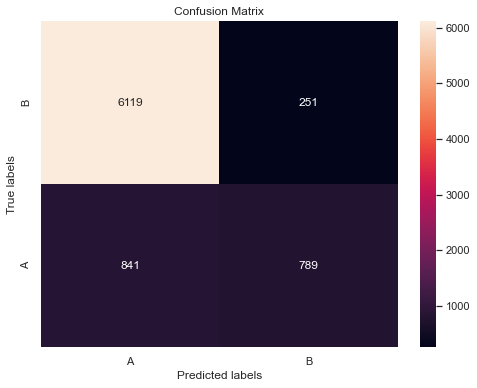

In [432]:
y_pred_cat_cv_imbal = cross_val_predict(cat2, X_train_selected_2, y_train_imb, cv=10)
cm = confusion_matrix(y_train_imb, y_pred_cat_cv_imbal, labels = [0, 1])
plt.figure(figsize=(8,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='.0f', ax = ax);
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['A', 'B'])   
ax.yaxis.set_ticklabels(['B', 'A'])
;

In [433]:
result=pd.concat([bl_results,knn_results,lg_results,xgb_results,svm_results,rf_results,cat_results])
result

Balanced Accuracy  Precision   Recall       F1  ROC_AUC    Kappa
Baseline            0.501000           0.501000   0.503000 0.502000 0.501000 0.001000
K Nearest Neighbors 0.871000           0.856000   0.892000 0.874000 0.871000 0.742000
Logistic Regression 0.805000           0.810000   0.798000 0.804000 0.805000 0.611000
XGB                 0.975000           0.986000   0.963000 0.974000 0.975000 0.949000
SVM                 0.731000           0.707000   0.789000 0.746000 0.731000 0.463000
Random Forest       1.000000           1.000000   1.000000 1.000000 1.000000 1.000000
CatBoost            0.941000           0.956000   0.924000 0.940000 0.941000 0.881000

In [434]:
result=pd.concat([bl_results2,knn_results2,lg_results2,xgb_results2,svm_results2,rf_results2,cat_results2])
result

Balanced Accuracy  Precision   Recall       F1  ROC_AUC    Kappa
Baseline            0.501000           0.206000   0.201000 0.204000 0.501000 0.003000
K Nearest Neighbors 0.700000           0.732000   0.442000 0.551000 0.700000 0.470000
Logistic Regression 0.588000           0.615000   0.210000 0.314000 0.588000 0.234000
XGB                 0.924000           0.983000   0.852000 0.913000 0.924000 0.893000
SVM                 0.637000           0.306000   0.652000 0.417000 0.637000 0.193000
Random Forest       1.000000           1.000000   1.000000 1.000000 1.000000 1.000000
cat                 0.769000           0.396000   0.885000 0.547000 0.769000 0.369000

In [435]:
# performance comparison data frame
performance_comp = pd.concat([bl_cv_bal, lr_cv_bal, knn_cv_bal, svm_cv_bal, xgb_cv_bal, rf_cv_bal, cat_cv_bal])
performance_comp.columns = ['test_accuracy','train_accuracy','test_precision','train_precision','test_recall','train_recall','test_f1_score','train_f1_score','test_roc_auc_score','train_roc_auc_score','test_mcc','train_mcc']
performance_comp['model'] = ['Baseline', 'Linear Regression', 'KNN', 'SVM', 'XGB', 'Random Forest', 'Cat']
performance_comp = performance_comp[['model', 'test_accuracy','train_accuracy','test_precision','train_precision','test_recall','train_recall','test_f1_score','train_f1_score','test_roc_auc_score','train_roc_auc_score','test_mcc','train_mcc']]
performance_comp.set_index('model')

test_accuracy  train_accuracy  test_precision  train_precision  test_recall  train_recall  test_f1_score  train_f1_score  test_roc_auc_score  train_roc_auc_score  test_mcc  train_mcc
model                                                                                                                                                                                                    
Baseline          0.501764       0.497777        0.501717        0.497772         0.514629     0.496396      0.507933       0.497075        0.501765            0.497777             0.003537  -0.004446 
Linear Regression 0.802882       0.805517        0.803005        0.810069         0.794774     0.798144      0.793960       0.804061        0.802924            0.805517             0.610808  0.611101  
KNN               0.805348       0.868582        0.786032        0.853666         0.834757     0.889653      0.807672       0.871276        0.805378            0.868582             0.615218  0.737845  
SVM               0.718813       0.726384        0.697861        0.704958         0.768851     0.785434      0.725270       0.742157        0.718857            0.726383             0.446932  0.456937  
XGB               0.900873       0.978567        0.912002        0.987719         0.883965     0.969177      0.890130       0.978358        0.900922            0.978567             0.810775  0.957307  
Random Forest     0.879545       0.999990        0.882464        0.999980         0.873359     1.000000      0.874763       0.999990        0.879580            0.999990             0.763392  0.999980  
Cat               0.898758       0.941488        0.912424        0.955568         0.879733     0.926018      0.888012       0.940559        0.898806            0.941488             0.806815  0.883400

In [436]:
# performance comparison data frame
performance_comp = pd.concat([bl_cv_imb, lr_cv_imb, knn_cv_imb, svm_cv_imb, xgb_cv_imb, rf_cv_imb, cat_cv_imb])
performance_comp.columns = ['test_accuracy','train_accuracy','test_precision','train_precision','test_recall','train_recall','test_f1_score','train_f1_score','test_roc_auc_score','train_roc_auc_score','test_mcc','train_mcc']
performance_comp['model'] = ['Baseline', 'Linear Regression', 'KNN', 'SVM', 'XGB', 'Random Forest', 'Cat']
performance_comp = performance_comp[['model', 'test_accuracy','train_accuracy','test_precision','train_precision','test_recall','train_recall','test_f1_score','train_f1_score','test_roc_auc_score','train_roc_auc_score','test_mcc','train_mcc']]
performance_comp.set_index('model')

test_accuracy  train_accuracy  test_precision  train_precision  test_recall  train_recall  test_f1_score  train_f1_score  test_roc_auc_score  train_roc_auc_score  test_mcc  train_mcc
model                                                                                                                                                                                                    
Baseline          0.679000       0.676694        0.201468        0.202210         0.195706     0.199455      0.198450       0.200808        0.499187            0.499134             -0.002081 -0.001806 
Linear Regression 0.811750       0.812889        0.612923        0.619048         0.209202     0.212406      0.311394       0.316268        0.587568            0.589475             0.277229  0.282662  
KNN               0.804875       0.853819        0.535712        0.734567         0.318405     0.442468      0.398107       0.552251        0.623881            0.700773             0.305566  0.492909  
SVM               0.796125       0.796639        0.000000        0.980000         0.000000     0.001977      0.000000       0.003945        0.499922            0.500980             -0.001790 0.038745  
XGB               0.854000       0.969431        0.708691        0.982560         0.481595     0.865303      0.573010       0.920163        0.715444            0.930689             0.502401  0.904173  
Random Forest     0.861500       0.999958        0.772506        1.000000         0.453988     0.999796      0.570996       0.999898        0.709882            0.999898             0.520496  0.999872  
Cat               0.863500       0.913931        0.758698        0.917099         0.484049     0.634969      0.589926       0.750359        0.722323            0.810141             0.532233  0.717730

# 10 Hyperparameter Tunning

## 10.1 Random Forest

### 10.1.1 RF Imbalanced

In [437]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1) 
# set hyperparameters values

# n_estimators: number of trees in the random forest (default=100)
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]

# max_depth: maximum number of levels in tree (default = None)
max_depth = [int(x) for x in np.linspace(4, 40, 10)]
max_depth.append(None)

# min_samples_split: minimum number of samples required to split a node (default = 2)
min_samples_split = [2, 5, 10]

# min_samples_leaf: minimum number of samples required at each leadf node (default = 1)
min_samples_leaf = [1, 2, 4]

# create random grid
param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf}

print(param_grid)


{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_depth': [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}


In [438]:
# prepare RandomizedSearchCV object
# 10-fold cross validation
# Search across 50 different combinations (n_iter=50)

rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                              scoring='f1', n_iter=50, cv=10, verbose=2,
                              random_state=42, n_jobs=-1)

In [439]:
# fit the model
rf_random.fit(X_train_selected_2, y_train_imb)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 10.4min finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
              

RandomizedSearchCV(cv=10,
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': [4, 8, 12, 16, 20, 24, 28,
                                                      32, 36, 40, None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, scoring='f1', verbose=2)

In [440]:
rf_random.best_params_ 

{'n_estimators': 400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_depth': 32}

In [441]:
rf_random.best_estimator_ 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=32, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [442]:
rf_tuned = rf_random.best_estimator_
rf_tuned

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=32, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [443]:
random_forest_tuned_imb, cm = performance_test('Random Forest Tuned Imbal',rf_tuned, X_test_selected, y_test_imb)
random_forest_tuned_imb

precision   recall  f1_score  roc_auc_score      mcc
Random Forest Tuned Imbal 0.800866   0.454545 0.579937  0.712835       0.536176

### 10.1.2 RF Balanced

In [444]:
rf_bal_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid,
                              scoring='f1', n_iter=50, cv=10, verbose=2,
                              random_state=42, n_jobs=-1)

In [445]:
rf_bal_random.fit(X_train_selected, y_smt)

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 16.0min finished


RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
              

In [446]:
rf_bal_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 24}

In [447]:
rf_tuned_bal=rf_bal_random.best_estimator_

In [448]:
random_forest_tuned_bal, cm = performance_test('Random Forest Tuned Bal',rf_tuned_bal, X_test_selected, y_test_smt)
random_forest_tuned_bal

precision   recall  f1_score  roc_auc_score      mcc
Random Forest Tuned Bal 0.556064   0.597052 0.575829  0.737634       0.463046

In [449]:
cm

<module 'imblearn.combine' from 'C:\\Users\\HP\\Anaconda3\\lib\\site-packages\\imblearn\\combine\\__init__.py'>

In [450]:
random_forest_imbal, cm = performance_test('Random Forest Imbal',rf2, X_test_selected, y_test_imb)
random_forest_imbal

precision   recall  f1_score  roc_auc_score      mcc
Random Forest Imbal 0.778261   0.439803 0.562009  0.703894       0.514623

## 10.2 Cat

### 10.2.1 Cat Balanced

In [454]:
xgb_bal, cm = performance_test('XGB Bal',xgb, X_test_selected, y_test_smt)
xgb_bal

precision   recall  f1_score  roc_auc_score      mcc
XGB Bal 0.610497   0.542998 0.574772  0.727243       0.475241

In [452]:
cat_bal, cm = performance_test('CatBoost Bal',cat, X_test_selected, y_test_smt)
cat_bal

precision   recall  f1_score  roc_auc_score      mcc
CatBoost Bal 0.643052   0.579853 0.609819  0.748809       0.517577

### 10.2.1 Cat Imbalanced

In [451]:
cat_imbal, cm = performance_test('CatBoost Imbal',cat2, X_test_selected, y_test_imb)
cat_imbal

precision   recall  f1_score  roc_auc_score      mcc
CatBoost Imbal 0.778243   0.457002 0.575851  0.711866       0.525918

In [453]:
xgb_imbal, cm = performance_test('XGB Imbal',xgb2, X_test_selected, y_test_imb)
xgb_imbal

precision   recall  f1_score  roc_auc_score      mcc
XGB Imbal 0.716535   0.447174 0.550681  0.700988       0.486034

## 10.3 Summary

In [455]:
perf_comp = pd.concat([random_forest_imbal,random_forest_tuned_bal, random_forest_tuned_imb,cat_imbal,cat_bal])

perf_comp

precision   recall  f1_score  roc_auc_score      mcc
Random Forest Imbal       0.778261   0.439803 0.562009  0.703894       0.514623
Random Forest Tuned Bal   0.556064   0.597052 0.575829  0.737634       0.463046
Random Forest Tuned Imbal 0.800866   0.454545 0.579937  0.712835       0.536176
CatBoost Imbal            0.778243   0.457002 0.575851  0.711866       0.525918
CatBoost Bal              0.643052   0.579853 0.609819  0.748809       0.517577

CHOSEN MODEL: Random Forest Tuned Imbalanced

# 11. Model and Business Performance

## 11.1 Model Performance

### 11.1.1 Precision and Recall

In [478]:
y_probas = rf_tuned.predict_proba(X_test_selected)
y_pred = rf_tuned.predict(X_test_selected)
y_scores = y_probas[:,1]

In [479]:
precisions, recalls, thresholds = precision_recall_curve(y_test_imb, y_scores) 

In [480]:
# model recall
recall_model = random_forest_tuned_imb['recall'][0]

# model precision
precision_model = random_forest_tuned_imb['precision'][0]

In [481]:
# current precision index
prec_index = np.where(precisions==precision_model)
prec_index

(array([1709], dtype=int64),)

In [482]:
# model current threshold
threshold_model = thresholds[prec_index]
threshold_model

array([0.5001379])

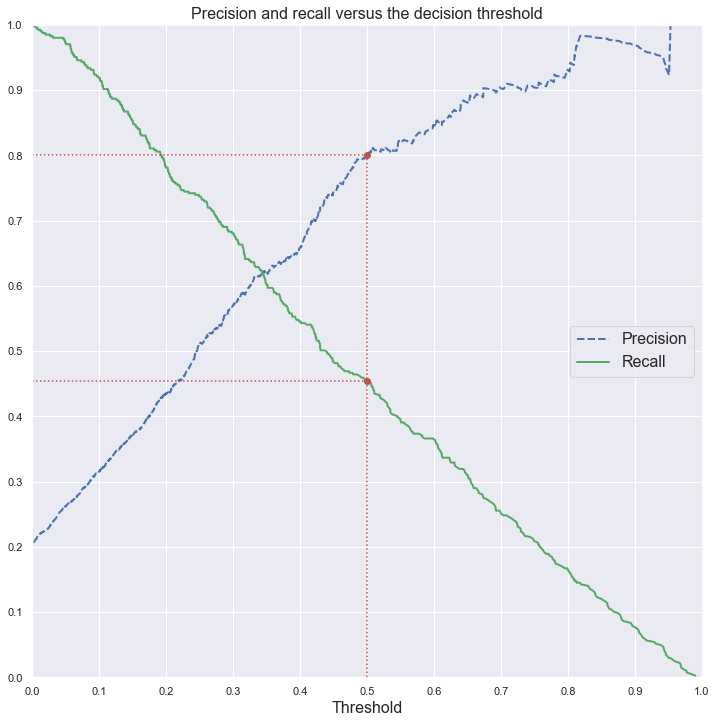

In [485]:
# Plot precision and recall versus threshold

# figure size
plt.figure(figsize=(12,12))

plt.plot(thresholds, precisions[:-1], "b--", label='Precision', linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label='Recall', linewidth=2)
plt.legend(loc='center right', fontsize=16)
plt.xlabel("Threshold", fontsize=16)
plt.xticks(np.arange(0, 1.01, step=0.1))
plt.yticks(np.arange(0, 1.01, step=0.1))
plt.grid(True)

# plot current precision and recall from the model
plt.plot([threshold_model, threshold_model], [0.0, precision_model], 'r:')
plt.plot([0.0, threshold_model], [precision_model, precision_model], 'r:')
plt.plot([0.0, threshold_model], [recall_model, recall_model], 'r:')
plt.plot([threshold_model], [precision_model], 'ro')
plt.plot([threshold_model], [recall_model], 'ro')
plt.axis([0, 1, 0, 1])
plt.title('Precision and recall versus the decision threshold', fontsize=16)
plt.show()

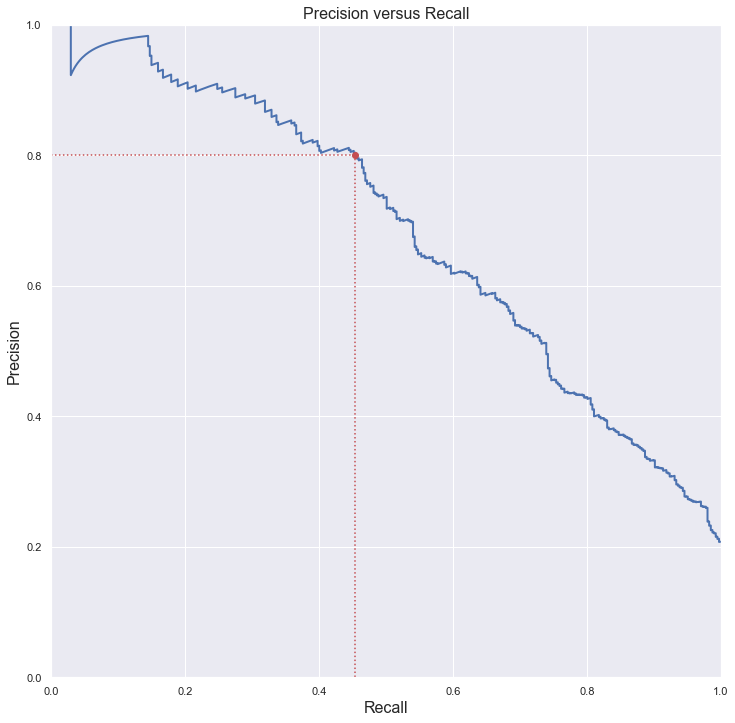

In [486]:
# plot precision versus recall

# figure size
plt.figure(figsize=(12,12))

plt.plot(recalls, precisions, 'b-', linewidth=2)
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.axis([0, 1, 0, 1])

# plot current precision and recall from the model
plt.plot([recall_model, recall_model], [0.0, precision_model], 'r:')
plt.plot([0.0, recall_model], [precision_model, precision_model], 'r:')
plt.plot([recall_model], [precision_model], 'ro')
plt.grid(True)
plt.title('Precision versus Recall', fontsize=16)
plt.show()

### 11.1.2 ROC curve

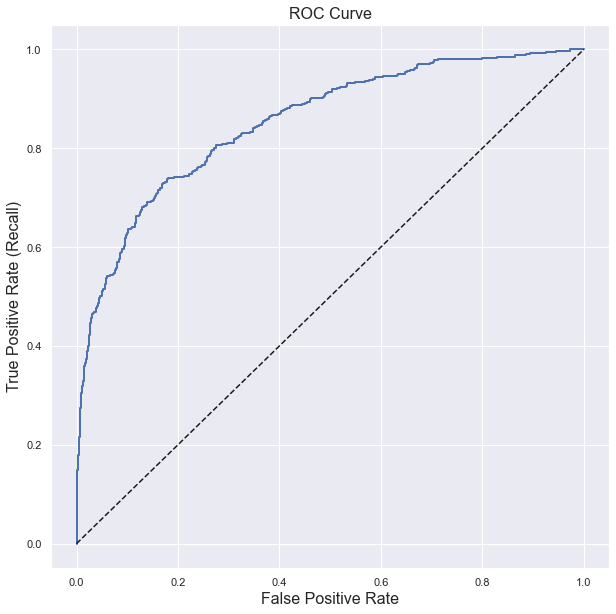

In [214]:
# compute TPR and FPR
fpr, tpr, thresholds = roc_curve(y_test_imb, y_scores)

# figure size
plt.figure(figsize=(10,10))

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate (Recall)', fontsize=16)
plt.title('ROC Curve', fontsize=16)
plt.grid(True)
plt.show()

### 11.1.3 Lift Curve and Cumulative Gains Curve

The lift curve uses the returned probability of a classification model to assess how the model is performing, and how well it is identifying the positive or negative instances of the dataset. <br>
After ordering the data, sorting by probability, the highest probability appear on the left, usually along with the highest Lift scores. <br>
Provides a quick way to get an estimate of how the algorithm is performing as it shoes how many times better applying the model is than random selection for any percentage of the ranked records.The greater the area between the lift curve and the baseline, the better the model.

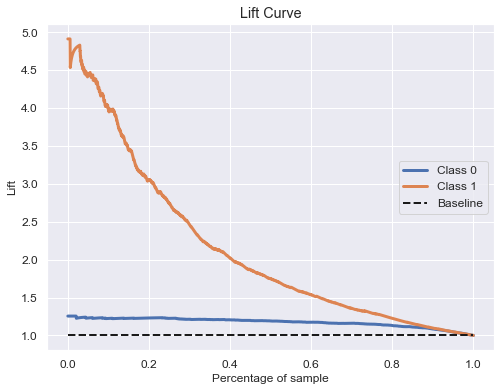

In [464]:
# plot Lift curve
skplt.metrics.plot_lift_curve(y_test_imb, y_probas, figsize=(8,6))
plt.legend(loc='center right', fontsize=12)
plt.show()

 
The Lift curve shows that if 20% of the customers are contacted, using the prediction of the model should reach 60% of customers in churn. 60 / 20 = 3.

In the Cumulative Gains Curve, the left side of the x-axis starts with the observations that have the highest probability of belonging to the class of interest. The x axis tell us what percentage of the observations are being considered. In this case, it is a percentage of the 2,000 clients from the test set. <br>
The y axis (Gain) indicates the percentage of positive responses. In this case, it is the percentage of the positive responses (churn) from the test set.<br>
When the model is applied to the data, and the X% clients most likely are selected, what percentage of the actually churned clients you are expect to find?

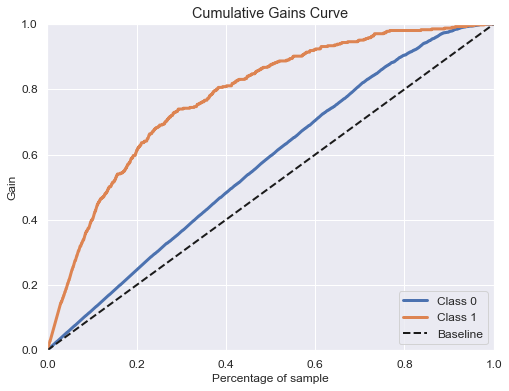

In [465]:
 # plot cumulative gains curve
skplt.metrics.plot_cumulative_gain(y_test_imb, y_probas, figsize=(8,6))
plt.show()

In [487]:
# copy test_set
lift_df = test_set.copy()

# add predictions and predicted probabilities according the model
lift_df['predictions'] = y_pred
lift_df['probabilities'] = y_scores

# sort lift_df according predicted probabilities
lift_df = lift_df.sort_values('probabilities', ascending=False)

# set percentage of the sample (percentage of clients to contact in order to avoid churn)
sample_pc = 0.2

# calculate the size of the percentage of the sample
top_sample_pc = np.ceil((len(lift_df['exited'])*sample_pc)).astype(int)

# select top rated clients (top predicted probabilities)
clients_top = lift_df.iloc[:top_sample_pc]

# calculate cumulative gain
cumulative_gain = clients_top['exited'].sum() / test_set['exited'].sum()

# calculate lift
lift = cumulative_gain / sample_pc

# print results
print('Sample percentage: {}%'.format(sample_pc*100))
print('Cumulative gain: {:,.2f}'.format(cumulative_gain))
print('Lift: {:,.2f}'.format(lift))



Sample percentage: 20.0%
Cumulative gain: 0.61
Lift: 3.06


## 11.2. Business Performance

### 11.2.1 Churn Rate

In [467]:
# calculate current churn rate
churn_rate = test_set['exited'].value_counts(normalize=True)*100
print('The current churn Rate is {:,.2f}%'.format(churn_rate[1]))

The current churn Rate is 20.35%


In [488]:
# Churn rate by tenure

In [470]:
# get tenure values
ten_values = test_set['tenure'].value_counts()
ten_values = np.array(ten_values.index)
churn_list = []

# calculate churn rate per tenure
for ten in ten_values:
    churn_rate_ten = (test_set[test_set['tenure']==ten]['exited'].sum() / len(test_set[test_set['tenure']==ten]))*100
    churn_list.append(churn_rate_ten)
    
churn_ten_df = pd.DataFrame({'churn_rate': churn_list, 'tenure': ten_values})
churn_ten_df = churn_ten_df.sort_values('tenure')
churn_ten_df.round(2)    

churn_rate  tenure
10 23.080000    0     
0  23.010000    1     
5  21.890000    2     
7  22.950000    3     
6  23.320000    4     
2  22.640000    5     
1  19.550000    6     
3  15.310000    7     
4  17.410000    8     
8  20.000000    9     
9  12.750000    10

### 11.2.2 Model Performance
<br>
The model has a precision of 80%. The model can detect 45.5% of clients in churn (Recall).

### 11.2.3 Bank Revenue

#### a) What's the company's revenue, if the company avoids all customers to get into churn through the developed model?
 
Bank account return per client: <br>
15% for clients with estimated income lower than the average;<br>
20% for clients with estimated income greater than the average.

In [492]:
# calculate bank account return per client

business_df = test_set.copy()
business_df['return_client'] = business_df.apply(lambda x: x['estimated_salary']*0.15 if x['estimated_salary'] < business_df['estimated_salary'].mean() else x['estimated_salary']*0.2, axis=1)

In [493]:
# calculate current total return of all clients
return_total = business_df['return_client'].sum()
print('Total current return of all clients: {:,.2f}'.format(return_total))

Total current return of all clients: 38,079,850.98


In [494]:
# number of clients in churn
clients_churn = business_df['exited'].value_counts()[1]

# calculate total revenue loss
total_loss = business_df[business_df['exited']==1]['return_client'].sum()
print('Total revenue loss if all {} clients in churn leave the bank: {:,.2f}.'.format(clients_churn, total_loss))
print('The total revenue loss represents {:,.2f}% of total current return.'.format((total_loss/return_total)*100))

Total revenue loss if all 407 clients in churn leave the bank: 7,491,850.97.
The total revenue loss represents 19.67% of total current return.


In [495]:
# dataframe with predictions and predicted probabilities
business_df['predictions'] = y_pred
business_df['probabilities'] = y_scores

In [496]:
# Calculate company's revenue if the company avoids all customers to get into churn through the developed model

# filter clients in churn according model and dataset
aux = business_df[(business_df['exited']==1) & (business_df['predictions']==1)]

# number of clients to recover
clients_recover = len(aux)
# clients identified to recover / clients in churn
clients_ratio = (clients_recover / clients_churn)*100

# revenue if clients don't get in churn
revenue = aux['return_client'].sum()
# revenue ratio
revenue_ratio = (revenue / total_loss)*100

print("Company's recovered revenue if {} clients don't get into churn through the model: {:,.2f}".\
      format(clients_recover, revenue))
print('That represents {:,.2f}% of clients labeled as in churn and {:,.2f}% of the total revenue loss'.\
      format(clients_ratio, revenue_ratio))

Company's recovered revenue if 185 clients don't get into churn through the model: 3,555,818.69
That represents 45.45% of clients labeled as in churn and 47.46% of the total revenue loss


#### b) Customer Incentive to Maximize ROI - Alternative 1
Top 100 clients with highest churn probability. <br>
Which customers could receive an incentive and at what cost, in order to maximize the ROI (Return on investment)? (the sum of incentives shall not exceed BRL 10,000.00<br>
<br>
b.1) Incentive per client: $100. Profit is the difference between recovered revenue and the incentive per client.

In [497]:
# sort business_df according predicted probabilities
business_df = business_df.sort_values('probabilities', ascending=False)

In [498]:
# select top 100 clients with highest churn probability
clients_top_100 = business_df.iloc[:100]

# set incentive per client
clients_top_100['incentive'] = 100

# calculate recovered revenue per client
clients_top_100['rec_revenue'] = clients_top_100.apply(lambda x: x['return_client'] if x['exited']==1 else 0, axis=1)

# calculate profit per client
clients_top_100['profit'] = clients_top_100['rec_revenue'] - clients_top_100['incentive']

# calculate total recovered revenue
revenue = clients_top_100['rec_revenue'].sum()

# calculate revenue loss recovered (%)
loss_recovered = (revenue / total_loss)*100

# calculate the amount of investments (sum of incentives)
investment = clients_top_100['incentive'].sum()

# calculate the profit
profit = clients_top_100['profit'].sum()

# calculate ROI
roi = (profit / investment)*100

# calculate possible churn reduction in %
churn_model = clients_top_100[(clients_top_100['exited']==1) & (clients_top_100['predictions']==1)]
churn_red = (len(churn_model) / len(business_df[business_df['exited']==1]))*100

print('Recovered Revenue: {:,.2f}'.format(revenue))
print('% Recovered from Total Revenue loss: {:,.2f}%'.format(loss_recovered))
print('Investment: {:,.2f}'.format(investment))
print('Profit: {:,.2f}'.format(profit))
print('ROI: {:,.2f}%'.format(roi))
print('Potential clients recovered acc. model: {}'.format(len(churn_model)))
print('Potential churn reduction: {:,.2f}%'.format(churn_red))

Recovered Revenue: 1,748,826.50
% Recovered from Total Revenue loss: 23.34%
Investment: 10,000.00
Profit: 1,738,826.50
ROI: 17,388.26%
Potential clients recovered acc. model: 90
Potential churn reduction: 22.11%


#### c) Customer Incentive to Maximize ROI - Alternative 2
Top 200 clients with highest churn probability. <br> 
Which customers could receive an incentive and at what cost, in order to maximize the ROI (Return on investment)? (the sum of incentives shall not exceed BRL 10,000.00<br>
<br>
Incentive per client: $50.

In [499]:
# select top 200 clients with highest churn probability
clients_top_200 = business_df.iloc[:200]

# set incentive per client
clients_top_200['incentive'] = 50

# calculate recovered revenue per client
clients_top_200['rec_revenue'] = clients_top_200.\
apply(lambda x: x['return_client'] if x['exited']==1 else 0, axis=1)

# calculate profit per client
clients_top_200['profit'] = clients_top_200['rec_revenue'] - clients_top_200['incentive']

# calculate total recovered revenue
revenue = clients_top_200['rec_revenue'].sum()

# calculate revenue loss recovered (%)
loss_recovered = (revenue / total_loss)*100

# calculate the amount of investments (sum of incentives)
investment = clients_top_200['incentive'].sum()

# calculate the profit
profit = clients_top_200['profit'].sum()

# calculate ROI
roi = (profit / investment)*100

# calculate possible churn reduction in %
churn_model = clients_top_200[(clients_top_200['exited']==1) & (clients_top_200['predictions']==1)]
churn_red = (len(churn_model) / len(business_df[business_df['exited']==1]))*100

print('Recovered Revenue: {:,.2f}'.format(revenue))
print('% Recovered from Total Revenue loss: {:,.2f}%'.format(loss_recovered))
print('Investment: {:,.2f}'.format(investment))
print('Profit: {:,.2f}'.format(profit))
print('ROI: {:,.2f}%'.format(roi))
print('Potential clients recovered acc. model: {}'.format(len(churn_model)))
print('Potential churn reduction: {:,.2f}%'.format(churn_red))

Recovered Revenue: 3,202,198.62
% Recovered from Total Revenue loss: 42.74%
Investment: 10,000.00
Profit: 3,192,198.62
ROI: 31,921.99%
Potential clients recovered acc. model: 163
Potential churn reduction: 40.05%


# Summary

## What's the company's current churn rate?

The current churn Rate is 20.35%

## How the churn rate varies per tenure?

In [516]:
churn_ten_df

churn_rate  tenure
10 23.076923    0     
0  23.008850    1     
5  21.890547    2     
7  22.950820    3     
6  23.316062    4     
2  22.641509    5     
1  19.545455    6     
3  15.311005    7     
4  17.412935    8     
8  20.000000    9     
9  12.745098    10

## What's the model's performance to label the clients as churns?

The model has a precision of 80%. The model can detect 45.5% of clients in churn (Recall).

## What's the company's revenue, if the company avoids the customers to get into churn through the developed model?

Total revenue loss if all 407 clients in churn leave the bank: 7,491,850.97. <br>
The total revenue loss represents 19.67% of total current return.

Scenario A) all customers do not enter in churn
Total current return of all clients: 38,079,850.98
Total revenue loss if all 407 clients in churn leave the bank: 7,491,850.97.
The total revenue loss represents 19.67% of total current return.

Scenario B) identified customers do not enter in churn
Company's recovered revenue if 185 clients don't get into churn through the model: 3,555,818.69
That represents 45.45% of clients labeled as in churn and 47.46% of the total revenue loss

Scenario C) incentive per client: $100. All 100 identified clients that receive voucher do not churn
Recovered Revenue: 1,748,826.50
% Recovered from Total Revenue loss: 23.34%
Investment: 10,000.00
Profit: 1,738,826.50
ROI: 17,388.26%
Potential clients recovered acc. model: 90
Potential churn reduction: 22.11%

Scenario D) Incentive per client: $50. All 200 identified clients that receive voucher do not churn
Recovered Revenue: 3,202,198.62
% Recovered from Total Revenue loss: 42.74%
Investment: 10,000.00
Profit: 3,192,198.62
ROI: 31,921.99%
Potential clients recovered acc. model: 163
Potential churn reduction: 40.05%

## Considerations

An realistic approach would consider that not all clients would continue at TopBank. Also, it would take in account that clients with more probability of churn may need an higher amount of incentives than the clients with less probability of churn. Therefore it would be interesting consider the "0-1 Knapsack-Problem" approach. IF TopBank has data on past promotional initiatives, it could be included in order to improve the selection of customers to contact.

Other improvements to this project would be test more models/hyperparameters and evaluate its performance.

The use of SmoteTomek technique seemed to overfit the model.